In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma

from colide.model import colide_ev
from colide.utils import count_accuracy 

SEED = 10
N_CPUS = os.cpu_count() // 2
np.random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(N_samples), len(exps)))  for _ in range(8)]
    for i, n_samples in enumerate(N_samples):
        print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples
        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_norm = X/np.linalg.norm(X, axis=1, keepdims=True)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb']) 

            model = exp['model']()
            t_init = perf_counter()
            model.fit(X_aux, **arg_aux)
            t_end = perf_counter()

            W_est_bin = utils.to_bin(model.W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, model.W_est, norm_W_true)
            acyc[i,j] = model.dagness(model.W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb:
                print(f'\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count


def plot_data(axes, data, exps, x_vals, xlabel, ylabel, skip_idx=[], agg='mean', deviation=False,
              alpha=.25, plot_func='semilogx'):
    if agg == 'median':
        agg_data = np.median(data, axis=0)
    else:
        agg_data = np.mean(data, axis=0)

    std = np.std(data, axis=0)

    for i, exp in enumerate(exps):
        if i in skip_idx:
            continue
        getattr(axes, plot_func)(x_vals, agg_data[:,i], exp['fmt'], label=exp['leg'])

        if deviation:
            up_ci = agg_data[:,i] + std[:,i]
            low_ci = np.maximum(agg_data[:,i] - std[:,i], 0)
            axes.fill_between(x_vals, low_ci, up_ci, alpha=alpha)


    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.grid(True)
    axes.legend()

def plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, x_vals, exps, 
                     agg='mean', skip_idx=[], dev=False, alpha=.25):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], shd, exps, x_vals, 'Number of samples', 'SDH', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[1], tpr, exps, x_vals, 'Number of samples', 'TPR', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[2], fdr, exps, x_vals, 'Number of samples', 'FDR', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[3], fscore, exps, x_vals, 'Number of samples', 'F1', skip_idx,
              agg=agg, deviation=dev, alpha=alpha)
    plt.tight_layout()

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    plot_data(axes[0], err, exps, x_vals, 'Number of samples', 'Fro Error', skip_idx, agg=agg,
              deviation=dev, alpha=alpha, plot_func='loglog')
    plot_data(axes[1], acyc, exps, x_vals, 'Number of samples', 'Acyclity', skip_idx, agg=agg,
              deviation=dev)
    plot_data(axes[2], runtime, exps, x_vals, 'Number of samples', 'Running time (seconds)',
              skip_idx, agg=agg, deviation=dev, alpha=alpha)
    plot_data(axes[3], dag_count, exps, x_vals, 'Number of samples', 'Graph is DAG', skip_idx,
              agg=agg)
    plt.tight_layout()



## 2N Edges

In [3]:
n_dags = 50
N_samples = [ 25, 50, 100, 150, 200, 300, 500] #[75, 100, 200, 500, 1000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
  # Proj Grad Desc
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 2e-2, 'max_iters': 10000},
     'adapt_lamb': True,  'norm_x': False, 'fmt': 'o-', 'leg': 'PGD-adap'},

    {'model': MetMulDagma, 'args': {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 2e-2,
     'iters_in': 5000, 'iters_out': 10, 'beta': 5}, 'adapt_lamb': True, 'norm_x': False,
     'fmt': 'x-', 'leg': 'MM-adap'},

  # Collide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'fmt': 'v-', 'leg': 'CoLiDe-Paper_regs-notnorm'},
    # {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
    #  'max_iter': 7e4, 'lr': 0.003}, 'norm_x': True, 'fmt': 'x:', 'leg': 'CoLiDe-norm'},   
]

### 50 nodes

In [4]:
N = 50
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)
dag_count = np.array(dag_count)/n_dags

CPUs employed: 32


Graph: 7, samples: 25
Graph: 11, samples: 25
Graph: 4, samples: 25
Graph: 24, samples: 25
Graph: 12, samples: 25
Graph: 21, samples: 25
Graph: 23, samples: 25
Graph: 14, samples: 25
Graph: 28, samples: 25
Graph: 25, samples: 25
Graph: 18, samples: 25
Graph: 16, samples: 25
Graph: 29, samples: 25
Graph: 9, samples: 25
Graph: 26, samples: 25
Graph: 30, samples: 25
Graph: 13, samples: 25
Graph: 8, samples: 25
Graph: 31, samples: 25
Graph: 17, samples: 25
Graph: 3, samples: 25
Graph: 19, samples: 25
Graph: 22, samples: 25
Graph: 6, samples: 25
Graph: 10, samples: 25
Graph: 2, samples: 25
Graph: 5, samples: 25
Graph: 32, samples: 25
Graph: 27, samples: 25
Graph: 1, samples: 25
Graph: 20, samples: 25
Graph: 15, samples: 25
		-PGD-adap: shd 81.0  -  err: 0.610  -  time: 1.461
		-PGD-adap: shd 81.0  -  err: 0.446  -  time: 1.491
		-PGD-adap: shd 83.0  -  err: 0.527  -  time: 1.506
		-PGD-adap: shd 76.0  -  err: 0.505  -  time: 1.664
		-PGD-adap: shd 69.0  -  err: 0.379  -  time: 1.702
		-PGD-a

  3%|▎         | 3299/130000.0 [00:00<00:26, 4706.25it/s]

		-MM-adap: shd 55.0  -  err: 0.327  -  time: 3.873
		-MM-adap: shd 86.0  -  err: 0.626  -  time: 4.366


  0%|          | 474/130000.0 [00:00<00:27, 4733.70it/s]]]

		-MM-adap: shd 71.0  -  err: 0.481  -  time: 5.021


 11%|█▏        | 14693/130000.0 [00:02<00:27, 4221.00it/s]

		-MM-adap: shd 74.0  -  err: 0.429  -  time: 5.943
		-MM-adap: shd 105.0  -  err: 0.630  -  time: 5.942


  0%|          | 0/130000.0 [00:00<?, ?it/s]4764.43it/s]s]

		-MM-adap: shd 102.0  -  err: 0.577  -  time: 6.128
		-MM-adap: shd 64.0  -  err: 0.434  -  time: 6.164
		-MM-adap: shd 69.0  -  err: 0.396  -  time: 6.417


  2%|▏         | 2565/130000.0 [00:00<00:19, 6410.20it/s]]]

		-MM-adap: shd 72.0  -  err: 0.470  -  time: 6.777


  4%|▍         | 5606/130000.0 [00:01<00:22, 5551.42it/s]] 

		-MM-adap: shd 90.0  -  err: 0.623  -  time: 6.875
		-MM-adap: shd 110.0  -  err: 0.708  -  time: 7.238


  4%|▍         | 5305/130000.0 [00:01<00:25, 4824.09it/s]s]

		-MM-adap: shd 94.0  -  err: 0.557  -  time: 7.238
		-MM-adap: shd 86.0  -  err: 0.620  -  time: 7.299
		-MM-adap: shd 72.0  -  err: 0.519  -  time: 7.264
		-MM-adap: shd 84.0  -  err: 0.496  -  time: 7.625
		-MM-adap: shd 77.0  -  err: 0.392  -  time: 7.680
		-MM-adap: shd 58.0  -  err: 0.440  -  time: 7.343


  2%|▏         | 2671/130000.0 [00:00<00:33, 3757.82it/s]] 

		-MM-adap: shd 83.0  -  err: 0.437  -  time: 7.829
		-MM-adap: shd 89.0  -  err: 0.611  -  time: 7.334
		-MM-adap: shd 69.0  -  err: 0.392  -  time: 7.991


  2%|▏         | 3201/130000.0 [00:00<00:22, 5690.17it/s]]]

		-MM-adap: shd 82.0  -  err: 0.417  -  time: 7.827
		-MM-adap: shd 81.0  -  err: 0.597  -  time: 8.061


  6%|▌         | 7170/130000.0 [00:01<00:29, 4213.82it/s]]]

		-MM-adap: shd 72.0  -  err: 0.418  -  time: 8.151
		-MM-adap: shd 88.0  -  err: 0.484  -  time: 8.179


 33%|███▎      | 43174/130000.0 [00:05<00:06, 13092.33it/s]

		-MM-adap: shd 114.0  -  err: 0.616  -  time: 8.788


  5%|▍         | 6354/130000.0 [00:01<00:19, 6260.07it/s]] 

		-MM-adap: shd 67.0  -  err: 0.416  -  time: 9.023
		-MM-adap: shd 69.0  -  err: 0.510  -  time: 9.253


  8%|▊         | 10166/130000.0 [00:01<00:19, 6234.99it/s]]

		-MM-adap: shd 79.0  -  err: 0.488  -  time: 9.578


  8%|▊         | 10694/130000.0 [00:01<00:19, 6028.53it/s]]

		-MM-adap: shd 61.0  -  err: 0.349  -  time: 10.435
		-MM-adap: shd 80.0  -  err: 0.510  -  time: 10.779


100%|██████████| 130000/130000.0 [00:08<00:00, 15679.36it/s]
 22%|██▏       | 27982/130000.0 [00:04<00:26, 3809.57it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 151.0  -  err: 0.799  -  time: 8.293
Graph: 29, samples: 50
		-MM-adap: shd 114.0  -  err: 1.902  -  time: 12.207


100%|██████████| 130000/130000.0 [00:09<00:00, 14030.85it/s]
 22%|██▏       | 28742/130000.0 [00:05<00:26, 3768.49it/s]

		-CoLiDe-Paper_regs-notnorm: shd 179.0  -  err: 0.972  -  time: 9.267
Graph: 26, samples: 50


100%|██████████| 130000/130000.0 [00:08<00:00, 14973.84it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 16740.87it/s]
 19%|█▊        | 24316/130000.0 [00:03<00:16, 6479.32it/s]

		-CoLiDe-Paper_regs-notnorm: shd 166.0  -  err: 0.909  -  time: 8.683
Graph: 24, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 158.0  -  err: 0.849  -  time: 7.767
Graph: 18, samples: 50


100%|██████████| 130000/130000.0 [00:07<00:00, 18564.23it/s] 
 32%|███▏      | 41379/130000.0 [00:05<00:08, 10187.12it/s]

		-CoLiDe-Paper_regs-notnorm: shd 202.0  -  err: 1.094  -  time: 7.004
Graph: 19, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 172.0  -  err: 0.997  -  time: 6.916
Graph: 3, samples: 50


100%|██████████| 130000/130000.0 [00:06<00:00, 18801.75it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 18611.48it/s]
 36%|███▌      | 46640/130000.0 [00:04<00:09, 8544.58it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 129.0  -  err: 0.645  -  time: 6.986
Graph: 13, samples: 50


100%|██████████| 130000/130000.0 [00:06<00:00, 20451.49it/s]
 33%|███▎      | 42617/130000.0 [00:03<00:05, 14890.45it/s]

		-CoLiDe-Paper_regs-notnorm: shd 167.0  -  err: 1.054  -  time: 6.358
Graph: 27, samples: 50
		-PGD-adap: shd 34.0  -  err: 0.227  -  time: 1.591


100%|██████████| 130000/130000.0 [00:07<00:00, 16518.25it/s]
 34%|███▍      | 43975/130000.0 [00:06<00:10, 7976.49it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 182.0  -  err: 0.889  -  time: 7.872
Graph: 16, samples: 50
		-PGD-adap: shd 23.0  -  err: 0.173  -  time: 1.486


 25%|██▌       | 32966/130000.0 [00:04<00:15, 6398.63it/s]]

		-PGD-adap: shd 18.0  -  err: 0.130  -  time: 1.488
		-CoLiDe-Paper_regs-notnorm: shd 162.0  -  err: 0.970  -  time: 6.544
Graph: 14, samples: 50
		-PGD-adap: shd 19.0  -  err: 0.119  -  time: 1.485


100%|██████████| 130000/130000.0 [00:06<00:00, 19869.46it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18221.92it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20009.35it/s]
 26%|██▋       | 34253/130000.0 [00:05<00:15, 6371.20it/s] 

		-PGD-adap: shd 25.0  -  err: 0.201  -  time: 1.386
		-CoLiDe-Paper_regs-notnorm: shd 157.0  -  err: 0.910  -  time: 7.136
Graph: 6, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 158.0  -  err: 0.709  -  time: 6.498
Graph: 7, samples: 50
		-PGD-adap: shd 31.0  -  err: 0.179  -  time: 1.394


100%|██████████| 130000/130000.0 [00:07<00:00, 16298.72it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20517.18it/s]
 27%|██▋       | 35533/130000.0 [00:05<00:14, 6344.13it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 189.0  -  err: 0.888  -  time: 7.978
Graph: 12, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 150.0  -  err: 0.668  -  time: 6.337
Graph: 1, samples: 50
		-PGD-adap: shd 21.0  -  err: 0.145  -  time: 1.471


100%|██████████| 130000/130000.0 [00:07<00:00, 18013.04it/s]
 29%|██▉       | 38043/130000.0 [00:05<00:15, 6124.36it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 157.0  -  err: 0.677  -  time: 7.218
Graph: 20, samples: 50
		-PGD-adap: shd 22.0  -  err: 0.129  -  time: 1.507
		-CoLiDe-Paper_regs-notnorm: shd 148.0  -  err: 0.843  -  time: 6.599
Graph: 22, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 177.0  -  err: 0.895  -  time: 8.216
Graph: 11, samples: 50


100%|██████████| 130000/130000.0 [00:06<00:00, 19704.11it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15826.42it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18178.55it/s]
 10%|▉         | 12821/130000.0 [00:03<00:31, 3690.45it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 150.0  -  err: 0.828  -  time: 7.152
Graph: 30, samples: 50
		-PGD-adap: shd 21.0  -  err: 0.142  -  time: 1.883


100%|██████████| 130000/130000.0 [00:05<00:00, 21800.85it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19307.75it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14974.85it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13529.12it/s]
 41%|████      | 52781/130000.0 [00:08<00:16, 4562.54it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 173.0  -  err: 0.854  -  time: 5.964
Graph: 15, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 169.0  -  err: 0.768  -  time: 6.734
Graph: 28, samples: 50
		-PGD-adap: shd 19.0  -  err: 0.116  -  time: 1.480
		-CoLiDe-Paper_regs-notnorm: shd 214.0  -  err: 1.139  -  time: 8.683
Graph: 21, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 171.0  -  err: 0.882  -  time: 9.611
Graph: 23, samples: 50


100%|██████████| 130000/130000.0 [00:07<00:00, 17426.14it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19687.60it/s]
 51%|█████     | 65893/130000.0 [00:08<00:07, 9095.49it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 134.0  -  err: 0.666  -  time: 7.462
Graph: 32, samples: 50
		-PGD-adap: shd 18.0  -  err: 0.099  -  time: 1.746
		-PGD-adap: shd 26.0  -  err: 0.170  -  time: 1.726
		-CoLiDe-Paper_regs-notnorm: shd 156.0  -  err: 0.766  -  time: 6.605
Graph: 25, samples: 50


 51%|█████     | 66196/130000.0 [00:09<00:09, 7032.90it/s]]

		-PGD-adap: shd 28.0  -  err: 0.196  -  time: 1.816
		-PGD-adap: shd 30.0  -  err: 0.217  -  time: 1.891


 53%|█████▎    | 69267/130000.0 [00:09<00:08, 6993.28it/s]]

		-PGD-adap: shd 19.0  -  err: 0.147  -  time: 1.655
		-CoLiDe-Paper_regs-notnorm: shd 143.0  -  err: 0.772  -  time: 9.511
Graph: 10, samples: 50


100%|██████████| 130000/130000.0 [00:09<00:00, 13671.17it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13601.79it/s]
 38%|███▊      | 48935/130000.0 [00:07<00:16, 4845.90it/s]

		-CoLiDe-Paper_regs-notnorm: shd 125.0  -  err: 0.811  -  time: 9.559
Graph: 8, samples: 50
		-PGD-adap: shd 20.0  -  err: 0.116  -  time: 1.854
		-PGD-adap: shd 24.0  -  err: 0.134  -  time: 1.531
		-PGD-adap: shd 26.0  -  err: 0.187  -  time: 1.844


100%|██████████| 130000/130000.0 [00:10<00:00, 12746.85it/s]
 39%|███▉      | 51344/130000.0 [00:08<00:16, 4788.69it/s]

		-PGD-adap: shd 29.0  -  err: 0.178  -  time: 1.471
		-PGD-adap: shd 16.0  -  err: 0.125  -  time: 1.628
		-CoLiDe-Paper_regs-notnorm: shd 187.0  -  err: 0.861  -  time: 10.200
Graph: 9, samples: 50


 40%|████      | 52302/130000.0 [00:08<00:16, 4777.83it/s]]

		-PGD-adap: shd 24.0  -  err: 0.155  -  time: 1.805


 22%|██▏       | 28660/130000.0 [00:05<00:20, 4992.28it/s]]

		-PGD-adap: shd 26.0  -  err: 0.100  -  time: 1.813
		-PGD-adap: shd 23.0  -  err: 0.132  -  time: 1.977
		-CoLiDe-Paper_regs-notnorm: shd 162.0  -  err: 0.771  -  time: 10.645
Graph: 31, samples: 50


100%|██████████| 130000/130000.0 [00:10<00:00, 12213.68it/s]
 23%|██▎       | 29311/130000.0 [00:05<00:20, 4819.24it/s]

		-PGD-adap: shd 19.0  -  err: 0.168  -  time: 1.998
		-MM-adap: shd 22.0  -  err: 0.126  -  time: 3.137
		-MM-adap: shd 19.0  -  err: 0.130  -  time: 4.137


 50%|█████     | 65453/130000.0 [00:07<00:09, 7162.34it/s] 

		-MM-adap: shd 25.0  -  err: 0.190  -  time: 4.434
		-PGD-adap: shd 21.0  -  err: 0.190  -  time: 1.821
		-PGD-adap: shd 30.0  -  err: 0.150  -  time: 1.502


 51%|█████     | 66283/130000.0 [00:09<00:08, 7227.82it/s] 

		-MM-adap: shd 25.0  -  err: 0.147  -  time: 4.317
		-PGD-adap: shd 26.0  -  err: 0.141  -  time: 2.192


100%|██████████| 130000/130000.0 [00:09<00:00, 13054.26it/s]
  4%|▍         | 5268/130000.0 [00:01<00:26, 4781.91it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 160.0  -  err: 0.776  -  time: 9.960
Graph: 2, samples: 50


  5%|▍         | 6226/130000.0 [00:01<00:25, 4781.59it/s]]

		-MM-adap: shd 41.0  -  err: 0.241  -  time: 5.807


100%|██████████| 130000/130000.0 [00:08<00:00, 14656.79it/s]


		-CoLiDe-Paper_regs-notnorm: shd 144.0  -  err: 0.719  -  time: 8.871
Graph: 4, samples: 50


100%|██████████| 130000/130000.0 [00:09<00:00, 13738.33it/s] 
  3%|▎         | 3625/130000.0 [00:00<00:29, 4231.59it/s]

		-CoLiDe-Paper_regs-notnorm: shd 136.0  -  err: 0.662  -  time: 9.464
Graph: 17, samples: 50
		-PGD-adap: shd 28.0  -  err: 0.198  -  time: 2.206
		-MM-adap: shd 18.0  -  err: 0.116  -  time: 6.037


  7%|▋         | 9435/130000.0 [00:02<00:31, 3844.89it/s]]]

		-MM-adap: shd 30.0  -  err: 0.195  -  time: 4.391


  8%|▊         | 10220/130000.0 [00:02<00:31, 3847.70it/s]]

		-MM-adap: shd 26.0  -  err: 0.170  -  time: 7.107
		-MM-adap: shd 27.0  -  err: 0.127  -  time: 3.199
		-MM-adap: shd 29.0  -  err: 0.180  -  time: 6.581
		-PGD-adap: shd 37.0  -  err: 0.210  -  time: 1.787


  4%|▍         | 5777/130000.0 [00:01<00:28, 4381.16it/s]]]

		-MM-adap: shd 23.0  -  err: 0.147  -  time: 5.676
		-MM-adap: shd 25.0  -  err: 0.216  -  time: 4.736
		-MM-adap: shd 28.0  -  err: 0.171  -  time: 5.463


  4%|▍         | 5281/130000.0 [00:01<00:25, 4803.21it/s]s]

		-PGD-adap: shd 27.0  -  err: 0.239  -  time: 1.716
		-PGD-adap: shd 20.0  -  err: 0.130  -  time: 2.164


  5%|▍         | 6242/130000.0 [00:01<00:25, 4790.22it/s]s]

		-MM-adap: shd 29.0  -  err: 0.184  -  time: 5.676


  5%|▍         | 6195/130000.0 [00:01<00:25, 4779.35it/s]] 

		-MM-adap: shd 25.0  -  err: 0.178  -  time: 5.468
		-MM-adap: shd 21.0  -  err: 0.122  -  time: 6.774
		-MM-adap: shd 26.0  -  err: 0.176  -  time: 4.503


  6%|▌         | 8119/130000.0 [00:02<00:32, 3753.62it/s]s]

		-MM-adap: shd 23.0  -  err: 0.127  -  time: 5.897


  9%|▊         | 11054/130000.0 [00:02<00:24, 4805.26it/s]]

		-MM-adap: shd 16.0  -  err: 0.130  -  time: 5.855
		-MM-adap: shd 25.0  -  err: 0.131  -  time: 6.209


100%|██████████| 130000/130000.0 [00:11<00:00, 11633.82it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24970.89it/s]
  7%|▋         | 9664/130000.0 [00:02<00:31, 3863.98it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 191.0  -  err: 1.027  -  time: 11.176
Graph: 5, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.253  -  time: 5.207
Graph: 27, samples: 100
		-MM-adap: shd 12.0  -  err: 0.084  -  time: 7.411


  5%|▍         | 6048/130000.0 [00:01<00:21, 5726.29it/s]s]

		-MM-adap: shd 24.0  -  err: 0.134  -  time: 6.026
		-MM-adap: shd 29.0  -  err: 0.153  -  time: 4.972


  5%|▌         | 7115/130000.0 [00:01<00:25, 4747.07it/s]] 

		-MM-adap: shd 27.0  -  err: 0.161  -  time: 6.523


  5%|▌         | 6878/130000.0 [00:01<00:20, 6074.81it/s]s]

		-PGD-adap: shd 24.0  -  err: 0.137  -  time: 1.342


  6%|▌         | 8110/130000.0 [00:01<00:19, 6114.91it/s]] 

		-PGD-adap: shd 11.0  -  err: 0.075  -  time: 1.537


  5%|▍         | 6250/130000.0 [00:01<00:25, 4799.51it/s]s]

		-MM-adap: shd 34.0  -  err: 0.161  -  time: 7.948
		-MM-adap: shd 33.0  -  err: 0.227  -  time: 5.130


  1%|▏         | 1946/130000.0 [00:00<00:33, 3849.61it/s]s]

		-MM-adap: shd 37.0  -  err: 0.227  -  time: 4.557
		-MM-adap: shd 23.0  -  err: 0.139  -  time: 6.722


  0%|          | 632/130000.0 [00:00<00:20, 6312.38it/s]]s]

		-MM-adap: shd 23.0  -  err: 0.211  -  time: 4.017


100%|██████████| 130000/130000.0 [00:07<00:00, 16437.06it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14940.23it/s]
  7%|▋         | 8477/130000.0 [00:01<00:20, 5972.80it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.209  -  time: 7.909
Graph: 13, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 33.0  -  err: 0.206  -  time: 8.702
Graph: 24, samples: 100


 46%|████▋     | 60226/130000.0 [00:05<00:03, 21265.64it/s]

		-MM-adap: shd 24.0  -  err: 0.205  -  time: 8.323


100%|██████████| 130000/130000.0 [00:06<00:00, 18662.53it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20626.45it/s]
 34%|███▎      | 43565/130000.0 [00:04<00:05, 15832.63it/s]

		-CoLiDe-Paper_regs-notnorm: shd 43.0  -  err: 0.303  -  time: 6.966
Graph: 18, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.186  -  time: 6.303
Graph: 32, samples: 100


100%|██████████| 130000/130000.0 [00:08<00:00, 14602.42it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21392.48it/s]
  8%|▊         | 10107/130000.0 [00:01<00:19, 6217.03it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 54.0  -  err: 0.509  -  time: 8.903
Graph: 19, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 40.0  -  err: 0.285  -  time: 6.077
Graph: 7, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 40.0  -  err: 0.280  -  time: 4.854
Graph: 22, samples: 100


100%|██████████| 130000/130000.0 [00:04<00:00, 26785.29it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15571.55it/s]
 36%|███▌      | 46731/130000.0 [00:04<00:09, 8945.25it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 47.0  -  err: 0.379  -  time: 8.349
Graph: 29, samples: 100
		-MM-adap: shd 19.0  -  err: 0.155  -  time: 6.014


  6%|▌         | 7673/130000.0 [00:01<00:19, 6357.90it/s]] 

		-PGD-adap: shd 4.0  -  err: 0.053  -  time: 1.281
		-PGD-adap: shd 5.0  -  err: 0.049  -  time: 1.522


100%|██████████| 130000/130000.0 [00:07<00:00, 18357.73it/s]
  7%|▋         | 8967/130000.0 [00:01<00:18, 6417.31it/s]

		-PGD-adap: shd 7.0  -  err: 0.075  -  time: 1.149
		-CoLiDe-Paper_regs-notnorm: shd 41.0  -  err: 0.375  -  time: 7.082
Graph: 20, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.222  -  time: 7.133
Graph: 16, samples: 100
		-PGD-adap: shd 4.0  -  err: 0.068  -  time: 0.979
		-PGD-adap: shd 7.0  -  err: 0.098  -  time: 1.345


100%|██████████| 130000/130000.0 [00:07<00:00, 18225.85it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20959.46it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23170.80it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 16498.08it/s]
  0%|          | 396/130000.0 [00:00<00:32, 3953.95it/s]s] 

		-MM-adap: shd 9.0  -  err: 0.064  -  time: 3.822
		-CoLiDe-Paper_regs-notnorm: shd 36.0  -  err: 0.217  -  time: 6.203
Graph: 25, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.235  -  time: 5.611
Graph: 30, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 44.0  -  err: 0.293  -  time: 7.880
Graph: 3, samples: 100


100%|██████████| 130000/130000.0 [00:06<00:00, 19098.27it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s] 3767.97it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 79.0  -  err: 0.664  -  time: 6.807
Graph: 1, samples: 100
		-MM-adap: shd 26.0  -  err: 0.142  -  time: 4.342
		-PGD-adap: shd 3.0  -  err: 0.056  -  time: 1.478


100%|██████████| 130000/130000.0 [00:08<00:00, 15218.61it/s]
 35%|███▌      | 45761/130000.0 [00:03<00:05, 14059.87it/s]

		-PGD-adap: shd 5.0  -  err: 0.061  -  time: 1.390
		-CoLiDe-Paper_regs-notnorm: shd 24.0  -  err: 0.200  -  time: 8.543
Graph: 12, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 46.0  -  err: 0.351  -  time: 8.415
Graph: 26, samples: 100
		-PGD-adap: shd 7.0  -  err: 0.068  -  time: 1.743


100%|██████████| 130000/130000.0 [00:08<00:00, 15448.87it/s]
  3%|▎         | 3686/130000.0 [00:00<00:30, 4088.90it/s]] 

		-PGD-adap: shd 5.0  -  err: 0.065  -  time: 1.503
		-CoLiDe-Paper_regs-notnorm: shd 49.0  -  err: 0.354  -  time: 6.008
Graph: 28, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.244  -  time: 6.307
Graph: 21, samples: 100


100%|██████████| 130000/130000.0 [00:06<00:00, 21638.42it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20612.38it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20080.46it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 16438.69it/s]
  5%|▍         | 6308/130000.0 [00:01<00:32, 3861.84it/s]

		-PGD-adap: shd 8.0  -  err: 0.066  -  time: 1.405
		-CoLiDe-Paper_regs-notnorm: shd 49.0  -  err: 0.289  -  time: 6.474
Graph: 9, samples: 100
		-PGD-adap: shd 7.0  -  err: 0.064  -  time: 1.354
		-CoLiDe-Paper_regs-notnorm: shd 56.0  -  err: 0.346  -  time: 7.909
Graph: 14, samples: 100
		-PGD-adap: shd 9.0  -  err: 0.064  -  time: 1.633


100%|██████████| 130000/130000.0 [00:08<00:00, 16181.01it/s]
 19%|█▊        | 24340/130000.0 [00:02<00:06, 15360.59it/s]

		-CoLiDe-Paper_regs-notnorm: shd 30.0  -  err: 0.240  -  time: 8.035
Graph: 11, samples: 100
		-PGD-adap: shd 5.0  -  err: 0.069  -  time: 2.079
		-PGD-adap: shd 5.0  -  err: 0.052  -  time: 1.855


100%|██████████| 130000/130000.0 [00:07<00:00, 17860.52it/s]
 35%|███▌      | 45590/130000.0 [00:03<00:06, 13172.33it/s]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.169  -  time: 7.279
Graph: 6, samples: 100
		-PGD-adap: shd 7.0  -  err: 0.084  -  time: 1.505
		-PGD-adap: shd 5.0  -  err: 0.075  -  time: 1.583


100%|██████████| 130000/130000.0 [00:05<00:00, 23349.81it/s]
  8%|▊         | 10262/130000.0 [00:02<00:26, 4590.23it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 43.0  -  err: 0.307  -  time: 5.568
Graph: 2, samples: 100


100%|██████████| 130000/130000.0 [00:08<00:00, 15644.97it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20948.55it/s]
 35%|███▌      | 45683/130000.0 [00:06<00:11, 7154.71it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 23.0  -  err: 0.200  -  time: 8.310
Graph: 15, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 54.0  -  err: 0.339  -  time: 6.206
Graph: 31, samples: 100
		-PGD-adap: shd 10.0  -  err: 0.068  -  time: 1.484
		-PGD-adap: shd 13.0  -  err: 0.076  -  time: 1.227


 11%|█         | 14025/130000.0 [00:03<00:20, 5626.40it/s]]

		-MM-adap: shd 4.0  -  err: 0.052  -  time: 3.649
		-MM-adap: shd 8.0  -  err: 0.077  -  time: 3.468
		-PGD-adap: shd 4.0  -  err: 0.050  -  time: 1.873


 16%|█▌        | 20272/130000.0 [00:03<00:05, 20836.24it/s]

		-PGD-adap: shd 3.0  -  err: 0.061  -  time: 1.722


 46%|████▌     | 60000/130000.0 [00:04<00:03, 20268.11it/s]

		-PGD-adap: shd 4.0  -  err: 0.061  -  time: 1.835
		-MM-adap: shd 7.0  -  err: 0.046  -  time: 4.139
		-CoLiDe-Paper_regs-notnorm: shd 33.0  -  err: 0.289  -  time: 6.805
Graph: 10, samples: 100


100%|██████████| 130000/130000.0 [00:06<00:00, 19104.07it/s]
  3%|▎         | 3819/130000.0 [00:00<00:26, 4765.39it/s]s]

		-PGD-adap: shd 7.0  -  err: 0.058  -  time: 1.830


100%|██████████| 130000/130000.0 [00:05<00:00, 22276.96it/s]
  5%|▍         | 5973/130000.0 [00:01<00:20, 5919.10it/s]s]

		-MM-adap: shd 4.0  -  err: 0.059  -  time: 3.632
		-MM-adap: shd 5.0  -  err: 0.068  -  time: 2.845
		-CoLiDe-Paper_regs-notnorm: shd 44.0  -  err: 0.373  -  time: 5.836
Graph: 8, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.246  -  time: 7.719
Graph: 23, samples: 100
		-PGD-adap: shd 6.0  -  err: 0.094  -  time: 1.825


100%|██████████| 130000/130000.0 [00:07<00:00, 16841.70it/s]
  1%|▏         | 1837/130000.0 [00:00<00:20, 6141.70it/s]] 

		-PGD-adap: shd 8.0  -  err: 0.080  -  time: 1.549
		-PGD-adap: shd 5.0  -  err: 0.089  -  time: 1.572
		-MM-adap: shd 7.0  -  err: 0.086  -  time: 4.591


100%|██████████| 130000/130000.0 [00:07<00:00, 16666.84it/s]
  8%|▊         | 11027/130000.0 [00:01<00:19, 5995.32it/s]

		-CoLiDe-Paper_regs-notnorm: shd 48.0  -  err: 0.409  -  time: 7.800
Graph: 17, samples: 100
		-MM-adap: shd 7.0  -  err: 0.069  -  time: 4.333
		-MM-adap: shd 6.0  -  err: 0.070  -  time: 5.108


100%|██████████| 130000/130000.0 [00:06<00:00, 21028.12it/s]
 34%|███▎      | 43612/130000.0 [00:05<00:06, 12565.93it/s]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.221  -  time: 6.183
Graph: 4, samples: 100
		-PGD-adap: shd 3.0  -  err: 0.055  -  time: 1.202
		-MM-adap: shd 10.0  -  err: 0.069  -  time: 2.701


  1%|          | 1429/130000.0 [00:00<00:26, 4762.87it/s]] 

		-PGD-adap: shd 6.0  -  err: 0.074  -  time: 1.464
		-MM-adap: shd 5.0  -  err: 0.075  -  time: 3.636
		-PGD-adap: shd 6.0  -  err: 0.066  -  time: 2.052


  6%|▌         | 7468/130000.0 [00:01<00:29, 4145.81it/s]s]

		-MM-adap: shd 8.0  -  err: 0.058  -  time: 4.546
		-MM-adap: shd 8.0  -  err: 0.072  -  time: 4.492
		-MM-adap: shd 6.0  -  err: 0.062  -  time: 5.644


  7%|▋         | 9100/130000.0 [00:01<00:19, 6091.66it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.060  -  time: 1.428
		-MM-adap: shd 3.0  -  err: 0.045  -  time: 3.175
		-MM-adap: shd 14.0  -  err: 0.072  -  time: 3.685


  9%|▉         | 11541/130000.0 [00:01<00:19, 6007.37it/s]]

		-PGD-adap: shd 5.0  -  err: 0.061  -  time: 1.389


 10%|▉         | 12785/130000.0 [00:02<00:19, 6112.46it/s]]

		-MM-adap: shd 6.0  -  err: 0.079  -  time: 5.214
		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.125  -  time: 7.103
Graph: 27, samples: 150
		-MM-adap: shd 5.0  -  err: 0.063  -  time: 5.121


100%|██████████| 130000/130000.0 [00:07<00:00, 18302.18it/s]
  6%|▌         | 7238/130000.0 [00:01<00:20, 6029.19it/s]s]

		-MM-adap: shd 7.0  -  err: 0.059  -  time: 3.368
		-MM-adap: shd 6.0  -  err: 0.052  -  time: 5.391


  6%|▋         | 8443/130000.0 [00:01<00:20, 5984.80it/s]s]

		-MM-adap: shd 5.0  -  err: 0.061  -  time: 3.811


  5%|▌         | 6836/130000.0 [00:01<00:20, 6150.10it/s]s]

		-MM-adap: shd 4.0  -  err: 0.062  -  time: 3.763
		-MM-adap: shd 5.0  -  err: 0.061  -  time: 3.837
		-MM-adap: shd 3.0  -  err: 0.055  -  time: 2.849


100%|██████████| 130000/130000.0 [00:05<00:00, 24610.46it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 16057.02it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27600.24it/s]
 16%|█▌        | 20252/130000.0 [00:01<00:02, 39011.19it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.070  -  time: 5.283
Graph: 32, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 26.0  -  err: 0.223  -  time: 8.097
Graph: 5, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 23.0  -  err: 0.205  -  time: 4.711
Graph: 13, samples: 150
		-PGD-adap: shd 2.0  -  err: 0.034  -  time: 1.450
		-MM-adap: shd 5.0  -  err: 0.094  -  time: 4.388


100%|██████████| 130000/130000.0 [00:04<00:00, 27224.42it/s]
  3%|▎         | 3750/130000.0 [00:00<00:30, 4102.64it/s]

		-MM-adap: shd 4.0  -  err: 0.063  -  time: 5.436
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.128  -  time: 4.776
Graph: 16, samples: 150
		-MM-adap: shd 6.0  -  err: 0.076  -  time: 3.316


100%|██████████| 130000/130000.0 [00:06<00:00, 21514.12it/s]
  4%|▎         | 4572/130000.0 [00:01<00:31, 3921.78it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.095  -  time: 6.043
Graph: 24, samples: 150


 38%|███▊      | 49799/130000.0 [00:05<00:08, 9196.56it/s] 

		-PGD-adap: shd 3.0  -  err: 0.051  -  time: 1.132
		-PGD-adap: shd 6.0  -  err: 0.072  -  time: 1.265
		-MM-adap: shd 5.0  -  err: 0.060  -  time: 3.011


  5%|▍         | 6174/130000.0 [00:01<00:20, 6161.96it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.051  -  time: 1.431
		-PGD-adap: shd 1.0  -  err: 0.038  -  time: 1.070


100%|██████████| 130000/130000.0 [00:05<00:00, 22874.43it/s]
 46%|████▌     | 60102/130000.0 [00:04<00:02, 27268.50it/s]

		-MM-adap: shd 4.0  -  err: 0.061  -  time: 4.136
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.107  -  time: 5.684
Graph: 19, samples: 150


100%|██████████| 130000/130000.0 [00:06<00:00, 19430.35it/s]
  9%|▊         | 11102/130000.0 [00:01<00:19, 6113.22it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.138  -  time: 6.691
Graph: 22, samples: 150


 31%|███       | 40000/130000.0 [00:02<00:03, 26448.15it/s]

		-PGD-adap: shd 3.0  -  err: 0.031  -  time: 1.823


100%|██████████| 130000/130000.0 [00:06<00:00, 19153.77it/s]


		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.114  -  time: 6.788
Graph: 18, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.077  -  time: 5.210
Graph: 3, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 24952.80it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24280.34it/s]
  4%|▍         | 5592/130000.0 [00:00<00:23, 5252.34it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.088  -  time: 5.355
Graph: 1, samples: 150
		-PGD-adap: shd 4.0  -  err: 0.047  -  time: 0.874


 20%|█▉        | 25638/130000.0 [00:02<00:09, 10820.96it/s]

		-MM-adap: shd 1.0  -  err: 0.035  -  time: 3.253
		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.222  -  time: 5.767
Graph: 29, samples: 150
		-MM-adap: shd 3.0  -  err: 0.052  -  time: 2.328
		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.167  -  time: 5.432
Graph: 9, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.099  -  time: 6.198
Graph: 26, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 22545.57it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23932.45it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20975.36it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19815.41it/s]


		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.180  -  time: 6.561
Graph: 28, samples: 150
		-PGD-adap: shd 0.0  -  err: 0.030  -  time: 1.448
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.106  -  time: 5.034
Graph: 6, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 25827.27it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 17737.24it/s]
  2%|▏         | 2538/130000.0 [00:00<00:24, 5244.15it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.063  -  time: 7.330
Graph: 7, samples: 150
		-PGD-adap: shd 4.0  -  err: 0.051  -  time: 1.148
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.105  -  time: 5.025
Graph: 11, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 25875.53it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20756.37it/s]
 24%|██▎       | 30647/130000.0 [00:04<00:14, 6907.22it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.096  -  time: 6.264
Graph: 21, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.084  -  time: 4.630
Graph: 8, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.126  -  time: 5.749
Graph: 12, samples: 150


100%|██████████| 130000/130000.0 [00:04<00:00, 28081.26it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22613.90it/s]
  5%|▍         | 6322/130000.0 [00:01<00:20, 5988.32it/s]

		-PGD-adap: shd 2.0  -  err: 0.046  -  time: 1.693
		-PGD-adap: shd 2.0  -  err: 0.040  -  time: 1.112


100%|██████████| 130000/130000.0 [00:06<00:00, 21391.59it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 7178.42it/s]]

		-PGD-adap: shd 3.0  -  err: 0.043  -  time: 1.219
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.087  -  time: 6.078
Graph: 25, samples: 150
		-PGD-adap: shd 3.0  -  err: 0.034  -  time: 1.933
		-MM-adap: shd 2.0  -  err: 0.043  -  time: 3.570
		-PGD-adap: shd 1.0  -  err: 0.027  -  time: 1.238
		-MM-adap: shd 109.0  -  err: 1.246  -  time: 11.813
		-PGD-adap: shd 0.0  -  err: 0.039  -  time: 1.491


  1%|▏         | 1916/130000.0 [00:00<00:26, 4793.19it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.041  -  time: 1.858


  2%|▏         | 2875/130000.0 [00:00<00:26, 4786.78it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.041  -  time: 1.548
		-MM-adap: shd 3.0  -  err: 0.049  -  time: 2.632


100%|██████████| 130000/130000.0 [00:05<00:00, 24692.76it/s]
  3%|▎         | 3834/130000.0 [00:00<00:26, 4790.05it/s]] 

		-MM-adap: shd 1.0  -  err: 0.039  -  time: 4.311
		-PGD-adap: shd 2.0  -  err: 0.056  -  time: 1.955
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.110  -  time: 5.265
Graph: 23, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.198  -  time: 5.814
Graph: 2, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 22363.17it/s]
  4%|▍         | 5238/130000.0 [00:01<00:26, 4757.91it/s]

		-PGD-adap: shd 2.0  -  err: 0.047  -  time: 1.621
		-PGD-adap: shd 1.0  -  err: 0.040  -  time: 1.875
		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.186  -  time: 7.587
Graph: 20, samples: 150
		-PGD-adap: shd 1.0  -  err: 0.042  -  time: 1.264


100%|██████████| 130000/130000.0 [00:07<00:00, 17135.31it/s]
  5%|▍         | 6409/130000.0 [00:01<00:23, 5363.98it/s]s]

		-PGD-adap: shd 2.0  -  err: 0.042  -  time: 1.810
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.150  -  time: 6.682
Graph: 15, samples: 150


100%|██████████| 130000/130000.0 [00:06<00:00, 19455.53it/s]
 35%|███▌      | 45924/130000.0 [00:03<00:06, 13039.47it/s]

		-MM-adap: shd 0.0  -  err: 0.032  -  time: 3.027
		-PGD-adap: shd 1.0  -  err: 0.039  -  time: 1.065


100%|██████████| 130000/130000.0 [00:05<00:00, 22363.61it/s]


		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.107  -  time: 5.813
Graph: 4, samples: 150


100%|██████████| 130000/130000.0 [00:07<00:00, 16657.31it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18233.57it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]4743.73it/s]s]]

		-MM-adap: shd 92.0  -  err: 1.347  -  time: 9.991
		-PGD-adap: shd 2.0  -  err: 0.047  -  time: 1.052
		-MM-adap: shd 4.0  -  err: 0.051  -  time: 3.463
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.100  -  time: 7.805
Graph: 31, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.076  -  time: 7.130
Graph: 14, samples: 150
		-PGD-adap: shd 3.0  -  err: 0.037  -  time: 1.515
		-MM-adap: shd 3.0  -  err: 0.032  -  time: 5.051


  1%|          | 1096/130000.0 [00:00<00:23, 5537.96it/s]s]

		-MM-adap: shd 3.0  -  err: 0.045  -  time: 2.878
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.088  -  time: 4.418
Graph: 5, samples: 150


100%|██████████| 130000/130000.0 [00:04<00:00, 29428.30it/s]
  4%|▍         | 5704/130000.0 [00:01<00:26, 4748.65it/s]]

		-MM-adap: shd 2.0  -  err: 0.041  -  time: 3.375
		-PGD-adap: shd 1.0  -  err: 0.050  -  time: 1.047


  4%|▎         | 4705/130000.0 [00:00<00:20, 6074.06it/s]] 

		-MM-adap: shd 0.0  -  err: 0.040  -  time: 3.208
		-PGD-adap: shd 1.0  -  err: 0.038  -  time: 2.194
		-MM-adap: shd 2.0  -  err: 0.047  -  time: 3.970


  5%|▍         | 5979/130000.0 [00:01<00:19, 6226.29it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.038  -  time: 1.103
		-MM-adap: shd 2.0  -  err: 0.035  -  time: 3.760


100%|██████████| 130000/130000.0 [00:06<00:00, 18670.59it/s]
  2%|▏         | 2013/130000.0 [00:00<00:31, 4021.13it/s]] 

		-MM-adap: shd 1.0  -  err: 0.043  -  time: 3.695
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.106  -  time: 6.963
Graph: 17, samples: 150
		-MM-adap: shd 1.0  -  err: 0.042  -  time: 3.612


  2%|▏         | 2821/130000.0 [00:00<00:31, 4028.02it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.038  -  time: 1.706
		-PGD-adap: shd 4.0  -  err: 0.043  -  time: 1.432


  2%|▏         | 2870/130000.0 [00:00<00:26, 4769.45it/s]s]

		-MM-adap: shd 1.0  -  err: 0.027  -  time: 4.383
		-MM-adap: shd 3.0  -  err: 0.067  -  time: 3.686


 37%|███▋      | 47783/130000.0 [00:04<00:08, 9899.25it/s] 

		-MM-adap: shd 2.0  -  err: 0.043  -  time: 3.418
		-MM-adap: shd 1.0  -  err: 0.043  -  time: 3.620


  0%|          | 364/130000.0 [00:00<00:35, 3636.43it/s]/s]

		-PGD-adap: shd 2.0  -  err: 0.048  -  time: 1.093
		-MM-adap: shd 2.0  -  err: 0.049  -  time: 4.154
		-MM-adap: shd 1.0  -  err: 0.041  -  time: 4.141


100%|██████████| 130000/130000.0 [00:07<00:00, 17920.49it/s]
  1%|▏         | 1922/130000.0 [00:00<00:26, 4804.90it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.035  -  time: 7.255
Graph: 27, samples: 200
		-MM-adap: shd 1.0  -  err: 0.039  -  time: 3.824
		-MM-adap: shd 1.0  -  err: 0.039  -  time: 3.387


100%|██████████| 130000/130000.0 [00:05<00:00, 22047.61it/s]
  6%|▌         | 7381/130000.0 [00:01<00:20, 6053.57it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.047  -  time: 5.897
Graph: 32, samples: 200
		-MM-adap: shd 17.0  -  err: 0.125  -  time: 9.693


100%|██████████| 130000/130000.0 [00:05<00:00, 23387.46it/s]
  7%|▋         | 9105/130000.0 [00:01<00:25, 4783.75it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.058  -  time: 5.559
Graph: 19, samples: 200


  9%|▉         | 11980/130000.0 [00:02<00:24, 4780.73it/s] 

		-PGD-adap: shd 0.0  -  err: 0.029  -  time: 0.966
		-PGD-adap: shd 0.0  -  err: 0.032  -  time: 1.229
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.042  -  time: 6.176
Graph: 16, samples: 200


100%|██████████| 130000/130000.0 [00:06<00:00, 21052.07it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28032.20it/s]
 31%|███       | 40386/130000.0 [00:04<00:04, 21122.11it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.120  -  time: 4.638
Graph: 3, samples: 200
		-MM-adap: shd 3.0  -  err: 0.039  -  time: 4.679
		-MM-adap: shd 1.0  -  err: 0.051  -  time: 4.123


  7%|▋         | 9647/130000.0 [00:01<00:19, 6060.90it/s]]]

		-MM-adap: shd 0.0  -  err: 0.039  -  time: 3.758
		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.108  -  time: 7.400
Graph: 30, samples: 150
		-PGD-adap: shd 1.0  -  err: 0.030  -  time: 1.229
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.042  -  time: 4.224
Graph: 26, samples: 200


100%|██████████| 130000/130000.0 [00:07<00:00, 17569.18it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30780.73it/s]
  4%|▍         | 5050/130000.0 [00:00<00:19, 6374.86it/s]s]

		-MM-adap: shd 1.0  -  err: 0.039  -  time: 4.512
		-MM-adap: shd 2.0  -  err: 0.049  -  time: 2.916


100%|██████████| 130000/130000.0 [00:05<00:00, 24289.00it/s]
  0%|          | 358/130000.0 [00:00<00:36, 3578.41it/s]/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.089  -  time: 5.353
Graph: 28, samples: 200
		-MM-adap: shd 4.0  -  err: 0.043  -  time: 3.769


100%|██████████| 130000/130000.0 [00:04<00:00, 30761.49it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23250.90it/s]
  5%|▍         | 6430/130000.0 [00:01<00:20, 5905.31it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.040  -  time: 4.227
Graph: 11, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.509
		-PGD-adap: shd 2.0  -  err: 0.047  -  time: 1.045
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.063  -  time: 5.592
Graph: 9, samples: 200


  6%|▌         | 7645/130000.0 [00:01<00:20, 5987.22it/s]]]

		-MM-adap: shd 3.0  -  err: 0.040  -  time: 4.605
		-PGD-adap: shd 4.0  -  err: 0.046  -  time: 1.731
		-MM-adap: shd 0.0  -  err: 0.029  -  time: 2.131
		-PGD-adap: shd 0.0  -  err: 0.027  -  time: 1.501


100%|██████████| 130000/130000.0 [00:05<00:00, 24157.96it/s]
  2%|▏         | 2518/130000.0 [00:00<00:30, 4186.70it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.085  -  time: 5.382
Graph: 29, samples: 200
		-MM-adap: shd 1.0  -  err: 0.029  -  time: 1.952
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.034  -  time: 5.043
Graph: 6, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.057  -  time: 5.782
Graph: 1, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.027  -  time: 1.086
		-PGD-adap: shd 0.0  -  err: 0.028  -  time: 1.435


100%|██████████| 130000/130000.0 [00:05<00:00, 25777.94it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22483.77it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26273.22it/s]


		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.077  -  time: 4.948
Graph: 12, samples: 200


100%|██████████| 130000/130000.0 [00:07<00:00, 17417.02it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15737.91it/s]
  5%|▍         | 5926/130000.0 [00:01<00:23, 5240.75it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.075  -  time: 7.464
Graph: 10, samples: 150
		-PGD-adap: shd 0.0  -  err: 0.038  -  time: 1.331
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.135  -  time: 8.261
Graph: 22, samples: 200


100%|██████████| 130000/130000.0 [00:07<00:00, 16988.38it/s]
  5%|▌         | 6964/130000.0 [00:01<00:24, 4995.41it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.031  -  time: 7.653
Graph: 24, samples: 200


  3%|▎         | 3876/130000.0 [00:01<00:34, 3708.94it/s]] 

		-MM-adap: shd 0.0  -  err: 0.032  -  time: 3.604
		-PGD-adap: shd 0.0  -  err: 0.024  -  time: 1.095


 36%|███▌      | 46611/130000.0 [00:05<00:09, 8651.22it/s] 

		-PGD-adap: shd 1.0  -  err: 0.027  -  time: 1.391
		-PGD-adap: shd 2.0  -  err: 0.025  -  time: 1.565


100%|██████████| 130000/130000.0 [00:06<00:00, 20647.72it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 16931.86it/s]
  5%|▌         | 6854/130000.0 [00:01<00:33, 3691.78it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.046  -  time: 6.297
Graph: 25, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.081  -  time: 7.678
Graph: 18, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.029  -  time: 1.564


100%|██████████| 130000/130000.0 [00:05<00:00, 24065.22it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23062.61it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 18613.65it/s]
  5%|▍         | 6041/130000.0 [00:01<00:21, 5883.83it/s]s]

		-MM-adap: shd 0.0  -  err: 0.027  -  time: 2.894
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.075  -  time: 5.402
Graph: 13, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.085  -  time: 5.637
Graph: 15, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.098  -  time: 6.985
Graph: 7, samples: 200


 10%|█         | 13515/130000.0 [00:02<00:19, 5914.97it/s]]

		-PGD-adap: shd 0.0  -  err: 0.030  -  time: 1.448


100%|██████████| 130000/130000.0 [00:06<00:00, 19630.90it/s]
 37%|███▋      | 47773/130000.0 [00:04<00:08, 10072.44it/s]

		-PGD-adap: shd 0.0  -  err: 0.033  -  time: 2.025
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.065  -  time: 6.623
Graph: 21, samples: 200
		-PGD-adap: shd 3.0  -  err: 0.044  -  time: 2.023


100%|██████████| 130000/130000.0 [00:07<00:00, 18146.65it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19668.58it/s]
 16%|█▌        | 20205/130000.0 [00:02<00:03, 31072.73it/s]

		-MM-adap: shd 1.0  -  err: 0.041  -  time: 3.667
		-MM-adap: shd 0.0  -  err: 0.028  -  time: 2.698
		-PGD-adap: shd 0.0  -  err: 0.033  -  time: 1.184
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.119  -  time: 7.164
Graph: 8, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.131  -  time: 6.610
Graph: 23, samples: 200
		-MM-adap: shd 5.0  -  err: 0.063  -  time: 3.323


  1%|▏         | 1915/130000.0 [00:00<00:26, 4779.85it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.028  -  time: 1.327
		-PGD-adap: shd 0.0  -  err: 0.029  -  time: 1.166


  2%|▏         | 2873/130000.0 [00:00<00:26, 4779.62it/s]]]

		-PGD-adap: shd 1.0  -  err: 0.026  -  time: 1.289
		-MM-adap: shd 0.0  -  err: 0.028  -  time: 3.470


100%|██████████| 130000/130000.0 [00:05<00:00, 21811.12it/s]
  4%|▍         | 5660/130000.0 [00:00<00:19, 6290.48it/s]

		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.722
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.123  -  time: 5.961
Graph: 4, samples: 200


  2%|▏         | 2928/130000.0 [00:00<00:30, 4176.37it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.592


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4176.37it/s]s]

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 2.834
		-PGD-adap: shd 1.0  -  err: 0.028  -  time: 1.444
		-MM-adap: shd 0.0  -  err: 0.025  -  time: 3.370


100%|██████████| 130000/130000.0 [00:06<00:00, 19131.01it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20877.55it/s]
 40%|████      | 52267/130000.0 [00:06<00:15, 5059.15it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.092  -  time: 6.796
Graph: 2, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.109  -  time: 6.227
Graph: 20, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.851


 15%|█▌        | 20055/130000.0 [00:02<00:03, 34741.22it/s]

		-MM-adap: shd 3.0  -  err: 0.033  -  time: 3.134
		-PGD-adap: shd 0.0  -  err: 0.034  -  time: 1.067
		-MM-adap: shd 0.0  -  err: 0.039  -  time: 4.473


100%|██████████| 130000/130000.0 [00:06<00:00, 20252.23it/s]
  1%|          | 1419/130000.0 [00:00<00:27, 4727.68it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.098  -  time: 6.419
Graph: 17, samples: 200


100%|██████████| 130000/130000.0 [00:05<00:00, 22100.05it/s]
 46%|████▌     | 60000/130000.0 [00:05<00:03, 18651.01it/s]

		-MM-adap: shd 0.0  -  err: 0.033  -  time: 2.885
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.067  -  time: 5.883
Graph: 32, samples: 300
		-MM-adap: shd 0.0  -  err: 0.033  -  time: 2.596


  5%|▌         | 6793/130000.0 [00:01<00:23, 5272.97it/s]s]

		-MM-adap: shd 0.0  -  err: 0.030  -  time: 3.300
		-MM-adap: shd 6.0  -  err: 0.064  -  time: 6.171


  0%|          | 602/130000.0 [00:00<00:21, 6014.44it/s]s] 

		-MM-adap: shd 0.0  -  err: 0.029  -  time: 2.967
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.059  -  time: 8.302
Graph: 31, samples: 200


100%|██████████| 130000/130000.0 [00:08<00:00, 15660.03it/s] 
  0%|          | 593/130000.0 [00:00<00:21, 5922.55it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.026  -  time: 2.151
		-PGD-adap: shd 1.0  -  err: 0.027  -  time: 1.572
		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 0.870
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.054  -  time: 7.688
Graph: 5, samples: 200
		-PGD-adap: shd 2.0  -  err: 0.036  -  time: 1.834


100%|██████████| 130000/130000.0 [00:07<00:00, 16910.56it/s]
  2%|▏         | 2992/130000.0 [00:00<00:21, 5909.65it/s]]]

		-PGD-adap: shd 6.0  -  err: 0.046  -  time: 1.449
		-MM-adap: shd 0.0  -  err: 0.029  -  time: 3.433
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.039  -  time: 6.612
Graph: 19, samples: 300
		-MM-adap: shd 0.0  -  err: 0.027  -  time: 2.874


100%|██████████| 130000/130000.0 [00:06<00:00, 19661.87it/s]
  3%|▎         | 4175/130000.0 [00:00<00:21, 5893.56it/s]]]

		-MM-adap: shd 0.0  -  err: 0.029  -  time: 4.969


100%|██████████| 130000/130000.0 [00:07<00:00, 17036.48it/s]
  1%|          | 1547/130000.0 [00:00<00:32, 3895.31it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.097  -  time: 7.631
Graph: 14, samples: 200
		-MM-adap: shd 2.0  -  err: 0.030  -  time: 4.463
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.041  -  time: 4.234
Graph: 26, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.060  -  time: 5.259
Graph: 16, samples: 300


100%|██████████| 130000/130000.0 [00:04<00:00, 30708.52it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24720.89it/s]
  2%|▏         | 2328/130000.0 [00:00<00:33, 3841.54it/s]s]

		-MM-adap: shd 1.0  -  err: 0.026  -  time: 3.947
		-MM-adap: shd 0.0  -  err: 0.026  -  time: 2.561


100%|██████████| 130000/130000.0 [00:04<00:00, 27036.01it/s]
 49%|████▉     | 63534/130000.0 [00:06<00:04, 13592.98it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.065  -  time: 4.809
Graph: 30, samples: 200
		-PGD-adap: shd 1.0  -  err: 0.030  -  time: 1.499
		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 1.075


100%|██████████| 130000/130000.0 [00:06<00:00, 19157.16it/s]
  9%|▉         | 11498/130000.0 [00:02<00:24, 4787.22it/s]]

		-MM-adap: shd 2.0  -  err: 0.033  -  time: 3.425
		-PGD-adap: shd 2.0  -  err: 0.029  -  time: 1.455
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.122  -  time: 6.786
Graph: 27, samples: 300


  0%|          | 631/130000.0 [00:00<00:20, 6301.11it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.034  -  time: 3.611
		-PGD-adap: shd 1.0  -  err: 0.026  -  time: 1.487
		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 1.483


  2%|▏         | 3160/130000.0 [00:00<00:20, 6318.01it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.013  -  time: 1.071
		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 1.811
		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.496
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 2.773


100%|██████████| 130000/130000.0 [00:03<00:00, 34268.60it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 33294.67it/s]
 20%|█▉        | 25902/130000.0 [00:03<00:11, 9024.05it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.039  -  time: 3.794
Graph: 24, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.042  -  time: 3.905
Graph: 25, samples: 300
		-MM-adap: shd 0.0  -  err: 0.014  -  time: 1.793


 46%|████▌     | 60000/130000.0 [00:04<00:03, 19559.09it/s]

		-MM-adap: shd 7.0  -  err: 0.074  -  time: 3.428
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.045  -  time: 5.384
Graph: 29, samples: 300


100%|██████████| 130000/130000.0 [00:05<00:00, 24147.33it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18068.47it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19823.31it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.061  -  time: 7.195
Graph: 28, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.069  -  time: 6.558
Graph: 11, samples: 300


  9%|▊         | 11323/130000.0 [00:02<00:26, 4442.91it/s]]

		-MM-adap: shd 2.0  -  err: 0.038  -  time: 4.009
		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 1.208
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.046  -  time: 5.812
Graph: 1, samples: 300


100%|██████████| 130000/130000.0 [00:05<00:00, 22369.88it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28194.38it/s]
  6%|▌         | 7995/130000.0 [00:01<00:21, 5640.34it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.041  -  time: 4.611
Graph: 18, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 0.944
		-PGD-adap: shd 3.0  -  err: 0.032  -  time: 1.423


  7%|▋         | 8645/130000.0 [00:01<00:19, 6130.79it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 0.847
		-MM-adap: shd 7.0  -  err: 0.060  -  time: 4.483
		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 0.935


100%|██████████| 130000/130000.0 [00:05<00:00, 22794.01it/s]
  3%|▎         | 4474/130000.0 [00:00<00:19, 6398.73it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.055  -  time: 5.704
Graph: 10, samples: 200


100%|██████████| 130000/130000.0 [00:04<00:00, 27294.73it/s]


		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.031  -  time: 4.763
Graph: 13, samples: 300
		-MM-adap: shd 2.0  -  err: 0.030  -  time: 3.555
		-MM-adap: shd 0.0  -  err: 0.014  -  time: 2.474


100%|██████████| 130000/130000.0 [00:04<00:00, 26183.63it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21328.14it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 17432.93it/s]
 35%|███▍      | 45071/130000.0 [00:04<00:07, 11201.09it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.096  -  time: 4.965
Graph: 7, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.128  -  time: 6.096
Graph: 3, samples: 300
		-MM-adap: shd 0.0  -  err: 0.027  -  time: 2.647
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.082  -  time: 7.458
Graph: 6, samples: 300


 46%|████▌     | 60000/130000.0 [00:04<00:04, 14178.45it/s]

		-PGD-adap: shd 0.0  -  err: 0.023  -  time: 1.571
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 1.633
		-PGD-adap: shd 0.0  -  err: 0.022  -  time: 1.705


100%|██████████| 130000/130000.0 [00:05<00:00, 24240.37it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24633.35it/s]
 48%|████▊     | 62499/130000.0 [00:05<00:05, 11569.65it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.050  -  time: 5.363
Graph: 22, samples: 300
		-MM-adap: shd 1.0  -  err: 0.026  -  time: 4.019
		-PGD-adap: shd 1.0  -  err: 0.023  -  time: 1.477
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.027  -  time: 5.278
Graph: 15, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.020  -  time: 0.926
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 3.595


  7%|▋         | 8560/130000.0 [00:01<00:20, 6041.05it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 1.432
		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 1.208


  7%|▋         | 9216/130000.0 [00:01<00:19, 6198.51it/s]]]

		-MM-adap: shd 0.0  -  err: 0.014  -  time: 4.577
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 2.419


  0%|          | 615/130000.0 [00:00<00:21, 6146.64it/s]]]]

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 2.737
		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 1.131
		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 1.077


100%|██████████| 130000/130000.0 [00:05<00:00, 24781.39it/s]
  3%|▎         | 3775/130000.0 [00:00<00:19, 6325.07it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.099  -  time: 5.246
Graph: 4, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 2.152


100%|██████████| 130000/130000.0 [00:06<00:00, 19525.09it/s]
  5%|▌         | 6785/130000.0 [00:01<00:22, 5364.21it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.145  -  time: 6.659
Graph: 8, samples: 300
		-MM-adap: shd 4.0  -  err: 0.050  -  time: 6.388


  6%|▌         | 8003/130000.0 [00:01<00:21, 5732.33it/s]s]

		-MM-adap: shd 0.0  -  err: 0.015  -  time: 3.426


  7%|▋         | 9222/130000.0 [00:01<00:20, 5915.01it/s]] 

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 3.405
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.085  -  time: 9.641
Graph: 9, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13485.01it/s]
  8%|▊         | 10441/130000.0 [00:02<00:19, 6003.66it/s]]

		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 0.932
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.040  -  time: 7.027
Graph: 23, samples: 300


100%|██████████| 130000/130000.0 [00:07<00:00, 18502.52it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23582.96it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14495.99it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15229.35it/s]
  5%|▌         | 7023/130000.0 [00:01<00:19, 6382.46it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.029  -  time: 5.513
Graph: 20, samples: 300
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 2.345
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.090  -  time: 8.968
Graph: 21, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.065  -  time: 8.537
Graph: 12, samples: 300
		-MM-adap: shd 0.0  -  err: 0.023  -  time: 3.124


  2%|▏         | 2326/130000.0 [00:00<00:33, 3800.03it/s]s]

		-PGD-adap: shd 34.0  -  err: 0.266  -  time: 1.827
		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 1.315
		-PGD-adap: shd 5.0  -  err: 0.040  -  time: 1.172
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.101  -  time: 5.585
Graph: 2, samples: 300


100%|██████████| 130000/130000.0 [00:05<00:00, 23277.08it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27378.65it/s]
  3%|▎         | 3895/130000.0 [00:01<00:33, 3755.50it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.014  -  time: 4.749
Graph: 27, samples: 500
		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 0.999
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 3.602
		-MM-adap: shd 0.0  -  err: 0.020  -  time: 3.788
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.043  -  time: 6.893
Graph: 19, samples: 500
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 2.843
		-MM-adap: shd 0.0  -  err: 0.022  -  time: 4.158
		-MM-adap: shd 1.0  -  err: 0.023  -  time: 3.959


100%|██████████| 130000/130000.0 [00:06<00:00, 18861.91it/s]
  1%|          | 1525/130000.0 [00:00<00:34, 3759.00it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.020  -  time: 1.391


100%|██████████| 130000/130000.0 [00:07<00:00, 16600.16it/s]
  2%|▏         | 2280/130000.0 [00:00<00:34, 3748.73it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.044  -  time: 7.832
Graph: 32, samples: 500
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 3.367


100%|██████████| 130000/130000.0 [00:06<00:00, 20422.13it/s]
  4%|▎         | 4802/130000.0 [00:01<00:26, 4802.11it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.058  -  time: 6.366
Graph: 17, samples: 300
		-PGD-adap: shd 1.0  -  err: 0.016  -  time: 2.148
		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 1.409
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 2.726
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.111  -  time: 5.726
Graph: 30, samples: 300


100%|██████████| 130000/130000.0 [00:05<00:00, 22707.17it/s]
  6%|▋         | 8247/130000.0 [00:01<00:19, 6362.30it/s]] 

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 3.829
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.614
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.911


100%|██████████| 130000/130000.0 [00:05<00:00, 22476.57it/s]
  7%|▋         | 9522/130000.0 [00:01<00:18, 6364.55it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.117  -  time: 5.784
Graph: 24, samples: 500


  5%|▍         | 6347/130000.0 [00:01<00:19, 6356.62it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 0.969


  6%|▌         | 7627/130000.0 [00:01<00:19, 6376.16it/s]] 

		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 2.136
		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 1.145
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.029  -  time: 5.098
Graph: 25, samples: 500
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 2.745


100%|██████████| 130000/130000.0 [00:05<00:00, 25502.50it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23197.58it/s]
  3%|▎         | 4100/130000.0 [00:01<00:33, 3723.24it/s]

		-MM-adap: shd 5.0  -  err: 0.041  -  time: 2.755
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.017  -  time: 5.605
Graph: 26, samples: 500


100%|██████████| 130000/130000.0 [00:07<00:00, 17002.75it/s]
  4%|▎         | 4846/130000.0 [00:01<00:33, 3703.19it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.085  -  time: 7.646
Graph: 5, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.039  -  time: 4.948
Graph: 29, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 26277.78it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23951.91it/s]
 31%|███       | 40000/130000.0 [00:02<00:02, 34293.51it/s]

		-PGD-adap: shd 0.0  -  err: 0.007  -  time: 1.501
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.087  -  time: 5.428
Graph: 31, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.833


100%|██████████| 130000/130000.0 [00:04<00:00, 29413.74it/s]
 50%|█████     | 65078/130000.0 [00:06<00:05, 11116.84it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.038  -  time: 4.420
Graph: 1, samples: 500


100%|██████████| 130000/130000.0 [00:06<00:00, 19092.34it/s]
  5%|▌         | 6812/130000.0 [00:01<00:22, 5526.40it/s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.142
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 3.831
		-PGD-adap: shd 0.0  -  err: 0.007  -  time: 1.402
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.080  -  time: 6.810
Graph: 28, samples: 500


100%|██████████| 130000/130000.0 [00:06<00:00, 21386.83it/s]
  2%|▏         | 2078/130000.0 [00:00<00:30, 4157.19it/s]

		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 0.947
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.017  -  time: 6.079
Graph: 11, samples: 500


 55%|█████▌    | 71559/130000.0 [00:08<00:11, 5216.78it/s]]

		-PGD-adap: shd 0.0  -  err: 0.007  -  time: 1.051
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.075  -  time: 4.362
Graph: 22, samples: 500
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.679
		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.154  -  time: 8.300
Graph: 14, samples: 300
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 3.449


100%|██████████| 130000/130000.0 [00:04<00:00, 29805.37it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15663.83it/s]
  1%|          | 1252/130000.0 [00:00<00:30, 4167.20it/s]]]

		-MM-adap: shd 0.0  -  err: 0.020  -  time: 4.394
		-PGD-adap: shd 6.0  -  err: 0.047  -  time: 2.104
		-MM-adap: shd 0.0  -  err: 0.014  -  time: 2.859
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 3.409


100%|██████████| 130000/130000.0 [00:06<00:00, 21101.50it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14915.14it/s] 
  1%|          | 1239/130000.0 [00:00<00:31, 4128.57it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.042  -  time: 6.161
Graph: 7, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.064  -  time: 8.717
Graph: 16, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.045  -  time: 4.446
Graph: 15, samples: 500
		-MM-adap: shd 0.0  -  err: 0.015  -  time: 4.124


100%|██████████| 130000/130000.0 [00:04<00:00, 29244.06it/s]
  2%|▏         | 2458/130000.0 [00:00<00:30, 4158.22it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.114
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.670


100%|██████████| 130000/130000.0 [00:05<00:00, 23828.61it/s]
  3%|▎         | 3301/130000.0 [00:00<00:30, 4184.16it/s]]

		-PGD-adap: shd 0.0  -  err: 0.012  -  time: 1.034
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.032  -  time: 5.456
Graph: 10, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.039  -  time: 5.531
Graph: 18, samples: 500


100%|██████████| 130000/130000.0 [00:05<00:00, 23506.32it/s]
  4%|▍         | 4975/130000.0 [00:01<00:30, 4167.08it/s]s]

		-MM-adap: shd 0.0  -  err: 0.015  -  time: 3.726


100%|██████████| 130000/130000.0 [00:06<00:00, 20965.87it/s]
  5%|▍         | 5895/130000.0 [00:01<00:32, 3786.56it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.043  -  time: 6.201
Graph: 3, samples: 500
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.978
		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 1.880
		-MM-adap: shd 0.0  -  err: 0.007  -  time: 3.227


  0%|          | 516/130000.0 [00:00<00:25, 5156.23it/s]]s]

		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.348
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.484
		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 0.883


  3%|▎         | 3965/130000.0 [00:00<00:31, 3939.51it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 1.254


 16%|█▌        | 20528/130000.0 [00:02<00:03, 32889.67it/s]

		-MM-adap: shd 0.0  -  err: 0.007  -  time: 3.363
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.934
		-PGD-adap: shd 0.0  -  err: 0.013  -  time: 2.207


  4%|▍         | 5511/130000.0 [00:01<00:33, 3731.14it/s]] 

		-MM-adap: shd 1.0  -  err: 0.017  -  time: 3.144


 21%|██        | 26860/130000.0 [00:02<00:10, 10102.64it/s]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 3.061
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.219
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.049  -  time: 5.201
Graph: 23, samples: 500


100%|██████████| 130000/130000.0 [00:05<00:00, 24997.22it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19556.06it/s]
  5%|▌         | 7059/130000.0 [00:01<00:31, 3869.61it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.060  -  time: 6.648
Graph: 4, samples: 500
		-MM-adap: shd 0.0  -  err: 0.012  -  time: 2.387


  9%|▉         | 11562/130000.0 [00:03<00:30, 3846.02it/s]]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 3.673


100%|██████████| 130000/130000.0 [00:04<00:00, 27317.87it/s]
 15%|█▌        | 20067/130000.0 [00:03<00:04, 24323.16it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.017  -  time: 4.759
Graph: 33, samples: 25


  6%|▌         | 8124/130000.0 [00:01<00:19, 6219.19it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.945
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.266


  6%|▌         | 7586/130000.0 [00:01<00:27, 4393.09it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.305
		-MM-adap: shd 0.0  -  err: 0.014  -  time: 2.175
		-MM-adap: shd 0.0  -  err: 0.010  -  time: 3.653
		-MM-adap: shd 0.0  -  err: 0.011  -  time: 2.521


  7%|▋         | 8840/130000.0 [00:02<00:22, 5340.01it/s]]]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 2.792
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.029  -  time: 4.750
Graph: 2, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 27370.81it/s]
 16%|█▌        | 20368/130000.0 [00:02<00:03, 33054.47it/s]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.928
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 7.372


100%|██████████| 130000/130000.0 [00:04<00:00, 27045.77it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13471.74it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 17531.91it/s]
  3%|▎         | 3330/130000.0 [00:00<00:26, 4754.26it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.015  -  time: 4.807
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.098  -  time: 9.651
Graph: 13, samples: 500
Graph: 34, samples: 25
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.085  -  time: 7.416
Graph: 9, samples: 500
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.594


  3%|▎         | 3784/130000.0 [00:00<00:20, 6243.33it/s]s]

		-PGD-adap: shd 93.0  -  err: 0.615  -  time: 1.446


100%|██████████| 130000/130000.0 [00:06<00:00, 19967.73it/s]
 20%|██        | 26079/130000.0 [00:02<00:09, 10925.43it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.016  -  time: 6.511
Graph: 20, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 14322.34it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22941.71it/s]
  9%|▉         | 11644/130000.0 [00:01<00:19, 6091.27it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.093  -  time: 9.077
Graph: 6, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.043  -  time: 5.667
Graph: 17, samples: 500


 24%|██▍       | 31127/130000.0 [00:06<00:23, 4262.22it/s] 

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.032


  6%|▌         | 7183/130000.0 [00:01<00:25, 4786.62it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.013  -  time: 1.238


 35%|███▌      | 45927/130000.0 [00:05<00:08, 10218.02it/s]

		-PGD-adap: shd 94.0  -  err: 1.352  -  time: 1.853
		-PGD-adap: shd 80.0  -  err: 0.397  -  time: 1.463
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.986


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4795.41it/s]]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.771
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.087  -  time: 5.372
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.051  -  time: 4.291
Graph: 35, samples: 25
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.354
Graph: 36, samples: 25


100%|██████████| 130000/130000.0 [00:05<00:00, 24201.49it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30298.07it/s]
  1%|          | 949/130000.0 [00:00<00:27, 4743.58it/s]/s]

		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 2.165
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.053  -  time: 4.098
Graph: 37, samples: 25


100%|██████████| 130000/130000.0 [00:04<00:00, 31728.00it/s]
 46%|████▌     | 60000/130000.0 [00:05<00:02, 24200.89it/s]

		-PGD-adap: shd 0.0  -  err: 0.013  -  time: 1.644
		-MM-adap: shd 103.0  -  err: 1.568  -  time: 12.675


100%|██████████| 130000/130000.0 [00:05<00:00, 23524.87it/s]
  4%|▎         | 4747/130000.0 [00:01<00:26, 4738.93it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.056  -  time: 5.527
Graph: 38, samples: 25


  0%|          | 0/130000.0 [00:00<?, ?it/s], 15790.42it/s]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 1.754
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.078  -  time: 6.967
Graph: 30, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.070  -  time: 6.737
Graph: 39, samples: 25


100%|██████████| 130000/130000.0 [00:06<00:00, 18661.41it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19299.14it/s]
 48%|████▊     | 62891/130000.0 [00:08<00:06, 9602.22it/s] 

		-PGD-adap: shd 68.0  -  err: 0.343  -  time: 1.448
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.130  -  time: 5.971
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.024  -  time: 6.197
Graph: 31, samples: 500
Graph: 40, samples: 25


100%|██████████| 130000/130000.0 [00:05<00:00, 21773.74it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20979.55it/s]
 36%|███▌      | 46780/130000.0 [00:04<00:08, 9304.03it/s] 

		-PGD-adap: shd 108.0  -  err: 0.589  -  time: 1.470
		-MM-adap: shd 3.0  -  err: 0.025  -  time: 6.388
		-PGD-adap: shd 84.0  -  err: 0.533  -  time: 1.818


  5%|▍         | 6203/130000.0 [00:01<00:32, 3826.21it/s]]]

		-MM-adap: shd 0.0  -  err: 0.013  -  time: 2.822
		-PGD-adap: shd 4.0  -  err: 0.032  -  time: 0.914
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.018  -  time: 4.779
		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.203  -  time: 5.761
Graph: 41, samples: 25


100%|██████████| 130000/130000.0 [00:04<00:00, 27203.49it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22567.12it/s]
  5%|▍         | 6287/130000.0 [00:01<00:29, 4151.97it/s]]]

Graph: 42, samples: 25
		-MM-adap: shd 20.0  -  err: 0.117  -  time: 9.284
		-PGD-adap: shd 78.0  -  err: 0.440  -  time: 1.476


100%|██████████| 130000/130000.0 [00:05<00:00, 23768.08it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s] 3786.31it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.015  -  time: 5.470
Graph: 43, samples: 25
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 3.249


100%|██████████| 130000/130000.0 [00:03<00:00, 33988.19it/s]
 23%|██▎       | 30509/130000.0 [00:05<00:22, 4367.25it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.058  -  time: 3.825
		-PGD-adap: shd 69.0  -  err: 0.420  -  time: 1.440
Graph: 44, samples: 25
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.213


  4%|▍         | 5553/130000.0 [00:01<00:32, 3772.80it/s]]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 3.094
		-PGD-adap: shd 80.0  -  err: 0.560  -  time: 1.496
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.026  -  time: 5.935
Graph: 14, samples: 500


100%|██████████| 130000/130000.0 [00:05<00:00, 21906.29it/s]
 16%|█▌        | 20157/130000.0 [00:01<00:02, 43913.83it/s]

		-PGD-adap: shd 101.0  -  err: 0.566  -  time: 1.208
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.084  -  time: 10.159
Graph: 21, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.019  -  time: 6.266


100%|██████████| 130000/130000.0 [00:10<00:00, 12797.09it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20750.71it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20512.87it/s]
  5%|▌         | 7082/130000.0 [00:01<00:32, 3795.89it/s]s]

Graph: 45, samples: 25
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.036  -  time: 6.338
Graph: 10, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 11936.64it/s]
  6%|▌         | 7859/130000.0 [00:02<00:32, 3786.07it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.066  -  time: 10.892
Graph: 12, samples: 500
		-PGD-adap: shd 70.0  -  err: 0.521  -  time: 1.514


  7%|▋         | 8615/130000.0 [00:02<00:32, 3748.16it/s]] 

		-PGD-adap: shd 76.0  -  err: 0.459  -  time: 1.813
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.039  -  time: 6.201


100%|██████████| 130000/130000.0 [00:06<00:00, 20965.57it/s]
  6%|▌         | 7601/130000.0 [00:02<00:32, 3819.16it/s]

Graph: 46, samples: 25
		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.195  -  time: 6.695


100%|██████████| 130000/130000.0 [00:06<00:00, 19420.86it/s]
  6%|▋         | 8371/130000.0 [00:02<00:31, 3808.84it/s]

		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.909
Graph: 47, samples: 25
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 4.435
		-PGD-adap: shd 92.0  -  err: 0.658  -  time: 1.820


  0%|          | 0/130000.0 [00:00<?, ?it/s] 3738.61it/s]] 

		-MM-adap: shd 0.0  -  err: 0.012  -  time: 4.393
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.650


  3%|▎         | 3601/130000.0 [00:00<00:20, 6213.68it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.903
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.464


  4%|▎         | 4864/130000.0 [00:00<00:20, 6249.40it/s]]]

		-PGD-adap: shd 1.0  -  err: 0.016  -  time: 1.947


  1%|▏         | 1896/130000.0 [00:00<00:27, 4736.89it/s]]]

		-PGD-adap: shd 2.0  -  err: 0.014  -  time: 1.901
		-PGD-adap: shd 87.0  -  err: 0.460  -  time: 2.158
		-PGD-adap: shd 59.0  -  err: 0.335  -  time: 1.566


  5%|▍         | 6321/130000.0 [00:01<00:21, 5779.52it/s]] 

		-PGD-adap: shd 77.0  -  err: 0.516  -  time: 1.963


100%|██████████| 130000/130000.0 [00:06<00:00, 18835.51it/s]
  7%|▋         | 9264/130000.0 [00:02<00:31, 3798.10it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.037  -  time: 6.903
Graph: 48, samples: 25
		-MM-adap: shd 106.0  -  err: 0.583  -  time: 5.198
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.471


100%|██████████| 130000/130000.0 [00:05<00:00, 25400.65it/s]
  8%|▊         | 10028/130000.0 [00:02<00:31, 3751.35it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.047  -  time: 5.119
Graph: 49, samples: 25


100%|██████████| 130000/130000.0 [00:09<00:00, 13270.01it/s]


		-MM-adap: shd 69.0  -  err: 0.340  -  time: 7.998
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.092  -  time: 9.797
		-MM-adap: shd 84.0  -  err: 0.533  -  time: 9.343
Graph: 50, samples: 25
		-MM-adap: shd 81.0  -  err: 0.442  -  time: 5.197


  3%|▎         | 4258/130000.0 [00:00<00:20, 6212.43it/s]s]

		-MM-adap: shd 93.0  -  err: 0.612  -  time: 4.411


  7%|▋         | 9297/130000.0 [00:01<00:19, 6163.54it/s]]]

		-PGD-adap: shd 53.0  -  err: 0.297  -  time: 1.520


  5%|▌         | 6672/130000.0 [00:01<00:25, 4761.59it/s]]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 3.631


  7%|▋         | 9127/130000.0 [00:01<00:24, 4844.16it/s]] 

		-MM-adap: shd 67.0  -  err: 0.337  -  time: 7.589
		-MM-adap: shd 1.0  -  err: 0.017  -  time: 3.686
		-PGD-adap: shd 84.0  -  err: 0.429  -  time: 1.644
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.113  -  time: 7.343
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.056  -  time: 8.061
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.062  -  time: 6.946
Graph: 5, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.061  -  time: 6.629
		-PGD-adap: shd 67.0  -  err: 0.452  -  time: 2.158


100%|██████████| 130000/130000.0 [00:07<00:00, 17706.62it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 16129.01it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 18718.24it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19614.23it/s]
 11%|█         | 13678/130000.0 [00:02<00:18, 6248.49it/s]]

		-MM-adap: shd 64.0  -  err: 0.480  -  time: 5.602


 11%|█▏        | 14928/130000.0 [00:02<00:18, 6232.50it/s]]

		-MM-adap: shd 80.0  -  err: 0.476  -  time: 8.076


100%|██████████| 130000/130000.0 [00:05<00:00, 23380.14it/s]
 17%|█▋        | 21974/130000.0 [00:03<00:12, 8697.41it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.044  -  time: 5.561
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.111  -  time: 10.059
Graph: 8, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12924.50it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s] 4122.51it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.471
		-MM-adap: shd 87.0  -  err: 0.445  -  time: 5.071


  1%|          | 1282/130000.0 [00:00<00:20, 6407.45it/s]] 

		-MM-adap: shd 102.0  -  err: 0.571  -  time: 7.546
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.015  -  time: 5.659
		-MM-adap: shd 93.0  -  err: 0.648  -  time: 6.412


100%|██████████| 130000/130000.0 [00:05<00:00, 22973.65it/s]
  8%|▊         | 10811/130000.0 [00:02<00:19, 5963.71it/s]]

		-MM-adap: shd 3.0  -  err: 0.029  -  time: 5.703
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.025  -  time: 8.358


100%|██████████| 130000/130000.0 [00:08<00:00, 15554.99it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27751.96it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18408.31it/s]
 11%|█         | 13681/130000.0 [00:02<00:18, 6288.30it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.030  -  time: 4.685
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.061  -  time: 7.063


  3%|▎         | 3803/130000.0 [00:00<00:20, 6256.06it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.023  -  time: 1.541


  4%|▍         | 5056/130000.0 [00:00<00:19, 6251.18it/s]s]

		-MM-adap: shd 68.0  -  err: 0.388  -  time: 8.142
		-MM-adap: shd 67.0  -  err: 0.371  -  time: 9.466


100%|██████████| 130000/130000.0 [00:08<00:00, 16133.59it/s]
  7%|▋         | 9616/130000.0 [00:01<00:18, 6502.60it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.055  -  time: 8.058
		-MM-adap: shd 84.0  -  err: 0.505  -  time: 6.213


  3%|▎         | 3555/130000.0 [00:00<00:32, 3940.70it/s]s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.394
		-MM-adap: shd 60.0  -  err: 0.307  -  time: 4.726
		-MM-adap: shd 60.0  -  err: 0.331  -  time: 7.295
		-MM-adap: shd 81.0  -  err: 0.418  -  time: 4.087


100%|██████████| 130000/130000.0 [00:06<00:00, 19699.26it/s]
 11%|█         | 13666/130000.0 [00:02<00:17, 6603.43it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 166.0  -  err: 0.763  -  time: 6.600
Graph: 40, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.083  -  time: 5.553
		-CoLiDe-Paper_regs-notnorm: shd 169.0  -  err: 0.870  -  time: 7.053
Graph: 34, samples: 50


100%|██████████| 130000/130000.0 [00:05<00:00, 23413.66it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18433.44it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 17888.44it/s]
  8%|▊         | 9882/130000.0 [00:01<00:18, 6608.44it/s]]

		-MM-adap: shd 71.0  -  err: 0.436  -  time: 5.244
		-CoLiDe-Paper_regs-notnorm: shd 171.0  -  err: 0.949  -  time: 7.268
Graph: 33, samples: 50


 16%|█▌        | 20202/130000.0 [00:01<00:03, 33584.28it/s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.821


100%|██████████| 130000/130000.0 [00:06<00:00, 20715.56it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15382.08it/s]
 37%|███▋      | 48607/130000.0 [00:04<00:07, 10459.92it/s]

		-CoLiDe-Paper_regs-notnorm: shd 172.0  -  err: 0.887  -  time: 6.276
Graph: 36, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 177.0  -  err: 0.855  -  time: 8.452
Graph: 37, samples: 50
		-PGD-adap: shd 26.0  -  err: 0.169  -  time: 1.276


100%|██████████| 130000/130000.0 [00:06<00:00, 19736.47it/s]
 20%|██        | 26054/130000.0 [00:02<00:09, 11307.57it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.033  -  time: 6.587
		-PGD-adap: shd 27.0  -  err: 0.256  -  time: 1.292


  7%|▋         | 9255/130000.0 [00:01<00:18, 6590.68it/s]]]

		-PGD-adap: shd 33.0  -  err: 0.154  -  time: 1.285


100%|██████████| 130000/130000.0 [00:06<00:00, 19374.69it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 14187.14it/s] 
 52%|█████▏    | 67860/130000.0 [00:05<00:05, 11503.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 155.0  -  err: 0.888  -  time: 6.710
Graph: 35, samples: 50
		-PGD-adap: shd 32.0  -  err: 0.224  -  time: 1.296
		-CoLiDe-Paper_regs-notnorm: shd 179.0  -  err: 0.923  -  time: 9.164
Graph: 38, samples: 50
		-PGD-adap: shd 32.0  -  err: 0.191  -  time: 1.310


100%|██████████| 130000/130000.0 [00:06<00:00, 21315.05it/s]
 21%|██        | 26899/130000.0 [00:04<00:15, 6510.76it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 157.0  -  err: 0.903  -  time: 6.099
Graph: 44, samples: 50


100%|██████████| 130000/130000.0 [00:06<00:00, 19636.72it/s]
 53%|█████▎    | 68472/130000.0 [00:06<00:04, 13199.92it/s]

		-CoLiDe-Paper_regs-notnorm: shd 166.0  -  err: 0.772  -  time: 6.621
Graph: 45, samples: 50


100%|██████████| 130000/130000.0 [00:06<00:00, 20714.46it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.037  -  time: 6.276
		-CoLiDe-Paper_regs-notnorm: shd 156.0  -  err: 0.779  -  time: 8.199
Graph: 43, samples: 50


100%|██████████| 130000/130000.0 [00:08<00:00, 15856.89it/s]
100%|██████████| 130000/130000.0 [00:07<00:00, 18181.68it/s]
 34%|███▍      | 44434/130000.0 [00:05<00:05, 15485.03it/s]

		-PGD-adap: shd 30.0  -  err: 0.171  -  time: 1.337
		-PGD-adap: shd 25.0  -  err: 0.146  -  time: 1.328
		-CoLiDe-Paper_regs-notnorm: shd 179.0  -  err: 0.924  -  time: 7.150
Graph: 41, samples: 50


100%|██████████| 130000/130000.0 [00:05<00:00, 22185.83it/s]
 50%|█████     | 65582/130000.0 [00:06<00:05, 11871.31it/s]

		-PGD-adap: shd 25.0  -  err: 0.161  -  time: 1.342
		-CoLiDe-Paper_regs-notnorm: shd 156.0  -  err: 0.682  -  time: 5.860
Graph: 47, samples: 50


 54%|█████▎    | 69558/130000.0 [00:05<00:06, 9669.01it/s] 

		-PGD-adap: shd 25.0  -  err: 0.156  -  time: 1.451
		-CoLiDe-Paper_regs-notnorm: shd 170.0  -  err: 0.969  -  time: 5.809
Graph: 50, samples: 50
		-MM-adap: shd 28.0  -  err: 0.247  -  time: 3.363
		-CoLiDe-Paper_regs-notnorm: shd 155.0  -  err: 0.851  -  time: 6.869
Graph: 39, samples: 50


100%|██████████| 130000/130000.0 [00:05<00:00, 22379.49it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 18926.15it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 21686.70it/s]


		-CoLiDe-Paper_regs-notnorm: shd 157.0  -  err: 0.765  -  time: 5.995
Graph: 46, samples: 50
		-PGD-adap: shd 23.0  -  err: 0.194  -  time: 1.133
		-MM-adap: shd 29.0  -  err: 0.147  -  time: 3.682
		-PGD-adap: shd 28.0  -  err: 0.163  -  time: 1.398


100%|██████████| 130000/130000.0 [00:07<00:00, 18103.63it/s]
  1%|          | 1462/130000.0 [00:00<00:26, 4869.26it/s]

		-CoLiDe-Paper_regs-notnorm: shd 170.0  -  err: 0.883  -  time: 7.181
Graph: 42, samples: 50
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.040  -  time: 6.350


100%|██████████| 130000/130000.0 [00:06<00:00, 20473.80it/s]
  5%|▍         | 5931/130000.0 [00:00<00:18, 6594.35it/s]s]

		-PGD-adap: shd 33.0  -  err: 0.203  -  time: 1.375


  6%|▌         | 7256/130000.0 [00:01<00:18, 6607.45it/s]s]

		-PGD-adap: shd 24.0  -  err: 0.178  -  time: 1.158
		-MM-adap: shd 25.0  -  err: 0.100  -  time: 4.184


  2%|▏         | 1975/130000.0 [00:00<00:19, 6580.94it/s]]]

		-MM-adap: shd 33.0  -  err: 0.192  -  time: 3.705
		-PGD-adap: shd 36.0  -  err: 0.271  -  time: 1.368
		-PGD-adap: shd 37.0  -  err: 0.237  -  time: 1.412
		-CoLiDe-Paper_regs-notnorm: shd 181.0  -  err: 1.063  -  time: 7.472
Graph: 48, samples: 50


100%|██████████| 130000/130000.0 [00:07<00:00, 17397.92it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21360.96it/s]
  1%|▏         | 1919/130000.0 [00:00<00:20, 6360.24it/s]

		-CoLiDe-Paper_regs-notnorm: shd 181.0  -  err: 1.001  -  time: 6.086
Graph: 49, samples: 50
		-PGD-adap: shd 26.0  -  err: 0.156  -  time: 1.364


100%|██████████| 130000/130000.0 [00:06<00:00, 21212.30it/s]
  2%|▏         | 3191/130000.0 [00:00<00:20, 6336.87it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.081  -  time: 6.129


 16%|█▌        | 20255/130000.0 [00:01<00:02, 39784.49it/s]

		-PGD-adap: shd 29.0  -  err: 0.184  -  time: 1.085
		-MM-adap: shd 31.0  -  err: 0.160  -  time: 3.754
		-PGD-adap: shd 23.0  -  err: 0.144  -  time: 1.145


  2%|▏         | 1984/130000.0 [00:00<00:19, 6614.83it/s]] 

		-MM-adap: shd 27.0  -  err: 0.146  -  time: 3.188


  3%|▎         | 4452/130000.0 [00:00<00:20, 6276.36it/s]s]

		-MM-adap: shd 34.0  -  err: 0.217  -  time: 2.687
		-MM-adap: shd 31.0  -  err: 0.188  -  time: 6.108


 20%|██        | 26613/130000.0 [00:02<00:08, 11644.34it/s]

		-MM-adap: shd 22.0  -  err: 0.170  -  time: 4.412


  8%|▊         | 10583/130000.0 [00:01<00:18, 6596.18it/s]]

		-MM-adap: shd 28.0  -  err: 0.159  -  time: 5.246


  6%|▌         | 7920/130000.0 [00:01<00:18, 6597.15it/s]]]

		-MM-adap: shd 28.0  -  err: 0.245  -  time: 4.683
		-MM-adap: shd 36.0  -  err: 0.238  -  time: 3.376


100%|██████████| 130000/130000.0 [00:05<00:00, 24928.19it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25403.02it/s]
  3%|▎         | 3339/130000.0 [00:00<00:19, 6665.87it/s]]]

		-MM-adap: shd 39.0  -  err: 0.240  -  time: 3.819
		-CoLiDe-Paper_regs-notnorm: shd 41.0  -  err: 0.440  -  time: 5.215
Graph: 34, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 24.0  -  err: 0.177  -  time: 5.118
Graph: 40, samples: 100
		-MM-adap: shd 27.0  -  err: 0.182  -  time: 4.112


100%|██████████| 130000/130000.0 [00:04<00:00, 28716.83it/s]
  5%|▍         | 6007/130000.0 [00:00<00:18, 6618.08it/s]] 

		-MM-adap: shd 26.0  -  err: 0.162  -  time: 5.449
		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.233  -  time: 4.527
Graph: 33, samples: 100
		-MM-adap: shd 29.0  -  err: 0.159  -  time: 4.055


  3%|▎         | 3706/130000.0 [00:00<00:19, 6467.51it/s]]]

		-PGD-adap: shd 4.0  -  err: 0.054  -  time: 0.898
		-PGD-adap: shd 6.0  -  err: 0.060  -  time: 0.993


  7%|▋         | 8631/130000.0 [00:01<00:18, 6663.03it/s]s]

		-PGD-adap: shd 4.0  -  err: 0.059  -  time: 1.182


100%|██████████| 130000/130000.0 [00:05<00:00, 22327.05it/s]
 46%|████▌     | 60000/130000.0 [00:04<00:03, 20364.04it/s]

		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.268  -  time: 5.823
Graph: 36, samples: 100
		-MM-adap: shd 23.0  -  err: 0.137  -  time: 4.580


100%|██████████| 130000/130000.0 [00:04<00:00, 26072.09it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24579.10it/s]
  4%|▍         | 5363/130000.0 [00:00<00:18, 6707.87it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 43.0  -  err: 0.267  -  time: 4.986
Graph: 45, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 38.0  -  err: 0.243  -  time: 5.289
Graph: 38, samples: 100


 46%|████▌     | 60000/130000.0 [00:04<00:02, 24623.20it/s]

		-PGD-adap: shd 81.0  -  err: 1.017  -  time: 1.339
		-MM-adap: shd 4.0  -  err: 0.056  -  time: 2.468


100%|██████████| 130000/130000.0 [00:04<00:00, 26295.05it/s]
 19%|█▉        | 25000/130000.0 [00:03<00:11, 8939.32it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 42.0  -  err: 0.303  -  time: 4.944
Graph: 44, samples: 100
		-PGD-adap: shd 4.0  -  err: 0.049  -  time: 0.948


100%|██████████| 130000/130000.0 [00:04<00:00, 29927.08it/s]
 36%|███▋      | 47207/130000.0 [00:03<00:06, 12767.74it/s]

		-MM-adap: shd 115.0  -  err: 1.769  -  time: 6.572
		-CoLiDe-Paper_regs-notnorm: shd 82.0  -  err: 0.629  -  time: 4.344
Graph: 46, samples: 100
		-PGD-adap: shd 8.0  -  err: 0.053  -  time: 1.289


100%|██████████| 130000/130000.0 [00:05<00:00, 22005.81it/s]
 46%|████▋     | 60364/130000.0 [00:04<00:02, 28329.22it/s]

		-MM-adap: shd 6.0  -  err: 0.061  -  time: 3.228
		-CoLiDe-Paper_regs-notnorm: shd 46.0  -  err: 0.300  -  time: 5.908
Graph: 47, samples: 100


100%|██████████| 130000/130000.0 [00:05<00:00, 21668.44it/s]
  2%|▏         | 2687/130000.0 [00:00<00:18, 6713.32it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 50.0  -  err: 0.537  -  time: 6.000
Graph: 37, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 26.0  -  err: 0.224  -  time: 4.671
Graph: 39, samples: 100


100%|██████████| 130000/130000.0 [00:04<00:00, 27830.91it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28771.38it/s]
  4%|▍         | 5376/130000.0 [00:00<00:18, 6713.99it/s]

		-PGD-adap: shd 4.0  -  err: 0.066  -  time: 1.322
		-MM-adap: shd 4.0  -  err: 0.059  -  time: 3.265
		-CoLiDe-Paper_regs-notnorm: shd 44.0  -  err: 0.249  -  time: 4.519
Graph: 42, samples: 100


 49%|████▉     | 63721/130000.0 [00:05<00:05, 12947.47it/s]

		-PGD-adap: shd 3.0  -  err: 0.058  -  time: 1.279
		-CoLiDe-Paper_regs-notnorm: shd 69.0  -  err: 0.459  -  time: 6.338
Graph: 35, samples: 100


100%|██████████| 130000/130000.0 [00:06<00:00, 20513.10it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21526.35it/s]
  9%|▊         | 11304/130000.0 [00:01<00:17, 6657.18it/s]]

		-PGD-adap: shd 3.0  -  err: 0.057  -  time: 1.227
		-CoLiDe-Paper_regs-notnorm: shd 29.0  -  err: 0.229  -  time: 6.039
Graph: 41, samples: 100


100%|██████████| 130000/130000.0 [00:05<00:00, 22666.66it/s]
  5%|▌         | 6692/130000.0 [00:01<00:18, 6690.97it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 46.0  -  err: 0.353  -  time: 5.736
Graph: 50, samples: 100
		-PGD-adap: shd 2.0  -  err: 0.049  -  time: 1.140


  6%|▌         | 8031/130000.0 [00:01<00:18, 6672.14it/s]]]

		-PGD-adap: shd 6.0  -  err: 0.057  -  time: 1.484
		-MM-adap: shd 29.0  -  err: 0.233  -  time: 2.760


  7%|▋         | 9366/130000.0 [00:01<00:18, 6664.79it/s]s]

		-PGD-adap: shd 4.0  -  err: 0.055  -  time: 1.021
		-PGD-adap: shd 5.0  -  err: 0.065  -  time: 1.304


  3%|▎         | 4442/130000.0 [00:00<00:19, 6298.23it/s]s]

		-MM-adap: shd 4.0  -  err: 0.049  -  time: 3.036
		-PGD-adap: shd 3.0  -  err: 0.053  -  time: 1.050
		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.234  -  time: 6.534
Graph: 43, samples: 100
		-PGD-adap: shd 8.0  -  err: 0.073  -  time: 1.312


100%|██████████| 130000/130000.0 [00:06<00:00, 19898.50it/s]
  8%|▊         | 10214/130000.0 [00:01<00:18, 6462.68it/s]]

		-MM-adap: shd 9.0  -  err: 0.055  -  time: 3.435


100%|██████████| 130000/130000.0 [00:05<00:00, 22251.07it/s]
  7%|▋         | 8652/130000.0 [00:01<00:18, 6586.85it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.235  -  time: 5.843
Graph: 49, samples: 100


  4%|▍         | 5145/130000.0 [00:00<00:19, 6449.48it/s]s]

		-MM-adap: shd 4.0  -  err: 0.059  -  time: 2.898
		-PGD-adap: shd 4.0  -  err: 0.073  -  time: 1.309


100%|██████████| 130000/130000.0 [00:05<00:00, 25917.33it/s]
  5%|▍         | 6435/130000.0 [00:01<00:19, 6438.79it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.086  -  time: 5.016
Graph: 34, samples: 150


  3%|▎         | 4012/130000.0 [00:00<00:18, 6664.55it/s]s]

		-MM-adap: shd 5.0  -  err: 0.071  -  time: 2.336
		-MM-adap: shd 4.0  -  err: 0.057  -  time: 3.346


100%|██████████| 130000/130000.0 [00:04<00:00, 28037.52it/s]
  7%|▋         | 9746/130000.0 [00:01<00:18, 6579.68it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.161  -  time: 4.637
Graph: 40, samples: 150


  2%|▏         | 2663/130000.0 [00:00<00:19, 6652.94it/s]s]

		-PGD-adap: shd 7.0  -  err: 0.051  -  time: 1.309
		-MM-adap: shd 4.0  -  err: 0.052  -  time: 3.525
		-MM-adap: shd 8.0  -  err: 0.087  -  time: 2.458


  2%|▏         | 1978/130000.0 [00:00<00:19, 6589.26it/s]s]

		-MM-adap: shd 3.0  -  err: 0.064  -  time: 4.639
		-MM-adap: shd 3.0  -  err: 0.055  -  time: 2.748
		-PGD-adap: shd 4.0  -  err: 0.043  -  time: 1.317


  9%|▊         | 11364/130000.0 [00:01<00:17, 6678.12it/s]]

		-PGD-adap: shd 2.0  -  err: 0.058  -  time: 0.978
		-CoLiDe-Paper_regs-notnorm: shd 57.0  -  err: 0.363  -  time: 6.033
Graph: 48, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.119  -  time: 5.165
Graph: 33, samples: 150


100%|██████████| 130000/130000.0 [00:06<00:00, 21550.82it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25173.14it/s]
  4%|▍         | 5339/130000.0 [00:00<00:18, 6663.10it/s]]]

		-MM-adap: shd 5.0  -  err: 0.058  -  time: 4.198


 16%|█▌        | 20580/130000.0 [00:01<00:02, 36563.29it/s]

		-PGD-adap: shd 4.0  -  err: 0.083  -  time: 0.978


100%|██████████| 130000/130000.0 [00:05<00:00, 24791.88it/s]
 15%|█▌        | 20036/130000.0 [00:01<00:03, 30607.27it/s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.140  -  time: 5.244
Graph: 36, samples: 150
		-PGD-adap: shd 1.0  -  err: 0.037  -  time: 1.248


 16%|█▌        | 20659/130000.0 [00:01<00:02, 36615.30it/s]

		-MM-adap: shd 7.0  -  err: 0.052  -  time: 2.491


 50%|████▉     | 64807/130000.0 [00:05<00:06, 10655.25it/s]

		-MM-adap: shd 2.0  -  err: 0.059  -  time: 2.577
		-PGD-adap: shd 3.0  -  err: 0.043  -  time: 1.283


  5%|▌         | 7046/130000.0 [00:01<00:19, 6293.94it/s]s]

		-MM-adap: shd 4.0  -  err: 0.072  -  time: 4.640
		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.140  -  time: 6.177
Graph: 45, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.057  -  time: 4.814
Graph: 46, samples: 150
		-MM-adap: shd 4.0  -  err: 0.045  -  time: 3.268


100%|██████████| 130000/130000.0 [00:06<00:00, 21046.90it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27008.56it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29689.93it/s]
  2%|▏         | 2669/130000.0 [00:00<00:19, 6666.68it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.080  -  time: 4.379
Graph: 47, samples: 150


100%|██████████| 130000/130000.0 [00:05<00:00, 21866.12it/s]
  3%|▎         | 3347/130000.0 [00:00<00:18, 6685.98it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.101  -  time: 5.946
Graph: 38, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.107  -  time: 4.189
Graph: 39, samples: 150
		-MM-adap: shd 12.0  -  err: 0.107  -  time: 7.208


100%|██████████| 130000/130000.0 [00:04<00:00, 31040.09it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23831.94it/s]
  3%|▎         | 3983/130000.0 [00:00<00:18, 6635.16it/s]

		-PGD-adap: shd 2.0  -  err: 0.034  -  time: 1.083
		-PGD-adap: shd 2.0  -  err: 0.035  -  time: 1.143
		-PGD-adap: shd 1.0  -  err: 0.048  -  time: 0.872
		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.129  -  time: 5.455
Graph: 35, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.130  -  time: 4.683
Graph: 50, samples: 150


100%|██████████| 130000/130000.0 [00:04<00:00, 27760.92it/s]
  9%|▊         | 11337/130000.0 [00:01<00:17, 6643.08it/s]]

		-MM-adap: shd 1.0  -  err: 0.036  -  time: 3.291
		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.152  -  time: 5.135
Graph: 44, samples: 150
		-PGD-adap: shd 0.0  -  err: 0.032  -  time: 1.221


100%|██████████| 130000/130000.0 [00:05<00:00, 25317.70it/s]
  8%|▊         | 9960/130000.0 [00:01<00:18, 6633.84it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.041  -  time: 1.325
		-MM-adap: shd 9.0  -  err: 0.086  -  time: 4.029
		-PGD-adap: shd 4.0  -  err: 0.051  -  time: 0.939


100%|██████████| 130000/130000.0 [00:05<00:00, 21868.61it/s]
 20%|██        | 26527/130000.0 [00:02<00:08, 11789.45it/s]

		-PGD-adap: shd 3.0  -  err: 0.057  -  time: 1.066
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.087  -  time: 5.945
Graph: 41, samples: 150


  7%|▋         | 8649/130000.0 [00:01<00:18, 6517.25it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.042  -  time: 1.054
		-MM-adap: shd 2.0  -  err: 0.037  -  time: 3.179


100%|██████████| 130000/130000.0 [00:05<00:00, 22608.54it/s]
  8%|▊         | 9960/130000.0 [00:01<00:18, 6470.60it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.073  -  time: 5.750
Graph: 37, samples: 150


  1%|          | 662/130000.0 [00:00<00:19, 6610.17it/s]/s]

		-MM-adap: shd 1.0  -  err: 0.049  -  time: 2.134
		-PGD-adap: shd 2.0  -  err: 0.051  -  time: 1.027


100%|██████████| 130000/130000.0 [00:04<00:00, 27692.52it/s]
  8%|▊         | 9865/130000.0 [00:01<00:18, 6460.30it/s]

		-CoLiDe-Paper_regs-notnorm: shd 30.0  -  err: 0.240  -  time: 4.695
Graph: 49, samples: 150
		-MM-adap: shd 2.0  -  err: 0.038  -  time: 2.415


100%|██████████| 130000/130000.0 [00:03<00:00, 33228.79it/s]
  6%|▌         | 7852/130000.0 [00:01<00:18, 6563.30it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.073  -  time: 3.913
Graph: 34, samples: 200


100%|██████████| 130000/130000.0 [00:04<00:00, 27338.26it/s]


		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.065  -  time: 4.756
Graph: 40, samples: 200
		-MM-adap: shd 2.0  -  err: 0.049  -  time: 2.415
		-PGD-adap: shd 1.0  -  err: 0.035  -  time: 1.311


  7%|▋         | 8559/130000.0 [00:01<00:18, 6430.95it/s]]]

		-MM-adap: shd 2.0  -  err: 0.034  -  time: 3.561
		-MM-adap: shd 0.0  -  err: 0.033  -  time: 2.967
		-PGD-adap: shd 7.0  -  err: 0.059  -  time: 1.357


100%|██████████| 130000/130000.0 [00:05<00:00, 24612.53it/s]
 19%|█▊        | 24211/130000.0 [00:02<00:06, 15675.15it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.110  -  time: 5.282
Graph: 43, samples: 150
		-PGD-adap: shd 1.0  -  err: 0.025  -  time: 1.336
		-PGD-adap: shd 0.0  -  err: 0.033  -  time: 1.062


 46%|████▌     | 60000/130000.0 [00:03<00:02, 27390.50it/s]

		-MM-adap: shd 1.0  -  err: 0.043  -  time: 2.619


  6%|▌         | 7888/130000.0 [00:01<00:18, 6481.44it/s]]]

		-MM-adap: shd 2.0  -  err: 0.045  -  time: 3.388
		-MM-adap: shd 2.0  -  err: 0.052  -  time: 2.411


 16%|█▌        | 20514/130000.0 [00:01<00:03, 36382.85it/s]

		-MM-adap: shd 3.0  -  err: 0.041  -  time: 4.100


  4%|▎         | 4587/130000.0 [00:00<00:19, 6498.93it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.031  -  time: 1.340
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.087  -  time: 4.551
Graph: 48, samples: 150


100%|██████████| 130000/130000.0 [00:04<00:00, 28565.78it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24965.09it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20326.42it/s]
  6%|▌         | 7932/130000.0 [00:01<00:18, 6539.40it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.168  -  time: 5.208
Graph: 33, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.084  -  time: 6.396
Graph: 42, samples: 150


 36%|███▌      | 46871/130000.0 [00:03<00:05, 14123.08it/s]

		-MM-adap: shd 0.0  -  err: 0.034  -  time: 2.418
		-PGD-adap: shd 0.0  -  err: 0.033  -  time: 1.007


100%|██████████| 130000/130000.0 [00:04<00:00, 29272.09it/s]
  0%|          | 574/130000.0 [00:00<00:22, 5734.92it/s]]s]

		-MM-adap: shd 6.0  -  err: 0.053  -  time: 3.095
		-PGD-adap: shd 22.0  -  err: 0.158  -  time: 1.318
		-MM-adap: shd 1.0  -  err: 0.037  -  time: 3.642
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.054  -  time: 4.441
Graph: 45, samples: 200


100%|██████████| 130000/130000.0 [00:05<00:00, 24090.84it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25960.95it/s]
 10%|█         | 13522/130000.0 [00:02<00:17, 6601.60it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.129  -  time: 5.397
Graph: 36, samples: 200
		-PGD-adap: shd 1.0  -  err: 0.033  -  time: 1.293
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.094  -  time: 5.008
Graph: 47, samples: 200


 19%|█▉        | 24972/130000.0 [00:02<00:09, 10860.54it/s]

		-MM-adap: shd 1.0  -  err: 0.024  -  time: 3.224


100%|██████████| 130000/130000.0 [00:04<00:00, 30617.65it/s]
  5%|▍         | 6339/130000.0 [00:01<00:19, 6341.31it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.048  -  time: 4.246
Graph: 46, samples: 200


  7%|▋         | 8454/130000.0 [00:01<00:19, 6084.41it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.025  -  time: 0.947
		-PGD-adap: shd 2.0  -  err: 0.054  -  time: 1.078
		-PGD-adap: shd 10.0  -  err: 0.091  -  time: 1.382


100%|██████████| 130000/130000.0 [00:05<00:00, 25330.06it/s]
 41%|████      | 53263/130000.0 [00:04<00:08, 9233.99it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.065  -  time: 5.133
Graph: 39, samples: 200


100%|██████████| 130000/130000.0 [00:04<00:00, 28581.42it/s]
 46%|████▋     | 60233/130000.0 [00:05<00:05, 11837.65it/s]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.150  -  time: 4.549
Graph: 44, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.024  -  time: 1.124
		-MM-adap: shd 0.0  -  err: 0.034  -  time: 2.232


  1%|          | 659/130000.0 [00:00<00:19, 6583.60it/s]s]]

		-PGD-adap: shd 1.0  -  err: 0.028  -  time: 0.927
		-MM-adap: shd 0.0  -  err: 0.031  -  time: 3.861


100%|██████████| 130000/130000.0 [00:04<00:00, 27311.15it/s]
 49%|████▉     | 63407/130000.0 [00:04<00:04, 15037.04it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.066  -  time: 4.760
Graph: 41, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 0.811


100%|██████████| 130000/130000.0 [00:06<00:00, 20443.82it/s]
 33%|███▎      | 43295/130000.0 [00:03<00:05, 17273.17it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.076  -  time: 6.359
Graph: 38, samples: 200


  5%|▌         | 6651/130000.0 [00:01<00:18, 6653.38it/s]s]

		-MM-adap: shd 2.0  -  err: 0.055  -  time: 2.113
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.087  -  time: 5.802
Graph: 50, samples: 200
		-MM-adap: shd 1.0  -  err: 0.035  -  time: 3.330


100%|██████████| 130000/130000.0 [00:05<00:00, 22406.56it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 33022.37it/s]
  2%|▏         | 2567/130000.0 [00:00<00:19, 6371.93it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.122  -  time: 3.937
Graph: 40, samples: 300


 10%|▉         | 12565/130000.0 [00:01<00:17, 6654.14it/s]]

		-MM-adap: shd 0.0  -  err: 0.026  -  time: 2.651
		-PGD-adap: shd 4.0  -  err: 0.051  -  time: 1.329


 11%|█         | 13905/130000.0 [00:02<00:17, 6675.13it/s]]

		-PGD-adap: shd 0.0  -  err: 0.022  -  time: 1.090


  4%|▍         | 5293/130000.0 [00:00<00:18, 6564.34it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 0.943


 17%|█▋        | 22432/130000.0 [00:02<00:08, 12161.34it/s]

		-MM-adap: shd 1.0  -  err: 0.028  -  time: 2.369
		-MM-adap: shd 1.0  -  err: 0.025  -  time: 2.792


100%|██████████| 130000/130000.0 [00:04<00:00, 26030.66it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25441.73it/s]
  8%|▊         | 9909/130000.0 [00:01<00:18, 6557.77it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.072  -  time: 4.994
Graph: 37, samples: 200
		-PGD-adap: shd 47.0  -  err: 0.468  -  time: 1.335
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.071  -  time: 5.110
Graph: 49, samples: 200


100%|██████████| 130000/130000.0 [00:06<00:00, 18591.76it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27682.76it/s]
  9%|▊         | 11231/130000.0 [00:01<00:18, 6565.84it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.166  -  time: 6.993
Graph: 35, samples: 200
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.082  -  time: 4.697
Graph: 34, samples: 300
		-MM-adap: shd 0.0  -  err: 0.026  -  time: 2.535


  5%|▌         | 6986/130000.0 [00:01<00:19, 6334.08it/s]s]

		-MM-adap: shd 3.0  -  err: 0.044  -  time: 1.881
		-PGD-adap: shd 0.0  -  err: 0.023  -  time: 0.924


 16%|█▌        | 20289/130000.0 [00:01<00:02, 39639.60it/s]

		-PGD-adap: shd 0.0  -  err: 0.027  -  time: 1.073
		-MM-adap: shd 6.0  -  err: 0.085  -  time: 4.655
		-PGD-adap: shd 0.0  -  err: 0.030  -  time: 0.891


  7%|▋         | 8653/130000.0 [00:01<00:18, 6549.94it/s]] 

		-PGD-adap: shd 1.0  -  err: 0.033  -  time: 1.305


  5%|▍         | 6397/130000.0 [00:01<00:19, 6411.45it/s]s]

		-MM-adap: shd 0.0  -  err: 0.023  -  time: 2.592


 35%|███▌      | 46044/130000.0 [00:04<00:07, 11161.29it/s]

		-MM-adap: shd 9.0  -  err: 0.114  -  time: 7.139


100%|██████████| 130000/130000.0 [00:05<00:00, 24560.09it/s]
  7%|▋         | 9315/130000.0 [00:01<00:18, 6647.87it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.044  -  time: 5.294
Graph: 33, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 3.666
Graph: 47, samples: 300


100%|██████████| 130000/130000.0 [00:03<00:00, 35466.74it/s]
  7%|▋         | 8597/130000.0 [00:01<00:18, 6587.79it/s]] 

		-MM-adap: shd 0.0  -  err: 0.026  -  time: 3.510
		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 0.767


  8%|▊         | 9928/130000.0 [00:01<00:18, 6619.49it/s]]]

		-MM-adap: shd 0.0  -  err: 0.024  -  time: 2.317
		-MM-adap: shd 0.0  -  err: 0.027  -  time: 2.300
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 4.763
Graph: 42, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.013  -  time: 0.814
		-MM-adap: shd 0.0  -  err: 0.031  -  time: 2.366
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.064  -  time: 6.064
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [00:04<00:00, 27298.05it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21438.07it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28562.51it/s]
  7%|▋         | 8586/130000.0 [00:01<00:18, 6596.59it/s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.115  -  time: 4.552
Graph: 39, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.046  -  time: 4.078
Graph: 44, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.079  -  time: 6.007
Graph: 36, samples: 300


100%|██████████| 130000/130000.0 [00:04<00:00, 31882.84it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21644.68it/s]
 46%|████▌     | 60000/130000.0 [00:03<00:03, 22519.34it/s]

		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 1.082
		-PGD-adap: shd 0.0  -  err: 0.025  -  time: 1.286


100%|██████████| 130000/130000.0 [00:04<00:00, 29807.92it/s]
 16%|█▌        | 20237/130000.0 [00:01<00:03, 30409.23it/s]

		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 0.781
		-MM-adap: shd 27.0  -  err: 0.231  -  time: 5.090
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.064  -  time: 4.362
Graph: 41, samples: 300


  3%|▎         | 3318/130000.0 [00:00<00:19, 6636.14it/s]s]

		-PGD-adap: shd 3.0  -  err: 0.042  -  time: 1.113
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 2.399
		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 1.322


  0%|          | 0/130000.0 [00:00<?, ?it/s], 9711.49it/s] 

		-MM-adap: shd 3.0  -  err: 0.040  -  time: 4.250
		-MM-adap: shd 0.0  -  err: 0.013  -  time: 2.470


100%|██████████| 130000/130000.0 [00:04<00:00, 29488.26it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20276.34it/s]
  6%|▌         | 8003/130000.0 [00:01<00:18, 6685.25it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.073  -  time: 4.409
Graph: 38, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.063  -  time: 6.412
Graph: 46, samples: 300


  7%|▋         | 9342/130000.0 [00:01<00:18, 6687.58it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 1.316


  6%|▌         | 7224/130000.0 [00:01<00:18, 6584.87it/s]s]

		-MM-adap: shd 0.0  -  err: 0.027  -  time: 2.224
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 1.848


100%|██████████| 130000/130000.0 [00:06<00:00, 21496.30it/s]
  7%|▋         | 8543/130000.0 [00:01<00:18, 6580.90it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.115  -  time: 6.048
Graph: 45, samples: 300


100%|██████████| 130000/130000.0 [00:04<00:00, 29600.05it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24373.05it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30887.22it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31685.84it/s]


		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.043  -  time: 4.392
Graph: 50, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.291  -  time: 5.334
Graph: 48, samples: 200
		-PGD-adap: shd 4.0  -  err: 0.041  -  time: 1.314
		-MM-adap: shd 0.0  -  err: 0.025  -  time: 2.873
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 4.209
Graph: 37, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.062  -  time: 4.103
Graph: 35, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 1.344


100%|██████████| 130000/130000.0 [00:04<00:00, 29283.67it/s]
 19%|█▊        | 24175/130000.0 [00:02<00:06, 15230.23it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.035  -  time: 4.440
Graph: 49, samples: 300


  4%|▎         | 4624/130000.0 [00:00<00:18, 6610.67it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 0.809
		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 1.317
		-PGD-adap: shd 0.0  -  err: 0.029  -  time: 0.987


  6%|▌         | 7267/130000.0 [00:01<00:18, 6548.34it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 1.172
		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 1.335


  7%|▋         | 9254/130000.0 [00:01<00:18, 6592.43it/s]s]

		-MM-adap: shd 4.0  -  err: 0.048  -  time: 3.390
		-PGD-adap: shd 2.0  -  err: 0.027  -  time: 1.328


  2%|▏         | 2648/130000.0 [00:00<00:19, 6612.46it/s]s]

		-MM-adap: shd 0.0  -  err: 0.016  -  time: 3.506


  2%|▏         | 2659/130000.0 [00:00<00:19, 6631.46it/s]s]

		-MM-adap: shd 0.0  -  err: 0.015  -  time: 1.963
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.048  -  time: 4.158
Graph: 33, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 31270.65it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31677.68it/s]
  6%|▌         | 7276/130000.0 [00:01<00:18, 6592.69it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.087  -  time: 4.104
Graph: 34, samples: 500


  4%|▎         | 4659/130000.0 [00:00<00:18, 6641.28it/s]s]

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 1.851


100%|██████████| 130000/130000.0 [00:04<00:00, 28383.40it/s]
  5%|▍         | 5994/130000.0 [00:00<00:18, 6638.86it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.023  -  time: 4.581
Graph: 47, samples: 500
		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 0.840


100%|██████████| 130000/130000.0 [00:04<00:00, 32344.93it/s]
 16%|█▌        | 20328/130000.0 [00:01<00:03, 33671.15it/s]

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 4.230
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.036  -  time: 4.020
Graph: 43, samples: 300
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 2.077
		-MM-adap: shd 0.0  -  err: 0.029  -  time: 2.389


100%|██████████| 130000/130000.0 [00:05<00:00, 22118.09it/s]
  2%|▏         | 2555/130000.0 [00:00<00:19, 6395.97it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.192  -  time: 5.878
Graph: 40, samples: 500
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.210


  3%|▎         | 3837/130000.0 [00:00<00:19, 6397.80it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.918
		-MM-adap: shd 1.0  -  err: 0.017  -  time: 2.458
		-MM-adap: shd 3.0  -  err: 0.033  -  time: 3.991


100%|██████████| 130000/130000.0 [00:04<00:00, 28129.41it/s]
  5%|▍         | 6404/130000.0 [00:01<00:19, 6398.57it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.073  -  time: 4.622
Graph: 39, samples: 500


  3%|▎         | 3933/130000.0 [00:00<00:19, 6512.74it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 1.019
		-MM-adap: shd 2.0  -  err: 0.027  -  time: 2.849
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 1.019


  5%|▍         | 5965/130000.0 [00:00<00:18, 6653.82it/s]s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 1.613
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.755


100%|██████████| 130000/130000.0 [00:05<00:00, 24363.58it/s]
  5%|▌         | 7142/130000.0 [00:01<00:18, 6615.40it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.043  -  time: 5.336
Graph: 42, samples: 300


  7%|▋         | 8701/130000.0 [00:01<00:18, 6698.08it/s]s]

		-MM-adap: shd 3.0  -  err: 0.035  -  time: 5.071


 39%|███▉      | 51314/130000.0 [00:03<00:06, 11409.20it/s]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.702
		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.161  -  time: 5.035
Graph: 36, samples: 500


100%|██████████| 130000/130000.0 [00:05<00:00, 25821.84it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26979.78it/s]
  1%|          | 664/130000.0 [00:00<00:19, 6638.46it/s]]]]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 2.020
		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.152  -  time: 4.819
Graph: 44, samples: 500
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 1.863
		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 1.319


100%|██████████| 130000/130000.0 [00:04<00:00, 26729.33it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29672.61it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 35004.83it/s]
  3%|▎         | 3292/130000.0 [00:00<00:19, 6353.90it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.093  -  time: 4.864
Graph: 46, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.026  -  time: 4.382
Graph: 50, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 3.714
Graph: 37, samples: 500
		-MM-adap: shd 0.0  -  err: 0.021  -  time: 2.737


100%|██████████| 130000/130000.0 [00:04<00:00, 30794.98it/s]
  8%|▊         | 9906/130000.0 [00:01<00:18, 6625.11it/s]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 0.886
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.816
		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.144  -  time: 4.222
Graph: 41, samples: 500


 46%|████▌     | 60000/130000.0 [00:04<00:03, 22430.73it/s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.892
		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.979


 46%|████▌     | 60000/130000.0 [00:03<00:03, 23150.45it/s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 1.074


100%|██████████| 130000/130000.0 [00:04<00:00, 28997.74it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25261.45it/s]
 19%|█▉        | 24744/130000.0 [00:01<00:06, 16418.57it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.037  -  time: 4.484
Graph: 35, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.033  -  time: 5.147
Graph: 48, samples: 300
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.990


100%|██████████| 130000/130000.0 [00:03<00:00, 33063.51it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27594.27it/s]
 19%|█▊        | 24077/130000.0 [00:02<00:06, 15346.27it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 3.932
		-MM-adap: shd 0.0  -  err: 0.018  -  time: 1.990
		-CoLiDe-Paper_regs-notnorm: shd 27.0  -  err: 0.228  -  time: 4.712
Graph: 38, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 28833.85it/s]
 20%|█▉        | 25420/130000.0 [00:02<00:09, 11318.25it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.052  -  time: 4.509
Graph: 49, samples: 500
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 1.660


  2%|▏         | 2631/130000.0 [00:00<00:19, 6483.90it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.023  -  time: 0.876
		-MM-adap: shd 0.0  -  err: 0.011  -  time: 1.891
		-PGD-adap: shd 0.0  -  err: 0.020  -  time: 0.872


100%|██████████| 130000/130000.0 [00:02<00:00, 44731.46it/s]
  2%|▏         | 2667/130000.0 [00:00<00:19, 6660.11it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.879
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.023  -  time: 2.907
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 1.564


 34%|███▎      | 43613/130000.0 [00:03<00:04, 18122.50it/s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 1.979


  3%|▎         | 3972/130000.0 [00:00<00:18, 6665.46it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 1.311
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.465
		-MM-adap: shd 0.0  -  err: 0.008  -  time: 1.960


100%|██████████| 130000/130000.0 [00:04<00:00, 30927.62it/s]
  2%|▏         | 2683/130000.0 [00:00<00:18, 6704.51it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.018  -  time: 4.204


100%|██████████| 130000/130000.0 [00:04<00:00, 30367.99it/s]
  3%|▎         | 4025/130000.0 [00:00<00:18, 6698.78it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.032  -  time: 4.281


100%|██████████| 130000/130000.0 [00:05<00:00, 24470.34it/s]
  5%|▌         | 6716/130000.0 [00:01<00:18, 6668.81it/s]

		-MM-adap: shd 0.0  -  err: 0.021  -  time: 1.953
		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.104  -  time: 5.313
Graph: 45, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.021  -  time: 4.266
Graph: 43, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 30477.19it/s]
  6%|▌         | 7226/130000.0 [00:01<00:18, 6512.83it/s]s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.317
		-MM-adap: shd 95.0  -  err: 1.676  -  time: 7.780
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.139


 10%|▉         | 12775/130000.0 [00:01<00:17, 6733.15it/s]]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 0.814
		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 0.942


  5%|▍         | 6005/130000.0 [00:00<00:18, 6667.28it/s]s]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 2.226


100%|██████████| 130000/130000.0 [00:04<00:00, 31560.10it/s]
  6%|▌         | 8013/130000.0 [00:01<00:18, 6686.26it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 4.120
Graph: 42, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.071  -  time: 3.889


100%|██████████| 130000/130000.0 [00:03<00:00, 33428.75it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30894.84it/s]


		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 4.208
		-PGD-adap: shd 0.0  -  err: 0.008  -  time: 0.775


 46%|████▌     | 60000/130000.0 [00:03<00:02, 24518.44it/s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 1.580


100%|██████████| 130000/130000.0 [00:04<00:00, 27070.09it/s]
  4%|▎         | 4725/130000.0 [00:00<00:18, 6761.00it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.112  -  time: 4.803
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 2.382


100%|██████████| 130000/130000.0 [00:04<00:00, 28462.07it/s]
  3%|▎         | 4036/130000.0 [00:00<00:18, 6726.99it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 4.568


100%|██████████| 130000/130000.0 [00:05<00:00, 24736.62it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26469.08it/s]
  4%|▍         | 5388/130000.0 [00:00<00:18, 6741.63it/s]]]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 1.603
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.027  -  time: 5.256
		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.124  -  time: 4.912


100%|██████████| 130000/130000.0 [00:03<00:00, 33527.20it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31105.21it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28929.02it/s]
  3%|▎         | 4066/130000.0 [00:00<00:18, 6778.59it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.037  -  time: 3.878
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.032  -  time: 4.180
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.053  -  time: 4.494
Graph: 48, samples: 500


100%|██████████| 130000/130000.0 [00:04<00:00, 31198.47it/s]
 21%|██        | 27500/130000.0 [00:02<00:10, 10021.49it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.022  -  time: 4.167
		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 0.979


100%|██████████| 130000/130000.0 [00:05<00:00, 24285.06it/s]


		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.097  -  time: 5.354


 35%|███▌      | 45834/130000.0 [00:03<00:06, 13035.67it/s]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 2.210


100%|██████████| 130000/130000.0 [00:04<00:00, 26688.49it/s]
  3%|▎         | 3411/130000.0 [00:00<00:18, 6822.95it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.034  -  time: 4.872


100%|██████████| 130000/130000.0 [00:04<00:00, 27550.08it/s]
  5%|▌         | 6841/130000.0 [00:01<00:17, 6844.86it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.094  -  time: 4.719


100%|██████████| 130000/130000.0 [00:06<00:00, 18872.61it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.027  -  time: 6.889


 48%|████▊     | 62776/130000.0 [00:04<00:04, 13803.47it/s]

		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.187  -  time: 5.066
----- Solved in 1.65e+02 seconds -----


100%|██████████| 130000/130000.0 [00:05<00:00, 25664.77it/s]


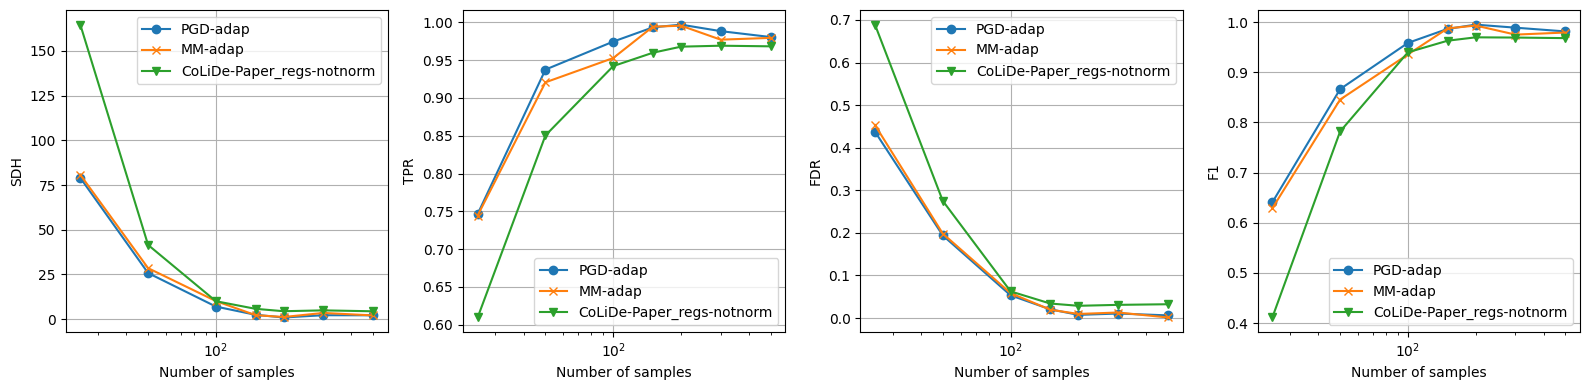

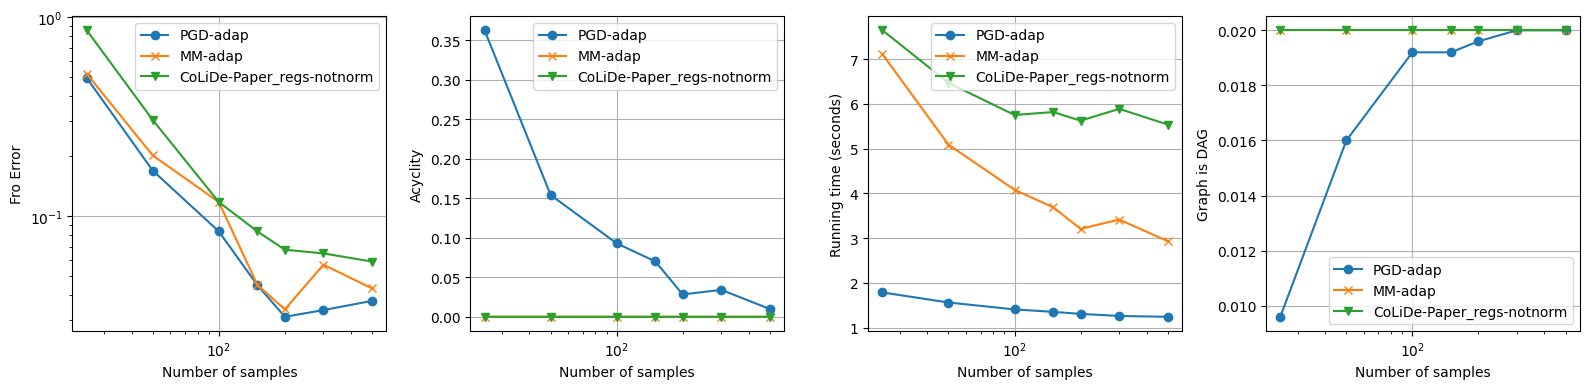

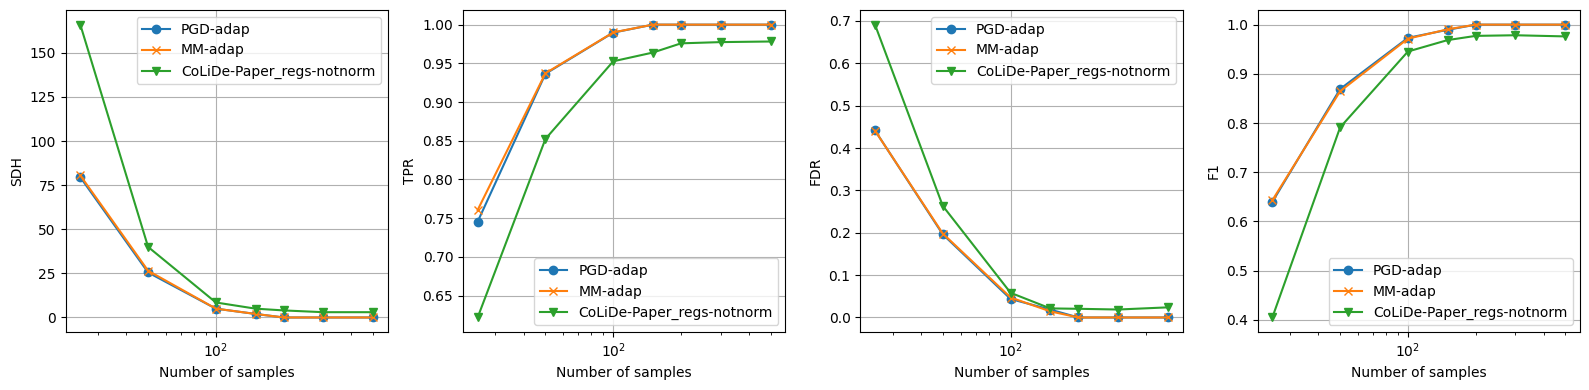

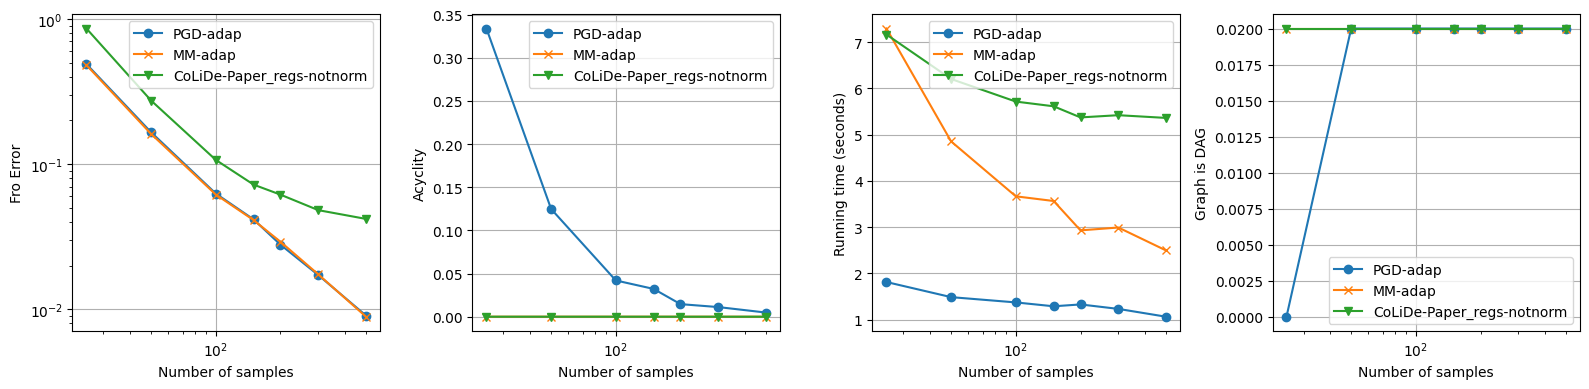

In [5]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


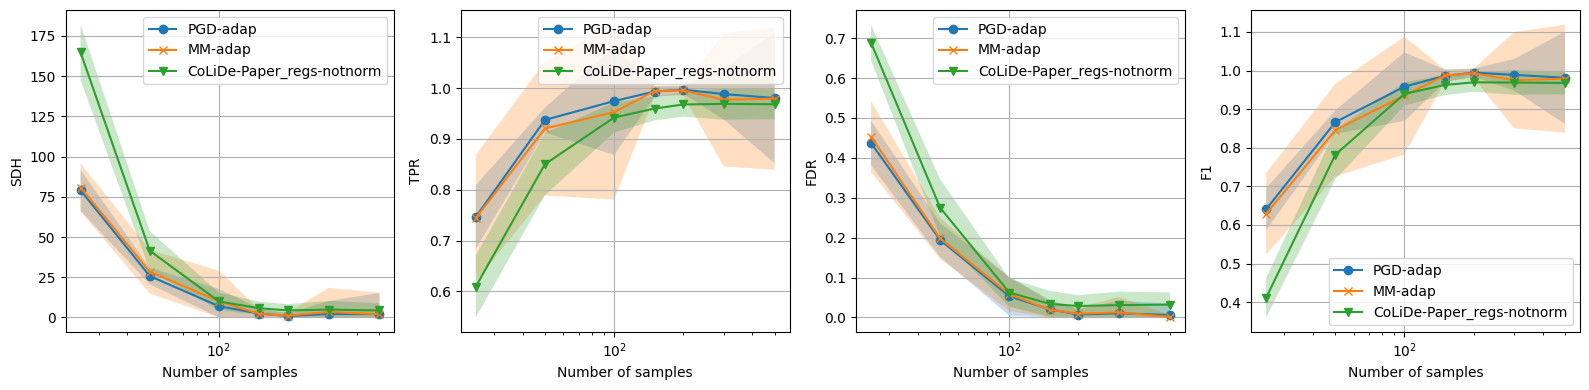

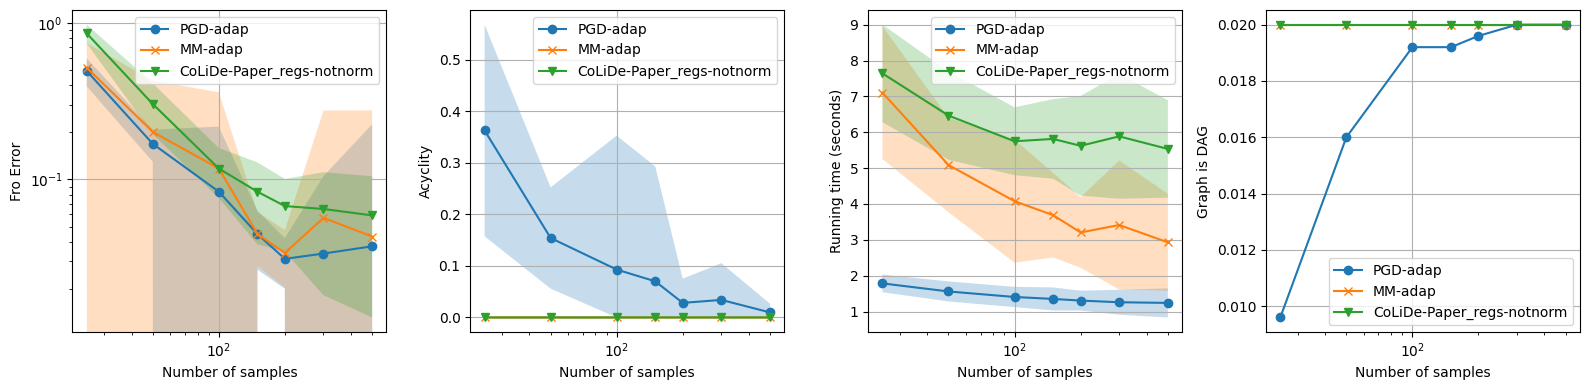

In [6]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

# plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)


### 100 nodes

In [7]:
N_samples = [50, 75, 100, 150, 200, 300, 500] 
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)
dag_count = np.array(dag_count)/n_dags

CPUs employed: 32
Graph: 1, samples: 50
Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 19, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 22, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 27, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 30, samples: 50
Graph: 31, samples: 50
Graph: 32, samples: 50
		-PGD-adap: shd 59.0  -  err: 0.211  -  time: 4.364
		-PGD-adap: shd 71.0  -  err: 0.271  -  time: 4.702
		-PGD-adap: shd 71.0  -  err: 0.253  -  time: 9.704
		-PGD-adap: shd 86.0  -  err: 0.290  -  time: 10.021
		-PGD-adap: shd 49.0  -  err: 0.206  -  t

  9%|▉         | 11729/130000.0 [00:08<01:08, 1726.55it/s]

		-MM-adap: shd 89.0  -  err: 0.320  -  time: 26.085


 33%|███▎      | 43318/130000.0 [00:20<00:17, 4960.31it/s] 

		-MM-adap: shd 75.0  -  err: 0.213  -  time: 37.272


  0%|          | 0/130000.0 [00:00<?, ?it/s] 526.85it/s]s] 

		-MM-adap: shd 57.0  -  err: 0.197  -  time: 40.678


  1%|▏         | 1837/130000.0 [00:03<03:43, 573.84it/s]s]

		-MM-adap: shd 52.0  -  err: 0.189  -  time: 43.803


  0%|          | 49/130000.0 [00:00<04:29, 481.95it/s]s]s]

		-MM-adap: shd 59.0  -  err: 0.210  -  time: 44.819


  0%|          | 153/130000.0 [00:00<04:23, 492.57it/s]]

		-MM-adap: shd 95.0  -  err: 0.293  -  time: 46.417


  0%|          | 0/130000.0 [00:00<?, ?it/s]465.66it/s]]s]

		-MM-adap: shd 70.0  -  err: 0.258  -  time: 52.645


  0%|          | 48/130000.0 [00:00<04:37, 468.69it/s]s]

		-MM-adap: shd 66.0  -  err: 0.245  -  time: 47.259


  1%|          | 1157/130000.0 [00:02<04:22, 490.98it/s]s]

		-MM-adap: shd 78.0  -  err: 0.287  -  time: 48.130


 33%|███▎      | 43480/130000.0 [00:22<00:35, 2421.56it/s]

		-MM-adap: shd 52.0  -  err: 0.184  -  time: 47.898


  0%|          | 0/130000.0 [00:00<?, ?it/s] 479.66it/s]

		-MM-adap: shd 56.0  -  err: 0.203  -  time: 48.659


  0%|          | 200/130000.0 [00:00<04:22, 494.39it/s]]s]

		-MM-adap: shd 85.0  -  err: 0.322  -  time: 48.456


  0%|          | 0/130000.0 [00:00<?, ?it/s]506.15it/s]]s]

		-MM-adap: shd 53.0  -  err: 0.217  -  time: 49.980
		-MM-adap: shd 47.0  -  err: 0.176  -  time: 48.893
		-MM-adap: shd 65.0  -  err: 0.244  -  time: 49.999


  2%|▏         | 2081/130000.0 [00:04<05:24, 394.61it/s]s]

		-MM-adap: shd 64.0  -  err: 0.262  -  time: 51.238
		-MM-adap: shd 68.0  -  err: 0.217  -  time: 49.777


  3%|▎         | 4058/130000.0 [00:06<04:29, 467.81it/s]s]

		-MM-adap: shd 81.0  -  err: 0.247  -  time: 49.737
		-MM-adap: shd 67.0  -  err: 0.223  -  time: 50.540


  1%|          | 801/130000.0 [00:01<05:11, 414.71it/s]]s]

		-MM-adap: shd 65.0  -  err: 0.269  -  time: 50.665


100%|██████████| 130000/130000.0 [00:36<00:00, 3586.74it/s]
  1%|▏         | 1732/130000.0 [00:03<05:09, 414.23it/s]

		-CoLiDe-Paper_regs-notnorm: shd 93.0  -  err: 0.298  -  time: 36.245
Graph: 31, samples: 75


  2%|▏         | 2182/130000.0 [00:04<03:57, 537.99it/s]

		-MM-adap: shd 68.0  -  err: 0.232  -  time: 53.863


  3%|▎         | 3681/130000.0 [00:08<05:46, 365.02it/s]s]

		-MM-adap: shd 49.0  -  err: 0.196  -  time: 55.059


  4%|▍         | 5698/130000.0 [00:11<04:31, 457.38it/s]s]

		-MM-adap: shd 64.0  -  err: 0.234  -  time: 56.549


  3%|▎         | 4010/130000.0 [00:09<05:08, 408.75it/s]

		-PGD-adap: shd 47.0  -  err: 0.177  -  time: 5.260


  6%|▌         | 7598/130000.0 [00:18<06:39, 306.12it/s]s]

		-MM-adap: shd 78.0  -  err: 0.248  -  time: 57.898
		-MM-adap: shd 55.0  -  err: 0.255  -  time: 59.017


  4%|▎         | 4779/130000.0 [00:11<06:12, 336.29it/s]s]

		-MM-adap: shd 55.0  -  err: 0.203  -  time: 59.925


  4%|▍         | 5293/130000.0 [00:10<04:06, 506.57it/s]]

		-MM-adap: shd 79.0  -  err: 0.298  -  time: 60.044


  1%|          | 980/130000.0 [00:02<05:43, 375.31it/s]]]]

		-MM-adap: shd 66.0  -  err: 0.233  -  time: 60.579


  5%|▍         | 6475/130000.0 [00:15<05:34, 369.62it/s]]s]

		-MM-adap: shd 37.0  -  err: 0.190  -  time: 62.482


  4%|▍         | 5525/130000.0 [00:13<05:14, 395.94it/s]]

		-MM-adap: shd 65.0  -  err: 0.247  -  time: 64.388


100%|██████████| 130000/130000.0 [00:39<00:00, 3295.42it/s]
  1%|▏         | 1830/130000.0 [00:05<06:10, 346.12it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 126.0  -  err: 0.465  -  time: 39.449
Graph: 24, samples: 75


  6%|▌         | 7751/130000.0 [00:19<06:00, 339.57it/s]]s]

		-MM-adap: shd 61.0  -  err: 0.257  -  time: 66.715


  3%|▎         | 4116/130000.0 [00:11<07:00, 299.07it/s]]s]

		-PGD-adap: shd 35.0  -  err: 0.145  -  time: 6.930


  7%|▋         | 9115/130000.0 [00:25<05:33, 362.45it/s]]]]

		-MM-adap: shd 31.0  -  err: 0.132  -  time: 26.306


 37%|███▋      | 47628/130000.0 [01:02<03:01, 454.93it/s] ]

		-MM-adap: shd 35.0  -  err: 0.135  -  time: 37.118


100%|██████████| 130000/130000.0 [00:38<00:00, 3404.68it/s]
 24%|██▍       | 31117/130000.0 [01:12<04:43, 349.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 41.0  -  err: 0.191  -  time: 38.184
Graph: 31, samples: 100


100%|██████████| 130000/130000.0 [01:28<00:00, 1466.82it/s]
 26%|██▌       | 33333/130000.0 [01:18<04:44, 339.65it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 114.0  -  err: 0.368  -  time: 88.628
Graph: 8, samples: 75


 26%|██▌       | 33872/130000.0 [01:20<04:09, 384.74it/s]  

		-PGD-adap: shd 27.0  -  err: 0.146  -  time: 7.718


100%|██████████| 130000/130000.0 [01:25<00:00, 1518.67it/s]
 36%|███▌      | 46546/130000.0 [01:10<03:51, 361.12it/s]

		-CoLiDe-Paper_regs-notnorm: shd 106.0  -  err: 0.407  -  time: 85.602
Graph: 19, samples: 75


100%|██████████| 130000/130000.0 [01:22<00:00, 1583.53it/s]
 35%|███▍      | 45388/130000.0 [01:12<02:14, 630.47it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 130.0  -  err: 0.406  -  time: 82.096
Graph: 21, samples: 75


100%|██████████| 130000/130000.0 [01:30<00:00, 1437.77it/s]
 36%|███▌      | 46874/130000.0 [01:17<03:45, 368.01it/s]

		-CoLiDe-Paper_regs-notnorm: shd 121.0  -  err: 0.455  -  time: 90.418
Graph: 22, samples: 75


 49%|████▉     | 64007/130000.0 [01:26<02:47, 393.23it/s] 

		-PGD-adap: shd 32.0  -  err: 0.133  -  time: 5.216


100%|██████████| 130000/130000.0 [01:28<00:00, 1470.08it/s]
 50%|█████     | 65011/130000.0 [01:29<02:31, 428.74it/s]

		-CoLiDe-Paper_regs-notnorm: shd 104.0  -  err: 0.412  -  time: 88.432
Graph: 16, samples: 75


100%|██████████| 130000/130000.0 [01:32<00:00, 1401.81it/s]
 51%|█████     | 65812/130000.0 [01:31<03:21, 319.01it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 93.0  -  err: 0.391  -  time: 92.738
Graph: 29, samples: 75


 50%|████▉     | 64770/130000.0 [01:47<03:23, 320.64it/s]] 

		-PGD-adap: shd 23.0  -  err: 0.105  -  time: 15.754


100%|██████████| 130000/130000.0 [01:38<00:00, 1318.72it/s]
 52%|█████▏    | 67281/130000.0 [01:35<02:26, 426.88it/s]

		-CoLiDe-Paper_regs-notnorm: shd 91.0  -  err: 0.313  -  time: 98.581
Graph: 30, samples: 75


100%|██████████| 130000/130000.0 [01:36<00:00, 1352.26it/s] 
 32%|███▏      | 41922/130000.0 [00:36<00:33, 2620.15it/s]

		-CoLiDe-Paper_regs-notnorm: shd 107.0  -  err: 0.386  -  time: 96.136
Graph: 17, samples: 75


 49%|████▉     | 63923/130000.0 [01:37<01:48, 609.15it/s] ]

		-PGD-adap: shd 29.0  -  err: 0.160  -  time: 15.767


100%|██████████| 130000/130000.0 [01:36<00:00, 1340.30it/s]


		-CoLiDe-Paper_regs-notnorm: shd 107.0  -  err: 0.378  -  time: 96.997
Graph: 20, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 109.0  -  err: 0.340  -  time: 103.534
Graph: 32, samples: 75


100%|██████████| 130000/130000.0 [01:43<00:00, 1255.64it/s]
100%|██████████| 130000/130000.0 [01:37<00:00, 1336.87it/s]
 39%|███▉      | 51171/130000.0 [01:20<02:42, 485.87it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 112.0  -  err: 0.361  -  time: 97.243
Graph: 25, samples: 75


 35%|███▌      | 45761/130000.0 [01:38<03:36, 389.61it/s]]

		-PGD-adap: shd 23.0  -  err: 0.104  -  time: 12.421


100%|██████████| 130000/130000.0 [01:53<00:00, 1148.53it/s]
 52%|█████▏    | 67450/130000.0 [01:41<02:04, 503.01it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 93.0  -  err: 0.353  -  time: 113.189
Graph: 23, samples: 75


 36%|███▌      | 46864/130000.0 [01:40<03:10, 436.40it/s]s]
 51%|█████     | 65679/130000.0 [01:41<02:10, 493.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 121.0  -  err: 0.426  -  time: 103.273
Graph: 10, samples: 75


100%|██████████| 130000/130000.0 [01:35<00:00, 1368.34it/s]
 52%|█████▏    | 67875/130000.0 [01:42<02:23, 432.37it/s]

		-CoLiDe-Paper_regs-notnorm: shd 119.0  -  err: 0.405  -  time: 95.007
Graph: 13, samples: 75


100%|██████████| 130000/130000.0 [01:42<00:00, 1262.51it/s]
 38%|███▊      | 49148/130000.0 [01:38<03:07, 431.57it/s]

		-CoLiDe-Paper_regs-notnorm: shd 92.0  -  err: 0.308  -  time: 102.971
Graph: 6, samples: 75
		-MM-adap: shd 28.0  -  err: 0.164  -  time: 21.919


  0%|          | 437/130000.0 [00:00<02:18, 934.17it/s]s]]

		-PGD-adap: shd 29.0  -  err: 0.139  -  time: 13.623


100%|██████████| 130000/130000.0 [01:33<00:00, 1391.57it/s] 
  3%|▎         | 4104/130000.0 [00:04<02:06, 996.23it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 96.0  -  err: 0.346  -  time: 93.420
Graph: 9, samples: 75
		-PGD-adap: shd 17.0  -  err: 0.095  -  time: 15.538


 49%|████▉     | 64326/130000.0 [01:38<02:12, 495.26it/s]s]

		-PGD-adap: shd 17.0  -  err: 0.100  -  time: 10.963
		-PGD-adap: shd 29.0  -  err: 0.123  -  time: 12.972


 53%|█████▎    | 68717/130000.0 [01:40<02:21, 434.37it/s]] 

		-PGD-adap: shd 27.0  -  err: 0.138  -  time: 13.375


100%|██████████| 130000/130000.0 [01:49<00:00, 1182.31it/s]
  6%|▌         | 7682/130000.0 [00:06<01:23, 1470.37it/s]

		-PGD-adap: shd 35.0  -  err: 0.145  -  time: 12.064
		-CoLiDe-Paper_regs-notnorm: shd 92.0  -  err: 0.342  -  time: 109.955
Graph: 15, samples: 75


100%|██████████| 130000/130000.0 [01:44<00:00, 1244.63it/s]
 37%|███▋      | 47670/130000.0 [01:38<03:19, 412.93it/s]

		-CoLiDe-Paper_regs-notnorm: shd 114.0  -  err: 0.460  -  time: 104.449
Graph: 4, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 88.0  -  err: 0.362  -  time: 100.942
Graph: 18, samples: 75
		-MM-adap: shd 30.0  -  err: 0.125  -  time: 23.421


100%|██████████| 130000/130000.0 [01:40<00:00, 1287.89it/s]
100%|██████████| 130000/130000.0 [01:53<00:00, 1144.87it/s]  
 48%|████▊     | 62248/130000.0 [01:41<00:48, 1392.98it/s]

		-CoLiDe-Paper_regs-notnorm: shd 114.0  -  err: 0.372  -  time: 113.551
Graph: 26, samples: 75


100%|██████████| 130000/130000.0 [01:40<00:00, 1287.99it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 124.0  -  err: 0.457  -  time: 100.933
Graph: 28, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 115.0  -  err: 0.421  -  time: 111.326
Graph: 14, samples: 75


100%|██████████| 130000/130000.0 [01:51<00:00, 1167.75it/s] 
 51%|█████     | 66163/130000.0 [01:42<02:03, 516.04it/s]]

		-PGD-adap: shd 20.0  -  err: 0.102  -  time: 14.621


100%|██████████| 130000/130000.0 [01:54<00:00, 1139.09it/s]


		-CoLiDe-Paper_regs-notnorm: shd 127.0  -  err: 0.449  -  time: 114.127
Graph: 1, samples: 75


 50%|████▉     | 64762/130000.0 [01:45<01:24, 775.67it/s] 

		-PGD-adap: shd 31.0  -  err: 0.165  -  time: 13.410
		-PGD-adap: shd 33.0  -  err: 0.159  -  time: 12.234


100%|██████████| 130000/130000.0 [00:55<00:00, 2341.07it/s] 
 38%|███▊      | 49844/130000.0 [01:43<02:50, 470.86it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.205  -  time: 55.531
Graph: 24, samples: 100
		-PGD-adap: shd 24.0  -  err: 0.128  -  time: 13.500


 51%|█████     | 65827/130000.0 [01:46<01:20, 795.67it/s]] 

		-PGD-adap: shd 30.0  -  err: 0.128  -  time: 13.474


100%|██████████| 130000/130000.0 [01:48<00:00, 1203.57it/s]
 39%|███▉      | 51235/130000.0 [01:46<03:15, 403.35it/s]

		-PGD-adap: shd 42.0  -  err: 0.192  -  time: 11.193
		-CoLiDe-Paper_regs-notnorm: shd 97.0  -  err: 0.317  -  time: 108.014
Graph: 27, samples: 75


 53%|█████▎    | 68760/130000.0 [01:51<01:44, 585.05it/s]]

		-PGD-adap: shd 13.0  -  err: 0.099  -  time: 5.086


100%|██████████| 130000/130000.0 [01:56<00:00, 1116.63it/s]
100%|██████████| 130000/130000.0 [01:51<00:00, 1166.18it/s]


		-CoLiDe-Paper_regs-notnorm: shd 108.0  -  err: 0.371  -  time: 116.423
Graph: 5, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 156.0  -  err: 0.542  -  time: 111.476
Graph: 7, samples: 75


100%|██████████| 130000/130000.0 [01:43<00:00, 1256.10it/s]


		-CoLiDe-Paper_regs-notnorm: shd 91.0  -  err: 0.358  -  time: 103.496
Graph: 3, samples: 75


 41%|████      | 52854/130000.0 [01:49<02:21, 545.42it/s]

		-PGD-adap: shd 25.0  -  err: 0.121  -  time: 10.429


 50%|████▉     | 64706/130000.0 [01:47<01:27, 747.47it/s]s]

		-PGD-adap: shd 29.0  -  err: 0.137  -  time: 12.294
		-PGD-adap: shd 20.0  -  err: 0.101  -  time: 12.005
		-PGD-adap: shd 20.0  -  err: 0.133  -  time: 10.122


100%|██████████| 130000/130000.0 [02:01<00:00, 1068.06it/s]
 41%|████      | 53193/130000.0 [01:50<03:17, 389.63it/s]

		-CoLiDe-Paper_regs-notnorm: shd 124.0  -  err: 0.403  -  time: 121.718
Graph: 11, samples: 75


 34%|███▎      | 43644/130000.0 [00:20<00:18, 4761.32it/s] 

		-PGD-adap: shd 27.0  -  err: 0.115  -  time: 12.424


 41%|████▏     | 53792/130000.0 [01:52<02:27, 516.94it/s]]

		-PGD-adap: shd 30.0  -  err: 0.109  -  time: 11.529


 42%|████▏     | 54010/130000.0 [01:52<02:27, 514.37it/s]

		-PGD-adap: shd 30.0  -  err: 0.143  -  time: 10.984


 46%|████▌     | 60026/130000.0 [01:54<00:04, 14265.05it/s]

		-PGD-adap: shd 29.0  -  err: 0.157  -  time: 5.441


100%|██████████| 130000/130000.0 [00:24<00:00, 5296.70it/s] 
 52%|█████▏    | 67418/130000.0 [01:52<01:50, 567.63it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.092  -  time: 24.544
Graph: 31, samples: 150


 52%|█████▏    | 67825/130000.0 [01:53<01:48, 572.89it/s]]

		-PGD-adap: shd 32.0  -  err: 0.126  -  time: 10.042


100%|██████████| 130000/130000.0 [01:55<00:00, 1124.13it/s]  


		-CoLiDe-Paper_regs-notnorm: shd 101.0  -  err: 0.319  -  time: 115.646
Graph: 2, samples: 75


 48%|████▊     | 62642/130000.0 [01:59<00:58, 1152.35it/s]

		-PGD-adap: shd 24.0  -  err: 0.120  -  time: 10.842
		-PGD-adap: shd 4.0  -  err: 0.048  -  time: 4.417
		-MM-adap: shd 30.0  -  err: 0.144  -  time: 36.835


  0%|          | 404/130000.0 [00:00<03:53, 555.15it/s]s] 

		-PGD-adap: shd 21.0  -  err: 0.100  -  time: 11.260


  1%|          | 1100/130000.0 [00:01<03:45, 570.66it/s]]]

		-PGD-adap: shd 29.0  -  err: 0.120  -  time: 11.362


100%|██████████| 130000/130000.0 [02:06<00:00, 1026.56it/s]


		-CoLiDe-Paper_regs-notnorm: shd 160.0  -  err: 0.563  -  time: 126.637
Graph: 12, samples: 75


  4%|▎         | 4592/130000.0 [00:08<03:42, 563.32it/s]s]

		-MM-adap: shd 24.0  -  err: 0.108  -  time: 41.144


  4%|▎         | 4841/130000.0 [00:08<03:27, 604.44it/s]s]

		-MM-adap: shd 21.0  -  err: 0.105  -  time: 37.072
		-PGD-adap: shd 35.0  -  err: 0.144  -  time: 9.976


  1%|          | 755/130000.0 [00:01<03:34, 601.82it/s]]

		-MM-adap: shd 33.0  -  err: 0.165  -  time: 19.502


  0%|          | 66/130000.0 [00:00<03:20, 649.25it/s]s]s]

		-MM-adap: shd 11.0  -  err: 0.090  -  time: 24.263


  0%|          | 0/130000.0 [00:00<?, ?it/s] 585.89it/s]s]

		-MM-adap: shd 22.0  -  err: 0.136  -  time: 23.400


  3%|▎         | 3293/130000.0 [00:05<03:49, 552.72it/s]s]

		-MM-adap: shd 18.0  -  err: 0.098  -  time: 37.527
		-MM-adap: shd 30.0  -  err: 0.161  -  time: 49.009


100%|██████████| 130000/130000.0 [00:36<00:00, 3562.64it/s]
  0%|          | 425/130000.0 [00:00<04:52, 442.49it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 53.0  -  err: 0.256  -  time: 36.491
Graph: 21, samples: 100


  3%|▎         | 3791/130000.0 [00:06<04:11, 502.37it/s]

		-MM-adap: shd 27.0  -  err: 0.127  -  time: 38.732


  1%|          | 1315/130000.0 [00:02<04:50, 442.78it/s]

		-PGD-adap: shd 22.0  -  err: 0.122  -  time: 10.339


  2%|▏         | 1997/130000.0 [00:04<04:56, 431.93it/s]

		-MM-adap: shd 4.0  -  err: 0.049  -  time: 18.263


  1%|          | 1609/130000.0 [00:03<05:23, 396.88it/s]

		-PGD-adap: shd 16.0  -  err: 0.102  -  time: 4.332


  2%|▏         | 3218/130000.0 [00:06<04:50, 435.95it/s]

		-MM-adap: shd 33.0  -  err: 0.132  -  time: 42.924


  3%|▎         | 3444/130000.0 [00:07<04:57, 425.22it/s]s] 

		-MM-adap: shd 18.0  -  err: 0.089  -  time: 40.980


  3%|▎         | 3750/130000.0 [00:07<05:04, 415.13it/s]/s]

		-MM-adap: shd 29.0  -  err: 0.127  -  time: 46.851


  4%|▍         | 5243/130000.0 [00:11<04:42, 441.23it/s]/s]

		-MM-adap: shd 30.0  -  err: 0.128  -  time: 40.980


  1%|          | 875/130000.0 [00:02<05:14, 410.40it/s]s]]

		-MM-adap: shd 30.0  -  err: 0.116  -  time: 36.531


  0%|          | 381/130000.0 [00:00<04:42, 458.18it/s]]]

		-MM-adap: shd 21.0  -  err: 0.091  -  time: 53.011


  2%|▏         | 2051/130000.0 [00:05<06:00, 355.22it/s]]] 

		-MM-adap: shd 39.0  -  err: 0.180  -  time: 42.286


  3%|▎         | 4307/130000.0 [00:07<03:29, 599.46it/s]]] 

		-MM-adap: shd 35.0  -  err: 0.155  -  time: 46.225


  2%|▏         | 2534/130000.0 [00:06<05:54, 359.34it/s]]s]

		-MM-adap: shd 23.0  -  err: 0.114  -  time: 40.286


  4%|▍         | 5155/130000.0 [00:10<05:05, 408.62it/s]] 

		-MM-adap: shd 29.0  -  err: 0.147  -  time: 36.725


  7%|▋         | 8932/130000.0 [00:21<04:19, 466.91it/s]]] 

		-MM-adap: shd 21.0  -  err: 0.105  -  time: 34.449


  0%|          | 0/130000.0 [00:00<?, ?it/s] 393.36it/s]]s]

		-MM-adap: shd 25.0  -  err: 0.127  -  time: 52.188
		-MM-adap: shd 30.0  -  err: 0.111  -  time: 43.653


  2%|▏         | 3107/130000.0 [00:07<06:02, 349.89it/s]]]]

		-MM-adap: shd 32.0  -  err: 0.136  -  time: 43.420


  3%|▎         | 3799/130000.0 [00:09<05:52, 358.19it/s]] 

		-MM-adap: shd 31.0  -  err: 0.112  -  time: 40.295
		-MM-adap: shd 13.0  -  err: 0.083  -  time: 17.670


  1%|          | 1509/130000.0 [00:03<05:48, 368.58it/s]]] 

		-MM-adap: shd 24.0  -  err: 0.129  -  time: 56.339


  2%|▏         | 3173/130000.0 [00:08<05:33, 380.71it/s]]  

		-MM-adap: shd 24.0  -  err: 0.111  -  time: 45.178


  6%|▌         | 8052/130000.0 [00:20<05:01, 403.81it/s]]  

		-MM-adap: shd 30.0  -  err: 0.125  -  time: 46.814


 12%|█▏        | 14995/130000.0 [00:30<04:22, 438.12it/s]] 

		-MM-adap: shd 24.0  -  err: 0.109  -  time: 62.081


 12%|█▏        | 14962/130000.0 [00:41<05:41, 337.22it/s]s]

		-MM-adap: shd 34.0  -  err: 0.146  -  time: 56.677


100%|██████████| 130000/130000.0 [00:56<00:00, 2319.82it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.107  -  time: 56.040
Graph: 24, samples: 150


100%|██████████| 130000/130000.0 [01:11<00:00, 1829.77it/s]


		-CoLiDe-Paper_regs-notnorm: shd 63.0  -  err: 0.277  -  time: 71.048
Graph: 8, samples: 100


 36%|███▋      | 47424/130000.0 [01:01<03:51, 356.76it/s]] 

		-PGD-adap: shd 8.0  -  err: 0.049  -  time: 7.117


100%|██████████| 130000/130000.0 [01:03<00:00, 2061.60it/s]
 21%|██▏       | 27915/130000.0 [00:41<02:34, 660.36it/s]

		-CoLiDe-Paper_regs-notnorm: shd 36.0  -  err: 0.210  -  time: 63.059
Graph: 28, samples: 100


100%|██████████| 130000/130000.0 [01:10<00:00, 1846.83it/s] 
 35%|███▍      | 44967/130000.0 [00:43<03:08, 450.24it/s]

		-CoLiDe-Paper_regs-notnorm: shd 33.0  -  err: 0.165  -  time: 70.392
Graph: 16, samples: 100


  9%|▉         | 12293/130000.0 [00:32<06:06, 320.84it/s]] 

		-PGD-adap: shd 16.0  -  err: 0.093  -  time: 13.564


  0%|          | 0/130000.0 [00:00<?, ?it/s], 418.84it/s]]]

		-MM-adap: shd 25.0  -  err: 0.127  -  time: 68.371


100%|██████████| 130000/130000.0 [01:13<00:00, 1765.74it/s]
100%|██████████| 130000/130000.0 [01:07<00:00, 1938.17it/s]


		-CoLiDe-Paper_regs-notnorm: shd 46.0  -  err: 0.248  -  time: 73.624
Graph: 20, samples: 100
		-CoLiDe-Paper_regs-notnorm: shd 21.0  -  err: 0.125  -  time: 67.075
Graph: 32, samples: 100


100%|██████████| 130000/130000.0 [01:13<00:00, 1773.46it/s]
  7%|▋         | 8986/130000.0 [00:24<05:34, 361.38it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 34.0  -  err: 0.190  -  time: 73.304
Graph: 17, samples: 100


 34%|███▍      | 44445/130000.0 [01:03<03:58, 358.86it/s] 

		-PGD-adap: shd 21.0  -  err: 0.095  -  time: 14.195


100%|██████████| 130000/130000.0 [01:12<00:00, 1780.89it/s] 
 49%|████▉     | 64079/130000.0 [00:54<01:21, 804.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.051  -  time: 72.998
Graph: 31, samples: 200


100%|██████████| 130000/130000.0 [00:55<00:00, 2334.92it/s]
 36%|███▌      | 46336/130000.0 [00:57<04:01, 345.87it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.064  -  time: 55.677
Graph: 21, samples: 150


 33%|███▎      | 43367/130000.0 [00:56<03:13, 447.95it/s]s]

		-PGD-adap: shd 13.0  -  err: 0.094  -  time: 14.722


100%|██████████| 130000/130000.0 [01:21<00:00, 1600.68it/s]
 24%|██▍       | 31589/130000.0 [00:56<03:58, 412.04it/s]

		-CoLiDe-Paper_regs-notnorm: shd 30.0  -  err: 0.194  -  time: 81.216
Graph: 19, samples: 100


 36%|███▌      | 46758/130000.0 [01:09<03:31, 394.02it/s]] 

		-MM-adap: shd 9.0  -  err: 0.061  -  time: 21.348


 37%|███▋      | 48180/130000.0 [01:03<03:38, 373.85it/s]]]

		-PGD-adap: shd 6.0  -  err: 0.054  -  time: 5.831


 36%|███▌      | 46344/130000.0 [00:56<04:07, 337.50it/s]]]

		-PGD-adap: shd 11.0  -  err: 0.071  -  time: 13.630


  2%|▏         | 2040/130000.0 [00:05<04:55, 433.75it/s]]

		-PGD-adap: shd 26.0  -  err: 0.107  -  time: 14.436


100%|██████████| 130000/130000.0 [01:32<00:00, 1400.47it/s]
 26%|██▌       | 33539/130000.0 [01:11<04:06, 391.48it/s]

		-PGD-adap: shd 12.0  -  err: 0.097  -  time: 12.831
		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.204  -  time: 92.827
Graph: 15, samples: 100


  5%|▌         | 6669/130000.0 [00:18<04:50, 425.01it/s]]s]

		-PGD-adap: shd 2.0  -  err: 0.043  -  time: 12.298


100%|██████████| 130000/130000.0 [01:22<00:00, 1576.96it/s]
 36%|███▌      | 47123/130000.0 [01:07<04:20, 317.56it/s]  

		-CoLiDe-Paper_regs-notnorm: shd 26.0  -  err: 0.195  -  time: 82.438
Graph: 25, samples: 100


100%|██████████| 130000/130000.0 [01:08<00:00, 1893.68it/s]
 36%|███▋      | 47319/130000.0 [01:07<04:15, 323.58it/s]

		-CoLiDe-Paper_regs-notnorm: shd 52.0  -  err: 0.260  -  time: 68.651
Graph: 1, samples: 100


  7%|▋         | 8875/130000.0 [00:24<06:24, 314.63it/s]s]]

		-PGD-adap: shd 12.0  -  err: 0.089  -  time: 14.489


100%|██████████| 130000/130000.0 [01:23<00:00, 1560.02it/s]
 38%|███▊      | 49844/130000.0 [01:14<03:02, 440.06it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.177  -  time: 83.333
Graph: 18, samples: 100


100%|██████████| 130000/130000.0 [01:46<00:00, 1217.62it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 28.0  -  err: 0.138  -  time: 106.766
Graph: 22, samples: 100
		-MM-adap: shd 4.0  -  err: 0.048  -  time: 16.544


100%|██████████| 130000/130000.0 [01:25<00:00, 1517.26it/s]


		-CoLiDe-Paper_regs-notnorm: shd 40.0  -  err: 0.176  -  time: 85.682
Graph: 26, samples: 100
		-PGD-adap: shd 19.0  -  err: 0.096  -  time: 11.360


100%|██████████| 130000/130000.0 [01:07<00:00, 1927.15it/s]
  1%|          | 1013/130000.0 [00:01<03:07, 686.83it/s]/s]

		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.166  -  time: 67.458
Graph: 11, samples: 100


  6%|▋         | 8259/130000.0 [00:19<05:13, 388.21it/s]s]

		-PGD-adap: shd 13.0  -  err: 0.077  -  time: 14.062


100%|██████████| 130000/130000.0 [01:27<00:00, 1479.83it/s]
  1%|          | 1558/130000.0 [00:01<02:54, 737.16it/s]

		-CoLiDe-Paper_regs-notnorm: shd 29.0  -  err: 0.192  -  time: 87.849
Graph: 13, samples: 100


  2%|▏         | 2072/130000.0 [00:02<02:40, 795.04it/s]]]

		-PGD-adap: shd 19.0  -  err: 0.094  -  time: 13.615


100%|██████████| 130000/130000.0 [01:29<00:00, 1454.28it/s]
  2%|▏         | 2432/130000.0 [00:03<02:42, 785.38it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 45.0  -  err: 0.211  -  time: 89.393
Graph: 9, samples: 100


100%|██████████| 130000/130000.0 [01:24<00:00, 1539.34it/s]
  3%|▎         | 4074/130000.0 [00:05<02:15, 928.34it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.162  -  time: 84.453
Graph: 14, samples: 100


100%|██████████| 130000/130000.0 [01:27<00:00, 1482.90it/s]
  5%|▍         | 6411/130000.0 [00:07<02:27, 837.57it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.179  -  time: 87.667
Graph: 3, samples: 100


 52%|█████▏    | 67437/130000.0 [01:36<02:09, 482.36it/s]] 

		-PGD-adap: shd 17.0  -  err: 0.083  -  time: 13.696


 50%|████▉     | 64791/130000.0 [01:30<01:39, 656.71it/s] 

		-MM-adap: shd 12.0  -  err: 0.082  -  time: 40.763


 50%|█████     | 65374/130000.0 [01:31<01:30, 714.53it/s]]]

		-PGD-adap: shd 22.0  -  err: 0.120  -  time: 12.821


  1%|          | 1614/130000.0 [00:03<04:00, 534.54it/s]]

		-PGD-adap: shd 23.0  -  err: 0.121  -  time: 12.440
		-CoLiDe-Paper_regs-notnorm: shd 32.0  -  err: 0.153  -  time: 63.683
Graph: 2, samples: 100


100%|██████████| 130000/130000.0 [01:03<00:00, 2041.37it/s] 
100%|██████████| 130000/130000.0 [01:24<00:00, 1540.71it/s] 
 51%|█████     | 66088/130000.0 [01:45<03:25, 311.46it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 29.0  -  err: 0.146  -  time: 84.378
Graph: 5, samples: 100


 51%|█████     | 66321/130000.0 [01:46<02:58, 356.26it/s] 

		-PGD-adap: shd 20.0  -  err: 0.116  -  time: 12.936
		-PGD-adap: shd 19.0  -  err: 0.103  -  time: 14.234
		-PGD-adap: shd 15.0  -  err: 0.094  -  time: 12.005


100%|██████████| 130000/130000.0 [01:35<00:00, 1364.06it/s]  
 54%|█████▍    | 70373/130000.0 [01:42<02:04, 480.48it/s]

		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.219  -  time: 95.305
Graph: 10, samples: 100


100%|██████████| 130000/130000.0 [01:43<00:00, 1251.97it/s]
 52%|█████▏    | 67337/130000.0 [01:35<02:03, 505.41it/s]

		-CoLiDe-Paper_regs-notnorm: shd 22.0  -  err: 0.139  -  time: 103.838
Graph: 29, samples: 100


 51%|█████▏    | 66868/130000.0 [01:47<01:41, 624.07it/s]]

		-PGD-adap: shd 8.0  -  err: 0.068  -  time: 12.528


 52%|█████▏    | 67826/130000.0 [01:36<02:17, 453.45it/s]

		-PGD-adap: shd 11.0  -  err: 0.070  -  time: 4.205


100%|██████████| 130000/130000.0 [01:50<00:00, 1177.63it/s]


		-CoLiDe-Paper_regs-notnorm: shd 48.0  -  err: 0.221  -  time: 110.393
Graph: 30, samples: 100


 52%|█████▏    | 68067/130000.0 [01:49<01:54, 541.81it/s]]

		-PGD-adap: shd 11.0  -  err: 0.077  -  time: 12.347


100%|██████████| 130000/130000.0 [01:51<00:00, 1162.75it/s]


		-CoLiDe-Paper_regs-notnorm: shd 35.0  -  err: 0.170  -  time: 111.805
Graph: 6, samples: 100


100%|██████████| 130000/130000.0 [01:38<00:00, 1323.01it/s]
 54%|█████▍    | 70208/130000.0 [01:40<01:57, 508.86it/s]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.198  -  time: 98.262
Graph: 23, samples: 100


 55%|█████▍    | 71343/130000.0 [01:43<01:51, 527.71it/s]]

		-PGD-adap: shd 13.0  -  err: 0.076  -  time: 10.700


 35%|███▌      | 45621/130000.0 [00:25<01:01, 1371.78it/s]

		-MM-adap: shd 20.0  -  err: 0.085  -  time: 49.074


 53%|█████▎    | 69473/130000.0 [01:29<01:45, 575.13it/s]s]

		-PGD-adap: shd 13.0  -  err: 0.078  -  time: 10.709
		-MM-adap: shd 12.0  -  err: 0.096  -  time: 48.086


100%|██████████| 130000/130000.0 [01:30<00:00, 1442.60it/s]
  1%|          | 1470/130000.0 [00:02<03:15, 658.75it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 65.0  -  err: 0.244  -  time: 90.117
Graph: 4, samples: 100


 56%|█████▌    | 73033/130000.0 [01:46<01:30, 626.92it/s]

		-MM-adap: shd 12.0  -  err: 0.069  -  time: 26.125


  2%|▏         | 2281/130000.0 [00:02<02:17, 926.15it/s]]] 

		-PGD-adap: shd 12.0  -  err: 0.060  -  time: 11.772


100%|██████████| 130000/130000.0 [01:54<00:00, 1131.11it/s]
  2%|▏         | 3036/130000.0 [00:03<02:08, 987.16it/s]

		-MM-adap: shd 0.0  -  err: 0.031  -  time: 42.268
		-PGD-adap: shd 13.0  -  err: 0.096  -  time: 11.966
		-CoLiDe-Paper_regs-notnorm: shd 41.0  -  err: 0.202  -  time: 114.932
Graph: 7, samples: 100


  0%|          | 0/130000.0 [00:00<?, ?it/s] 564.28it/s]]] 

		-MM-adap: shd 11.0  -  err: 0.082  -  time: 38.379
		-MM-adap: shd 10.0  -  err: 0.068  -  time: 47.071


 59%|█████▉    | 76569/130000.0 [01:52<01:41, 528.39it/s] 

		-PGD-adap: shd 16.0  -  err: 0.087  -  time: 11.855


  1%|          | 895/130000.0 [00:01<04:30, 477.33it/s]]]]

		-PGD-adap: shd 9.0  -  err: 0.075  -  time: 12.581


 34%|███▍      | 44641/130000.0 [00:53<02:36, 546.94it/s]

		-MM-adap: shd 10.0  -  err: 0.064  -  time: 17.373


  5%|▌         | 6705/130000.0 [00:09<03:56, 521.31it/s]]]]

		-MM-adap: shd 20.0  -  err: 0.093  -  time: 36.805
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.081  -  time: 37.896
Graph: 21, samples: 200


100%|██████████| 130000/130000.0 [00:37<00:00, 3430.55it/s]
  3%|▎         | 3621/130000.0 [00:07<04:57, 424.73it/s]]]

		-PGD-adap: shd 13.0  -  err: 0.081  -  time: 11.014
		-CoLiDe-Paper_regs-notnorm: shd 34.0  -  err: 0.170  -  time: 116.886
Graph: 27, samples: 100


100%|██████████| 130000/130000.0 [01:56<00:00, 1112.20it/s]
  0%|          | 53/130000.0 [00:00<04:07, 526.07it/s]s]] 

		-MM-adap: shd 15.0  -  err: 0.100  -  time: 52.879
		-MM-adap: shd 23.0  -  err: 0.106  -  time: 53.250


  4%|▎         | 4563/130000.0 [00:05<02:55, 714.67it/s]]]

		-MM-adap: shd 19.0  -  err: 0.103  -  time: 28.353


  3%|▎         | 4527/130000.0 [00:08<03:11, 654.83it/s]/s]

		-PGD-adap: shd 11.0  -  err: 0.070  -  time: 10.725


  5%|▍         | 6155/130000.0 [00:14<04:33, 452.46it/s]]] 

		-PGD-adap: shd 1.0  -  err: 0.031  -  time: 9.692


100%|██████████| 130000/130000.0 [01:07<00:00, 1937.11it/s] 
  4%|▎         | 4551/130000.0 [00:09<04:17, 487.76it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.106  -  time: 67.112
Graph: 24, samples: 200


 31%|███       | 40000/130000.0 [00:25<00:35, 2500.09it/s]]

		-MM-adap: shd 20.0  -  err: 0.099  -  time: 35.983
		-PGD-adap: shd 21.0  -  err: 0.118  -  time: 12.388


  0%|          | 46/130000.0 [00:00<04:49, 449.44it/s]s]]

		-MM-adap: shd 18.0  -  err: 0.113  -  time: 36.463


  7%|▋         | 8571/130000.0 [00:10<02:25, 834.25it/s]]s]

		-MM-adap: shd 19.0  -  err: 0.095  -  time: 49.160


  6%|▌         | 7620/130000.0 [00:15<04:00, 508.37it/s]]]

		-MM-adap: shd 10.0  -  err: 0.078  -  time: 32.667


100%|██████████| 130000/130000.0 [01:24<00:00, 1545.28it/s]
  8%|▊         | 10806/130000.0 [00:13<02:05, 949.60it/s]

		-MM-adap: shd 14.0  -  err: 0.086  -  time: 40.531
		-CoLiDe-Paper_regs-notnorm: shd 44.0  -  err: 0.208  -  time: 84.128
Graph: 12, samples: 100


  1%|▏         | 1774/130000.0 [00:03<04:06, 519.49it/s]]  

		-MM-adap: shd 13.0  -  err: 0.093  -  time: 43.101


  0%|          | 444/130000.0 [00:01<05:04, 425.09it/s]]]] 

		-PGD-adap: shd 3.0  -  err: 0.029  -  time: 9.932
		-MM-adap: shd 6.0  -  err: 0.057  -  time: 41.707


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1417.87it/s]]

		-MM-adap: shd 17.0  -  err: 0.087  -  time: 52.870


 36%|███▋      | 47305/130000.0 [00:40<02:29, 551.96it/s]] 

		-PGD-adap: shd 10.0  -  err: 0.073  -  time: 13.136


  7%|▋         | 9015/130000.0 [00:21<05:16, 382.05it/s]]] 

		-MM-adap: shd 13.0  -  err: 0.081  -  time: 46.544


  0%|          | 0/130000.0 [00:00<?, ?it/s] 367.95it/s]]]]

		-MM-adap: shd 13.0  -  err: 0.077  -  time: 49.986


100%|██████████| 130000/130000.0 [00:53<00:00, 2439.63it/s]
 38%|███▊      | 49148/130000.0 [00:38<03:10, 424.17it/s]

		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.122  -  time: 53.289
Graph: 16, samples: 150


  8%|▊         | 9938/130000.0 [00:23<05:29, 364.92it/s]] ]

		-MM-adap: shd 10.0  -  err: 0.081  -  time: 51.369


  3%|▎         | 4430/130000.0 [00:07<02:49, 739.09it/s]]]

		-MM-adap: shd 13.0  -  err: 0.061  -  time: 53.816


100%|██████████| 130000/130000.0 [00:58<00:00, 2222.46it/s]
 13%|█▎        | 16527/130000.0 [00:43<06:15, 302.07it/s]

		-CoLiDe-Paper_regs-notnorm: shd 22.0  -  err: 0.131  -  time: 58.496
Graph: 28, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.058  -  time: 52.859
Graph: 31, samples: 300


100%|██████████| 130000/130000.0 [00:52<00:00, 2459.59it/s]
100%|██████████| 130000/130000.0 [01:13<00:00, 1764.98it/s]
 51%|█████     | 66279/130000.0 [00:48<01:22, 769.84it/s]

		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.169  -  time: 73.656
Graph: 8, samples: 150


  8%|▊         | 10319/130000.0 [00:26<05:39, 352.29it/s]] 

		-MM-adap: shd 10.0  -  err: 0.061  -  time: 46.020


  8%|▊         | 10499/130000.0 [00:26<04:33, 436.92it/s] 

		-MM-adap: shd 12.0  -  err: 0.065  -  time: 50.940


  1%|          | 657/130000.0 [00:01<04:14, 507.94it/s]]] ]

		-MM-adap: shd 0.0  -  err: 0.027  -  time: 38.193


  0%|          | 427/130000.0 [00:01<06:02, 357.03it/s]s]]]

		-MM-adap: shd 8.0  -  err: 0.069  -  time: 51.801


100%|██████████| 130000/130000.0 [00:55<00:00, 2348.18it/s]
 37%|███▋      | 47490/130000.0 [00:36<01:47, 768.62it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.117  -  time: 55.363
Graph: 32, samples: 150
		-MM-adap: shd 8.0  -  err: 0.061  -  time: 47.227


100%|██████████| 130000/130000.0 [00:54<00:00, 2392.89it/s]
 14%|█▍        | 18730/130000.0 [00:49<05:16, 351.74it/s]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.116  -  time: 54.329
Graph: 2, samples: 150


  2%|▏         | 2839/130000.0 [00:06<04:58, 426.19it/s]]] 

		-PGD-adap: shd 6.0  -  err: 0.058  -  time: 11.013


  0%|          | 0/130000.0 [00:00<?, ?it/s] 354.44it/s]]] 

		-MM-adap: shd 2.0  -  err: 0.025  -  time: 34.392


 50%|████▉     | 64636/130000.0 [01:08<03:14, 336.19it/s]s]

		-PGD-adap: shd 4.0  -  err: 0.052  -  time: 6.028


 50%|████▉     | 64789/130000.0 [01:08<02:59, 363.03it/s]]

		-PGD-adap: shd 5.0  -  err: 0.051  -  time: 12.500


 31%|███▏      | 40915/130000.0 [00:45<00:40, 2175.94it/s]

		-PGD-adap: shd 1.0  -  err: 0.021  -  time: 12.954


 17%|█▋        | 21738/130000.0 [00:57<04:43, 381.59it/s]]

		-PGD-adap: shd 4.0  -  err: 0.040  -  time: 13.937


100%|██████████| 130000/130000.0 [00:57<00:00, 2249.46it/s] 
  2%|▏         | 2886/130000.0 [00:05<03:39, 579.73it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 25.0  -  err: 0.150  -  time: 57.792
Graph: 22, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.115  -  time: 71.362
Graph: 15, samples: 150


100%|██████████| 130000/130000.0 [01:11<00:00, 1821.71it/s]
100%|██████████| 130000/130000.0 [01:02<00:00, 2093.41it/s]
  7%|▋         | 8608/130000.0 [00:17<04:02, 500.80it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.116  -  time: 62.101
Graph: 1, samples: 150


  5%|▍         | 6076/130000.0 [00:13<03:59, 517.06it/s]s]

		-MM-adap: shd 19.0  -  err: 0.105  -  time: 51.028


  6%|▌         | 7219/130000.0 [00:16<04:08, 493.32it/s]]] 

		-PGD-adap: shd 5.0  -  err: 0.047  -  time: 14.716


100%|██████████| 130000/130000.0 [01:03<00:00, 2032.95it/s]
  5%|▌         | 7103/130000.0 [00:18<05:08, 398.09it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.110  -  time: 63.948
Graph: 17, samples: 150


100%|██████████| 130000/130000.0 [00:51<00:00, 2504.10it/s] 
 34%|███▍      | 44437/130000.0 [00:53<02:55, 488.64it/s]

		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.118  -  time: 51.916
Graph: 3, samples: 150


100%|██████████| 130000/130000.0 [00:57<00:00, 2271.57it/s]
 15%|█▌        | 20137/130000.0 [00:50<03:56, 465.36it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 34.0  -  err: 0.202  -  time: 57.231
Graph: 13, samples: 150


  7%|▋         | 9633/130000.0 [00:24<04:34, 438.64it/s]]s]

		-PGD-adap: shd 4.0  -  err: 0.052  -  time: 10.882


  4%|▍         | 5098/130000.0 [00:08<05:06, 408.06it/s]]

		-PGD-adap: shd 3.0  -  err: 0.035  -  time: 6.018
		-PGD-adap: shd 10.0  -  err: 0.074  -  time: 5.707


 16%|█▌        | 20993/130000.0 [00:52<05:18, 342.66it/s]

		-PGD-adap: shd 5.0  -  err: 0.069  -  time: 11.000


 11%|█▏        | 14859/130000.0 [00:30<04:52, 393.24it/s]] 

		-PGD-adap: shd 5.0  -  err: 0.053  -  time: 13.984


 35%|███▍      | 45484/130000.0 [00:52<03:39, 384.61it/s]s]

		-MM-adap: shd 10.0  -  err: 0.069  -  time: 46.704


100%|██████████| 130000/130000.0 [01:21<00:00, 1596.94it/s]
 35%|███▌      | 45739/130000.0 [00:52<03:17, 426.01it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.096  -  time: 81.407
Graph: 19, samples: 150


100%|██████████| 130000/130000.0 [01:02<00:00, 2075.63it/s]
 36%|███▌      | 46567/130000.0 [00:54<03:17, 422.93it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 23.0  -  err: 0.144  -  time: 62.633
Graph: 11, samples: 150


  7%|▋         | 9360/130000.0 [00:18<03:49, 525.82it/s]]s]

		-MM-adap: shd 4.0  -  err: 0.052  -  time: 24.356


  1%|          | 730/130000.0 [00:01<03:57, 543.90it/s]t/s]

		-PGD-adap: shd 9.0  -  err: 0.063  -  time: 12.738


100%|██████████| 130000/130000.0 [00:46<00:00, 2779.66it/s]
  1%|          | 840/130000.0 [00:01<04:02, 533.41it/s]s]]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.111  -  time: 46.771
Graph: 5, samples: 150


 19%|█▊        | 24267/130000.0 [00:43<03:48, 463.32it/s]]]

		-MM-adap: shd 11.0  -  err: 0.072  -  time: 15.173


 21%|██        | 27076/130000.0 [01:08<03:54, 438.46it/s]] 

		-PGD-adap: shd 6.0  -  err: 0.064  -  time: 11.689


  2%|▏         | 2678/130000.0 [00:03<02:36, 811.88it/s]]]]

		-PGD-adap: shd 5.0  -  err: 0.051  -  time: 12.104


100%|██████████| 130000/130000.0 [01:12<00:00, 1789.74it/s] 
 23%|██▎       | 29298/130000.0 [01:13<03:53, 430.50it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.088  -  time: 72.639
Graph: 14, samples: 150


100%|██████████| 130000/130000.0 [01:21<00:00, 1596.66it/s]
  5%|▌         | 6958/130000.0 [00:12<03:06, 658.09it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.107  -  time: 81.421
Graph: 26, samples: 150


  6%|▌         | 7900/130000.0 [00:13<03:07, 650.19it/s]]]]

		-MM-adap: shd 6.0  -  err: 0.052  -  time: 42.890


 19%|█▊        | 24325/130000.0 [00:48<04:18, 408.12it/s] 

		-MM-adap: shd 1.0  -  err: 0.045  -  time: 23.778


100%|██████████| 130000/130000.0 [01:23<00:00, 1561.98it/s]


		-CoLiDe-Paper_regs-notnorm: shd 25.0  -  err: 0.135  -  time: 83.229
Graph: 25, samples: 150


 19%|█▉        | 24932/130000.0 [00:50<03:57, 441.97it/s]] 

		-MM-adap: shd 3.0  -  err: 0.035  -  time: 25.817
		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.089  -  time: 73.954
Graph: 18, samples: 150
		-PGD-adap: shd 5.0  -  err: 0.048  -  time: 14.639


100%|██████████| 130000/130000.0 [01:13<00:00, 1757.87it/s]
  7%|▋         | 9561/130000.0 [00:16<03:12, 626.57it/s]]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 40.000


100%|██████████| 130000/130000.0 [00:47<00:00, 2735.43it/s]
  3%|▎         | 3385/130000.0 [00:05<02:52, 733.52it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.041  -  time: 47.526
Graph: 24, samples: 300


100%|██████████| 130000/130000.0 [00:58<00:00, 2213.87it/s]
 37%|███▋      | 47753/130000.0 [00:58<03:51, 354.98it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.075  -  time: 58.722
Graph: 4, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s] 405.73it/s]]s]

		-MM-adap: shd 1.0  -  err: 0.038  -  time: 47.914


  3%|▎         | 4403/130000.0 [00:10<04:57, 422.40it/s]]s]

		-PGD-adap: shd 5.0  -  err: 0.041  -  time: 12.039


  0%|          | 603/130000.0 [00:01<06:29, 332.52it/s]]]]]

		-PGD-adap: shd 11.0  -  err: 0.065  -  time: 13.629


  4%|▎         | 4822/130000.0 [00:10<04:10, 500.14it/s]]]]

		-PGD-adap: shd 54.0  -  err: 0.262  -  time: 12.243


100%|██████████| 130000/130000.0 [01:06<00:00, 1947.00it/s]
  8%|▊         | 10717/130000.0 [00:14<03:40, 542.03it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.118  -  time: 66.772
Graph: 29, samples: 150


  2%|▏         | 2468/130000.0 [00:06<05:47, 367.31it/s]]] 

		-PGD-adap: shd 2.0  -  err: 0.036  -  time: 14.079


  0%|          | 55/130000.0 [00:00<03:56, 548.51it/s]/s]] 

		-MM-adap: shd 7.0  -  err: 0.045  -  time: 47.036


100%|██████████| 130000/130000.0 [01:18<00:00, 1655.93it/s]
  2%|▏         | 2989/130000.0 [00:07<05:59, 353.41it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.092  -  time: 78.507
Graph: 10, samples: 150


  6%|▋         | 8215/130000.0 [00:19<05:45, 352.92it/s]]]]

		-PGD-adap: shd 5.0  -  err: 0.049  -  time: 10.296
		-PGD-adap: shd 4.0  -  err: 0.025  -  time: 12.432


  6%|▋         | 8412/130000.0 [00:20<04:29, 451.31it/s]]]

		-MM-adap: shd 41.0  -  err: 0.185  -  time: 55.857


100%|██████████| 130000/130000.0 [01:07<00:00, 1914.69it/s]
  2%|▏         | 2154/130000.0 [00:04<03:54, 544.93it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.088  -  time: 67.897
Graph: 23, samples: 150


  0%|          | 508/130000.0 [00:01<05:49, 370.40it/s]s]] 

		-MM-adap: shd 1.0  -  err: 0.038  -  time: 45.287


100%|██████████| 130000/130000.0 [01:13<00:00, 1773.64it/s] 
  0%|          | 603/130000.0 [00:01<05:09, 417.60it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.145  -  time: 73.297
Graph: 30, samples: 150


  4%|▍         | 5120/130000.0 [00:13<05:17, 393.80it/s]]  

		-MM-adap: shd 6.0  -  err: 0.066  -  time: 44.019


100%|██████████| 130000/130000.0 [01:58<00:00, 1097.52it/s]
  3%|▎         | 4343/130000.0 [00:08<03:34, 584.67it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.110  -  time: 118.450
Graph: 20, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.103  -  time: 73.957
Graph: 6, samples: 150


100%|██████████| 130000/130000.0 [01:13<00:00, 1757.81it/s]
100%|██████████| 130000/130000.0 [00:58<00:00, 2222.51it/s] 
 36%|███▋      | 47409/130000.0 [00:34<01:36, 859.89it/s]

		-MM-adap: shd 5.0  -  err: 0.050  -  time: 39.082
		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.096  -  time: 58.493
Graph: 27, samples: 150


  5%|▍         | 6210/130000.0 [00:11<03:14, 635.75it/s]]]]

		-PGD-adap: shd 1.0  -  err: 0.039  -  time: 12.989


100%|██████████| 130000/130000.0 [01:17<00:00, 1686.76it/s]


		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.048  -  time: 77.072
Graph: 21, samples: 300


100%|██████████| 130000/130000.0 [01:15<00:00, 1725.74it/s]
  6%|▌         | 7256/130000.0 [00:13<04:00, 511.20it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.119  -  time: 75.331
Graph: 7, samples: 150


 21%|██▏       | 27942/130000.0 [00:30<03:28, 489.01it/s]] 

		-PGD-adap: shd 9.0  -  err: 0.056  -  time: 13.569


 10%|█         | 13602/130000.0 [00:33<04:12, 460.55it/s]]]

		-PGD-adap: shd 8.0  -  err: 0.054  -  time: 12.166


  4%|▍         | 5170/130000.0 [00:12<05:27, 381.64it/s]s]

		-MM-adap: shd 6.0  -  err: 0.051  -  time: 38.248


100%|██████████| 130000/130000.0 [00:42<00:00, 3081.21it/s] 
  7%|▋         | 9356/130000.0 [00:17<03:21, 598.80it/s]]s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.064  -  time: 42.192
Graph: 3, samples: 200


  5%|▍         | 5902/130000.0 [00:14<06:15, 330.30it/s]] 

		-PGD-adap: shd 4.0  -  err: 0.037  -  time: 12.670


100%|██████████| 130000/130000.0 [00:55<00:00, 2323.18it/s]
  4%|▍         | 5285/130000.0 [00:13<05:07, 405.93it/s]

		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.095  -  time: 55.959
Graph: 12, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.083  -  time: 112.201
Graph: 9, samples: 150


100%|██████████| 130000/130000.0 [01:52<00:00, 1158.68it/s]
  5%|▌         | 6669/130000.0 [00:16<05:41, 360.74it/s]]s]

		-PGD-adap: shd 2.0  -  err: 0.044  -  time: 11.040


  2%|▏         | 2616/130000.0 [00:05<04:25, 479.05it/s]]] 

		-PGD-adap: shd 5.0  -  err: 0.052  -  time: 13.432


  5%|▍         | 6422/130000.0 [00:15<04:29, 458.42it/s]]

		-MM-adap: shd 4.0  -  err: 0.055  -  time: 46.127


100%|██████████| 130000/130000.0 [00:52<00:00, 2456.75it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.096  -  time: 52.916
Graph: 2, samples: 200
		-PGD-adap: shd 5.0  -  err: 0.030  -  time: 10.396


  5%|▌         | 6747/130000.0 [00:16<05:34, 368.66it/s]]

		-PGD-adap: shd 3.0  -  err: 0.037  -  time: 14.474


 21%|██        | 27613/130000.0 [00:39<02:30, 679.27it/s]] 

		-PGD-adap: shd 1.0  -  err: 0.035  -  time: 7.530
		-MM-adap: shd 4.0  -  err: 0.043  -  time: 39.327


  7%|▋         | 9351/130000.0 [00:22<05:09, 390.34it/s]/s]

		-PGD-adap: shd 8.0  -  err: 0.055  -  time: 12.192


  1%|▏         | 1923/130000.0 [00:04<04:39, 457.68it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.036  -  time: 6.355


  2%|▏         | 3155/130000.0 [00:07<06:18, 334.69it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.042  -  time: 35.775


 23%|██▎       | 30493/130000.0 [00:46<03:40, 451.59it/s]]]

		-PGD-adap: shd 5.0  -  err: 0.050  -  time: 11.802
		-PGD-adap: shd 4.0  -  err: 0.047  -  time: 12.063
		-MM-adap: shd 4.0  -  err: 0.043  -  time: 31.927


  1%|▏         | 1685/130000.0 [00:03<04:54, 435.62it/s]]] 

		-MM-adap: shd 4.0  -  err: 0.025  -  time: 30.320


  6%|▌         | 7329/130000.0 [00:16<04:28, 457.67it/s]] ]

		-MM-adap: shd 4.0  -  err: 0.043  -  time: 38.629


  2%|▏         | 2226/130000.0 [00:04<04:36, 462.81it/s]]s]

		-MM-adap: shd 1.0  -  err: 0.037  -  time: 21.233


 35%|███▌      | 45741/130000.0 [00:45<02:40, 525.47it/s]]]

		-MM-adap: shd 4.0  -  err: 0.038  -  time: 32.732


  0%|          | 0/130000.0 [00:00<?, ?it/s] 430.81it/s]]] 

		-MM-adap: shd 4.0  -  err: 0.041  -  time: 37.875
		-MM-adap: shd 0.0  -  err: 0.017  -  time: 31.616


100%|██████████| 130000/130000.0 [01:02<00:00, 2079.88it/s]
 53%|█████▎    | 68385/130000.0 [01:12<02:09, 475.66it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.059  -  time: 62.505
Graph: 28, samples: 200


 18%|█▊        | 22903/130000.0 [00:53<04:21, 409.41it/s]]

		-MM-adap: shd 24.0  -  err: 0.111  -  time: 61.998


100%|██████████| 130000/130000.0 [01:13<00:00, 1774.58it/s]
  3%|▎         | 3502/130000.0 [00:06<03:17, 641.44it/s]

		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.114  -  time: 73.258
Graph: 1, samples: 200


  1%|          | 1338/130000.0 [00:03<06:08, 349.25it/s]]] 

		-MM-adap: shd 3.0  -  err: 0.056  -  time: 36.593


 37%|███▋      | 47672/130000.0 [00:48<03:02, 450.55it/s]]

		-MM-adap: shd 9.0  -  err: 0.056  -  time: 43.456


  0%|          | 402/130000.0 [00:00<06:02, 357.22it/s]]] 

		-MM-adap: shd 1.0  -  err: 0.039  -  time: 46.688


100%|██████████| 130000/130000.0 [01:00<00:00, 2152.03it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.045  -  time: 60.410
Graph: 32, samples: 200


  0%|          | 76/130000.0 [00:00<02:51, 757.45it/s]/s] ]

		-MM-adap: shd 20.0  -  err: 0.099  -  time: 34.353


 51%|█████     | 65934/130000.0 [01:19<03:10, 335.66it/s]]]

		-PGD-adap: shd 4.0  -  err: 0.038  -  time: 8.922


100%|██████████| 130000/130000.0 [01:21<00:00, 1587.81it/s]
  1%|          | 1239/130000.0 [00:02<03:15, 657.25it/s]s]]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.062  -  time: 81.875
Graph: 16, samples: 200
		-MM-adap: shd 6.0  -  err: 0.052  -  time: 39.388


100%|██████████| 130000/130000.0 [01:21<00:00, 1602.27it/s] 
 35%|███▌      | 45873/130000.0 [00:45<01:59, 706.24it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.048  -  time: 81.138
Graph: 31, samples: 500


  4%|▎         | 4691/130000.0 [00:07<03:34, 584.31it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.054  -  time: 48.448
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.047  -  time: 84.818
Graph: 17, samples: 200


100%|██████████| 130000/130000.0 [01:24<00:00, 1532.72it/s]
 34%|███▍      | 44303/130000.0 [00:46<01:46, 805.58it/s]]

		-MM-adap: shd 73.0  -  err: 0.264  -  time: 74.353
		-PGD-adap: shd 6.0  -  err: 0.054  -  time: 13.846


  6%|▌         | 7411/130000.0 [00:17<04:47, 426.90it/s]]] 

		-PGD-adap: shd 2.0  -  err: 0.032  -  time: 11.253


100%|██████████| 130000/130000.0 [01:09<00:00, 1874.47it/s]
  2%|▏         | 2409/130000.0 [00:04<04:06, 518.05it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.046  -  time: 69.354
Graph: 22, samples: 200


100%|██████████| 130000/130000.0 [00:59<00:00, 2181.77it/s] 
  5%|▌         | 6918/130000.0 [00:17<06:13, 329.86it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 18.0  -  err: 0.103  -  time: 59.585
Graph: 11, samples: 200


  7%|▋         | 9686/130000.0 [00:15<03:06, 644.90it/s]]] 

		-MM-adap: shd 6.0  -  err: 0.049  -  time: 55.619
		-PGD-adap: shd 1.0  -  err: 0.034  -  time: 13.285
		-PGD-adap: shd 2.0  -  err: 0.018  -  time: 11.296


100%|██████████| 130000/130000.0 [01:09<00:00, 1872.59it/s]
  4%|▍         | 5636/130000.0 [00:14<05:54, 350.99it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.049  -  time: 69.423
Graph: 13, samples: 200


100%|██████████| 130000/130000.0 [01:15<00:00, 1730.40it/s]
  7%|▋         | 9622/130000.0 [00:22<05:41, 352.55it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.077  -  time: 75.128
Graph: 15, samples: 200


  5%|▌         | 6758/130000.0 [00:16<05:14, 391.38it/s]]]]

		-PGD-adap: shd 3.0  -  err: 0.042  -  time: 11.724


100%|██████████| 130000/130000.0 [01:00<00:00, 2149.86it/s]
  1%|          | 1536/130000.0 [00:04<06:35, 324.88it/s]]

		-MM-adap: shd 3.0  -  err: 0.044  -  time: 50.881
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.078  -  time: 60.470
Graph: 19, samples: 200


 23%|██▎       | 29312/130000.0 [00:43<02:51, 586.43it/s]] 

		-MM-adap: shd 4.0  -  err: 0.039  -  time: 19.633


100%|██████████| 130000/130000.0 [00:52<00:00, 2493.62it/s] 
 38%|███▊      | 49981/130000.0 [01:00<03:28, 383.77it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.035  -  time: 52.134
Graph: 24, samples: 500


100%|██████████| 130000/130000.0 [00:39<00:00, 3250.70it/s] 
  6%|▋         | 8289/130000.0 [00:20<05:12, 389.71it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.045  -  time: 39.993
Graph: 3, samples: 300


100%|██████████| 130000/130000.0 [00:54<00:00, 2378.20it/s] 
  1%|▏         | 1679/130000.0 [00:01<02:08, 997.92it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.053  -  time: 54.664
Graph: 18, samples: 200


 39%|███▉      | 50688/130000.0 [01:02<02:47, 473.12it/s]]

		-PGD-adap: shd 3.0  -  err: 0.043  -  time: 11.485


  9%|▉         | 11744/130000.0 [00:29<04:29, 438.15it/s]] 

		-PGD-adap: shd 4.0  -  err: 0.038  -  time: 11.814
		-MM-adap: shd 9.0  -  err: 0.064  -  time: 56.600


100%|██████████| 130000/130000.0 [01:01<00:00, 2109.67it/s]
  4%|▍         | 4955/130000.0 [00:12<04:59, 418.12it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.064  -  time: 61.623
Graph: 26, samples: 200
		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 5.196


 40%|████      | 52484/130000.0 [01:06<03:12, 402.94it/s]]

		-PGD-adap: shd 3.0  -  err: 0.040  -  time: 5.541


  8%|▊         | 10179/130000.0 [00:22<04:51, 411.51it/s] ]

		-PGD-adap: shd 6.0  -  err: 0.032  -  time: 14.412


  4%|▍         | 5098/130000.0 [00:12<05:50, 356.60it/s]]] 

		-PGD-adap: shd 1.0  -  err: 0.035  -  time: 14.714


  5%|▌         | 7065/130000.0 [00:18<04:35, 445.88it/s]]] 

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 11.027


  6%|▌         | 7157/130000.0 [00:18<04:49, 424.56it/s]]]

		-PGD-adap: shd 10.0  -  err: 0.065  -  time: 14.263


100%|██████████| 130000/130000.0 [01:17<00:00, 1687.26it/s] 
 11%|█         | 14056/130000.0 [00:31<04:13, 456.61it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.077  -  time: 77.049
Graph: 5, samples: 200


 11%|█         | 14273/130000.0 [00:31<05:31, 349.39it/s]]

		-PGD-adap: shd 3.0  -  err: 0.035  -  time: 11.506


  0%|          | 0/130000.0 [00:00<?, ?it/s] 435.02it/s]]]]

		-MM-adap: shd 1.0  -  err: 0.031  -  time: 13.955


  0%|          | 0/130000.0 [00:00<?, ?it/s], 539.06it/s]s]

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 16.069
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.063  -  time: 44.198
Graph: 2, samples: 300


100%|██████████| 130000/130000.0 [00:44<00:00, 2941.38it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 313.04it/s]] 

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 31.949
		-MM-adap: shd 2.0  -  err: 0.035  -  time: 39.385


  1%|          | 790/130000.0 [00:03<10:15, 209.88it/s]s]  

		-MM-adap: shd 0.0  -  err: 0.030  -  time: 35.045


 34%|███▍      | 44372/130000.0 [00:29<01:02, 1365.69it/s]

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 6.432


 18%|█▊        | 23993/130000.0 [01:00<04:03, 435.48it/s]]]

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 45.654


 19%|█▊        | 24256/130000.0 [01:01<07:21, 239.52it/s]

		-PGD-adap: shd 1.0  -  err: 0.027  -  time: 16.352


  4%|▎         | 4824/130000.0 [00:12<05:29, 380.42it/s]]

		-MM-adap: shd 4.0  -  err: 0.043  -  time: 36.592


 52%|█████▏    | 67046/130000.0 [00:44<01:34, 664.18it/s]s]

		-MM-adap: shd 6.0  -  err: 0.045  -  time: 35.366


100%|██████████| 130000/130000.0 [01:28<00:00, 1477.17it/s] 
 53%|█████▎    | 68967/130000.0 [02:06<03:23, 299.53it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.071  -  time: 88.007
Graph: 4, samples: 200


100%|██████████| 130000/130000.0 [02:06<00:00, 1027.94it/s]
  4%|▍         | 5256/130000.0 [00:16<05:03, 411.00it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.059  -  time: 126.469
Graph: 8, samples: 200


  3%|▎         | 3947/130000.0 [00:13<04:50, 433.46it/s]] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 34.048
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.059  -  time: 80.206
Graph: 30, samples: 200


100%|██████████| 130000/130000.0 [01:20<00:00, 1620.85it/s]
100%|██████████| 130000/130000.0 [01:16<00:00, 1700.06it/s]
  7%|▋         | 8642/130000.0 [00:25<07:30, 269.12it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.061  -  time: 76.471
Graph: 21, samples: 500


100%|██████████| 130000/130000.0 [00:48<00:00, 2665.13it/s]
  7%|▋         | 9204/130000.0 [00:27<06:46, 297.23it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 48.780
Graph: 28, samples: 300


  5%|▍         | 6210/130000.0 [00:20<04:25, 466.09it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.032  -  time: 52.381


  0%|          | 353/130000.0 [00:01<06:34, 328.54it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 26.573


  0%|          | 506/130000.0 [00:01<08:58, 240.54it/s]s]s]

		-PGD-adap: shd 4.0  -  err: 0.025  -  time: 7.904


  6%|▌         | 7631/130000.0 [00:27<09:32, 213.83it/s]]  

		-MM-adap: shd 1.0  -  err: 0.036  -  time: 50.687


  7%|▋         | 9266/130000.0 [00:35<06:00, 334.92it/s]]

		-MM-adap: shd 2.0  -  err: 0.032  -  time: 57.342


 23%|██▎       | 29276/130000.0 [00:58<04:58, 337.82it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.022  -  time: 15.650
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.081  -  time: 92.447
Graph: 23, samples: 200


100%|██████████| 130000/130000.0 [01:32<00:00, 1406.23it/s]
  2%|▏         | 2882/130000.0 [00:06<04:07, 513.49it/s]]]

		-PGD-adap: shd 1.0  -  err: 0.026  -  time: 16.902


100%|██████████| 130000/130000.0 [01:29<00:00, 1447.31it/s]
 23%|██▎       | 29691/130000.0 [01:00<09:33, 174.96it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.058  -  time: 89.823
Graph: 29, samples: 200
		-PGD-adap: shd 2.0  -  err: 0.037  -  time: 18.876


100%|██████████| 130000/130000.0 [01:10<00:00, 1832.57it/s]
 23%|██▎       | 29901/130000.0 [01:01<08:03, 206.91it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.065  -  time: 70.941
Graph: 20, samples: 200


 48%|████▊     | 62028/130000.0 [01:32<01:47, 634.58it/s]s]

		-PGD-adap: shd 10.0  -  err: 0.053  -  time: 19.224


  0%|          | 19/130000.0 [00:00<11:37, 186.45it/s]s]]  

		-MM-adap: shd 4.0  -  err: 0.040  -  time: 53.369
		-MM-adap: shd 3.0  -  err: 0.035  -  time: 47.385


100%|██████████| 130000/130000.0 [01:27<00:00, 1484.50it/s]
 48%|████▊     | 62854/130000.0 [01:35<05:23, 207.25it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.077  -  time: 87.573
Graph: 7, samples: 200


  6%|▌         | 7612/130000.0 [00:24<15:46, 129.33it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.024  -  time: 5.716


100%|██████████| 130000/130000.0 [01:32<00:00, 1401.78it/s]
  8%|▊         | 10353/130000.0 [00:34<06:29, 306.85it/s]

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.064  -  time: 92.743
Graph: 6, samples: 200


100%|██████████| 130000/130000.0 [01:46<00:00, 1216.95it/s]
  4%|▍         | 5261/130000.0 [00:19<10:20, 201.11it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.074  -  time: 106.826
Graph: 27, samples: 200


 51%|█████     | 66395/130000.0 [01:47<01:57, 543.47it/s]

		-PGD-adap: shd 8.0  -  err: 0.048  -  time: 16.451


100%|██████████| 130000/130000.0 [01:22<00:00, 1573.53it/s]
  5%|▌         | 6847/130000.0 [00:19<10:24, 197.31it/s]

		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.093  -  time: 82.618
Graph: 9, samples: 200


  3%|▎         | 4264/130000.0 [00:15<08:44, 239.79it/s]]

		-PGD-adap: shd 0.0  -  err: 0.024  -  time: 19.135


  0%|          | 0/130000.0 [00:00<?, ?it/s] 293.94it/s]]  

		-MM-adap: shd 1.0  -  err: 0.027  -  time: 49.318


100%|██████████| 130000/130000.0 [01:50<00:00, 1177.83it/s]  
  3%|▎         | 4327/130000.0 [00:18<05:02, 415.50it/s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.070  -  time: 110.374
Graph: 10, samples: 200


100%|██████████| 130000/130000.0 [01:53<00:00, 1146.10it/s]
  6%|▌         | 7937/130000.0 [00:30<06:02, 336.64it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.059  -  time: 113.430
Graph: 14, samples: 200


 40%|████      | 52261/130000.0 [01:42<04:11, 308.84it/s]s]

		-PGD-adap: shd 3.0  -  err: 0.036  -  time: 20.203


 35%|███▍      | 44947/130000.0 [01:02<03:40, 386.15it/s]]]

		-PGD-adap: shd 5.0  -  err: 0.034  -  time: 15.521


  3%|▎         | 3763/130000.0 [00:13<09:09, 229.63it/s]] 

		-PGD-adap: shd 4.0  -  err: 0.041  -  time: 16.980


  7%|▋         | 8688/130000.0 [00:31<11:14, 179.89it/s]] ]

		-PGD-adap: shd 1.0  -  err: 0.031  -  time: 18.648


 20%|██        | 26212/130000.0 [01:17<09:37, 179.67it/s]]

		-PGD-adap: shd 3.0  -  err: 0.042  -  time: 13.434


 22%|██▏       | 28213/130000.0 [01:09<06:36, 256.54it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.028  -  time: 18.268


 33%|███▎      | 42957/130000.0 [01:18<05:36, 258.51it/s]s]

		-MM-adap: shd 3.0  -  err: 0.023  -  time: 41.933


  2%|▏         | 2186/130000.0 [00:07<07:08, 298.40it/s]]]]

		-MM-adap: shd 201.0  -  err: 1.235  -  time: 54.320


100%|██████████| 130000/130000.0 [00:56<00:00, 2311.14it/s]
 24%|██▍       | 31190/130000.0 [01:19<07:01, 234.24it/s]

		-MM-adap: shd 0.0  -  err: 0.024  -  time: 41.636
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.018  -  time: 56.251
Graph: 2, samples: 500


 24%|██▍       | 31505/130000.0 [01:20<08:37, 190.48it/s]] 

		-MM-adap: shd 2.0  -  err: 0.037  -  time: 49.407


100%|██████████| 130000/130000.0 [02:08<00:00, 1007.84it/s]  
  1%|          | 832/130000.0 [00:03<09:00, 238.95it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.092  -  time: 128.990
Graph: 25, samples: 200


 36%|███▌      | 46505/130000.0 [01:30<04:48, 289.78it/s]]]

		-MM-adap: shd 1.0  -  err: 0.025  -  time: 54.147


100%|██████████| 130000/130000.0 [01:34<00:00, 1377.59it/s]
 36%|███▌      | 46690/130000.0 [01:31<05:12, 266.87it/s]

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.081  -  time: 94.369
Graph: 3, samples: 500


  3%|▎         | 4496/130000.0 [00:06<02:43, 766.56it/s]]]

		-MM-adap: shd 2.0  -  err: 0.028  -  time: 52.449


  1%|          | 1624/130000.0 [00:06<10:41, 200.17it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.020  -  time: 6.151


 35%|███▍      | 45425/130000.0 [01:04<04:50, 291.44it/s]] 

		-MM-adap: shd 1.0  -  err: 0.024  -  time: 43.555


  3%|▎         | 3402/130000.0 [00:13<08:34, 246.28it/s]]]

		-MM-adap: shd 3.0  -  err: 0.032  -  time: 28.645


100%|██████████| 130000/130000.0 [02:05<00:00, 1036.73it/s]
  5%|▌         | 6547/130000.0 [00:25<12:25, 165.50it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.118  -  time: 125.397
Graph: 12, samples: 200


100%|██████████| 130000/130000.0 [01:44<00:00, 1245.37it/s] 
 35%|███▍      | 45079/130000.0 [01:04<03:59, 354.28it/s]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.105  -  time: 104.389
Graph: 33, samples: 50


  4%|▎         | 4793/130000.0 [00:18<11:41, 178.40it/s]] 

		-PGD-adap: shd 2.0  -  err: 0.041  -  time: 16.500


 35%|███▌      | 45562/130000.0 [01:17<04:09, 338.27it/s]

		-PGD-adap: shd 6.0  -  err: 0.030  -  time: 15.565


  4%|▎         | 4750/130000.0 [00:19<11:32, 180.91it/s]]  

		-MM-adap: shd 1.0  -  err: 0.029  -  time: 55.267


 50%|████▉     | 64467/130000.0 [01:33<04:13, 258.06it/s]s]

		-PGD-adap: shd 61.0  -  err: 0.266  -  time: 9.023


  0%|          | 0/130000.0 [00:00<?, ?it/s] 236.11it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 22.687


100%|██████████| 130000/130000.0 [01:37<00:00, 1331.70it/s]
  7%|▋         | 8518/130000.0 [00:30<03:48, 530.59it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.072  -  time: 97.621
Graph: 34, samples: 50


  0%|          | 29/130000.0 [00:00<07:30, 288.31it/s]/s]] 

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 56.333


100%|██████████| 130000/130000.0 [01:25<00:00, 1525.38it/s]
  6%|▌         | 8118/130000.0 [00:28<07:02, 288.27it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.068  -  time: 85.226
Graph: 15, samples: 300


 38%|███▊      | 49475/130000.0 [01:55<05:42, 234.82it/s]]

		-PGD-adap: shd 1.0  -  err: 0.027  -  time: 19.521


100%|██████████| 130000/130000.0 [02:03<00:00, 1056.88it/s]
  8%|▊         | 10403/130000.0 [00:35<05:52, 339.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.063  -  time: 123.005
Graph: 1, samples: 300


100%|██████████| 130000/130000.0 [02:08<00:00, 1013.19it/s]  
  1%|          | 1178/130000.0 [00:04<08:22, 256.60it/s]]s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.073  -  time: 128.308
Graph: 18, samples: 300


100%|██████████| 130000/130000.0 [01:25<00:00, 1529.22it/s]
 11%|█▏        | 14816/130000.0 [00:39<06:45, 283.87it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.065  -  time: 85.012
Graph: 19, samples: 300


100%|██████████| 130000/130000.0 [01:46<00:00, 1218.87it/s]
 39%|███▊      | 50346/130000.0 [01:58<03:56, 337.03it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.036  -  time: 106.658
Graph: 13, samples: 300


 35%|███▍      | 45134/130000.0 [01:11<04:00, 352.92it/s]s]

		-PGD-adap: shd 8.0  -  err: 0.035  -  time: 6.209


  0%|          | 0/130000.0 [00:00<?, ?it/s], 185.56it/s]]

		-MM-adap: shd 0.0  -  err: 0.029  -  time: 53.523


  5%|▍         | 6425/130000.0 [00:15<05:06, 403.73it/s]]]

		-PGD-adap: shd 58.0  -  err: 0.224  -  time: 12.387


 54%|█████▍    | 70052/130000.0 [02:08<03:19, 300.32it/s]] 

		-MM-adap: shd 1.0  -  err: 0.030  -  time: 60.530


100%|██████████| 130000/130000.0 [01:45<00:00, 1232.06it/s]
 11%|█         | 13683/130000.0 [00:47<04:35, 422.06it/s]

		-MM-adap: shd 1.0  -  err: 0.033  -  time: 61.213
		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.079  -  time: 105.517
Graph: 22, samples: 300


100%|██████████| 130000/130000.0 [02:12<00:00, 983.82it/s]
 41%|████▏     | 53841/130000.0 [02:08<03:50, 329.97it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.094  -  time: 132.149
Graph: 16, samples: 300


 54%|█████▍    | 70761/130000.0 [02:09<02:07, 463.08it/s]  

		-PGD-adap: shd 16.0  -  err: 0.056  -  time: 17.556


100%|██████████| 130000/130000.0 [02:10<00:00, 997.23it/s] 
  6%|▌         | 7180/130000.0 [00:29<07:03, 290.09it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.066  -  time: 130.364
Graph: 17, samples: 300


  2%|▏         | 2469/130000.0 [00:07<05:48, 366.37it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 13.896


  4%|▎         | 4826/130000.0 [00:10<06:33, 317.83it/s]]]]

		-PGD-adap: shd 4.0  -  err: 0.038  -  time: 16.160


  2%|▏         | 2919/130000.0 [00:09<09:54, 213.72it/s]]]

		-MM-adap: shd 1.0  -  err: 0.023  -  time: 70.583


  3%|▎         | 3435/130000.0 [00:11<06:39, 316.71it/s]]] 

		-PGD-adap: shd 0.0  -  err: 0.020  -  time: 18.191


  2%|▏         | 2036/130000.0 [00:06<05:55, 360.41it/s]]  

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 12.070


 50%|████▉     | 64766/130000.0 [01:53<03:34, 304.14it/s]]]

		-PGD-adap: shd 4.0  -  err: 0.033  -  time: 14.943


 19%|█▉        | 25053/130000.0 [01:07<04:49, 362.83it/s] ]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 47.649


100%|██████████| 130000/130000.0 [01:57<00:00, 1103.63it/s]
 50%|████▉     | 64964/130000.0 [02:30<03:00, 359.37it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.032  -  time: 117.795
Graph: 26, samples: 300


100%|██████████| 130000/130000.0 [02:03<00:00, 1050.75it/s]
 49%|████▉     | 64055/130000.0 [01:20<04:02, 271.84it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.067  -  time: 123.723
Graph: 11, samples: 300


 49%|████▉     | 64109/130000.0 [01:21<04:30, 243.63it/s]

		-PGD-adap: shd 1.0  -  err: 0.024  -  time: 24.464
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.061  -  time: 101.926
Graph: 5, samples: 300


100%|██████████| 130000/130000.0 [01:41<00:00, 1275.45it/s]
  1%|▏         | 1663/130000.0 [00:05<12:41, 168.62it/s]]

		-MM-adap: shd 1.0  -  err: 0.027  -  time: 37.339


100%|██████████| 130000/130000.0 [01:24<00:00, 1535.56it/s]
 34%|███▍      | 44488/130000.0 [01:10<03:42, 384.65it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.017  -  time: 84.664
Graph: 35, samples: 50


100%|██████████| 130000/130000.0 [01:07<00:00, 1934.93it/s]  
 37%|███▋      | 48630/130000.0 [01:20<06:11, 219.12it/s]

		-MM-adap: shd 2.0  -  err: 0.021  -  time: 37.610
		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.055  -  time: 67.187
Graph: 6, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s] 328.84it/s]]

		-PGD-adap: shd 1.0  -  err: 0.021  -  time: 8.409
		-MM-adap: shd 1.0  -  err: 0.036  -  time: 61.715


100%|██████████| 130000/130000.0 [02:41<00:00, 803.45it/s]
 38%|███▊      | 49003/130000.0 [01:22<05:47, 233.03it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.092  -  time: 161.803
Graph: 32, samples: 300


 40%|███▉      | 51532/130000.0 [01:13<06:10, 211.86it/s]] 

		-PGD-adap: shd 6.0  -  err: 0.037  -  time: 13.891


100%|██████████| 130000/130000.0 [01:22<00:00, 1569.22it/s]
 40%|███▉      | 51667/130000.0 [01:14<06:13, 209.78it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.039  -  time: 82.845
Graph: 8, samples: 300


  6%|▌         | 7169/130000.0 [00:20<05:22, 380.35it/s]] ]

		-PGD-adap: shd 5.0  -  err: 0.037  -  time: 17.849


  4%|▍         | 5224/130000.0 [00:13<06:42, 309.99it/s]]  

		-PGD-adap: shd 2.0  -  err: 0.029  -  time: 14.089


 35%|███▌      | 46138/130000.0 [01:06<04:28, 312.71it/s]s]

		-PGD-adap: shd 128.0  -  err: 0.527  -  time: 19.053


 36%|███▌      | 46809/130000.0 [01:08<04:07, 336.25it/s]s]

		-PGD-adap: shd 3.0  -  err: 0.032  -  time: 14.759


 41%|████      | 53551/130000.0 [01:38<05:02, 252.38it/s]s]

		-MM-adap: shd 62.0  -  err: 0.281  -  time: 71.180


 37%|███▋      | 47876/130000.0 [01:12<06:17, 217.60it/s]]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 40.170


  0%|          | 0/130000.0 [00:00<?, ?it/s] 333.07it/s]]  

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 51.938
		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.071  -  time: 99.486
Graph: 30, samples: 300


100%|██████████| 130000/130000.0 [01:39<00:00, 1306.75it/s]
  0%|          | 434/130000.0 [00:00<01:57, 1099.85it/s]] 

		-PGD-adap: shd 1.0  -  err: 0.025  -  time: 18.142


  7%|▋         | 9088/130000.0 [00:26<06:13, 323.69it/s]]] 

		-MM-adap: shd 14.0  -  err: 0.044  -  time: 56.985


100%|██████████| 130000/130000.0 [01:52<00:00, 1155.93it/s]
  8%|▊         | 9757/130000.0 [00:29<08:12, 244.09it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.070  -  time: 112.465
Graph: 28, samples: 500


 47%|████▋     | 61415/130000.0 [01:06<00:33, 2075.01it/s]

		-MM-adap: shd 59.0  -  err: 0.223  -  time: 68.005


100%|██████████| 130000/130000.0 [01:39<00:00, 1307.17it/s] 
 33%|███▎      | 42737/130000.0 [01:03<03:08, 462.99it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.072  -  time: 99.454
Graph: 23, samples: 300
		-MM-adap: shd 0.0  -  err: 0.020  -  time: 55.443


  6%|▌         | 7959/130000.0 [00:08<02:33, 795.68it/s]] ]

		-PGD-adap: shd 1.0  -  err: 0.024  -  time: 8.345
		-MM-adap: shd 4.0  -  err: 0.038  -  time: 59.914


  1%|          | 1524/130000.0 [00:05<05:30, 388.75it/s]]

		-MM-adap: shd 1.0  -  err: 0.022  -  time: 32.304


100%|██████████| 130000/130000.0 [01:59<00:00, 1089.98it/s]
  2%|▏         | 2850/130000.0 [00:07<08:11, 258.86it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.036  -  time: 119.270
Graph: 20, samples: 300


100%|██████████| 130000/130000.0 [01:15<00:00, 1724.39it/s] 
  2%|▏         | 3127/130000.0 [00:08<12:18, 171.69it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.037  -  time: 75.393
Graph: 27, samples: 300
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.028  -  time: 88.141
Graph: 7, samples: 300


100%|██████████| 130000/130000.0 [01:28<00:00, 1474.95it/s]
 27%|██▋       | 35477/130000.0 [01:18<02:55, 538.13it/s]] 

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 54.564


100%|██████████| 130000/130000.0 [01:34<00:00, 1380.94it/s]
 36%|███▌      | 46635/130000.0 [01:14<03:49, 362.81it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.028  -  time: 94.140
Graph: 36, samples: 50


  0%|          | 0/130000.0 [00:00<?, ?it/s] 432.05it/s]]s]

		-MM-adap: shd 1.0  -  err: 0.025  -  time: 51.672


 36%|███▌      | 46254/130000.0 [01:11<06:15, 223.05it/s]]

		-PGD-adap: shd 3.0  -  err: 0.017  -  time: 14.400
		-MM-adap: shd 3.0  -  err: 0.033  -  time: 28.609


 49%|████▊     | 63214/130000.0 [02:06<03:35, 310.00it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 15.700


100%|██████████| 130000/130000.0 [00:49<00:00, 2648.30it/s] 
  5%|▌         | 6632/130000.0 [00:21<07:52, 261.08it/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.060  -  time: 49.090
Graph: 1, samples: 500


100%|██████████| 130000/130000.0 [02:09<00:00, 1004.63it/s]  
 38%|███▊      | 50015/130000.0 [01:22<02:47, 477.06it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.043  -  time: 129.402
Graph: 4, samples: 300


 29%|██▉       | 38190/130000.0 [01:27<12:27, 122.82it/s]]

		-PGD-adap: shd 6.0  -  err: 0.044  -  time: 11.775


 37%|███▋      | 47884/130000.0 [01:16<08:07, 168.56it/s]

		-MM-adap: shd 0.0  -  err: 0.015  -  time: 44.886


100%|██████████| 130000/130000.0 [01:05<00:00, 1978.25it/s] 
 50%|████▉     | 64745/130000.0 [01:50<02:06, 516.83it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.038  -  time: 65.716
Graph: 37, samples: 50


  1%|▏         | 1704/130000.0 [00:04<09:18, 229.74it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.018  -  time: 15.351


 31%|███       | 39937/130000.0 [01:34<06:38, 225.81it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 8.083


  7%|▋         | 8529/130000.0 [00:26<06:39, 304.35it/s]]s]

		-MM-adap: shd 1.0  -  err: 0.025  -  time: 25.168
		-PGD-adap: shd 0.0  -  err: 0.014  -  time: 17.999
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.039  -  time: 115.326
Graph: 29, samples: 300


100%|██████████| 130000/130000.0 [01:55<00:00, 1127.27it/s]
100%|██████████| 130000/130000.0 [00:36<00:00, 3577.26it/s] 
  7%|▋         | 9095/130000.0 [00:29<11:45, 171.49it/s]]

		-PGD-adap: shd 62.0  -  err: 0.234  -  time: 18.130
		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.042  -  time: 36.344
Graph: 13, samples: 500


 42%|████▏     | 54200/130000.0 [01:33<06:12, 203.31it/s]

		-MM-adap: shd 2.0  -  err: 0.030  -  time: 46.882


  7%|▋         | 8885/130000.0 [00:17<06:16, 321.58it/s]]s]

		-PGD-adap: shd 52.0  -  err: 0.206  -  time: 9.593


100%|██████████| 130000/130000.0 [01:12<00:00, 1791.96it/s]
 35%|███▍      | 45438/130000.0 [01:05<02:12, 635.99it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.037  -  time: 72.547
Graph: 12, samples: 300


  7%|▋         | 9330/130000.0 [00:22<05:33, 362.35it/s]]

		-MM-adap: shd 3.0  -  err: 0.028  -  time: 57.731
		-PGD-adap: shd 5.0  -  err: 0.028  -  time: 16.424


  6%|▋         | 8387/130000.0 [00:26<05:05, 398.48it/s]]]]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 7.158


  4%|▎         | 4652/130000.0 [00:15<05:11, 402.94it/s]] ]

		-PGD-adap: shd 0.0  -  err: 0.015  -  time: 15.547


 33%|███▎      | 43543/130000.0 [00:57<02:59, 480.99it/s]] 

		-MM-adap: shd 0.0  -  err: 0.016  -  time: 28.015


  4%|▍         | 5507/130000.0 [00:15<06:50, 303.36it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.020  -  time: 51.710


  0%|          | 637/130000.0 [00:02<09:08, 235.66it/s]s]] 

		-PGD-adap: shd 5.0  -  err: 0.024  -  time: 12.937


  5%|▌         | 6926/130000.0 [00:23<07:27, 275.13it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 36.523


100%|██████████| 130000/130000.0 [01:48<00:00, 1199.42it/s]
  1%|          | 1603/130000.0 [00:06<06:59, 306.37it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.065  -  time: 108.387
Graph: 9, samples: 300


  6%|▌         | 8039/130000.0 [00:28<08:13, 247.05it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 30.666


  8%|▊         | 10962/130000.0 [00:37<03:56, 503.52it/s]]]

		-MM-adap: shd 0.0  -  err: 0.014  -  time: 36.832


 23%|██▎       | 29895/130000.0 [01:09<04:17, 388.90it/s]s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 43.847


100%|██████████| 130000/130000.0 [02:14<00:00, 969.86it/s]
  6%|▌         | 7523/130000.0 [00:25<05:09, 395.64it/s]/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.029  -  time: 134.042
Graph: 14, samples: 300


  5%|▌         | 6725/130000.0 [00:21<09:46, 210.34it/s]]

		-PGD-adap: shd 3.0  -  err: 0.021  -  time: 20.648
		-MM-adap: shd 1.0  -  err: 0.024  -  time: 52.618


  0%|          | 165/130000.0 [00:00<07:48, 277.13it/s]]]  

		-MM-adap: shd 0.0  -  err: 0.012  -  time: 35.915


100%|██████████| 130000/130000.0 [02:27<00:00, 883.58it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.034  -  time: 147.131
Graph: 10, samples: 300


100%|██████████| 130000/130000.0 [01:49<00:00, 1182.53it/s]
  1%|▏         | 1868/130000.0 [00:07<07:48, 273.51it/s]

		-CoLiDe-Paper_regs-notnorm: shd 15.0  -  err: 0.129  -  time: 109.937
Graph: 25, samples: 300


100%|██████████| 130000/130000.0 [01:34<00:00, 1379.82it/s]
  2%|▏         | 2967/130000.0 [00:10<08:03, 262.71it/s]]  

		-CoLiDe-Paper_regs-notnorm: shd 91.0  -  err: 0.310  -  time: 94.217
Graph: 33, samples: 75


  3%|▎         | 3637/130000.0 [00:09<06:58, 301.68it/s]]s]

		-MM-adap: shd 98.0  -  err: 0.310  -  time: 98.178


100%|██████████| 130000/130000.0 [01:20<00:00, 1616.04it/s]
  2%|▏         | 2710/130000.0 [00:10<10:39, 198.97it/s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.065  -  time: 80.445
Graph: 18, samples: 500


  2%|▏         | 2809/130000.0 [00:10<09:19, 227.27it/s]]]

		-PGD-adap: shd 2.0  -  err: 0.025  -  time: 11.993


100%|██████████| 130000/130000.0 [01:33<00:00, 1383.80it/s]
  9%|▊         | 11112/130000.0 [00:38<05:43, 346.09it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.075  -  time: 93.946
Graph: 16, samples: 500


100%|██████████| 130000/130000.0 [01:27<00:00, 1483.80it/s]
  4%|▍         | 5756/130000.0 [00:20<06:41, 309.26it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.047  -  time: 87.616
Graph: 15, samples: 500


  3%|▎         | 4543/130000.0 [00:17<13:36, 153.66it/s]]] 

		-MM-adap: shd 3.0  -  err: 0.024  -  time: 51.898


 10%|▉         | 12700/130000.0 [00:43<05:31, 354.19it/s]]

		-MM-adap: shd 4.0  -  err: 0.024  -  time: 40.760


100%|██████████| 130000/130000.0 [01:15<00:00, 1715.64it/s]
  3%|▎         | 4434/130000.0 [00:16<05:57, 351.31it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.059  -  time: 75.778
Graph: 22, samples: 500


  3%|▎         | 4532/130000.0 [00:16<05:02, 415.04it/s]] 

		-MM-adap: shd 0.0  -  err: 0.016  -  time: 46.250


100%|██████████| 130000/130000.0 [01:31<00:00, 1425.02it/s]
 35%|███▌      | 45843/130000.0 [00:58<01:54, 737.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.036  -  time: 91.228
Graph: 5, samples: 500


  5%|▍         | 6223/130000.0 [00:22<05:34, 370.06it/s]]s]

		-PGD-adap: shd 0.0  -  err: 0.016  -  time: 15.063


  1%|▏         | 1894/130000.0 [00:05<03:21, 635.87it/s]]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 12.001
		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 14.681


  2%|▏         | 2717/130000.0 [00:11<07:41, 276.03it/s]]s]

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 15.959


  2%|▏         | 2868/130000.0 [00:12<06:20, 334.27it/s]]

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 7.212
		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 17.215


  7%|▋         | 9366/130000.0 [00:29<11:19, 177.50it/s]]]

		-PGD-adap: shd 37.0  -  err: 0.153  -  time: 21.268


 38%|███▊      | 48807/130000.0 [01:47<04:48, 281.59it/s]] 

		-PGD-adap: shd 1.0  -  err: 0.017  -  time: 18.613


  9%|▉         | 11653/130000.0 [00:39<05:02, 390.79it/s]s]

		-MM-adap: shd 43.0  -  err: 0.179  -  time: 79.734


 39%|███▊      | 50236/130000.0 [01:38<09:41, 137.08it/s]  

		-MM-adap: shd 3.0  -  err: 0.022  -  time: 46.682


100%|██████████| 130000/130000.0 [01:24<00:00, 1532.12it/s]
  7%|▋         | 8873/130000.0 [00:32<07:35, 265.76it/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.045  -  time: 84.853
Graph: 26, samples: 500


100%|██████████| 130000/130000.0 [01:47<00:00, 1208.25it/s] 
  8%|▊         | 10705/130000.0 [00:39<07:44, 257.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.040  -  time: 107.595
Graph: 32, samples: 500


  8%|▊         | 10024/130000.0 [00:34<07:57, 251.34it/s]s]
 20%|█▉        | 25597/130000.0 [01:17<05:40, 306.66it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.044  -  time: 78.735
Graph: 23, samples: 500


  2%|▏         | 2146/130000.0 [00:07<12:53, 165.38it/s]]]]

		-MM-adap: shd 71.0  -  err: 0.268  -  time: 96.175


100%|██████████| 130000/130000.0 [01:58<00:00, 1094.65it/s]
  9%|▉         | 11394/130000.0 [00:40<09:11, 215.17it/s]  

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.026  -  time: 118.761
Graph: 17, samples: 500


100%|██████████| 130000/130000.0 [02:10<00:00, 996.75it/s] 
 34%|███▍      | 44672/130000.0 [01:20<08:12, 173.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 96.0  -  err: 0.348  -  time: 130.425
Graph: 34, samples: 75
		-MM-adap: shd 0.0  -  err: 0.010  -  time: 30.171


 35%|███▍      | 44877/130000.0 [01:20<04:53, 289.81it/s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 37.030


 33%|███▎      | 43220/130000.0 [01:03<03:50, 377.23it/s]s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 33.153


 35%|███▌      | 45536/130000.0 [01:10<05:33, 253.61it/s]] 

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 51.970


  1%|          | 1492/130000.0 [00:05<21:01, 101.91it/s]]s]

		-PGD-adap: shd 1.0  -  err: 0.015  -  time: 15.317


100%|██████████| 130000/130000.0 [02:18<00:00, 939.21it/s] 
 34%|███▍      | 44455/130000.0 [01:08<07:09, 198.99it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.041  -  time: 138.415
Graph: 19, samples: 500


100%|██████████| 130000/130000.0 [01:24<00:00, 1538.15it/s]
 52%|█████▏    | 66993/130000.0 [01:52<02:33, 411.38it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.074  -  time: 84.519
Graph: 7, samples: 500


  5%|▍         | 6433/130000.0 [00:21<05:57, 345.24it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.015  -  time: 20.034


  0%|          | 27/130000.0 [00:00<08:14, 262.70it/s]s]]s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 42.619


 49%|████▉     | 63511/130000.0 [01:53<01:06, 998.69it/s]  

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 20.624


 37%|███▋      | 47876/130000.0 [01:20<05:42, 239.48it/s]

		-PGD-adap: shd 5.0  -  err: 0.024  -  time: 14.892


  4%|▍         | 5390/130000.0 [00:15<09:11, 225.84it/s]] ]

		-PGD-adap: shd 28.0  -  err: 0.117  -  time: 19.871


  4%|▍         | 5457/130000.0 [00:16<11:26, 181.30it/s]]

		-PGD-adap: shd 4.0  -  err: 0.019  -  time: 11.180
		-MM-adap: shd 0.0  -  err: 0.016  -  time: 57.054


  4%|▍         | 5198/130000.0 [00:21<11:28, 181.27it/s]]]]

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 13.363


100%|██████████| 130000/130000.0 [01:23<00:00, 1559.78it/s]
  1%|          | 1304/130000.0 [00:04<07:42, 278.23it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.031  -  time: 83.346
Graph: 20, samples: 500


100%|██████████| 130000/130000.0 [02:08<00:00, 1013.22it/s]
  3%|▎         | 3885/130000.0 [00:15<03:43, 564.56it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.038  -  time: 128.306
Graph: 6, samples: 500


100%|██████████| 130000/130000.0 [01:53<00:00, 1145.96it/s]
  3%|▎         | 4004/130000.0 [00:15<03:40, 572.48it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.071  -  time: 113.444
Graph: 8, samples: 500


100%|██████████| 130000/130000.0 [01:29<00:00, 1452.63it/s]
 35%|███▍      | 45177/130000.0 [01:11<02:57, 478.61it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.033  -  time: 89.496
Graph: 38, samples: 50


 22%|██▏       | 28029/130000.0 [01:15<05:21, 317.52it/s]s]

		-MM-adap: shd 1.0  -  err: 0.018  -  time: 68.235


100%|██████████| 130000/130000.0 [01:40<00:00, 1291.47it/s]
  7%|▋         | 8527/130000.0 [00:33<08:18, 243.68it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.025  -  time: 100.662
Graph: 27, samples: 500


  8%|▊         | 10921/130000.0 [00:39<07:02, 282.10it/s]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 6.148


100%|██████████| 130000/130000.0 [02:33<00:00, 849.28it/s] 
 32%|███▏      | 41438/130000.0 [00:54<01:13, 1209.21it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.038  -  time: 153.081
Graph: 11, samples: 500


 52%|█████▏    | 67350/130000.0 [01:40<01:55, 544.30it/s]

		-MM-adap: shd 34.0  -  err: 0.147  -  time: 70.979


 52%|█████▏    | 67566/130000.0 [01:41<02:12, 471.57it/s]] 

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 15.576


  8%|▊         | 10967/130000.0 [00:32<11:37, 170.61it/s]  

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 11.294
		-PGD-adap: shd 3.0  -  err: 0.023  -  time: 20.496


 11%|█         | 14108/130000.0 [00:50<07:42, 250.34it/s]s]

		-MM-adap: shd 30.0  -  err: 0.106  -  time: 68.855


100%|██████████| 130000/130000.0 [02:05<00:00, 1031.97it/s]
 53%|█████▎    | 68353/130000.0 [01:43<03:41, 278.25it/s]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 39.275
		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.057  -  time: 125.975
Graph: 39, samples: 50


 33%|███▎      | 43371/130000.0 [00:59<03:09, 457.17it/s]s]

		-PGD-adap: shd 67.0  -  err: 0.289  -  time: 17.912


100%|██████████| 130000/130000.0 [01:30<00:00, 1440.34it/s]
100%|██████████| 130000/130000.0 [02:31<00:00, 856.21it/s]
 26%|██▌       | 33494/130000.0 [01:31<03:45, 427.82it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.062  -  time: 90.259
Graph: 12, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 151.838
Graph: 30, samples: 500


100%|██████████| 130000/130000.0 [01:46<00:00, 1220.06it/s]
 26%|██▌       | 33692/130000.0 [01:32<03:24, 471.86it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.026  -  time: 106.555
Graph: 40, samples: 50


  0%|          | 0/130000.0 [00:00<?, ?it/s] 320.94it/s]]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 36.184


100%|██████████| 130000/130000.0 [01:39<00:00, 1309.08it/s]
  7%|▋         | 8821/130000.0 [00:30<04:18, 468.14it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 120.0  -  err: 0.358  -  time: 99.307
Graph: 35, samples: 75


  2%|▏         | 2288/130000.0 [00:07<08:25, 252.86it/s]]  

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 43.750


  2%|▏         | 2472/130000.0 [00:08<07:55, 268.28it/s]]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 15.341


  4%|▍         | 5100/130000.0 [00:13<04:44, 439.48it/s]s] 

		-MM-adap: shd 4.0  -  err: 0.019  -  time: 38.645


100%|██████████| 130000/130000.0 [01:40<00:00, 1287.41it/s]
  3%|▎         | 3353/130000.0 [00:13<09:40, 218.17it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.058  -  time: 100.979
Graph: 29, samples: 500


  4%|▍         | 5328/130000.0 [00:18<05:26, 382.04it/s]] 

		-PGD-adap: shd 2.0  -  err: 0.016  -  time: 12.435


  8%|▊         | 10330/130000.0 [00:29<05:30, 361.71it/s] 

		-PGD-adap: shd 65.0  -  err: 0.199  -  time: 15.462


 54%|█████▍    | 70847/130000.0 [01:22<01:39, 591.67it/s]] 

		-MM-adap: shd 3.0  -  err: 0.015  -  time: 53.517


100%|██████████| 130000/130000.0 [01:16<00:00, 1707.25it/s]
  3%|▎         | 4207/130000.0 [00:14<08:04, 259.41it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.033  -  time: 76.151
Graph: 9, samples: 500


  5%|▌         | 6827/130000.0 [00:24<05:17, 387.43it/s]]  

		-PGD-adap: shd 3.0  -  err: 0.018  -  time: 19.299


 56%|█████▋    | 73139/130000.0 [01:27<01:53, 502.20it/s]]

		-PGD-adap: shd 21.0  -  err: 0.094  -  time: 17.825


  3%|▎         | 3348/130000.0 [00:06<03:10, 663.39it/s]]]

		-PGD-adap: shd 73.0  -  err: 0.316  -  time: 20.439


 20%|██        | 26418/130000.0 [01:14<05:08, 335.84it/s]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 35.121


  3%|▎         | 3661/130000.0 [00:06<05:59, 350.99it/s]]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 48.174


100%|██████████| 130000/130000.0 [01:29<00:00, 1451.90it/s]
  6%|▌         | 7782/130000.0 [00:28<08:25, 241.97it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 112.0  -  err: 0.399  -  time: 89.539
Graph: 37, samples: 75
		-PGD-adap: shd 3.0  -  err: 0.018  -  time: 11.553


100%|██████████| 130000/130000.0 [01:16<00:00, 1698.41it/s]  
 34%|███▍      | 44545/130000.0 [01:12<04:41, 304.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.025  -  time: 76.546
Graph: 41, samples: 50


 22%|██▏       | 28805/130000.0 [01:21<03:48, 443.63it/s]

		-PGD-adap: shd 3.0  -  err: 0.017  -  time: 12.790


  0%|          | 16/130000.0 [00:00<13:37, 159.03it/s]s]]s]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 34.197


  3%|▎         | 3365/130000.0 [00:12<10:04, 209.57it/s]/s]

		-PGD-adap: shd 19.0  -  err: 0.088  -  time: 11.402


  8%|▊         | 10285/130000.0 [00:31<08:06, 245.93it/s]]]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 43.047


  2%|▏         | 2993/130000.0 [00:09<06:45, 313.32it/s]]]

		-MM-adap: shd 3.0  -  err: 0.018  -  time: 18.472


  1%|          | 1017/130000.0 [00:01<03:18, 648.82it/s]]]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 47.285


  4%|▎         | 4596/130000.0 [00:06<02:57, 706.51it/s]]]]

		-PGD-adap: shd 87.0  -  err: 0.305  -  time: 18.576


  0%|          | 36/130000.0 [00:00<06:34, 329.49it/s]s]]

		-MM-adap: shd 2.0  -  err: 0.016  -  time: 34.955
		-MM-adap: shd 0.0  -  err: 0.009  -  time: 38.082


100%|██████████| 130000/130000.0 [01:36<00:00, 1353.06it/s]
  3%|▎         | 3294/130000.0 [00:08<06:51, 307.58it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.026  -  time: 96.080
Graph: 42, samples: 50


100%|██████████| 130000/130000.0 [02:21<00:00, 921.87it/s] 
 20%|█▉        | 25697/130000.0 [01:34<05:04, 342.83it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.050  -  time: 141.020
Graph: 4, samples: 500


100%|██████████| 130000/130000.0 [01:26<00:00, 1506.16it/s]
 20%|██        | 26089/130000.0 [01:36<06:20, 273.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.023  -  time: 86.315
Graph: 43, samples: 50


  0%|          | 28/130000.0 [00:00<07:50, 276.16it/s]/s]] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 34.079


  0%|          | 526/130000.0 [00:01<06:15, 345.02it/s]s]s]

		-MM-adap: shd 6.0  -  err: 0.026  -  time: 25.976


  4%|▍         | 5712/130000.0 [00:15<08:28, 244.36it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.020  -  time: 6.593


 10%|▉         | 12930/130000.0 [00:41<10:02, 194.29it/s]s]

		-MM-adap: shd 32.0  -  err: 0.118  -  time: 84.751


100%|██████████| 130000/130000.0 [01:44<00:00, 1247.88it/s]
 19%|█▉        | 25046/130000.0 [00:49<02:45, 632.47it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.051  -  time: 104.180
Graph: 14, samples: 500


  3%|▎         | 3987/130000.0 [00:14<07:22, 284.75it/s]]  

		-PGD-adap: shd 43.0  -  err: 0.170  -  time: 19.462


  5%|▌         | 6677/130000.0 [00:22<04:31, 453.68it/s]]

		-PGD-adap: shd 48.0  -  err: 0.204  -  time: 18.697


100%|██████████| 130000/130000.0 [01:15<00:00, 1729.54it/s]
 49%|████▉     | 63800/130000.0 [02:05<04:52, 226.27it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.073  -  time: 75.166
Graph: 44, samples: 50


 51%|█████     | 66477/130000.0 [01:43<02:43, 388.32it/s] ]

		-PGD-adap: shd 1.0  -  err: 0.013  -  time: 15.914


  5%|▌         | 6809/130000.0 [00:23<06:48, 301.30it/s]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 20.452


100%|██████████| 130000/130000.0 [02:10<00:00, 996.54it/s] 
 20%|██        | 26585/130000.0 [00:44<03:23, 508.34it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.024  -  time: 130.455
Graph: 45, samples: 50


  8%|▊         | 10000/130000.0 [00:33<05:41, 351.47it/s]] 

		-MM-adap: shd 71.0  -  err: 0.313  -  time: 87.790


100%|██████████| 130000/130000.0 [01:58<00:00, 1101.45it/s]
 53%|█████▎    | 69198/130000.0 [02:23<02:11, 461.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.058  -  time: 118.028
Graph: 10, samples: 500


100%|██████████| 130000/130000.0 [01:47<00:00, 1213.46it/s]
 35%|███▍      | 45343/130000.0 [01:09<04:16, 330.11it/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.051  -  time: 107.133
Graph: 25, samples: 500


100%|██████████| 130000/130000.0 [02:25<00:00, 892.44it/s] 
 34%|███▎      | 43866/130000.0 [01:11<03:07, 459.09it/s]

		-CoLiDe-Paper_regs-notnorm: shd 106.0  -  err: 0.400  -  time: 145.671
Graph: 36, samples: 75


 22%|██▏       | 28127/130000.0 [01:18<05:43, 296.49it/s]s]

		-MM-adap: shd 25.0  -  err: 0.091  -  time: 72.650
		-PGD-adap: shd 42.0  -  err: 0.179  -  time: 20.210


100%|██████████| 130000/130000.0 [01:31<00:00, 1422.19it/s]
  4%|▍         | 4920/130000.0 [00:13<15:46, 132.15it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.039  -  time: 91.412
Graph: 46, samples: 50


 34%|███▍      | 44626/130000.0 [01:00<02:56, 484.02it/s]

		-MM-adap: shd 93.0  -  err: 0.351  -  time: 53.540


  0%|          | 0/130000.0 [00:00<?, ?it/s], 843.68it/s]  

		-MM-adap: shd 66.0  -  err: 0.294  -  time: 80.024


 27%|██▋       | 35721/130000.0 [01:33<05:55, 265.35it/s] ]

		-MM-adap: shd 18.0  -  err: 0.088  -  time: 70.242
		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.026  -  time: 82.610
Graph: 47, samples: 50


100%|██████████| 130000/130000.0 [01:22<00:00, 1573.69it/s]
 37%|███▋      | 48359/130000.0 [01:23<02:47, 488.55it/s]]

		-PGD-adap: shd 49.0  -  err: 0.182  -  time: 19.350


 28%|██▊       | 36293/130000.0 [01:35<07:47, 200.32it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 15.528


  6%|▌         | 7357/130000.0 [00:20<04:42, 434.52it/s]]

		-PGD-adap: shd 1.0  -  err: 0.015  -  time: 16.775


 53%|█████▎    | 68807/130000.0 [01:53<04:16, 238.94it/s]] 

		-PGD-adap: shd 29.0  -  err: 0.142  -  time: 15.108


  4%|▍         | 5006/130000.0 [00:08<05:50, 356.50it/s]]] 

		-PGD-adap: shd 65.0  -  err: 0.258  -  time: 9.529


100%|██████████| 130000/130000.0 [01:50<00:00, 1180.57it/s]  
 54%|█████▎    | 69608/130000.0 [01:57<03:24, 294.89it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.021  -  time: 110.118
Graph: 48, samples: 50


  2%|▏         | 2590/130000.0 [00:08<05:08, 413.21it/s]s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 36.283


  5%|▌         | 6872/130000.0 [00:14<05:51, 350.75it/s]]] 

		-MM-adap: shd 70.0  -  err: 0.214  -  time: 102.018


100%|██████████| 130000/130000.0 [01:34<00:00, 1378.51it/s] 
  0%|          | 113/130000.0 [00:00<05:58, 362.32it/s]/s] 

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.032  -  time: 94.307
Graph: 49, samples: 50


100%|██████████| 130000/130000.0 [01:10<00:00, 1833.87it/s]
  4%|▍         | 5094/130000.0 [00:14<07:24, 281.25it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.031  -  time: 70.891
Graph: 50, samples: 50


100%|██████████| 130000/130000.0 [01:20<00:00, 1609.00it/s]
  2%|▏         | 2650/130000.0 [00:08<07:14, 292.93it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.022  -  time: 80.799


100%|██████████| 130000/130000.0 [02:06<00:00, 1024.64it/s]
  2%|▏         | 2710/130000.0 [00:08<07:30, 282.66it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.210  -  time: 126.874
Graph: 33, samples: 100


100%|██████████| 130000/130000.0 [02:04<00:00, 1041.78it/s]
 35%|███▌      | 45927/130000.0 [01:19<02:38, 530.51it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.067  -  time: 124.789


100%|██████████| 130000/130000.0 [01:31<00:00, 1419.72it/s]
  5%|▌         | 7062/130000.0 [00:22<06:43, 304.85it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.027  -  time: 91.570


 48%|████▊     | 61814/130000.0 [01:22<00:54, 1239.98it/s]

		-PGD-adap: shd 48.0  -  err: 0.195  -  time: 7.631


 11%|█         | 13718/130000.0 [00:30<08:56, 216.69it/s]]

		-PGD-adap: shd 74.0  -  err: 0.258  -  time: 11.955


 49%|████▊     | 63061/130000.0 [01:23<01:18, 853.85it/s]]]

		-PGD-adap: shd 72.0  -  err: 0.216  -  time: 20.748


100%|██████████| 130000/130000.0 [00:52<00:00, 2462.23it/s] 
 48%|████▊     | 62815/130000.0 [01:54<05:03, 221.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.045  -  time: 52.800


100%|██████████| 130000/130000.0 [01:29<00:00, 1460.32it/s]


		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.064  -  time: 89.025


 49%|████▉     | 64178/130000.0 [01:58<02:41, 406.88it/s]] 

		-PGD-adap: shd 70.0  -  err: 0.263  -  time: 14.435


 13%|█▎        | 16991/130000.0 [00:41<06:05, 308.94it/s]] 

		-PGD-adap: shd 12.0  -  err: 0.087  -  time: 12.824


 13%|█▎        | 17237/130000.0 [00:41<04:45, 394.63it/s]s]

		-MM-adap: shd 50.0  -  err: 0.172  -  time: 66.514


100%|██████████| 130000/130000.0 [02:03<00:00, 1049.96it/s]
 40%|███▉      | 51395/130000.0 [01:24<03:40, 355.84it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.023  -  time: 123.816


100%|██████████| 130000/130000.0 [01:37<00:00, 1333.81it/s]
  6%|▌         | 8068/130000.0 [00:27<04:50, 419.92it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.032  -  time: 97.469


  0%|          | 30/130000.0 [00:00<07:14, 299.08it/s]/s]]]

		-MM-adap: shd 42.0  -  err: 0.191  -  time: 52.652


  0%|          | 13/130000.0 [00:00<16:45, 129.32it/s]/s]s]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 41.616


 17%|█▋        | 21727/130000.0 [00:55<04:19, 416.61it/s]

		-MM-adap: shd 0.0  -  err: 0.012  -  time: 41.294


100%|██████████| 130000/130000.0 [02:22<00:00, 909.85it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.034  -  time: 142.882


  8%|▊         | 10983/130000.0 [00:19<05:26, 364.54it/s]

		-MM-adap: shd 51.0  -  err: 0.201  -  time: 84.326


 37%|███▋      | 47643/130000.0 [01:10<05:34, 246.03it/s]]

		-MM-adap: shd 54.0  -  err: 0.185  -  time: 51.944


  9%|▉         | 11853/130000.0 [00:22<07:05, 277.65it/s]s]
  3%|▎         | 3344/130000.0 [00:08<06:53, 306.54it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.037  -  time: 109.751


100%|██████████| 130000/130000.0 [01:47<00:00, 1212.74it/s] 
  4%|▍         | 5492/130000.0 [00:14<07:18, 283.79it/s]] 

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.049  -  time: 107.198


  6%|▌         | 7326/130000.0 [00:19<06:42, 305.08it/s]]]]

		-MM-adap: shd 32.0  -  err: 0.143  -  time: 57.727


100%|██████████| 130000/130000.0 [01:49<00:00, 1186.80it/s]
  3%|▎         | 3326/130000.0 [00:09<13:27, 156.96it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.205  -  time: 109.543
Graph: 34, samples: 100


100%|██████████| 130000/130000.0 [01:57<00:00, 1101.92it/s]
 36%|███▌      | 46827/130000.0 [01:11<03:59, 346.63it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.093  -  time: 117.978


100%|██████████| 130000/130000.0 [01:04<00:00, 2016.29it/s]
 22%|██▏       | 27961/130000.0 [01:01<04:32, 374.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.037  -  time: 64.476


 22%|██▏       | 28044/130000.0 [01:01<04:34, 371.68it/s]

		-MM-adap: shd 48.0  -  err: 0.194  -  time: 53.823


  1%|          | 1160/130000.0 [00:02<05:08, 417.69it/s]]] 

		-MM-adap: shd 61.0  -  err: 0.239  -  time: 70.372


  1%|          | 1352/130000.0 [00:03<04:43, 453.15it/s]]

		-PGD-adap: shd 12.0  -  err: 0.059  -  time: 14.245


  5%|▌         | 6827/130000.0 [00:18<09:19, 220.08it/s]] ]

		-MM-adap: shd 79.0  -  err: 0.276  -  time: 50.792


  2%|▏         | 2590/130000.0 [00:05<04:01, 528.43it/s]]]

		-MM-adap: shd 13.0  -  err: 0.089  -  time: 50.834


  3%|▎         | 4061/130000.0 [00:11<05:19, 393.95it/s]]s]

		-MM-adap: shd 74.0  -  err: 0.220  -  time: 63.440


  0%|          | 0/130000.0 [00:00<?, ?it/s] 289.56it/s]]] 

		-MM-adap: shd 82.0  -  err: 0.273  -  time: 69.704


100%|██████████| 130000/130000.0 [01:36<00:00, 1343.29it/s]
  6%|▌         | 7492/130000.0 [00:17<04:31, 451.69it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 125.0  -  err: 0.489  -  time: 96.779
Graph: 41, samples: 75


100%|██████████| 130000/130000.0 [01:51<00:00, 1164.79it/s]
  4%|▍         | 5666/130000.0 [00:14<03:59, 520.18it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 101.0  -  err: 0.345  -  time: 111.609
Graph: 38, samples: 75


100%|██████████| 130000/130000.0 [01:37<00:00, 1332.27it/s] 
  7%|▋         | 8829/130000.0 [00:21<10:25, 193.81it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 30.0  -  err: 0.146  -  time: 97.582
Graph: 37, samples: 100


100%|██████████| 130000/130000.0 [01:42<00:00, 1264.59it/s]
  5%|▌         | 7049/130000.0 [00:15<05:25, 378.29it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 95.0  -  err: 0.412  -  time: 102.801
Graph: 40, samples: 75


100%|██████████| 130000/130000.0 [01:52<00:00, 1157.03it/s]
  6%|▌         | 7687/130000.0 [00:16<04:33, 446.99it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 42.0  -  err: 0.214  -  time: 112.358
Graph: 35, samples: 100


  9%|▉         | 11439/130000.0 [00:27<04:43, 417.65it/s]]]

		-PGD-adap: shd 14.0  -  err: 0.085  -  time: 9.279


 37%|███▋      | 48743/130000.0 [01:33<05:25, 249.75it/s]]

		-PGD-adap: shd 33.0  -  err: 0.151  -  time: 4.508


 16%|█▌        | 21047/130000.0 [00:54<10:03, 180.57it/s]] 

		-PGD-adap: shd 43.0  -  err: 0.173  -  time: 12.875


100%|██████████| 130000/130000.0 [01:03<00:00, 2059.33it/s] 
 35%|███▌      | 46112/130000.0 [01:03<02:11, 637.69it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.022  -  time: 63.129


  6%|▌         | 8032/130000.0 [00:19<04:15, 476.75it/s]]

		-PGD-adap: shd 8.0  -  err: 0.064  -  time: 10.640
		-PGD-adap: shd 12.0  -  err: 0.071  -  time: 6.960


 52%|█████▏    | 67402/130000.0 [01:11<01:32, 677.68it/s]] 

		-MM-adap: shd 13.0  -  err: 0.059  -  time: 44.853


100%|██████████| 130000/130000.0 [01:18<00:00, 1656.27it/s]
 15%|█▌        | 20072/130000.0 [00:46<04:01, 454.34it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.035  -  time: 78.503
		-CoLiDe-Paper_regs-notnorm: shd 81.0  -  err: 0.300  -  time: 72.936
Graph: 43, samples: 75


100%|██████████| 130000/130000.0 [01:12<00:00, 1782.41it/s]
100%|██████████| 130000/130000.0 [01:34<00:00, 1379.95it/s]
 22%|██▏       | 28215/130000.0 [00:40<02:24, 706.04it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 124.0  -  err: 0.420  -  time: 94.207
Graph: 42, samples: 75


 35%|███▍      | 45400/130000.0 [00:52<02:57, 477.32it/s]] 

		-PGD-adap: shd 23.0  -  err: 0.123  -  time: 8.712


100%|██████████| 130000/130000.0 [01:30<00:00, 1429.84it/s]  
 19%|█▉        | 24864/130000.0 [00:56<03:02, 574.92it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 89.0  -  err: 0.326  -  time: 90.921
Graph: 44, samples: 75


 40%|███▉      | 51584/130000.0 [00:55<02:57, 442.74it/s] 

		-PGD-adap: shd 29.0  -  err: 0.124  -  time: 11.722


 37%|███▋      | 48132/130000.0 [00:57<02:46, 490.70it/s]]

		-MM-adap: shd 16.0  -  err: 0.074  -  time: 28.883


 35%|███▌      | 45809/130000.0 [01:18<03:23, 413.75it/s]]]

		-MM-adap: shd 16.0  -  err: 0.087  -  time: 36.708


  1%|▏         | 1843/130000.0 [00:04<04:28, 477.13it/s]]s]

		-MM-adap: shd 28.0  -  err: 0.139  -  time: 37.518


 37%|███▋      | 47655/130000.0 [00:58<04:01, 340.54it/s]]]

		-PGD-adap: shd 24.0  -  err: 0.096  -  time: 10.518
		-MM-adap: shd 49.0  -  err: 0.180  -  time: 36.850


100%|██████████| 130000/130000.0 [02:13<00:00, 971.85it/s]]
 37%|███▋      | 48156/130000.0 [01:23<03:30, 388.55it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 129.0  -  err: 0.407  -  time: 133.768
Graph: 39, samples: 75


  3%|▎         | 3906/130000.0 [00:08<08:34, 245.20it/s]]]

		-MM-adap: shd 7.0  -  err: 0.065  -  time: 39.714


100%|██████████| 130000/130000.0 [01:19<00:00, 1632.31it/s]
  5%|▌         | 6659/130000.0 [00:15<03:51, 532.34it/s]]] 

		-CoLiDe-Paper_regs-notnorm: shd 93.0  -  err: 0.299  -  time: 79.646
Graph: 49, samples: 75


  2%|▏         | 2949/130000.0 [00:05<04:16, 494.97it/s]]  

		-PGD-adap: shd 20.0  -  err: 0.100  -  time: 8.774


100%|██████████| 130000/130000.0 [01:18<00:00, 1651.22it/s]


		-CoLiDe-Paper_regs-notnorm: shd 105.0  -  err: 0.374  -  time: 78.732
Graph: 50, samples: 75


100%|██████████| 130000/130000.0 [01:11<00:00, 1810.27it/s]
 35%|███▌      | 46099/130000.0 [01:25<02:10, 641.33it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 130.0  -  err: 0.508  -  time: 71.816
Graph: 48, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 136.0  -  err: 0.431  -  time: 76.595
Graph: 47, samples: 75
		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.146  -  time: 80.202
Graph: 33, samples: 150
		-CoLiDe-Paper_regs-notnorm: shd 38.0  -  err: 0.200  -  time: 99.690
Graph: 36, samples: 100


100%|██████████| 130000/130000.0 [01:16<00:00, 1697.26it/s]
100%|██████████| 130000/130000.0 [01:20<00:00, 1620.93it/s]  
100%|██████████| 130000/130000.0 [01:39<00:00, 1304.06it/s] 
100%|██████████| 130000/130000.0 [01:52<00:00, 1159.40it/s]
 37%|███▋      | 47892/130000.0 [01:28<03:21, 408.37it/s]

		-CoLiDe-Paper_regs-notnorm: shd 122.0  -  err: 0.382  -  time: 112.129
Graph: 45, samples: 75
		-PGD-adap: shd 24.0  -  err: 0.117  -  time: 11.940


 38%|███▊      | 49319/130000.0 [01:31<02:45, 488.56it/s]] 

		-PGD-adap: shd 21.0  -  err: 0.099  -  time: 9.248


 19%|█▉        | 25187/130000.0 [00:32<01:21, 1283.38it/s]]

		-PGD-adap: shd 3.0  -  err: 0.041  -  time: 8.467


 31%|███       | 40000/130000.0 [00:33<00:26, 3455.86it/s]

		-PGD-adap: shd 19.0  -  err: 0.094  -  time: 9.676


 21%|██        | 26655/130000.0 [00:31<01:31, 1127.20it/s]

		-PGD-adap: shd 21.0  -  err: 0.120  -  time: 10.968


 22%|██▏       | 28612/130000.0 [00:30<01:56, 870.57it/s]]

		-PGD-adap: shd 32.0  -  err: 0.126  -  time: 12.299


 23%|██▎       | 30204/130000.0 [00:32<03:22, 492.74it/s]] 

		-PGD-adap: shd 20.0  -  err: 0.101  -  time: 11.526


  0%|          | 0/130000.0 [00:00<?, ?it/s], 403.94it/s]]]

		-MM-adap: shd 23.0  -  err: 0.131  -  time: 47.168


  0%|          | 30/130000.0 [00:00<07:14, 299.22it/s]/s]]

		-MM-adap: shd 25.0  -  err: 0.115  -  time: 43.416


  0%|          | 0/130000.0 [00:00<?, ?it/s] 268.19it/s]] ]

		-MM-adap: shd 24.0  -  err: 0.099  -  time: 43.371


100%|██████████| 130000/130000.0 [01:54<00:00, 1136.40it/s]
 35%|███▌      | 46141/130000.0 [00:48<02:08, 654.75it/s]

		-CoLiDe-Paper_regs-notnorm: shd 127.0  -  err: 0.516  -  time: 114.398
Graph: 46, samples: 75


100%|██████████| 130000/130000.0 [00:55<00:00, 2353.58it/s] 
 51%|█████▏    | 66936/130000.0 [01:11<01:41, 621.60it/s]

		-CoLiDe-Paper_regs-notnorm: shd 22.0  -  err: 0.103  -  time: 55.236
Graph: 35, samples: 150


  6%|▌         | 7982/130000.0 [00:16<04:42, 432.67it/s]]]

		-MM-adap: shd 20.0  -  err: 0.105  -  time: 41.766


100%|██████████| 130000/130000.0 [01:16<00:00, 1706.22it/s]
  1%|          | 1494/130000.0 [00:01<02:55, 730.75it/s]

		-CoLiDe-Paper_regs-notnorm: shd 24.0  -  err: 0.112  -  time: 76.192
Graph: 34, samples: 150
		-PGD-adap: shd 9.0  -  err: 0.056  -  time: 5.037


 49%|████▉     | 64160/130000.0 [01:01<01:38, 670.86it/s]] 

		-PGD-adap: shd 22.0  -  err: 0.130  -  time: 11.513


 10%|▉         | 12535/130000.0 [00:25<01:59, 979.27it/s]s]

		-MM-adap: shd 9.0  -  err: 0.071  -  time: 32.875


  8%|▊         | 9779/130000.0 [00:19<04:57, 403.94it/s]]] 

		-PGD-adap: shd 3.0  -  err: 0.039  -  time: 8.661


 52%|█████▏    | 66973/130000.0 [01:03<02:50, 370.18it/s]

		-MM-adap: shd 4.0  -  err: 0.041  -  time: 36.954


100%|██████████| 130000/130000.0 [01:03<00:00, 2033.69it/s] 
  2%|▏         | 2383/130000.0 [00:05<04:34, 464.42it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.087  -  time: 63.925
Graph: 37, samples: 150


 54%|█████▎    | 69564/130000.0 [01:12<02:09, 466.10it/s]] 

		-MM-adap: shd 22.0  -  err: 0.100  -  time: 42.169


100%|██████████| 130000/130000.0 [01:11<00:00, 1821.66it/s]
 12%|█▏        | 15924/130000.0 [00:33<03:33, 533.16it/s]

		-CoLiDe-Paper_regs-notnorm: shd 25.0  -  err: 0.159  -  time: 71.364
Graph: 40, samples: 100


  3%|▎         | 3975/130000.0 [00:08<03:05, 679.12it/s]]

		-MM-adap: shd 25.0  -  err: 0.109  -  time: 37.669


  0%|          | 0/130000.0 [00:00<?, ?it/s]664.00it/s]s]]

		-MM-adap: shd 21.0  -  err: 0.102  -  time: 46.916


100%|██████████| 130000/130000.0 [01:14<00:00, 1734.40it/s]
 13%|█▎        | 16743/130000.0 [00:35<03:03, 617.65it/s]

		-CoLiDe-Paper_regs-notnorm: shd 34.0  -  err: 0.169  -  time: 74.955
Graph: 38, samples: 100


100%|██████████| 130000/130000.0 [01:12<00:00, 1785.52it/s]
  4%|▍         | 5243/130000.0 [00:11<03:44, 556.01it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 51.0  -  err: 0.224  -  time: 72.814
Graph: 41, samples: 100


  4%|▍         | 5362/130000.0 [00:11<03:41, 563.13it/s]]] 

		-MM-adap: shd 32.0  -  err: 0.133  -  time: 42.875


  5%|▍         | 5972/130000.0 [00:12<06:03, 340.85it/s]] 

		-MM-adap: shd 24.0  -  err: 0.124  -  time: 53.187


  2%|▏         | 2563/130000.0 [00:05<04:09, 510.72it/s]] 

		-PGD-adap: shd 20.0  -  err: 0.121  -  time: 6.031


  7%|▋         | 8526/130000.0 [00:18<03:38, 555.83it/s]]s]

		-PGD-adap: shd 8.0  -  err: 0.057  -  time: 10.054


 17%|█▋        | 21702/130000.0 [00:43<03:04, 586.24it/s]

		-PGD-adap: shd 15.0  -  err: 0.092  -  time: 8.513
		-PGD-adap: shd 4.0  -  err: 0.047  -  time: 11.644


  4%|▍         | 5457/130000.0 [00:11<04:53, 424.83it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.038  -  time: 28.624


  0%|          | 50/130000.0 [00:00<04:20, 498.86it/s]/s]] 

		-MM-adap: shd 2.0  -  err: 0.041  -  time: 34.756


100%|██████████| 130000/130000.0 [00:47<00:00, 2758.56it/s]
  5%|▌         | 7099/130000.0 [00:16<06:32, 313.06it/s]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.170  -  time: 47.127
Graph: 39, samples: 100


  0%|          | 51/130000.0 [00:00<04:19, 500.72it/s]/s]] 

		-MM-adap: shd 33.0  -  err: 0.166  -  time: 42.013


100%|██████████| 130000/130000.0 [01:09<00:00, 1876.63it/s]
  8%|▊         | 9774/130000.0 [00:22<03:48, 527.07it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 32.0  -  err: 0.195  -  time: 69.275
Graph: 43, samples: 100


 36%|███▌      | 46388/130000.0 [00:45<05:29, 253.70it/s] ]

		-MM-adap: shd 20.0  -  err: 0.127  -  time: 29.579


  4%|▍         | 5227/130000.0 [00:11<03:54, 531.81it/s]]]

		-PGD-adap: shd 8.0  -  err: 0.065  -  time: 9.827


 37%|███▋      | 48642/130000.0 [00:49<02:50, 476.53it/s]] 

		-PGD-adap: shd 14.0  -  err: 0.100  -  time: 7.974


  0%|          | 19/130000.0 [00:00<11:24, 189.94it/s]s]]s]

		-MM-adap: shd 8.0  -  err: 0.058  -  time: 36.156


  3%|▎         | 3867/130000.0 [00:08<04:32, 462.12it/s]]]

		-MM-adap: shd 3.0  -  err: 0.039  -  time: 36.886


100%|██████████| 130000/130000.0 [01:02<00:00, 2088.57it/s]
 37%|███▋      | 47459/130000.0 [00:52<02:16, 605.87it/s]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.088  -  time: 62.244
Graph: 33, samples: 200


  4%|▍         | 5685/130000.0 [00:13<02:57, 701.38it/s]]  

		-MM-adap: shd 15.0  -  err: 0.087  -  time: 48.917


100%|██████████| 130000/130000.0 [01:34<00:00, 1371.19it/s] 
  5%|▌         | 7133/130000.0 [00:14<07:30, 272.58it/s]

		-CoLiDe-Paper_regs-notnorm: shd 31.0  -  err: 0.155  -  time: 94.810
Graph: 42, samples: 100


  2%|▏         | 2126/130000.0 [00:04<04:12, 506.48it/s]]] 

		-PGD-adap: shd 2.0  -  err: 0.031  -  time: 8.050


100%|██████████| 130000/130000.0 [01:05<00:00, 1999.50it/s]
  6%|▋         | 8396/130000.0 [00:18<03:43, 543.72it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 32.0  -  err: 0.169  -  time: 65.018
Graph: 48, samples: 100


100%|██████████| 130000/130000.0 [01:33<00:00, 1394.15it/s]  


		-CoLiDe-Paper_regs-notnorm: shd 43.0  -  err: 0.202  -  time: 93.249
Graph: 44, samples: 100


100%|██████████| 130000/130000.0 [01:07<00:00, 1911.89it/s]
 10%|█         | 13563/130000.0 [00:30<03:22, 576.17it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 23.0  -  err: 0.168  -  time: 67.997
Graph: 45, samples: 100


100%|██████████| 130000/130000.0 [01:17<00:00, 1673.38it/s] 
  8%|▊         | 10765/130000.0 [00:23<04:56, 402.34it/s]

		-CoLiDe-Paper_regs-notnorm: shd 27.0  -  err: 0.161  -  time: 77.689
Graph: 36, samples: 150


  4%|▎         | 4673/130000.0 [00:10<06:19, 329.96it/s]]

		-PGD-adap: shd 14.0  -  err: 0.109  -  time: 5.162


  9%|▉         | 11663/130000.0 [00:25<03:02, 648.67it/s] 

		-PGD-adap: shd 12.0  -  err: 0.068  -  time: 10.145


  0%|          | 0/130000.0 [00:00<?, ?it/s], 541.70it/s]]]

		-MM-adap: shd 14.0  -  err: 0.097  -  time: 30.029


100%|██████████| 130000/130000.0 [01:13<00:00, 1776.43it/s]
 33%|███▎      | 43321/130000.0 [00:45<03:26, 420.31it/s]

		-CoLiDe-Paper_regs-notnorm: shd 39.0  -  err: 0.217  -  time: 73.182
Graph: 47, samples: 100


  2%|▏         | 2620/130000.0 [00:05<05:58, 355.48it/s]]] 

		-PGD-adap: shd 14.0  -  err: 0.082  -  time: 11.862


100%|██████████| 130000/130000.0 [01:14<00:00, 1751.35it/s] 
  7%|▋         | 8698/130000.0 [00:19<04:52, 414.92it/s]]

		-PGD-adap: shd 15.0  -  err: 0.075  -  time: 10.201
		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.197  -  time: 74.230
Graph: 49, samples: 100


 35%|███▌      | 45562/130000.0 [00:50<03:02, 463.82it/s]] 

		-PGD-adap: shd 5.0  -  err: 0.048  -  time: 11.638


100%|██████████| 130000/130000.0 [01:23<00:00, 1557.80it/s]
 20%|█▉        | 25873/130000.0 [00:46<03:25, 506.59it/s]

		-CoLiDe-Paper_regs-notnorm: shd 27.0  -  err: 0.169  -  time: 83.452
Graph: 50, samples: 100


  5%|▍         | 6088/130000.0 [00:14<06:44, 306.17it/s]] ]

		-PGD-adap: shd 11.0  -  err: 0.081  -  time: 8.205


  5%|▍         | 6266/130000.0 [00:14<05:31, 373.26it/s]s]

		-PGD-adap: shd 17.0  -  err: 0.083  -  time: 11.254


  6%|▋         | 8315/130000.0 [00:18<03:38, 557.26it/s]]] 

		-PGD-adap: shd 10.0  -  err: 0.074  -  time: 6.599


100%|██████████| 130000/130000.0 [01:05<00:00, 1985.20it/s]
 52%|█████▏    | 68134/130000.0 [01:20<01:36, 642.64it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.056  -  time: 65.486
Graph: 34, samples: 200


100%|██████████| 130000/130000.0 [01:22<00:00, 1578.84it/s]
  8%|▊         | 10797/130000.0 [00:22<02:58, 667.18it/s]

		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.113  -  time: 82.341
Graph: 35, samples: 200


100%|██████████| 130000/130000.0 [00:48<00:00, 2669.92it/s] 
  9%|▉         | 11463/130000.0 [00:23<02:29, 793.23it/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.060  -  time: 48.692
Graph: 37, samples: 200


  0%|          | 64/130000.0 [00:00<03:23, 637.82it/s]/s]

		-MM-adap: shd 1.0  -  err: 0.028  -  time: 32.851


100%|██████████| 130000/130000.0 [01:06<00:00, 1945.01it/s]


		-MM-adap: shd 48.0  -  err: 0.177  -  time: 57.929
		-CoLiDe-Paper_regs-notnorm: shd 37.0  -  err: 0.202  -  time: 66.839
Graph: 46, samples: 100


 32%|███▏      | 41700/130000.0 [00:43<01:05, 1357.16it/s]]

		-PGD-adap: shd 3.0  -  err: 0.034  -  time: 9.902


  3%|▎         | 3710/130000.0 [00:07<04:14, 495.54it/s]s]

		-MM-adap: shd 15.0  -  err: 0.075  -  time: 25.034


 33%|███▎      | 42392/130000.0 [00:44<01:16, 1139.63it/s]

		-PGD-adap: shd 0.0  -  err: 0.027  -  time: 8.042


  4%|▍         | 4879/130000.0 [00:09<04:44, 440.42it/s]]]

		-PGD-adap: shd 2.0  -  err: 0.030  -  time: 11.658


 34%|███▍      | 44206/130000.0 [00:48<02:31, 567.35it/s]]

		-MM-adap: shd 10.0  -  err: 0.070  -  time: 35.484


  5%|▌         | 6560/130000.0 [00:13<06:23, 321.79it/s]/s]

		-PGD-adap: shd 16.0  -  err: 0.116  -  time: 12.048


  0%|          | 43/130000.0 [00:00<05:06, 423.35it/s]/s]

		-MM-adap: shd 13.0  -  err: 0.101  -  time: 41.118


100%|██████████| 130000/130000.0 [01:05<00:00, 1987.21it/s] 
  0%|          | 334/130000.0 [00:00<04:13, 511.57it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.100  -  time: 65.420
Graph: 40, samples: 150


  7%|▋         | 8724/130000.0 [00:15<04:46, 423.30it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.048  -  time: 31.388


  4%|▍         | 5051/130000.0 [00:10<08:18, 250.63it/s]]s]

		-MM-adap: shd 6.0  -  err: 0.063  -  time: 26.025


  2%|▏         | 3223/130000.0 [00:06<02:57, 715.35it/s]]] 

		-MM-adap: shd 8.0  -  err: 0.072  -  time: 31.886


100%|██████████| 130000/130000.0 [01:01<00:00, 2101.36it/s]
 55%|█████▍    | 71170/130000.0 [01:22<01:46, 552.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.120  -  time: 61.865
Graph: 38, samples: 150


  1%|▏         | 1933/130000.0 [00:03<02:14, 952.89it/s]]

		-PGD-adap: shd 13.0  -  err: 0.060  -  time: 10.482


100%|██████████| 130000/130000.0 [01:25<00:00, 1516.10it/s]
  7%|▋         | 9730/130000.0 [00:20<04:44, 422.42it/s]

		-CoLiDe-Paper_regs-notnorm: shd 21.0  -  err: 0.122  -  time: 85.747
Graph: 41, samples: 150


  4%|▍         | 5196/130000.0 [00:08<05:20, 389.01it/s]s]]

		-MM-adap: shd 19.0  -  err: 0.084  -  time: 38.137


  0%|          | 84/130000.0 [00:00<02:35, 832.99it/s]s]s]

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 22.709


  4%|▍         | 5459/130000.0 [00:08<03:56, 527.11it/s]s]

		-MM-adap: shd 13.0  -  err: 0.081  -  time: 49.337


  6%|▌         | 7718/130000.0 [00:12<04:08, 493.06it/s]]]

		-PGD-adap: shd 3.0  -  err: 0.038  -  time: 8.950


  7%|▋         | 8763/130000.0 [00:18<05:05, 396.27it/s]]] 

		-PGD-adap: shd 3.0  -  err: 0.043  -  time: 6.808


 10%|▉         | 12395/130000.0 [00:22<01:50, 1061.74it/s] 

		-MM-adap: shd 3.0  -  err: 0.034  -  time: 30.599


100%|██████████| 130000/130000.0 [01:06<00:00, 1947.94it/s]
  5%|▌         | 7093/130000.0 [00:13<03:43, 549.41it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.079  -  time: 66.738
Graph: 43, samples: 150
		-MM-adap: shd 3.0  -  err: 0.029  -  time: 32.714


 24%|██▍       | 30934/130000.0 [00:44<03:27, 476.33it/s]] 

		-PGD-adap: shd 7.0  -  err: 0.056  -  time: 8.212


  0%|          | 21/130000.0 [00:00<10:39, 203.13it/s]/s]]]

		-MM-adap: shd 11.0  -  err: 0.098  -  time: 39.127


 33%|███▎      | 43389/130000.0 [00:44<03:40, 393.40it/s]] 

		-MM-adap: shd 11.0  -  err: 0.055  -  time: 30.042


100%|██████████| 130000/130000.0 [00:56<00:00, 2312.46it/s]
 34%|███▎      | 43673/130000.0 [00:45<03:06, 463.04it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.063  -  time: 56.218
Graph: 33, samples: 300


 11%|█         | 14245/130000.0 [00:32<03:40, 524.67it/s]]]

		-MM-adap: shd 4.0  -  err: 0.042  -  time: 28.559


 14%|█▎        | 17651/130000.0 [00:34<03:58, 470.29it/s]] 

		-MM-adap: shd 3.0  -  err: 0.038  -  time: 32.214


 35%|███▌      | 45667/130000.0 [00:43<02:03, 685.16it/s]

		-PGD-adap: shd 0.0  -  err: 0.020  -  time: 9.969


100%|██████████| 130000/130000.0 [01:10<00:00, 1842.41it/s] 
 48%|████▊     | 62122/130000.0 [00:57<00:34, 1972.85it/s]

		-CoLiDe-Paper_regs-notnorm: shd 36.0  -  err: 0.167  -  time: 70.560
Graph: 39, samples: 150


  9%|▉         | 12288/130000.0 [00:25<04:48, 407.48it/s]]]

		-PGD-adap: shd 10.0  -  err: 0.059  -  time: 6.450


100%|██████████| 130000/130000.0 [01:09<00:00, 1863.51it/s]
  5%|▍         | 6253/130000.0 [00:14<05:52, 351.08it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.089  -  time: 69.762
Graph: 42, samples: 150


 53%|█████▎    | 69015/130000.0 [01:09<04:11, 242.40it/s]s]

		-PGD-adap: shd 8.0  -  err: 0.062  -  time: 3.710


100%|██████████| 130000/130000.0 [00:56<00:00, 2313.46it/s]


		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.097  -  time: 56.194
Graph: 47, samples: 150


100%|██████████| 130000/130000.0 [01:19<00:00, 1634.71it/s]
 18%|█▊        | 23588/130000.0 [00:23<01:11, 1481.17it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 23.0  -  err: 0.138  -  time: 79.526
Graph: 45, samples: 150


100%|██████████| 130000/130000.0 [01:06<00:00, 1958.34it/s]
 55%|█████▍    | 71150/130000.0 [01:14<02:01, 485.29it/s]

		-CoLiDe-Paper_regs-notnorm: shd 17.0  -  err: 0.124  -  time: 66.384
Graph: 49, samples: 150


 49%|████▊     | 63158/130000.0 [00:52<00:38, 1738.79it/s]

		-PGD-adap: shd 2.0  -  err: 0.039  -  time: 3.691


100%|██████████| 130000/130000.0 [01:14<00:00, 1735.48it/s]
  8%|▊         | 10911/130000.0 [00:25<05:25, 366.08it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.065  -  time: 74.910
Graph: 36, samples: 200


100%|██████████| 130000/130000.0 [00:56<00:00, 2297.38it/s]
 34%|███▍      | 43896/130000.0 [01:02<01:05, 1311.14it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.039  -  time: 56.587
Graph: 34, samples: 300


 57%|█████▋    | 73581/130000.0 [01:20<01:46, 529.47it/s] 

		-PGD-adap: shd 3.0  -  err: 0.040  -  time: 7.919


100%|██████████| 130000/130000.0 [01:21<00:00, 1599.87it/s]


		-CoLiDe-Paper_regs-notnorm: shd 25.0  -  err: 0.205  -  time: 81.258
Graph: 48, samples: 150


 47%|████▋     | 61444/130000.0 [00:56<00:45, 1518.82it/s] 

		-PGD-adap: shd 0.0  -  err: 0.026  -  time: 8.378


 50%|█████     | 65476/130000.0 [01:19<01:36, 667.40it/s]]

		-PGD-adap: shd 1.0  -  err: 0.019  -  time: 6.328


 35%|███▍      | 45184/130000.0 [00:48<00:59, 1429.79it/s]

		-PGD-adap: shd 1.0  -  err: 0.036  -  time: 11.642


 35%|███▌      | 45548/130000.0 [00:46<01:44, 810.77it/s] ]

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 36.059


100%|██████████| 130000/130000.0 [01:13<00:00, 1758.24it/s]
 35%|███▌      | 45611/130000.0 [00:41<02:26, 577.70it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.096  -  time: 73.939
Graph: 37, samples: 300


 36%|███▌      | 46169/130000.0 [00:42<03:12, 435.16it/s]] 

		-PGD-adap: shd 14.0  -  err: 0.085  -  time: 9.806


  0%|          | 47/130000.0 [00:00<04:39, 464.55it/s]/s]]]

		-MM-adap: shd 8.0  -  err: 0.059  -  time: 57.334


100%|██████████| 130000/130000.0 [01:17<00:00, 1672.60it/s]


		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.085  -  time: 77.724
Graph: 44, samples: 150


100%|██████████| 130000/130000.0 [00:58<00:00, 2234.57it/s]
 32%|███▏      | 42163/130000.0 [00:44<01:02, 1403.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 32.0  -  err: 0.198  -  time: 58.178
Graph: 46, samples: 150


100%|██████████| 130000/130000.0 [01:07<00:00, 1913.46it/s]
 55%|█████▍    | 71157/130000.0 [01:30<00:47, 1235.10it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.056  -  time: 67.947
Graph: 35, samples: 300


 33%|███▎      | 42643/130000.0 [00:45<01:41, 857.15it/s]]

		-MM-adap: shd 6.0  -  err: 0.046  -  time: 33.521


 34%|███▍      | 44237/130000.0 [00:48<04:45, 300.67it/s] 

		-PGD-adap: shd 2.0  -  err: 0.027  -  time: 10.405


100%|██████████| 130000/130000.0 [00:53<00:00, 2446.53it/s] 
 57%|█████▋    | 73796/130000.0 [01:35<01:26, 650.19it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.061  -  time: 53.138
Graph: 41, samples: 200


 58%|█████▊    | 75070/130000.0 [01:37<01:17, 706.02it/s]

		-MM-adap: shd 3.0  -  err: 0.041  -  time: 33.831


 35%|███▌      | 46072/130000.0 [00:52<03:07, 447.74it/s]

		-PGD-adap: shd 6.0  -  err: 0.058  -  time: 9.415


100%|██████████| 130000/130000.0 [01:03<00:00, 2044.93it/s]
 36%|███▌      | 46348/130000.0 [00:53<03:04, 453.79it/s]

		-CoLiDe-Paper_regs-notnorm: shd 19.0  -  err: 0.108  -  time: 63.573
Graph: 40, samples: 200


 36%|███▌      | 46498/130000.0 [00:53<03:55, 354.23it/s]

		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 8.470


  4%|▍         | 5758/130000.0 [00:11<02:53, 715.70it/s]]

		-PGD-adap: shd 8.0  -  err: 0.047  -  time: 9.628


  5%|▍         | 5943/130000.0 [00:11<02:31, 816.98it/s]]

		-MM-adap: shd 2.0  -  err: 0.039  -  time: 31.221


100%|██████████| 130000/130000.0 [01:40<00:00, 1293.70it/s]
 36%|███▋      | 47221/130000.0 [00:55<04:21, 316.44it/s]

		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.081  -  time: 100.488
Graph: 50, samples: 150


  4%|▍         | 5719/130000.0 [00:13<03:25, 605.55it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 24.251


  7%|▋         | 9221/130000.0 [00:16<02:29, 805.80it/s]]

		-PGD-adap: shd 3.0  -  err: 0.046  -  time: 8.780


  1%|          | 1178/130000.0 [00:02<04:37, 464.07it/s]]

		-PGD-adap: shd 1.0  -  err: 0.034  -  time: 6.964


  4%|▎         | 4760/130000.0 [00:09<07:14, 288.06it/s]]s]

		-MM-adap: shd 1.0  -  err: 0.037  -  time: 29.407


  3%|▎         | 3922/130000.0 [00:07<03:31, 596.38it/s]]]

		-PGD-adap: shd 4.0  -  err: 0.050  -  time: 10.843


  6%|▌         | 7862/130000.0 [00:13<02:56, 690.91it/s]]] 

		-MM-adap: shd 10.0  -  err: 0.078  -  time: 28.676


  1%|          | 1403/130000.0 [00:03<08:22, 256.03it/s]] 

		-MM-adap: shd 0.0  -  err: 0.027  -  time: 37.859


  0%|          | 0/130000.0 [00:00<?, ?it/s] 423.18it/s]]]]

		-MM-adap: shd 1.0  -  err: 0.035  -  time: 46.734


100%|██████████| 130000/130000.0 [01:17<00:00, 1683.07it/s] 
 22%|██▏       | 28242/130000.0 [00:34<02:07, 798.05it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.063  -  time: 77.243
Graph: 38, samples: 200


  1%|▏         | 1880/130000.0 [00:03<03:17, 647.87it/s]]] 

		-MM-adap: shd 3.0  -  err: 0.047  -  time: 26.919


  0%|          | 31/130000.0 [00:00<07:03, 306.69it/s]/s]] 

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 33.853


  2%|▏         | 2897/130000.0 [00:05<03:54, 541.25it/s]]s]

		-MM-adap: shd 22.0  -  err: 0.111  -  time: 30.458


 16%|█▌        | 20409/130000.0 [00:42<01:22, 1321.87it/s] 

		-MM-adap: shd 1.0  -  err: 0.034  -  time: 27.836


  3%|▎         | 4362/130000.0 [00:08<05:25, 385.50it/s]s]

		-PGD-adap: shd 1.0  -  err: 0.032  -  time: 11.060


  3%|▎         | 3846/130000.0 [00:08<04:04, 515.49it/s]]  

		-MM-adap: shd 0.0  -  err: 0.020  -  time: 39.075


  0%|          | 637/130000.0 [00:01<05:26, 396.32it/s]]s] 

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 34.775


 20%|█▉        | 25910/130000.0 [00:53<03:08, 550.99it/s]] 

		-MM-adap: shd 3.0  -  err: 0.040  -  time: 32.359


100%|██████████| 130000/130000.0 [01:03<00:00, 2054.10it/s]
 33%|███▎      | 43413/130000.0 [00:41<01:37, 885.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.035  -  time: 63.289
Graph: 33, samples: 500


  4%|▎         | 4756/130000.0 [00:10<06:44, 309.29it/s]]] 

		-PGD-adap: shd 0.0  -  err: 0.012  -  time: 9.843


100%|██████████| 130000/130000.0 [01:02<00:00, 2069.99it/s]
 34%|███▎      | 43626/130000.0 [00:41<01:27, 983.52it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.061  -  time: 62.803
Graph: 47, samples: 200


100%|██████████| 130000/130000.0 [00:59<00:00, 2193.06it/s]
  9%|▊         | 11160/130000.0 [00:24<04:28, 442.57it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.033  -  time: 59.279
Graph: 34, samples: 500


  0%|          | 42/130000.0 [00:00<05:16, 410.24it/s]s]]]

		-MM-adap: shd 1.0  -  err: 0.033  -  time: 29.948


100%|██████████| 130000/130000.0 [00:56<00:00, 2285.95it/s]
 32%|███▏      | 41383/130000.0 [00:37<00:50, 1757.08it/s]

		-CoLiDe-Paper_regs-notnorm: shd 13.0  -  err: 0.077  -  time: 56.870
Graph: 48, samples: 200


  5%|▍         | 6047/130000.0 [00:10<05:07, 403.50it/s]]s]

		-PGD-adap: shd 3.0  -  err: 0.033  -  time: 11.981


  5%|▌         | 6718/130000.0 [00:12<04:58, 412.69it/s]]] 

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 12.899


 49%|████▉     | 63717/130000.0 [01:04<02:28, 447.84it/s]]]

		-PGD-adap: shd 6.0  -  err: 0.043  -  time: 10.672


100%|██████████| 130000/130000.0 [01:33<00:00, 1387.44it/s]  
 36%|███▌      | 46414/130000.0 [00:48<07:24, 187.87it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.070  -  time: 93.705
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [01:02<00:00, 2072.11it/s]
 50%|████▉     | 64781/130000.0 [01:07<02:05, 520.64it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.058  -  time: 62.739
Graph: 45, samples: 200


 52%|█████▏    | 67682/130000.0 [01:15<01:40, 621.57it/s]]

		-MM-adap: shd 0.0  -  err: 0.012  -  time: 29.681


100%|██████████| 130000/130000.0 [01:08<00:00, 1896.88it/s]
 23%|██▎       | 29961/130000.0 [01:00<03:51, 431.50it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.060  -  time: 68.535
Graph: 36, samples: 300


100%|██████████| 130000/130000.0 [00:57<00:00, 2260.60it/s]
100%|██████████| 130000/130000.0 [01:27<00:00, 1478.87it/s]
 52%|█████▏    | 68014/130000.0 [01:16<02:48, 368.35it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.024  -  time: 57.509
Graph: 37, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.050  -  time: 87.906
Graph: 42, samples: 200


100%|██████████| 130000/130000.0 [01:36<00:00, 1345.11it/s]
  1%|          | 1441/130000.0 [00:02<04:35, 467.31it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 20.0  -  err: 0.137  -  time: 96.647
Graph: 39, samples: 200


100%|██████████| 130000/130000.0 [01:20<00:00, 1619.99it/s]


		-CoLiDe-Paper_regs-notnorm: shd 16.0  -  err: 0.099  -  time: 80.252
Graph: 49, samples: 200


  2%|▏         | 2924/130000.0 [00:06<04:15, 497.13it/s]s] 

		-PGD-adap: shd 4.0  -  err: 0.025  -  time: 8.794


  3%|▎         | 3359/130000.0 [00:07<04:30, 467.33it/s]s] 

		-PGD-adap: shd 2.0  -  err: 0.030  -  time: 4.299


100%|██████████| 130000/130000.0 [01:03<00:00, 2032.49it/s] 
  4%|▍         | 4984/130000.0 [00:09<01:59, 1045.02it/s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.078  -  time: 63.977
Graph: 46, samples: 200
		-PGD-adap: shd 2.0  -  err: 0.029  -  time: 10.236


 35%|███▌      | 45830/130000.0 [00:50<02:09, 650.52it/s]  

		-PGD-adap: shd 0.0  -  err: 0.025  -  time: 9.182


  5%|▍         | 6016/130000.0 [00:11<04:00, 515.10it/s]]

		-PGD-adap: shd 1.0  -  err: 0.014  -  time: 10.112


  5%|▌         | 6625/130000.0 [00:12<05:33, 369.62it/s]s] 

		-PGD-adap: shd 4.0  -  err: 0.031  -  time: 11.744


  0%|          | 55/130000.0 [00:00<04:04, 531.54it/s]/s] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 23.886


100%|██████████| 130000/130000.0 [01:15<00:00, 1720.19it/s] 
  0%|          | 391/130000.0 [00:00<03:53, 555.09it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.071  -  time: 75.574
Graph: 44, samples: 200


  1%|          | 720/130000.0 [00:01<04:05, 526.61it/s]s] ]

		-PGD-adap: shd 1.0  -  err: 0.033  -  time: 11.448


100%|██████████| 130000/130000.0 [01:08<00:00, 1904.28it/s]
  1%|          | 972/130000.0 [00:02<04:41, 458.32it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.081  -  time: 68.269
Graph: 40, samples: 300


100%|██████████| 130000/130000.0 [01:02<00:00, 2069.69it/s]
  1%|          | 1115/130000.0 [00:02<03:40, 583.32it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.036  -  time: 62.812
Graph: 41, samples: 300


  1%|          | 1565/130000.0 [00:02<02:57, 722.51it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.028  -  time: 8.771


 39%|███▉      | 50979/130000.0 [01:01<02:46, 475.06it/s]]

		-PGD-adap: shd 6.0  -  err: 0.048  -  time: 5.232


 40%|███▉      | 51700/130000.0 [01:02<01:54, 684.35it/s]

		-MM-adap: shd 3.0  -  err: 0.034  -  time: 32.226


 34%|███▍      | 44372/130000.0 [00:44<02:30, 570.14it/s]s]

		-PGD-adap: shd 2.0  -  err: 0.029  -  time: 6.315


  0%|          | 0/130000.0 [00:00<?, ?it/s], 734.13it/s]]

		-MM-adap: shd 5.0  -  err: 0.041  -  time: 29.276


  5%|▌         | 6572/130000.0 [00:13<05:26, 378.05it/s]] 

		-PGD-adap: shd 4.0  -  err: 0.030  -  time: 10.725


100%|██████████| 130000/130000.0 [01:17<00:00, 1683.63it/s]
  2%|▏         | 2955/130000.0 [00:04<03:56, 537.02it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.032  -  time: 77.216
Graph: 35, samples: 500


  7%|▋         | 9065/130000.0 [00:17<02:31, 796.07it/s]]] 

		-MM-adap: shd 1.0  -  err: 0.031  -  time: 25.621


100%|██████████| 130000/130000.0 [01:13<00:00, 1759.89it/s] 
  3%|▎         | 4201/130000.0 [00:07<04:08, 505.43it/s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.054  -  time: 73.869
Graph: 50, samples: 200


  3%|▎         | 3642/130000.0 [00:05<02:59, 705.61it/s]]] 

		-MM-adap: shd 1.0  -  err: 0.025  -  time: 28.739


100%|██████████| 130000/130000.0 [01:00<00:00, 2141.76it/s]
  0%|          | 409/130000.0 [00:00<04:28, 483.37it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.081  -  time: 60.699
Graph: 38, samples: 300


  0%|          | 520/130000.0 [00:01<04:09, 519.00it/s]s]

		-MM-adap: shd 4.0  -  err: 0.026  -  time: 33.930


 19%|█▉        | 24625/130000.0 [00:26<01:20, 1310.97it/s]

		-PGD-adap: shd 1.0  -  err: 0.018  -  time: 11.130


 49%|████▉     | 63895/130000.0 [00:42<00:48, 1351.05it/s]

		-PGD-adap: shd 3.0  -  err: 0.036  -  time: 9.634
		-MM-adap: shd 0.0  -  err: 0.010  -  time: 31.981


100%|██████████| 130000/130000.0 [00:43<00:00, 3003.87it/s] 
  4%|▍         | 5734/130000.0 [00:10<06:26, 321.84it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.038  -  time: 43.279


  1%|          | 727/130000.0 [00:01<04:27, 482.39it/s]]]

		-MM-adap: shd 2.0  -  err: 0.027  -  time: 31.978


  1%|          | 1411/130000.0 [00:01<02:03, 1044.27it/s]s]

		-MM-adap: shd 2.0  -  err: 0.029  -  time: 22.337


  9%|▉         | 11812/130000.0 [00:21<03:30, 561.02it/s]s]

		-MM-adap: shd 0.0  -  err: 0.029  -  time: 30.549


  0%|          | 60/130000.0 [00:00<03:38, 595.20it/s]s]/s]

		-MM-adap: shd 6.0  -  err: 0.049  -  time: 28.042
		-MM-adap: shd 0.0  -  err: 0.025  -  time: 39.771


  1%|          | 713/130000.0 [00:01<06:30, 331.46it/s]]

		-PGD-adap: shd 0.0  -  err: 0.019  -  time: 11.063


  4%|▍         | 5009/130000.0 [00:08<03:43, 558.91it/s]s] 

		-MM-adap: shd 0.0  -  err: 0.029  -  time: 37.362


  5%|▌         | 6511/130000.0 [00:13<02:03, 1002.08it/s]]]

		-MM-adap: shd 1.0  -  err: 0.023  -  time: 27.873


100%|██████████| 130000/130000.0 [00:46<00:00, 2811.50it/s]
  6%|▌         | 8102/130000.0 [00:14<03:44, 543.40it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.024  -  time: 46.241


  7%|▋         | 8934/130000.0 [00:16<03:35, 561.71it/s]/s]

		-MM-adap: shd 1.0  -  err: 0.032  -  time: 28.797


  7%|▋         | 9048/130000.0 [00:16<03:39, 550.27it/s]

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 30.070


  7%|▋         | 8603/130000.0 [00:19<06:12, 325.82it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.019  -  time: 25.032


100%|██████████| 130000/130000.0 [00:48<00:00, 2694.03it/s]
  4%|▍         | 5389/130000.0 [00:05<02:26, 849.66it/s] ]

		-CoLiDe-Paper_regs-notnorm: shd 11.0  -  err: 0.075  -  time: 48.256
Graph: 39, samples: 300


100%|██████████| 130000/130000.0 [00:58<00:00, 2217.22it/s]
 24%|██▍       | 31136/130000.0 [00:40<03:34, 461.46it/s]

		-CoLiDe-Paper_regs-notnorm: shd 12.0  -  err: 0.080  -  time: 58.633
Graph: 48, samples: 300


100%|██████████| 130000/130000.0 [01:06<00:00, 1944.73it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.034  -  time: 66.849
Graph: 47, samples: 300


  9%|▊         | 11317/130000.0 [00:18<04:34, 432.33it/s]s]

		-PGD-adap: shd 0.0  -  err: 0.017  -  time: 13.438


  8%|▊         | 10723/130000.0 [00:24<03:34, 555.61it/s]] 

		-PGD-adap: shd 201.0  -  err: 1.593  -  time: 11.112


100%|██████████| 130000/130000.0 [00:47<00:00, 2736.26it/s] 
  9%|▉         | 12256/130000.0 [00:20<04:21, 451.03it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.062  -  time: 47.511
Graph: 44, samples: 300


 11%|█         | 14435/130000.0 [00:25<04:11, 458.69it/s]s]

		-PGD-adap: shd 2.0  -  err: 0.024  -  time: 12.553


100%|██████████| 130000/130000.0 [01:05<00:00, 1981.17it/s] 
 24%|██▎       | 30844/130000.0 [00:49<03:44, 442.01it/s]

		-CoLiDe-Paper_regs-notnorm: shd 14.0  -  err: 0.071  -  time: 65.619
Graph: 43, samples: 300


 52%|█████▏    | 67130/130000.0 [00:59<01:14, 845.19it/s]  

		-PGD-adap: shd 1.0  -  err: 0.022  -  time: 9.618


100%|██████████| 130000/130000.0 [01:08<00:00, 1909.96it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.070  -  time: 68.066
Graph: 42, samples: 300


100%|██████████| 130000/130000.0 [01:04<00:00, 2022.94it/s]


		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.049  -  time: 64.265


100%|██████████| 130000/130000.0 [01:00<00:00, 2136.04it/s]


		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.066  -  time: 60.863
Graph: 49, samples: 300


100%|██████████| 130000/130000.0 [01:04<00:00, 2017.20it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.058  -  time: 64.448
Graph: 40, samples: 500


 52%|█████▏    | 68127/130000.0 [01:09<02:37, 392.50it/s]]

		-PGD-adap: shd 2.0  -  err: 0.027  -  time: 8.238
		-PGD-adap: shd 6.0  -  err: 0.042  -  time: 6.099
		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.038  -  time: 42.068


100%|██████████| 130000/130000.0 [00:42<00:00, 3090.37it/s] 
100%|██████████| 130000/130000.0 [01:10<00:00, 1839.27it/s]
100%|██████████| 130000/130000.0 [01:05<00:00, 1969.94it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.038  -  time: 70.682
Graph: 36, samples: 500
		-CoLiDe-Paper_regs-notnorm: shd 6.0  -  err: 0.044  -  time: 65.993
Graph: 45, samples: 300


 39%|███▊      | 50327/130000.0 [01:02<01:46, 750.54it/s] ]

		-PGD-adap: shd 4.0  -  err: 0.026  -  time: 10.761
		-PGD-adap: shd 2.0  -  err: 0.017  -  time: 7.629


 46%|████▌     | 60070/130000.0 [00:45<00:09, 7078.07it/s] 

		-PGD-adap: shd 1.0  -  err: 0.014  -  time: 6.687


 46%|████▌     | 60000/130000.0 [00:50<00:27, 2551.92it/s]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 29.150


 48%|████▊     | 62473/130000.0 [01:08<00:34, 1941.97it/s] 

		-PGD-adap: shd 2.0  -  err: 0.030  -  time: 8.895


100%|██████████| 130000/130000.0 [00:55<00:00, 2357.68it/s] 
 49%|████▉     | 64196/130000.0 [01:11<00:51, 1281.89it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.044  -  time: 55.140
Graph: 50, samples: 300


100%|██████████| 130000/130000.0 [01:11<00:00, 1813.38it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.033  -  time: 71.690
Graph: 41, samples: 500


100%|██████████| 130000/130000.0 [00:52<00:00, 2484.21it/s]
 50%|█████     | 65420/130000.0 [01:12<00:54, 1193.39it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.032  -  time: 52.332
Graph: 38, samples: 500


  3%|▎         | 3827/130000.0 [00:06<03:13, 652.68it/s]s]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 34.686


  1%|          | 1277/130000.0 [00:02<03:14, 662.76it/s]] 

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 18.931


 54%|█████▎    | 69665/130000.0 [01:18<03:34, 281.43it/s]

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 27.818


  2%|▏         | 2508/130000.0 [00:04<03:32, 600.92it/s]]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 6.829
		-CoLiDe-Paper_regs-notnorm: shd 21.0  -  err: 0.120  -  time: 79.332
Graph: 46, samples: 300


100%|██████████| 130000/130000.0 [01:19<00:00, 1638.70it/s]
  6%|▌         | 7973/130000.0 [00:14<03:31, 577.40it/s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 10.138
		-PGD-adap: shd 5.0  -  err: 0.030  -  time: 11.439


  3%|▎         | 3564/130000.0 [00:06<04:44, 444.59it/s]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 21.433


  3%|▎         | 3868/130000.0 [00:07<04:39, 451.04it/s]]

		-PGD-adap: shd 1.0  -  err: 0.025  -  time: 5.120


  0%|          | 0/130000.0 [00:00<?, ?it/s] 908.02it/s] 

		-MM-adap: shd 5.0  -  err: 0.035  -  time: 27.305


  0%|          | 30/130000.0 [00:00<07:15, 298.42it/s]s]]s]

		-MM-adap: shd 2.0  -  err: 0.020  -  time: 41.408


  1%|▏         | 1785/130000.0 [00:02<05:00, 427.27it/s] s]

		-MM-adap: shd 0.0  -  err: 0.018  -  time: 21.855


  3%|▎         | 3263/130000.0 [00:05<04:00, 527.68it/s]]]]

		-MM-adap: shd 4.0  -  err: 0.025  -  time: 34.132


  0%|          | 325/130000.0 [00:00<03:22, 641.27it/s]]]

		-MM-adap: shd 1.0  -  err: 0.013  -  time: 30.446


  7%|▋         | 9578/130000.0 [00:16<03:37, 554.69it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 21.453


  2%|▏         | 2696/130000.0 [00:05<02:39, 798.73it/s]]

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 18.568


 10%|▉         | 12835/130000.0 [00:25<04:24, 443.68it/s]]]

		-MM-adap: shd 5.0  -  err: 0.030  -  time: 28.229


  0%|          | 0/130000.0 [00:00<?, ?it/s] 354.72it/s]s]

		-MM-adap: shd 0.0  -  err: 0.020  -  time: 27.079


100%|██████████| 130000/130000.0 [00:39<00:00, 3275.70it/s]
  6%|▌         | 7966/130000.0 [00:07<01:09, 1757.42it/s]

		-CoLiDe-Paper_regs-notnorm: shd 9.0  -  err: 0.060  -  time: 39.688
Graph: 44, samples: 500


100%|██████████| 130000/130000.0 [00:56<00:00, 2296.80it/s]
 21%|██▏       | 27627/130000.0 [00:39<02:31, 677.89it/s]

		-CoLiDe-Paper_regs-notnorm: shd 0.0  -  err: 0.017  -  time: 56.604
Graph: 39, samples: 500


 20%|█▉        | 25472/130000.0 [00:25<01:36, 1079.73it/s]

		-PGD-adap: shd 7.0  -  err: 0.026  -  time: 7.413


 20%|█▉        | 25778/130000.0 [00:22<03:24, 509.04it/s]]]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 8.835


100%|██████████| 130000/130000.0 [01:00<00:00, 2162.31it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.042  -  time: 60.123
Graph: 43, samples: 500


100%|██████████| 130000/130000.0 [01:01<00:00, 2097.41it/s]
 35%|███▌      | 45836/130000.0 [00:44<02:34, 545.31it/s]

		-PGD-adap: shd 14.0  -  err: 0.045  -  time: 8.352
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.020  -  time: 61.983


  0%|          | 0/130000.0 [00:00<?, ?it/s], 414.83it/s]] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 24.769


100%|██████████| 130000/130000.0 [01:16<00:00, 1708.97it/s]
  0%|          | 197/130000.0 [00:00<04:52, 443.85it/s]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.062  -  time: 76.071
Graph: 48, samples: 500


100%|██████████| 130000/130000.0 [01:03<00:00, 2040.07it/s] 
  0%|          | 420/130000.0 [00:00<04:20, 498.10it/s]s] 

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.030  -  time: 63.725
Graph: 47, samples: 500


100%|██████████| 130000/130000.0 [00:55<00:00, 2354.56it/s] 
  1%|          | 754/130000.0 [00:01<03:57, 544.28it/s]s]

		-CoLiDe-Paper_regs-notnorm: shd 5.0  -  err: 0.046  -  time: 55.214


100%|██████████| 130000/130000.0 [01:07<00:00, 1926.12it/s]
  1%|          | 1348/130000.0 [00:02<05:08, 416.80it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.032  -  time: 67.494
Graph: 49, samples: 500


100%|██████████| 130000/130000.0 [00:42<00:00, 3039.13it/s] 
  1%|▏         | 1858/130000.0 [00:03<04:30, 473.30it/s]]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.033  -  time: 42.777
Graph: 46, samples: 500


100%|██████████| 130000/130000.0 [01:00<00:00, 2137.90it/s]
  2%|▏         | 3076/130000.0 [00:06<06:01, 350.77it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.076  -  time: 60.808
Graph: 42, samples: 500


100%|██████████| 130000/130000.0 [00:46<00:00, 2771.38it/s] 
 40%|███▉      | 51990/130000.0 [00:56<02:33, 508.86it/s]

		-CoLiDe-Paper_regs-notnorm: shd 10.0  -  err: 0.076  -  time: 46.912
Graph: 50, samples: 500


100%|██████████| 130000/130000.0 [01:07<00:00, 1913.89it/s] 
 40%|████      | 52246/130000.0 [00:57<02:25, 535.71it/s]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.027  -  time: 67.927
Graph: 45, samples: 500


  0%|          | 48/130000.0 [00:00<04:32, 476.36it/s]s]]

		-PGD-adap: shd 4.0  -  err: 0.020  -  time: 9.308
		-MM-adap: shd 0.0  -  err: 0.011  -  time: 26.680


  4%|▍         | 5825/130000.0 [00:11<03:13, 643.14it/s]]

		-PGD-adap: shd 0.0  -  err: 0.010  -  time: 10.705


  1%|          | 995/130000.0 [00:02<06:04, 353.63it/s]]]

		-PGD-adap: shd 10.0  -  err: 0.046  -  time: 5.263


 42%|████▏     | 54923/130000.0 [01:02<03:16, 381.81it/s]]

		-PGD-adap: shd 0.0  -  err: 0.011  -  time: 10.353


  5%|▌         | 6505/130000.0 [00:13<05:52, 350.31it/s]]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 6.163


 43%|████▎     | 55762/130000.0 [01:03<01:18, 949.82it/s]

		-PGD-adap: shd 0.0  -  err: 0.009  -  time: 6.224


100%|██████████| 130000/130000.0 [01:04<00:00, 2024.19it/s]
  2%|▏         | 2108/130000.0 [00:04<03:14, 659.18it/s]

		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.040  -  time: 64.224
		-PGD-adap: shd 2.0  -  err: 0.019  -  time: 10.585


100%|██████████| 130000/130000.0 [01:05<00:00, 1984.83it/s] 
  6%|▌         | 8114/130000.0 [00:16<03:25, 593.30it/s]

		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.029  -  time: 65.498


  5%|▌         | 7047/130000.0 [00:13<03:48, 537.40it/s] s]

		-MM-adap: shd 4.0  -  err: 0.017  -  time: 27.893


  0%|          | 0/130000.0 [00:00<?, ?it/s]13.94it/s]s]s] 

		-MM-adap: shd 2.0  -  err: 0.020  -  time: 17.376
		-MM-adap: shd 0.0  -  err: 0.010  -  time: 15.767


  0%|          | 0/130000.0 [00:00<?, ?it/s] 650.16it/s]s] 

		-MM-adap: shd 0.0  -  err: 0.010  -  time: 22.819


  1%|          | 1117/130000.0 [00:01<02:19, 921.42it/s]s]

		-MM-adap: shd 4.0  -  err: 0.020  -  time: 25.697
		-MM-adap: shd 0.0  -  err: 0.010  -  time: 21.547


  2%|▏         | 2220/130000.0 [00:04<03:32, 600.91it/s]]]

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 27.121


100%|██████████| 130000/130000.0 [00:44<00:00, 2896.34it/s]
  4%|▍         | 5686/130000.0 [00:10<03:35, 578.03it/s]

		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.019  -  time: 44.886


100%|██████████| 130000/130000.0 [00:48<00:00, 2671.54it/s] 
  8%|▊         | 10245/130000.0 [00:18<03:10, 627.98it/s]]

		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.048  -  time: 48.662
		-MM-adap: shd 25.0  -  err: 0.065  -  time: 44.302


100%|██████████| 130000/130000.0 [00:42<00:00, 3055.35it/s]
100%|██████████| 130000/130000.0 [00:48<00:00, 2664.17it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.030  -  time: 42.550
		-CoLiDe-Paper_regs-notnorm: shd 1.0  -  err: 0.020  -  time: 48.797


100%|██████████| 130000/130000.0 [00:43<00:00, 2991.56it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 3.0  -  err: 0.025  -  time: 43.457


100%|██████████| 130000/130000.0 [00:46<00:00, 2766.12it/s]


		-CoLiDe-Paper_regs-notnorm: shd 2.0  -  err: 0.021  -  time: 46.998


100%|██████████| 130000/130000.0 [00:55<00:00, 2333.08it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.048  -  time: 55.721


100%|██████████| 130000/130000.0 [01:00<00:00, 2133.37it/s] 


		-CoLiDe-Paper_regs-notnorm: shd 4.0  -  err: 0.041  -  time: 60.938


100%|██████████| 130000/130000.0 [01:09<00:00, 1864.25it/s]


		-CoLiDe-Paper_regs-notnorm: shd 7.0  -  err: 0.046  -  time: 69.735


 51%|█████▏    | 66828/130000.0 [01:13<01:06, 946.88it/s] 

		-CoLiDe-Paper_regs-notnorm: shd 8.0  -  err: 0.047  -  time: 73.734
----- Solved in 1.9e+03 seconds -----


100%|██████████| 130000/130000.0 [01:13<00:00, 1763.13it/s]


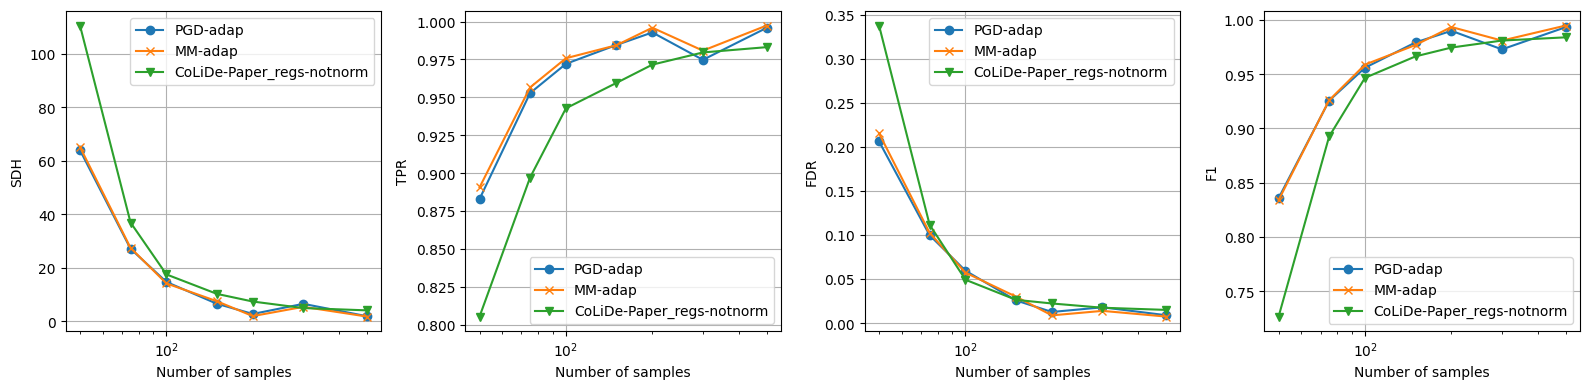

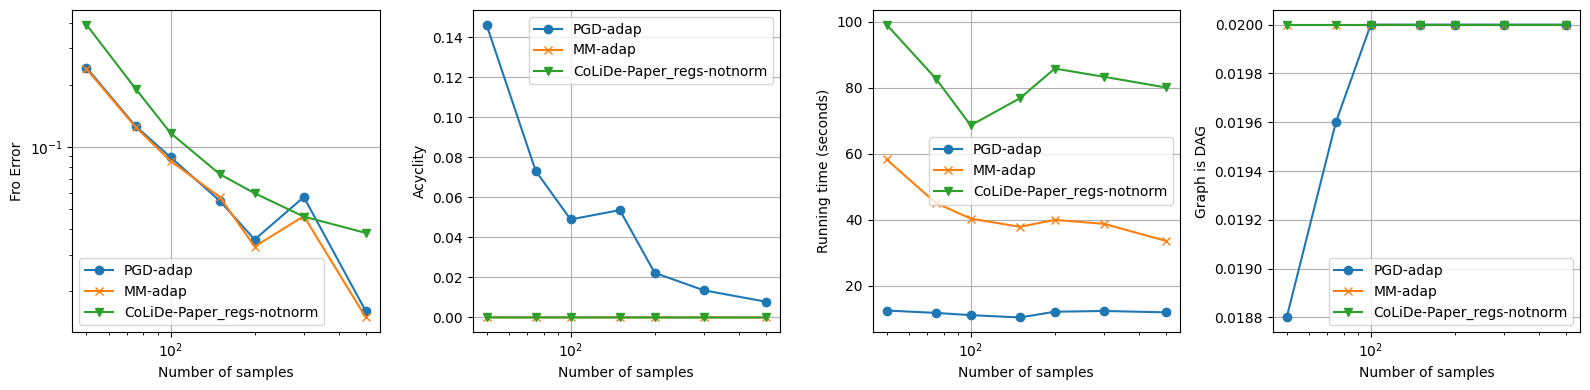

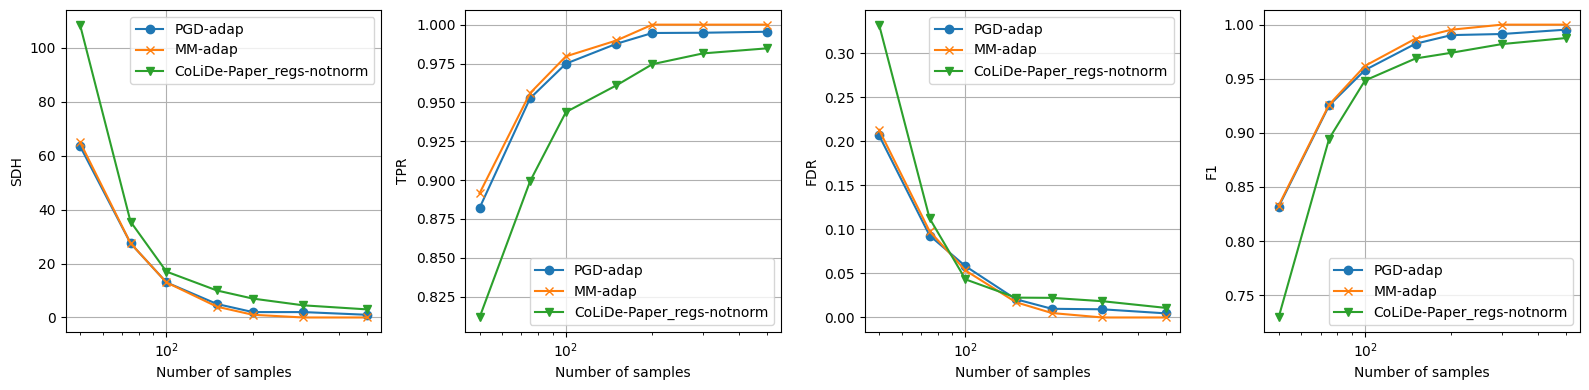

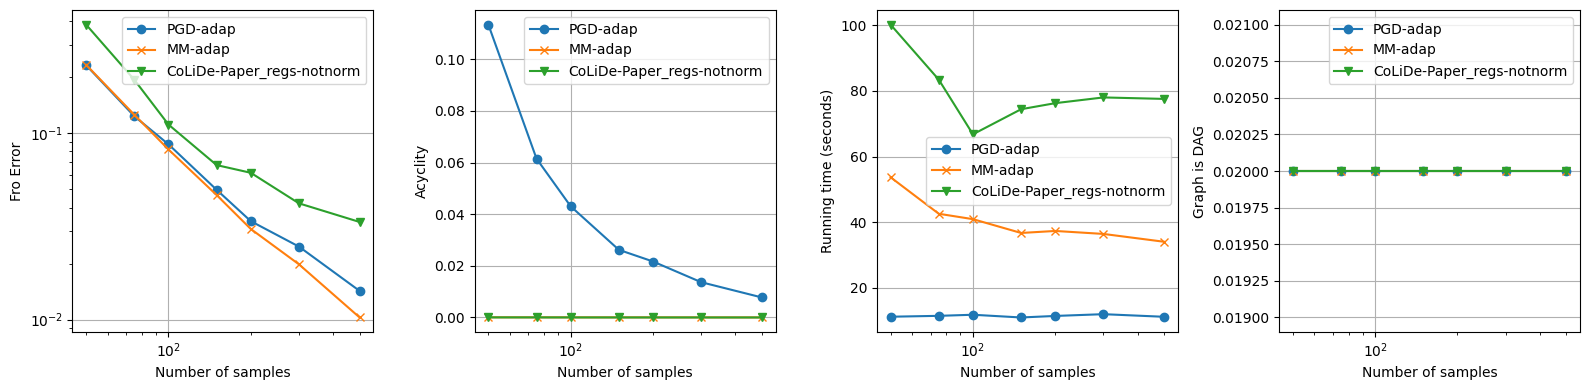

In [8]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


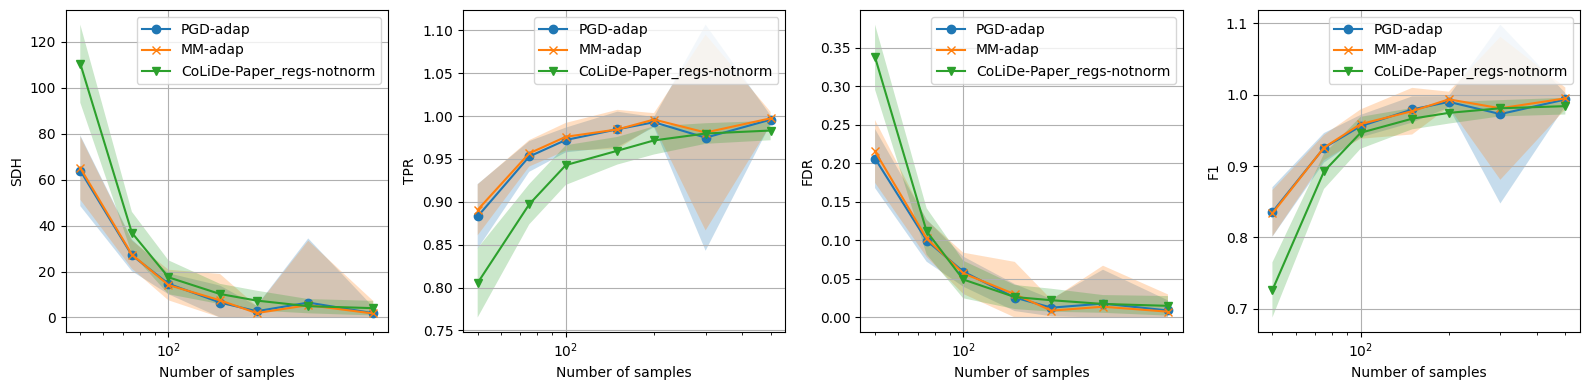

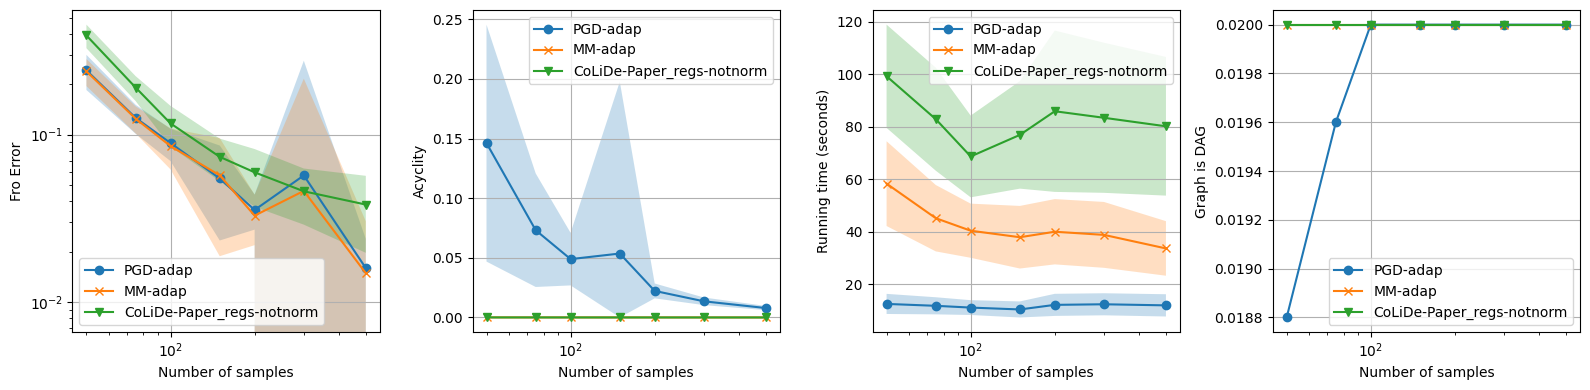

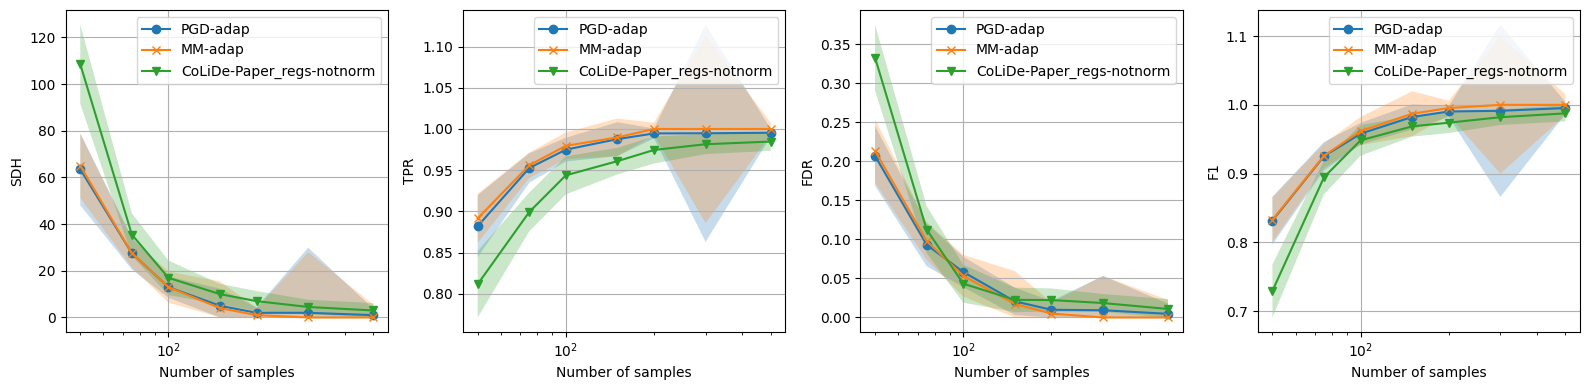

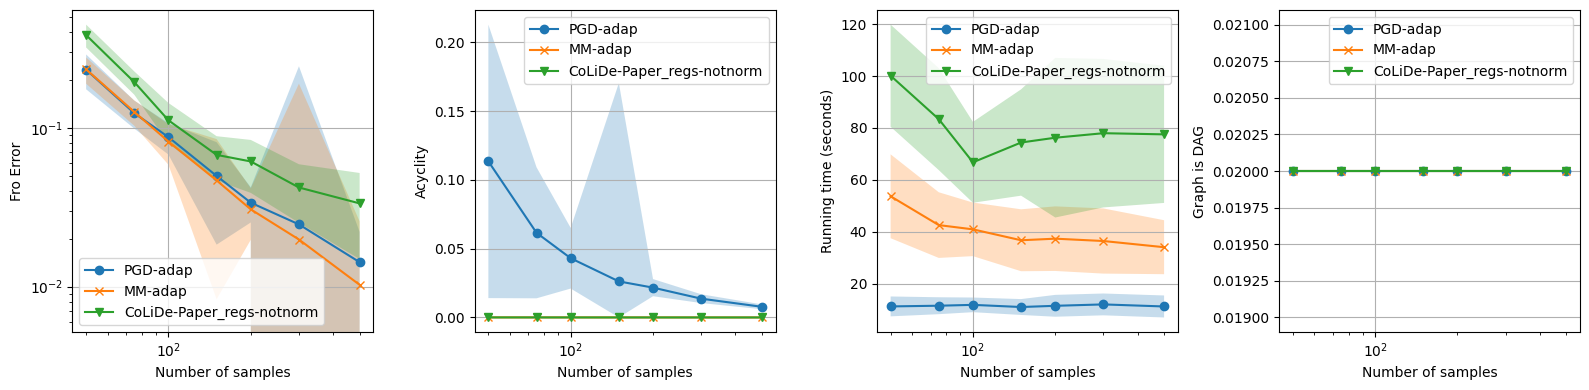

In [9]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median', dev=True)


## 4N Edges

In [10]:
n_dags = 50
N_samples = [ 25, 50, 100, 150, 200, 300, 500] #[75, 100, 200, 500, 1000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
  # Proj Grad Desc
  {'model': Nonneg_dagma, 'args': {'stepsize': 3e-4, 'alpha': .5, 's': 1, 'lamb': 2e-2, 'max_iters': 50000},
   'adapt_lamb': True,  'norm_x': False, 'fmt': 'o-', 'leg': 'PGD-adap'},

  {'model': MetMulDagma, 'args': {'stepsize': 1e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 2e-2,
   'iters_in': 30000, 'iters_out': 10, 'beta': 5}, 'adapt_lamb': True, 'norm_x': False,
   'fmt': 'x-', 'leg': 'MM-adap'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'fmt': 'v-', 'leg': 'CoLiDe-Paper_regs'},
]

### 50 nodes

In [11]:
N = 50
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)
dag_count = np.array(dag_count)/n_dags

CPUs employed: 32
Graph: 1, samples: 25
Graph: 2, samples: 25
Graph: 4, samples: 25
Graph: 5, samples: 25
Graph: 6, samples: 25
Graph: 7, samples: 25
Graph: 8, samples: 25
Graph: 9, samples: 25
Graph: 10, samples: 25
Graph: 11, samples: 25
Graph: 12, samples: 25
Graph: 13, samples: 25
Graph: 14, samples: 25
Graph: 15, samples: 25
Graph: 16, samples: 25
Graph: 17, samples: 25
Graph: 22, samples: 25
Graph: 3, samples: 25
Graph: 31, samples: 25
Graph: 21, samples: 25
Graph: 24, samples: 25
Graph: 26, samples: 25
Graph: 23, samples: 25
Graph: 30, samples: 25
Graph: 18, samples: 25
Graph: 27, samples: 25
Graph: 32, samples: 25
Graph: 19, samples: 25
Graph: 29, samples: 25
Graph: 25, samples: 25
Graph: 28, samples: 25
Graph: 20, samples: 25
		-PGD-adap: shd 169.0  -  err: 0.686  -  time: 11.290
		-PGD-adap: shd 164.0  -  err: 0.595  -  time: 13.512
		-PGD-adap: shd 165.0  -  err: 0.531  -  time: 13.931
		-PGD-adap: shd 135.0  -  err: 0.620  -  time: 13.983
		-PGD-adap: shd 144.0  -  err: 0.6

  8%|▊         | 10043/130000.0 [00:02<00:35, 3344.78it/s]

		-MM-adap: shd 112.0  -  err: 0.470  -  time: 53.630


  0%|          | 460/130000.0 [00:00<00:28, 4599.76it/s]]]

		-MM-adap: shd 84.0  -  err: 0.354  -  time: 54.433


  5%|▌         | 7137/130000.0 [00:01<00:29, 4161.58it/s]]

		-MM-adap: shd 113.0  -  err: 0.385  -  time: 55.383


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7529.20it/s] 

		-MM-adap: shd 134.0  -  err: 0.474  -  time: 58.158


  0%|          | 443/130000.0 [00:00<00:29, 4423.01it/s]s] 

		-MM-adap: shd 111.0  -  err: 0.481  -  time: 62.929
		-MM-adap: shd 93.0  -  err: 0.372  -  time: 63.177


100%|██████████| 130000/130000.0 [00:13<00:00, 9754.01it/s]
  4%|▍         | 5830/130000.0 [00:01<00:39, 3165.81it/s]]

		-CoLiDe-Paper_regs: shd 206.0  -  err: 0.790  -  time: 13.331
Graph: 6, samples: 50


 36%|███▌      | 46909/130000.0 [00:10<00:13, 6383.06it/s] 

		-MM-adap: shd 133.0  -  err: 0.500  -  time: 68.799


100%|██████████| 130000/130000.0 [00:13<00:00, 9712.99it/s]
 11%|█▏        | 14881/130000.0 [00:04<00:32, 3533.99it/s]

		-CoLiDe-Paper_regs: shd 232.0  -  err: 0.827  -  time: 13.385
Graph: 5, samples: 50


100%|██████████| 130000/130000.0 [00:14<00:00, 9200.88it/s]
 55%|█████▌    | 71501/130000.0 [00:13<00:13, 4254.48it/s]

		-CoLiDe-Paper_regs: shd 207.0  -  err: 0.840  -  time: 14.131
Graph: 32, samples: 50


100%|██████████| 130000/130000.0 [00:15<00:00, 8497.71it/s]  
  0%|          | 0/130000.0 [00:00<?, ?it/s], 4154.67it/s]

		-CoLiDe-Paper_regs: shd 187.0  -  err: 0.631  -  time: 15.301
Graph: 26, samples: 50
		-MM-adap: shd 118.0  -  err: 0.432  -  time: 72.359


100%|██████████| 130000/130000.0 [00:14<00:00, 9128.39it/s]


		-CoLiDe-Paper_regs: shd 258.0  -  err: 0.993  -  time: 14.242
Graph: 10, samples: 50


  9%|▉         | 12042/130000.0 [00:03<00:35, 3348.33it/s]]

		-MM-adap: shd 119.0  -  err: 0.436  -  time: 72.291


100%|██████████| 130000/130000.0 [00:11<00:00, 11432.61it/s]
 28%|██▊       | 35887/130000.0 [00:08<00:20, 4576.28it/s]]

		-CoLiDe-Paper_regs: shd 184.0  -  err: 0.723  -  time: 11.372
Graph: 13, samples: 50


  6%|▌         | 7289/130000.0 [00:01<00:29, 4193.95it/s]]

		-MM-adap: shd 128.0  -  err: 0.510  -  time: 75.868
		-MM-adap: shd 105.0  -  err: 0.335  -  time: 73.124


  9%|▉         | 12254/130000.0 [00:03<00:35, 3332.32it/s] 

		-MM-adap: shd 101.0  -  err: 0.385  -  time: 74.943


100%|██████████| 130000/130000.0 [00:13<00:00, 9515.61it/s]
  2%|▏         | 2110/130000.0 [00:00<00:29, 4273.07it/s]

		-CoLiDe-Paper_regs: shd 232.0  -  err: 0.960  -  time: 13.663
Graph: 7, samples: 50


 20%|██        | 26450/130000.0 [00:07<00:24, 4270.01it/s]

		-MM-adap: shd 93.0  -  err: 0.313  -  time: 79.427


  2%|▏         | 2494/130000.0 [00:00<00:33, 3753.18it/s]]]

		-MM-adap: shd 116.0  -  err: 0.466  -  time: 79.722


  4%|▍         | 5029/130000.0 [00:01<00:38, 3209.27it/s]]]

		-MM-adap: shd 104.0  -  err: 0.391  -  time: 79.994
		-MM-adap: shd 164.0  -  err: 0.647  -  time: 78.252
		-PGD-adap: shd 113.0  -  err: 0.396  -  time: 14.230


100%|██████████| 130000/130000.0 [00:15<00:00, 8567.87it/s]
 15%|█▍        | 19404/130000.0 [00:04<00:24, 4502.35it/s]

		-CoLiDe-Paper_regs: shd 217.0  -  err: 0.880  -  time: 15.174
Graph: 1, samples: 50


  9%|▉         | 12219/130000.0 [00:03<00:25, 4619.28it/s]]

		-PGD-adap: shd 192.0  -  err: 0.808  -  time: 14.382


 22%|██▏       | 28980/130000.0 [00:07<00:32, 3139.91it/s]]

		-MM-adap: shd 129.0  -  err: 0.469  -  time: 83.008
		-CoLiDe-Paper_regs: shd 210.0  -  err: 0.886  -  time: 12.119
Graph: 8, samples: 50


100%|██████████| 130000/130000.0 [00:12<00:00, 10727.54it/s]
 34%|███▎      | 43589/130000.0 [00:08<00:07, 10842.22it/s]

		-PGD-adap: shd 179.0  -  err: 0.835  -  time: 12.561
		-PGD-adap: shd 137.0  -  err: 0.457  -  time: 13.399


 23%|██▎       | 29666/130000.0 [00:06<00:24, 4049.05it/s] 

		-PGD-adap: shd 107.0  -  err: 0.420  -  time: 14.435


 39%|███▉      | 51313/130000.0 [00:12<00:19, 4030.92it/s]]

		-MM-adap: shd 133.0  -  err: 0.426  -  time: 85.743


 24%|██▎       | 30864/130000.0 [00:07<00:27, 3641.23it/s]]

		-MM-adap: shd 154.0  -  err: 0.637  -  time: 83.689


100%|██████████| 130000/130000.0 [00:12<00:00, 10454.93it/s]
 52%|█████▏    | 67567/130000.0 [00:12<00:13, 4746.56it/s]

		-CoLiDe-Paper_regs: shd 221.0  -  err: 0.880  -  time: 12.437
Graph: 23, samples: 50
		-CoLiDe-Paper_regs: shd 202.0  -  err: 0.739  -  time: 12.508
Graph: 17, samples: 50


100%|██████████| 130000/130000.0 [00:12<00:00, 10394.18it/s]
 17%|█▋        | 21815/130000.0 [00:05<00:25, 4312.85it/s]]

		-PGD-adap: shd 117.0  -  err: 0.395  -  time: 13.339
		-MM-adap: shd 138.0  -  err: 0.514  -  time: 88.631


100%|██████████| 130000/130000.0 [00:15<00:00, 8466.09it/s]
  2%|▏         | 2584/130000.0 [00:00<00:32, 3967.94it/s]] 

		-CoLiDe-Paper_regs: shd 215.0  -  err: 0.808  -  time: 15.356
Graph: 15, samples: 50


100%|██████████| 130000/130000.0 [00:11<00:00, 11095.01it/s]
 35%|███▌      | 45522/130000.0 [00:10<00:16, 5096.50it/s]

		-CoLiDe-Paper_regs: shd 195.0  -  err: 0.838  -  time: 11.718
Graph: 9, samples: 50


  6%|▌         | 7351/130000.0 [00:02<00:32, 3830.71it/s]] 

		-MM-adap: shd 153.0  -  err: 0.579  -  time: 89.097


100%|██████████| 130000/130000.0 [00:13<00:00, 9757.66it/s]
 12%|█▏        | 15887/130000.0 [00:03<00:24, 4582.09it/s]

		-CoLiDe-Paper_regs: shd 218.0  -  err: 0.794  -  time: 13.324
Graph: 12, samples: 50
		-PGD-adap: shd 127.0  -  err: 0.447  -  time: 13.988


  0%|          | 407/130000.0 [00:00<00:31, 4065.85it/s]s] 

		-MM-adap: shd 133.0  -  err: 0.496  -  time: 92.994


100%|██████████| 130000/130000.0 [00:13<00:00, 9593.76it/s]
 19%|█▉        | 24926/130000.0 [00:05<00:23, 4424.97it/s]

		-CoLiDe-Paper_regs: shd 225.0  -  err: 0.928  -  time: 13.556
Graph: 18, samples: 50


100%|██████████| 130000/130000.0 [00:16<00:00, 7734.17it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 9012.56it/s]
 23%|██▎       | 29941/130000.0 [00:07<00:21, 4579.67it/s]

		-CoLiDe-Paper_regs: shd 200.0  -  err: 0.763  -  time: 16.810
Graph: 2, samples: 50
		-MM-adap: shd 149.0  -  err: 0.502  -  time: 97.942
		-CoLiDe-Paper_regs: shd 242.0  -  err: 0.984  -  time: 14.426
Graph: 16, samples: 50


 14%|█▍        | 18752/130000.0 [00:04<00:30, 3705.97it/s]]

		-PGD-adap: shd 112.0  -  err: 0.463  -  time: 13.298
		-MM-adap: shd 113.0  -  err: 0.391  -  time: 91.442


100%|██████████| 130000/130000.0 [00:14<00:00, 9154.70it/s] 
 24%|██▍       | 31174/130000.0 [00:08<00:22, 4464.12it/s]

		-CoLiDe-Paper_regs: shd 205.0  -  err: 0.837  -  time: 14.202
Graph: 25, samples: 50


 11%|█▏        | 14797/130000.0 [00:03<00:25, 4464.02it/s]

		-MM-adap: shd 136.0  -  err: 0.564  -  time: 93.257


 41%|████▏     | 53664/130000.0 [00:11<00:17, 4390.53it/s]]

		-PGD-adap: shd 114.0  -  err: 0.474  -  time: 14.883


 29%|██▉       | 38149/130000.0 [00:09<00:19, 4618.33it/s]

		-MM-adap: shd 166.0  -  err: 0.531  -  time: 99.643


 30%|███       | 39076/130000.0 [00:10<00:19, 4623.11it/s]]

		-MM-adap: shd 149.0  -  err: 0.585  -  time: 97.223


 49%|████▊     | 63060/130000.0 [00:13<00:10, 6603.62it/s] 

		-MM-adap: shd 165.0  -  err: 0.668  -  time: 97.440


 14%|█▍        | 18127/130000.0 [00:04<00:32, 3464.51it/s] 

		-PGD-adap: shd 128.0  -  err: 0.451  -  time: 11.737


100%|██████████| 130000/130000.0 [00:12<00:00, 10073.98it/s]
  7%|▋         | 8859/130000.0 [00:01<00:26, 4599.37it/s]]

		-CoLiDe-Paper_regs: shd 229.0  -  err: 0.898  -  time: 12.916
Graph: 27, samples: 50


100%|██████████| 130000/130000.0 [00:15<00:00, 8518.49it/s]
 25%|██▌       | 32599/130000.0 [00:07<00:21, 4473.31it/s]

		-CoLiDe-Paper_regs: shd 250.0  -  err: 0.935  -  time: 15.264
Graph: 31, samples: 50
		-PGD-adap: shd 150.0  -  err: 0.670  -  time: 13.320


 11%|█▏        | 14734/130000.0 [00:03<00:25, 4543.45it/s] 

		-PGD-adap: shd 142.0  -  err: 0.631  -  time: 13.246


 24%|██▍       | 31422/130000.0 [00:08<00:24, 4001.72it/s] 

		-MM-adap: shd 249.0  -  err: 0.897  -  time: 104.049
		-PGD-adap: shd 106.0  -  err: 0.424  -  time: 13.262


 19%|█▊        | 24083/130000.0 [00:05<00:27, 3838.37it/s]]

		-MM-adap: shd 189.0  -  err: 0.679  -  time: 102.494
		-MM-adap: shd 182.0  -  err: 0.639  -  time: 101.912


 55%|█████▍    | 71000/130000.0 [00:14<00:12, 4801.75it/s]

		-PGD-adap: shd 101.0  -  err: 0.379  -  time: 13.471


100%|██████████| 130000/130000.0 [00:12<00:00, 10580.15it/s]
 21%|██        | 26825/130000.0 [00:06<00:27, 3703.05it/s]

		-CoLiDe-Paper_regs: shd 203.0  -  err: 0.813  -  time: 12.288
Graph: 4, samples: 50


100%|██████████| 130000/130000.0 [00:14<00:00, 8669.40it/s]
 25%|██▌       | 33134/130000.0 [00:07<00:20, 4688.50it/s]

		-CoLiDe-Paper_regs: shd 212.0  -  err: 0.816  -  time: 15.003
Graph: 30, samples: 50


100%|██████████| 130000/130000.0 [00:17<00:00, 7449.12it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10492.36it/s]
  5%|▍         | 6028/130000.0 [00:01<00:38, 3215.21it/s]]

		-CoLiDe-Paper_regs: shd 216.0  -  err: 0.920  -  time: 17.472
Graph: 21, samples: 50
		-CoLiDe-Paper_regs: shd 206.0  -  err: 0.742  -  time: 12.391
Graph: 14, samples: 50


  6%|▌         | 7897/130000.0 [00:02<00:28, 4245.82it/s]]]

		-PGD-adap: shd 133.0  -  err: 0.427  -  time: 12.609


 40%|███▉      | 51486/130000.0 [00:12<00:18, 4168.37it/s] 

		-PGD-adap: shd 116.0  -  err: 0.485  -  time: 13.351


 10%|█         | 13421/130000.0 [00:03<00:25, 4502.31it/s]]

		-PGD-adap: shd 161.0  -  err: 0.774  -  time: 14.892


100%|██████████| 130000/130000.0 [00:11<00:00, 10922.89it/s]
 37%|███▋      | 48285/130000.0 [00:11<00:19, 4109.92it/s]

		-PGD-adap: shd 125.0  -  err: 0.499  -  time: 13.300
		-CoLiDe-Paper_regs: shd 238.0  -  err: 0.926  -  time: 11.902
Graph: 11, samples: 50


100%|██████████| 130000/130000.0 [00:13<00:00, 9559.04it/s] 
 57%|█████▋    | 73552/130000.0 [00:15<00:13, 4066.55it/s]

		-CoLiDe-Paper_regs: shd 236.0  -  err: 0.977  -  time: 13.610
Graph: 28, samples: 50
		-CoLiDe-Paper_regs: shd 183.0  -  err: 0.664  -  time: 16.028
Graph: 20, samples: 50


100%|██████████| 130000/130000.0 [00:16<00:00, 8111.96it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 8708.17it/s]
 27%|██▋       | 35434/130000.0 [00:09<00:30, 3081.85it/s]

		-CoLiDe-Paper_regs: shd 206.0  -  err: 0.871  -  time: 14.931
Graph: 3, samples: 50


 33%|███▎      | 43012/130000.0 [00:10<00:19, 4381.46it/s]

		-PGD-adap: shd 135.0  -  err: 0.463  -  time: 14.007


100%|██████████| 130000/130000.0 [00:16<00:00, 7656.75it/s]


		-CoLiDe-Paper_regs: shd 226.0  -  err: 0.880  -  time: 16.981
Graph: 24, samples: 50


 38%|███▊      | 49515/130000.0 [00:12<00:20, 3886.26it/s]

		-PGD-adap: shd 123.0  -  err: 0.430  -  time: 15.470


 42%|████▏     | 54365/130000.0 [00:14<00:16, 4640.33it/s]

		-PGD-adap: shd 190.0  -  err: 0.749  -  time: 12.101


 47%|████▋     | 61066/130000.0 [00:15<00:21, 3186.47it/s]]

		-PGD-adap: shd 103.0  -  err: 0.382  -  time: 12.916
		-PGD-adap: shd 147.0  -  err: 0.638  -  time: 13.553


 48%|████▊     | 62235/130000.0 [00:15<00:18, 3622.34it/s] 

		-PGD-adap: shd 110.0  -  err: 0.478  -  time: 14.327


100%|██████████| 130000/130000.0 [00:16<00:00, 7731.72it/s]
 54%|█████▎    | 69556/130000.0 [00:16<00:13, 4328.27it/s]

		-CoLiDe-Paper_regs: shd 270.0  -  err: 0.997  -  time: 16.825
Graph: 29, samples: 50


100%|██████████| 130000/130000.0 [00:17<00:00, 7356.00it/s]
 55%|█████▌    | 72077/130000.0 [00:18<00:16, 3481.98it/s]

		-CoLiDe-Paper_regs: shd 248.0  -  err: 0.954  -  time: 17.675
Graph: 19, samples: 50


 62%|██████▏   | 80278/130000.0 [00:20<00:13, 3560.60it/s]

		-PGD-adap: shd 115.0  -  err: 0.391  -  time: 13.210


 66%|██████▌   | 85348/130000.0 [00:22<00:12, 3707.17it/s]

		-PGD-adap: shd 105.0  -  err: 0.411  -  time: 14.513


 67%|██████▋   | 86993/130000.0 [00:22<00:11, 3865.71it/s]

		-PGD-adap: shd 132.0  -  err: 0.456  -  time: 15.731


100%|██████████| 130000/130000.0 [00:24<00:00, 5374.51it/s]


		-CoLiDe-Paper_regs: shd 239.0  -  err: 0.831  -  time: 24.189
Graph: 22, samples: 50
		-PGD-adap: shd 155.0  -  err: 0.650  -  time: 14.543
		-PGD-adap: shd 118.0  -  err: 0.441  -  time: 16.455
		-PGD-adap: shd 190.0  -  err: 0.830  -  time: 12.719
		-PGD-adap: shd 173.0  -  err: 0.826  -  time: 13.776
		-PGD-adap: shd 213.0  -  err: 1.141  -  time: 17.227
		-MM-adap: shd 42.0  -  err: 0.162  -  time: 65.571


 16%|█▌        | 20861/130000.0 [00:06<00:28, 3772.58it/s]

		-MM-adap: shd 59.0  -  err: 0.221  -  time: 66.089


  0%|          | 295/130000.0 [00:00<00:44, 2944.15it/s]s]

		-MM-adap: shd 73.0  -  err: 0.204  -  time: 64.728


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4094.78it/s]]]

		-MM-adap: shd 44.0  -  err: 0.195  -  time: 57.727


 35%|███▍      | 45301/130000.0 [00:11<00:14, 5823.49it/s] 

		-MM-adap: shd 45.0  -  err: 0.160  -  time: 51.863


100%|██████████| 130000/130000.0 [00:15<00:00, 8521.68it/s] 


		-CoLiDe-Paper_regs: shd 101.0  -  err: 0.366  -  time: 15.256
Graph: 6, samples: 100


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5148.99it/s] 

		-MM-adap: shd 42.0  -  err: 0.172  -  time: 42.163


  4%|▎         | 4574/130000.0 [00:01<00:31, 4028.96it/s]] 

		-MM-adap: shd 48.0  -  err: 0.225  -  time: 55.194


100%|██████████| 130000/130000.0 [00:12<00:00, 10647.19it/s]
  7%|▋         | 8822/130000.0 [00:02<00:41, 2955.11it/s]

		-CoLiDe-Paper_regs: shd 124.0  -  err: 0.532  -  time: 12.216
Graph: 26, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11042.93it/s]
 10%|█         | 13178/130000.0 [00:03<00:31, 3656.56it/s]

		-CoLiDe-Paper_regs: shd 138.0  -  err: 0.565  -  time: 11.773
Graph: 13, samples: 100


100%|██████████| 130000/130000.0 [00:09<00:00, 13235.08it/s]
 10%|█         | 13265/130000.0 [00:03<00:27, 4231.91it/s]

		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.439  -  time: 9.823
Graph: 8, samples: 100


 15%|█▌        | 20098/130000.0 [00:03<00:04, 22010.07it/s]

		-MM-adap: shd 75.0  -  err: 0.248  -  time: 81.939


100%|██████████| 130000/130000.0 [00:10<00:00, 12407.40it/s]
 20%|██        | 26485/130000.0 [00:05<00:19, 5213.23it/s]

		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.396  -  time: 10.479
Graph: 12, samples: 100


  7%|▋         | 9619/130000.0 [00:02<00:42, 2851.51it/s]s]

		-MM-adap: shd 62.0  -  err: 0.214  -  time: 73.453


100%|██████████| 130000/130000.0 [00:10<00:00, 12481.59it/s]
  7%|▋         | 9250/130000.0 [00:03<00:41, 2940.98it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.302  -  time: 10.417
Graph: 21, samples: 100


100%|██████████| 130000/130000.0 [00:10<00:00, 12218.67it/s]
 10%|█         | 13647/130000.0 [00:04<00:33, 3493.63it/s]

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.381  -  time: 10.640
Graph: 2, samples: 100


 18%|█▊        | 22890/130000.0 [00:05<00:17, 6003.70it/s]]

		-MM-adap: shd 46.0  -  err: 0.215  -  time: 55.288
		-MM-adap: shd 75.0  -  err: 0.239  -  time: 60.478


  2%|▏         | 2197/130000.0 [00:00<00:28, 4503.11it/s]] 

		-PGD-adap: shd 199.0  -  err: 0.922  -  time: 14.894


  2%|▏         | 3119/130000.0 [00:00<00:29, 4268.81it/s]]

		-PGD-adap: shd 98.0  -  err: 0.329  -  time: 9.973


  3%|▎         | 3964/130000.0 [00:00<00:30, 4118.45it/s]s]

		-MM-adap: shd 39.0  -  err: 0.170  -  time: 72.203


  9%|▊         | 11339/130000.0 [00:02<00:26, 4561.37it/s]]

		-MM-adap: shd 106.0  -  err: 0.372  -  time: 94.825


  2%|▏         | 2214/130000.0 [00:00<00:38, 3333.76it/s]] 

		-PGD-adap: shd 167.0  -  err: 0.764  -  time: 14.172


100%|██████████| 130000/130000.0 [00:12<00:00, 10229.89it/s]
 13%|█▎        | 17234/130000.0 [00:03<00:24, 4518.97it/s]

		-CoLiDe-Paper_regs: shd 139.0  -  err: 0.564  -  time: 12.712
Graph: 32, samples: 100
		-MM-adap: shd 66.0  -  err: 0.231  -  time: 87.332


  5%|▌         | 6878/130000.0 [00:01<00:27, 4446.27it/s]] 

		-MM-adap: shd 61.0  -  err: 0.211  -  time: 79.295


 11%|█         | 13893/130000.0 [00:03<00:26, 4365.05it/s]]

		-PGD-adap: shd 81.0  -  err: 0.320  -  time: 15.684


  7%|▋         | 9548/130000.0 [00:02<00:26, 4522.25it/s]]

		-PGD-adap: shd 118.0  -  err: 0.381  -  time: 13.977
		-CoLiDe-Paper_regs: shd 124.0  -  err: 0.505  -  time: 12.624
Graph: 1, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10298.27it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s], 6272.35it/s]]

		-MM-adap: shd 38.0  -  err: 0.172  -  time: 56.732


100%|██████████| 130000/130000.0 [00:08<00:00, 15135.84it/s]
 16%|█▌        | 20368/130000.0 [00:04<00:08, 13645.86it/s]

		-CoLiDe-Paper_regs: shd 113.0  -  err: 0.437  -  time: 8.591
Graph: 27, samples: 100


  6%|▌         | 7918/130000.0 [00:01<00:26, 4597.93it/s]] 

		-PGD-adap: shd 148.0  -  err: 0.564  -  time: 12.587
		-PGD-adap: shd 92.0  -  err: 0.323  -  time: 11.428


 25%|██▌       | 33141/130000.0 [00:08<00:34, 2843.72it/s]]

		-MM-adap: shd 124.0  -  err: 0.507  -  time: 102.194


100%|██████████| 130000/130000.0 [00:12<00:00, 10157.21it/s]


		-CoLiDe-Paper_regs: shd 98.0  -  err: 0.472  -  time: 12.800
Graph: 4, samples: 100


100%|██████████| 130000/130000.0 [00:12<00:00, 10426.30it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 14393.12it/s]
 36%|███▌      | 46548/130000.0 [00:11<00:18, 4572.30it/s]

		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.385  -  time: 12.471
Graph: 9, samples: 100
		-CoLiDe-Paper_regs: shd 117.0  -  err: 0.433  -  time: 9.033
Graph: 23, samples: 100


100%|██████████| 130000/130000.0 [00:10<00:00, 12980.73it/s]
  8%|▊         | 10673/130000.0 [00:02<00:29, 4106.01it/s]]

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.315  -  time: 10.016
Graph: 7, samples: 100


  0%|          | 469/130000.0 [00:00<00:27, 4688.14it/s]s] 

		-MM-adap: shd 70.0  -  err: 0.238  -  time: 84.300


 51%|█████     | 66450/130000.0 [00:14<00:10, 6139.95it/s]]

		-MM-adap: shd 53.0  -  err: 0.188  -  time: 66.979


100%|██████████| 130000/130000.0 [00:14<00:00, 8988.49it/s] 
  1%|          | 1119/130000.0 [00:00<00:34, 3686.68it/s]]

		-PGD-adap: shd 114.0  -  err: 0.411  -  time: 8.294
		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.408  -  time: 14.464
Graph: 5, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11718.46it/s]
 20%|█▉        | 25748/130000.0 [00:07<00:25, 4017.17it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.324  -  time: 11.094
Graph: 28, samples: 100


 11%|█         | 13868/130000.0 [00:03<00:28, 4084.82it/s]

		-PGD-adap: shd 177.0  -  err: 0.731  -  time: 15.748


 19%|█▉        | 24833/130000.0 [00:05<00:18, 5834.83it/s] 

		-PGD-adap: shd 80.0  -  err: 0.321  -  time: 14.835


 31%|███       | 40006/130000.0 [00:06<00:02, 35063.08it/s]

		-MM-adap: shd 68.0  -  err: 0.287  -  time: 87.270


100%|██████████| 130000/130000.0 [00:14<00:00, 9119.61it/s]


		-CoLiDe-Paper_regs: shd 122.0  -  err: 0.592  -  time: 14.263
Graph: 10, samples: 100
		-MM-adap: shd 78.0  -  err: 0.297  -  time: 98.818


100%|██████████| 130000/130000.0 [00:09<00:00, 13240.26it/s]
 10%|▉         | 12531/130000.0 [00:03<00:38, 3065.97it/s]

		-CoLiDe-Paper_regs: shd 121.0  -  err: 0.521  -  time: 9.819
Graph: 20, samples: 100


 11%|█▏        | 14736/130000.0 [00:04<00:27, 4217.05it/s]

		-MM-adap: shd 62.0  -  err: 0.224  -  time: 68.923


100%|██████████| 130000/130000.0 [00:11<00:00, 10837.15it/s]
  8%|▊         | 9765/130000.0 [00:02<00:26, 4496.04it/s]

		-CoLiDe-Paper_regs: shd 140.0  -  err: 0.573  -  time: 11.997
Graph: 16, samples: 100
		-PGD-adap: shd 86.0  -  err: 0.330  -  time: 14.635


  8%|▊         | 10655/130000.0 [00:02<00:27, 4266.49it/s]

		-MM-adap: shd 74.0  -  err: 0.245  -  time: 86.051
		-PGD-adap: shd 149.0  -  err: 0.557  -  time: 14.320
		-PGD-adap: shd 135.0  -  err: 0.567  -  time: 14.997


  6%|▌         | 7389/130000.0 [00:01<00:36, 3328.67it/s]]

		-PGD-adap: shd 132.0  -  err: 0.501  -  time: 16.106


  7%|▋         | 9271/130000.0 [00:02<00:29, 4081.30it/s]]]

		-MM-adap: shd 64.0  -  err: 0.225  -  time: 79.385


 20%|██        | 26531/130000.0 [00:06<00:28, 3628.99it/s] 

		-PGD-adap: shd 90.0  -  err: 0.350  -  time: 15.599


100%|██████████| 130000/130000.0 [00:10<00:00, 12752.84it/s]
 21%|██        | 26863/130000.0 [00:06<00:22, 4554.39it/s]

		-CoLiDe-Paper_regs: shd 83.0  -  err: 0.343  -  time: 10.195
Graph: 25, samples: 100


 19%|█▊        | 24162/130000.0 [00:06<00:22, 4654.67it/s] 

		-PGD-adap: shd 181.0  -  err: 0.773  -  time: 15.958


 13%|█▎        | 16330/130000.0 [00:04<00:29, 3883.20it/s]]

		-MM-adap: shd 93.0  -  err: 0.326  -  time: 107.034
		-PGD-adap: shd 83.0  -  err: 0.317  -  time: 9.418


 20%|█▉        | 25618/130000.0 [00:05<00:23, 4361.60it/s]]

		-MM-adap: shd 96.0  -  err: 0.367  -  time: 103.183


100%|██████████| 130000/130000.0 [00:11<00:00, 10956.70it/s]
  9%|▉         | 11930/130000.0 [00:02<00:26, 4496.14it/s]]

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.349  -  time: 11.866
Graph: 17, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11815.83it/s]
 10%|▉         | 12848/130000.0 [00:03<00:25, 4545.36it/s]

		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.421  -  time: 11.003
Graph: 24, samples: 100


 11%|█▏        | 14701/130000.0 [00:03<00:26, 4408.99it/s] 

		-PGD-adap: shd 93.0  -  err: 0.353  -  time: 11.857


100%|██████████| 130000/130000.0 [00:11<00:00, 11094.20it/s]


		-CoLiDe-Paper_regs: shd 81.0  -  err: 0.337  -  time: 11.719
Graph: 11, samples: 100
		-PGD-adap: shd 145.0  -  err: 0.554  -  time: 14.642


100%|██████████| 130000/130000.0 [00:14<00:00, 8957.52it/s] 
 17%|█▋        | 21702/130000.0 [00:06<00:32, 3323.60it/s]

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.392  -  time: 14.514
Graph: 31, samples: 100


 35%|███▍      | 45419/130000.0 [00:11<00:14, 5852.40it/s]]

		-PGD-adap: shd 131.0  -  err: 0.558  -  time: 14.625


100%|██████████| 130000/130000.0 [00:13<00:00, 9844.99it/s] 
 37%|███▋      | 47948/130000.0 [00:11<00:18, 4533.93it/s]

		-CoLiDe-Paper_regs: shd 101.0  -  err: 0.487  -  time: 13.205
Graph: 15, samples: 100


100%|██████████| 130000/130000.0 [00:15<00:00, 8601.02it/s]
  0%|          | 415/130000.0 [00:00<00:31, 4148.22it/s]

		-MM-adap: shd 88.0  -  err: 0.289  -  time: 97.996
		-CoLiDe-Paper_regs: shd 93.0  -  err: 0.388  -  time: 15.122
Graph: 18, samples: 100


  1%|▏         | 1934/130000.0 [00:00<00:25, 5004.27it/s]

		-PGD-adap: shd 142.0  -  err: 0.541  -  time: 13.769


  5%|▍         | 6190/130000.0 [00:01<00:31, 3976.90it/s]

		-PGD-adap: shd 91.0  -  err: 0.317  -  time: 15.580


 10%|▉         | 12765/130000.0 [00:03<00:34, 3360.61it/s]

		-MM-adap: shd 79.0  -  err: 0.272  -  time: 111.572
		-MM-adap: shd 11.0  -  err: 0.066  -  time: 49.193


 14%|█▍        | 18593/130000.0 [00:05<00:31, 3554.53it/s]

		-PGD-adap: shd 103.0  -  err: 0.377  -  time: 13.868


 18%|█▊        | 23647/130000.0 [00:06<00:31, 3356.04it/s]

		-PGD-adap: shd 134.0  -  err: 0.539  -  time: 15.322


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3182.90it/s]]

		-MM-adap: shd 80.0  -  err: 0.299  -  time: 113.785


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4359.12it/s]]

		-MM-adap: shd 17.0  -  err: 0.070  -  time: 51.623


 15%|█▌        | 19819/130000.0 [00:05<00:26, 4114.41it/s]]

		-PGD-adap: shd 95.0  -  err: 0.357  -  time: 15.697


100%|██████████| 130000/130000.0 [00:13<00:00, 9801.07it/s] 
 12%|█▏        | 15121/130000.0 [00:03<00:25, 4483.98it/s]

		-CoLiDe-Paper_regs: shd 128.0  -  err: 0.507  -  time: 13.265
Graph: 3, samples: 100


100%|██████████| 130000/130000.0 [00:10<00:00, 12831.72it/s]
 20%|█▉        | 25399/130000.0 [00:07<00:39, 2679.43it/s]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.306  -  time: 10.132
Graph: 13, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10788.35it/s]
 34%|███▍      | 44093/130000.0 [00:09<00:07, 11514.67it/s]

		-CoLiDe-Paper_regs: shd 109.0  -  err: 0.413  -  time: 12.051
Graph: 14, samples: 100
		-MM-adap: shd 9.0  -  err: 0.055  -  time: 46.329
		-PGD-adap: shd 101.0  -  err: 0.317  -  time: 16.215


100%|██████████| 130000/130000.0 [00:12<00:00, 10818.92it/s]
  8%|▊         | 10004/130000.0 [00:02<00:26, 4557.72it/s]

		-CoLiDe-Paper_regs: shd 119.0  -  err: 0.470  -  time: 12.021
Graph: 30, samples: 100


  9%|▉         | 11903/130000.0 [00:03<00:25, 4708.20it/s] 

		-MM-adap: shd 153.0  -  err: 0.585  -  time: 109.632


100%|██████████| 130000/130000.0 [00:10<00:00, 12966.76it/s]
 11%|█         | 14445/130000.0 [00:03<00:32, 3506.77it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.196  -  time: 10.027
Graph: 2, samples: 150
		-MM-adap: shd 105.0  -  err: 0.349  -  time: 112.317


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3248.51it/s]]

		-MM-adap: shd 205.0  -  err: 0.794  -  time: 106.025


100%|██████████| 130000/130000.0 [00:10<00:00, 12279.61it/s]
 20%|██        | 26261/130000.0 [00:06<00:25, 4017.29it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.158  -  time: 10.588
Graph: 1, samples: 150


 28%|██▊       | 37000/130000.0 [00:09<00:23, 4009.95it/s]]

		-PGD-adap: shd 95.0  -  err: 0.395  -  time: 15.653


 35%|███▍      | 44992/130000.0 [00:10<00:17, 4971.69it/s] 

		-PGD-adap: shd 85.0  -  err: 0.326  -  time: 16.745


 38%|███▊      | 49262/130000.0 [00:12<00:21, 3760.99it/s]

		-PGD-adap: shd 98.0  -  err: 0.342  -  time: 16.385


 23%|██▎       | 30127/130000.0 [00:08<00:29, 3343.61it/s]]

		-MM-adap: shd 13.0  -  err: 0.079  -  time: 49.295


 49%|████▊     | 63145/130000.0 [00:13<00:06, 10506.02it/s]

		-MM-adap: shd 29.0  -  err: 0.134  -  time: 84.012


  0%|          | 475/130000.0 [00:00<00:27, 4745.26it/s]]] 

		-PGD-adap: shd 202.0  -  err: 0.956  -  time: 15.186
		-MM-adap: shd 49.0  -  err: 0.189  -  time: 79.167


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4389.05it/s]]

		-MM-adap: shd 16.0  -  err: 0.071  -  time: 57.899


100%|██████████| 130000/130000.0 [00:15<00:00, 8399.83it/s] 
  8%|▊         | 10671/130000.0 [00:02<00:26, 4534.90it/s]

		-PGD-adap: shd 204.0  -  err: 0.884  -  time: 15.416
		-CoLiDe-Paper_regs: shd 136.0  -  err: 0.568  -  time: 15.478
Graph: 29, samples: 100


100%|██████████| 130000/130000.0 [00:16<00:00, 7901.26it/s]
 10%|▉         | 12464/130000.0 [00:02<00:26, 4380.34it/s]

		-CoLiDe-Paper_regs: shd 116.0  -  err: 0.556  -  time: 16.455
Graph: 19, samples: 100


 31%|███       | 40220/130000.0 [00:06<00:02, 31158.15it/s]

		-MM-adap: shd 17.0  -  err: 0.079  -  time: 60.160


 58%|█████▊    | 74891/130000.0 [00:17<00:13, 4030.63it/s]]

		-PGD-adap: shd 78.0  -  err: 0.318  -  time: 15.771


100%|██████████| 130000/130000.0 [00:09<00:00, 13151.46it/s]
  5%|▍         | 6115/130000.0 [00:01<00:30, 4100.92it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.283  -  time: 9.892
Graph: 10, samples: 150
		-CoLiDe-Paper_regs: shd 136.0  -  err: 0.553  -  time: 18.085
Graph: 22, samples: 100


100%|██████████| 130000/130000.0 [00:18<00:00, 7188.68it/s]
100%|██████████| 130000/130000.0 [00:11<00:00, 11429.65it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12209.82it/s]
 10%|▉         | 12821/130000.0 [00:03<00:35, 3322.58it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.249  -  time: 11.375
Graph: 8, samples: 150
		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.352  -  time: 10.648
Graph: 12, samples: 150


100%|██████████| 130000/130000.0 [00:11<00:00, 11555.03it/s]
 16%|█▌        | 20164/130000.0 [00:04<00:07, 15024.29it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.238  -  time: 11.251
Graph: 9, samples: 150


 31%|███       | 40000/130000.0 [00:07<00:03, 28175.42it/s]

		-MM-adap: shd 104.0  -  err: 0.363  -  time: 97.398


  1%|          | 894/130000.0 [00:00<00:28, 4510.66it/s]/s]

		-PGD-adap: shd 139.0  -  err: 0.541  -  time: 13.939


  7%|▋         | 8832/130000.0 [00:02<00:32, 3674.49it/s]s]

		-PGD-adap: shd 88.0  -  err: 0.323  -  time: 15.304


 10%|▉         | 12598/130000.0 [00:03<00:37, 3148.97it/s] 

		-MM-adap: shd 52.0  -  err: 0.225  -  time: 94.377


100%|██████████| 130000/130000.0 [00:11<00:00, 11400.64it/s]
 11%|█▏        | 14716/130000.0 [00:03<00:28, 4037.65it/s]

		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.302  -  time: 11.404
Graph: 5, samples: 150


  0%|          | 372/130000.0 [00:00<00:34, 3710.76it/s]s]

		-MM-adap: shd 146.0  -  err: 0.487  -  time: 105.111


  3%|▎         | 3723/130000.0 [00:01<00:34, 3682.26it/s]]

		-MM-adap: shd 16.0  -  err: 0.089  -  time: 68.119


 10%|▉         | 12372/130000.0 [00:03<00:37, 3115.75it/s]]

		-MM-adap: shd 47.0  -  err: 0.176  -  time: 92.047


  1%|▏         | 1638/130000.0 [00:00<01:00, 2120.87it/s]]]

		-PGD-adap: shd 98.0  -  err: 0.355  -  time: 12.408


 10%|▉         | 12392/130000.0 [00:03<00:31, 3689.73it/s]

		-MM-adap: shd 23.0  -  err: 0.102  -  time: 46.146


 36%|███▌      | 47020/130000.0 [00:10<00:13, 5969.50it/s] 

		-PGD-adap: shd 74.0  -  err: 0.347  -  time: 16.346


 16%|█▋        | 21406/130000.0 [00:05<00:17, 6104.48it/s] 

		-PGD-adap: shd 218.0  -  err: 1.759  -  time: 15.398
		-PGD-adap: shd 84.0  -  err: 0.352  -  time: 15.541


  5%|▌         | 6520/130000.0 [00:01<00:34, 3567.63it/s]]

		-PGD-adap: shd 95.0  -  err: 0.335  -  time: 17.480


100%|██████████| 130000/130000.0 [00:13<00:00, 9388.74it/s]
 31%|███       | 40059/130000.0 [00:08<00:03, 26924.54it/s]

		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.385  -  time: 13.848
Graph: 26, samples: 150


100%|██████████| 130000/130000.0 [00:12<00:00, 10514.53it/s]


		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.303  -  time: 12.367
Graph: 21, samples: 150


100%|██████████| 130000/130000.0 [00:11<00:00, 11613.06it/s]


		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.340  -  time: 11.195
Graph: 20, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9928.37it/s]


		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.320  -  time: 13.095
Graph: 6, samples: 150


 49%|████▉     | 63387/130000.0 [00:11<00:10, 6474.52it/s] 

		-PGD-adap: shd 108.0  -  err: 0.376  -  time: 16.241


100%|██████████| 130000/130000.0 [00:11<00:00, 10871.99it/s]
 53%|█████▎    | 69413/130000.0 [00:13<00:16, 3598.37it/s]

		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.435  -  time: 11.958
Graph: 15, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9828.20it/s]


		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.330  -  time: 13.228
Graph: 27, samples: 150
		-MM-adap: shd 98.0  -  err: 0.348  -  time: 102.904


 31%|███       | 40036/130000.0 [00:06<00:02, 34585.04it/s]

		-PGD-adap: shd 182.0  -  err: 0.765  -  time: 14.906
		-MM-adap: shd 21.0  -  err: 0.110  -  time: 48.850


 38%|███▊      | 49884/130000.0 [00:09<00:15, 5303.30it/s] 

		-PGD-adap: shd 213.0  -  err: 1.112  -  time: 15.625


  0%|          | 427/130000.0 [00:00<00:30, 4267.87it/s]/s]

		-MM-adap: shd 91.0  -  err: 0.331  -  time: 105.420


  1%|          | 1318/130000.0 [00:00<00:33, 3810.85it/s]]

		-PGD-adap: shd 125.0  -  err: 0.523  -  time: 16.379


100%|██████████| 130000/130000.0 [00:11<00:00, 10988.60it/s]


		-CoLiDe-Paper_regs: shd 83.0  -  err: 0.357  -  time: 11.831
Graph: 32, samples: 150


  2%|▏         | 3028/130000.0 [00:00<00:31, 4020.25it/s]]

		-PGD-adap: shd 88.0  -  err: 0.318  -  time: 15.926
		-MM-adap: shd 24.0  -  err: 0.105  -  time: 81.493
		-MM-adap: shd 28.0  -  err: 0.141  -  time: 78.037


  0%|          | 0/130000.0 [00:00<?, ?it/s], 6197.08it/s]

		-MM-adap: shd 18.0  -  err: 0.090  -  time: 67.263


  6%|▌         | 7738/130000.0 [00:01<00:30, 4069.70it/s]s]

		-MM-adap: shd 89.0  -  err: 0.339  -  time: 108.118
		-PGD-adap: shd 110.0  -  err: 0.349  -  time: 14.738


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4020.25it/s]]

		-PGD-adap: shd 75.0  -  err: 0.316  -  time: 15.349
		-MM-adap: shd 13.0  -  err: 0.070  -  time: 43.431


100%|██████████| 130000/130000.0 [00:09<00:00, 14182.66it/s]
 10%|█         | 13178/130000.0 [00:03<00:35, 3266.44it/s]

		-MM-adap: shd 51.0  -  err: 0.202  -  time: 109.908
		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.231  -  time: 9.167
Graph: 3, samples: 150


 19%|█▉        | 24624/130000.0 [00:06<00:32, 3254.59it/s]]

		-MM-adap: shd 93.0  -  err: 0.347  -  time: 108.544


100%|██████████| 130000/130000.0 [00:09<00:00, 13234.01it/s]
 19%|█▉        | 24501/130000.0 [00:06<00:25, 4078.51it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.256  -  time: 9.824
Graph: 18, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 12458.98it/s]
 20%|██        | 26174/130000.0 [00:06<00:24, 4161.61it/s]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.216  -  time: 10.435
Graph: 31, samples: 150


100%|██████████| 130000/130000.0 [00:08<00:00, 15713.00it/s]
 21%|██▏       | 27779/130000.0 [00:07<00:29, 3448.21it/s] 

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.271  -  time: 8.274
Graph: 1, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10193.72it/s]
 31%|███       | 40261/130000.0 [00:08<00:02, 30568.62it/s]

		-CoLiDe-Paper_regs: shd 82.0  -  err: 0.370  -  time: 12.754
Graph: 7, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 11985.37it/s]
 13%|█▎        | 17365/130000.0 [00:04<00:26, 4183.68it/s]

		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.364  -  time: 10.848
Graph: 4, samples: 150


100%|██████████| 130000/130000.0 [00:13<00:00, 9540.37it/s] 
 15%|█▍        | 19026/130000.0 [00:05<00:26, 4110.48it/s]

		-CoLiDe-Paper_regs: shd 72.0  -  err: 0.304  -  time: 13.627
Graph: 17, samples: 150
		-PGD-adap: shd 103.0  -  err: 0.354  -  time: 13.926


 17%|█▋        | 21569/130000.0 [00:05<00:25, 4230.86it/s]]

		-MM-adap: shd 65.0  -  err: 0.218  -  time: 106.142


 18%|█▊        | 23230/130000.0 [00:06<00:26, 3964.50it/s]

		-PGD-adap: shd 93.0  -  err: 0.316  -  time: 10.872


100%|██████████| 130000/130000.0 [00:11<00:00, 11287.09it/s]


		-MM-adap: shd 20.0  -  err: 0.080  -  time: 39.328
		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.253  -  time: 11.519
Graph: 23, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s] 2662.00it/s]] 

		-MM-adap: shd 4.0  -  err: 0.048  -  time: 70.822


 13%|█▎        | 16319/130000.0 [00:03<00:24, 4617.03it/s]]

		-MM-adap: shd 67.0  -  err: 0.233  -  time: 108.902


  1%|          | 1198/130000.0 [00:00<00:31, 4049.84it/s]]

		-MM-adap: shd 52.0  -  err: 0.174  -  time: 105.158


100%|██████████| 130000/130000.0 [00:14<00:00, 8990.07it/s] 
  3%|▎         | 3270/130000.0 [00:00<00:35, 3575.20it/s]]

		-CoLiDe-Paper_regs: shd 96.0  -  err: 0.434  -  time: 14.462
Graph: 28, samples: 150


  5%|▍         | 5986/130000.0 [00:01<00:34, 3563.46it/s]]]

		-PGD-adap: shd 168.0  -  err: 0.707  -  time: 13.635


100%|██████████| 130000/130000.0 [00:09<00:00, 13109.03it/s]
 49%|████▉     | 64207/130000.0 [00:11<00:07, 8441.79it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.153  -  time: 9.917
Graph: 10, samples: 200


 13%|█▎        | 16699/130000.0 [00:04<00:30, 3685.15it/s] 

		-PGD-adap: shd 134.0  -  err: 0.574  -  time: 15.807


100%|██████████| 130000/130000.0 [00:12<00:00, 10431.10it/s]
 11%|█▏        | 14786/130000.0 [00:04<00:38, 2991.88it/s]

		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.280  -  time: 12.465
Graph: 16, samples: 150


 12%|█▏        | 16205/130000.0 [00:04<00:28, 3976.57it/s] 

		-MM-adap: shd 28.0  -  err: 0.119  -  time: 59.016


 14%|█▍        | 18553/130000.0 [00:05<00:32, 3471.26it/s]

		-PGD-adap: shd 137.0  -  err: 0.532  -  time: 15.707


 20%|██        | 26109/130000.0 [00:06<00:22, 4550.93it/s] 

		-PGD-adap: shd 132.0  -  err: 0.555  -  time: 16.932


100%|██████████| 130000/130000.0 [00:10<00:00, 12700.92it/s]
 21%|██▏       | 27879/130000.0 [00:06<00:25, 3964.89it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.243  -  time: 10.242
Graph: 13, samples: 200
		-PGD-adap: shd 94.0  -  err: 0.334  -  time: 15.049


 22%|██▏       | 28813/130000.0 [00:06<00:23, 4289.42it/s]

		-PGD-adap: shd 181.0  -  err: 0.745  -  time: 15.672


  8%|▊         | 10292/130000.0 [00:03<00:30, 3972.48it/s]]

		-MM-adap: shd 51.0  -  err: 0.164  -  time: 106.689


 11%|█         | 13777/130000.0 [00:04<00:33, 3467.44it/s]]

		-PGD-adap: shd 82.0  -  err: 0.306  -  time: 15.618


100%|██████████| 130000/130000.0 [00:11<00:00, 11483.63it/s]
 20%|█▉        | 25514/130000.0 [00:06<00:27, 3772.31it/s]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.248  -  time: 11.321
Graph: 25, samples: 150


 21%|██▏       | 27798/130000.0 [00:07<00:24, 4159.94it/s]

		-MM-adap: shd 40.0  -  err: 0.138  -  time: 84.997


  6%|▌         | 8016/130000.0 [00:01<00:31, 3927.20it/s]]]

		-MM-adap: shd 28.0  -  err: 0.189  -  time: 58.724


100%|██████████| 130000/130000.0 [00:13<00:00, 9361.78it/s] 
 19%|█▉        | 24688/130000.0 [00:06<00:26, 3970.40it/s]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.277  -  time: 13.887
Graph: 24, samples: 150


 31%|███       | 40136/130000.0 [00:07<00:02, 33873.11it/s]

		-PGD-adap: shd 187.0  -  err: 0.846  -  time: 14.529


100%|██████████| 130000/130000.0 [00:11<00:00, 11304.08it/s]
 12%|█▏        | 16173/130000.0 [00:04<00:36, 3079.30it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.219  -  time: 11.501
Graph: 19, samples: 150


 18%|█▊        | 22803/130000.0 [00:06<00:25, 4171.29it/s]]

		-PGD-adap: shd 82.0  -  err: 0.333  -  time: 13.407
		-PGD-adap: shd 84.0  -  err: 0.308  -  time: 14.883


100%|██████████| 130000/130000.0 [00:12<00:00, 10689.60it/s]


		-PGD-adap: shd 199.0  -  err: 0.973  -  time: 13.408
		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.378  -  time: 12.162
Graph: 11, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 14258.93it/s]


		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.250  -  time: 9.118
Graph: 8, samples: 200


100%|██████████| 130000/130000.0 [00:11<00:00, 11426.96it/s]


		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.311  -  time: 11.377
Graph: 14, samples: 150
		-MM-adap: shd 116.0  -  err: 0.434  -  time: 98.076


  2%|▏         | 3069/130000.0 [00:00<00:38, 3261.57it/s]

		-PGD-adap: shd 87.0  -  err: 0.362  -  time: 16.490


  8%|▊         | 10956/130000.0 [00:02<00:26, 4559.31it/s]

		-PGD-adap: shd 61.0  -  err: 0.269  -  time: 15.290


 16%|█▌        | 20345/130000.0 [00:05<00:27, 3991.77it/s]

		-PGD-adap: shd 142.0  -  err: 0.514  -  time: 15.512


 18%|█▊        | 23126/130000.0 [00:05<00:23, 4522.25it/s]

		-MM-adap: shd 11.0  -  err: 0.059  -  time: 52.078


  7%|▋         | 9443/130000.0 [00:02<00:32, 3757.47it/s]s]

		-PGD-adap: shd 81.0  -  err: 0.308  -  time: 14.967
		-PGD-adap: shd 144.0  -  err: 0.521  -  time: 12.210


  0%|          | 383/130000.0 [00:00<00:35, 3693.77it/s]s]

		-MM-adap: shd 119.0  -  err: 0.451  -  time: 105.881


 31%|███       | 40262/130000.0 [00:05<00:02, 31276.25it/s]

		-PGD-adap: shd 67.0  -  err: 0.292  -  time: 15.110


 48%|████▊     | 62658/130000.0 [00:12<00:08, 7760.23it/s] 

		-MM-adap: shd 24.0  -  err: 0.130  -  time: 86.735


 51%|█████     | 65946/130000.0 [00:13<00:10, 6210.70it/s]]

		-MM-adap: shd 32.0  -  err: 0.131  -  time: 85.347


100%|██████████| 130000/130000.0 [00:13<00:00, 9358.42it/s] 
 14%|█▍        | 18172/130000.0 [00:04<00:24, 4544.90it/s]

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.444  -  time: 13.892
Graph: 30, samples: 150


100%|██████████| 130000/130000.0 [00:08<00:00, 15698.76it/s]
 15%|█▌        | 20065/130000.0 [00:05<00:23, 4679.50it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.153  -  time: 8.282
Graph: 15, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 11958.81it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 8863.95it/s]
 50%|█████     | 65318/130000.0 [00:10<00:07, 9132.23it/s] 

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.297  -  time: 10.872
Graph: 9, samples: 200
		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.412  -  time: 14.667
Graph: 2, samples: 200


  0%|          | 387/130000.0 [00:00<00:33, 3869.88it/s]s]

		-MM-adap: shd 20.0  -  err: 0.077  -  time: 70.859


100%|██████████| 130000/130000.0 [00:11<00:00, 11746.51it/s]


		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.227  -  time: 11.068
Graph: 22, samples: 150


  5%|▍         | 6326/130000.0 [00:01<00:31, 3879.25it/s]

		-PGD-adap: shd 182.0  -  err: 0.784  -  time: 11.871


  7%|▋         | 8821/130000.0 [00:02<00:30, 3957.18it/s]

		-MM-adap: shd 47.0  -  err: 0.156  -  time: 108.981


  2%|▏         | 2595/130000.0 [00:00<00:32, 3955.96it/s]]

		-MM-adap: shd 33.0  -  err: 0.146  -  time: 90.102


 15%|█▌        | 20048/130000.0 [00:04<00:06, 15962.44it/s]

		-PGD-adap: shd 74.0  -  err: 0.339  -  time: 14.208


  7%|▋         | 8880/130000.0 [00:02<00:30, 3930.15it/s]] 

		-MM-adap: shd 22.0  -  err: 0.094  -  time: 63.226


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7625.06it/s] 

		-MM-adap: shd 22.0  -  err: 0.100  -  time: 51.762


100%|██████████| 130000/130000.0 [00:09<00:00, 13466.49it/s]
  7%|▋         | 9226/130000.0 [00:02<00:29, 4119.13it/s]]

		-MM-adap: shd 19.0  -  err: 0.100  -  time: 82.839
		-MM-adap: shd 49.0  -  err: 0.220  -  time: 83.411
		-CoLiDe-Paper_regs: shd 71.0  -  err: 0.350  -  time: 9.654
Graph: 27, samples: 200


  5%|▌         | 6798/130000.0 [00:01<00:27, 4483.20it/s]]]

		-MM-adap: shd 249.0  -  err: 1.246  -  time: 107.582


100%|██████████| 130000/130000.0 [00:09<00:00, 13239.58it/s]
 14%|█▍        | 17998/130000.0 [00:04<00:25, 4322.05it/s]]

		-CoLiDe-Paper_regs: shd 73.0  -  err: 0.304  -  time: 9.820
Graph: 29, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 12596.87it/s]
  6%|▌         | 7853/130000.0 [00:01<00:29, 4091.39it/s]]

		-CoLiDe-Paper_regs: shd 76.0  -  err: 0.385  -  time: 10.322
Graph: 5, samples: 200


 20%|█▉        | 25697/130000.0 [00:06<00:22, 4580.85it/s]]

		-PGD-adap: shd 92.0  -  err: 0.346  -  time: 14.276


 14%|█▍        | 18400/130000.0 [00:04<00:29, 3836.50it/s] 

		-PGD-adap: shd 80.0  -  err: 0.305  -  time: 14.138


 15%|█▍        | 19322/130000.0 [00:05<00:26, 4240.72it/s]

		-PGD-adap: shd 139.0  -  err: 0.487  -  time: 15.315
		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.224  -  time: 10.129
Graph: 3, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12835.37it/s]
100%|██████████| 130000/130000.0 [00:10<00:00, 12490.75it/s]
 19%|█▉        | 24489/130000.0 [00:06<00:30, 3461.72it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.259  -  time: 10.408
Graph: 17, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12614.12it/s]


		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.138  -  time: 10.307
Graph: 6, samples: 200


100%|██████████| 130000/130000.0 [00:11<00:00, 11204.31it/s]
 29%|██▉       | 37843/130000.0 [00:09<00:30, 3007.74it/s]

		-CoLiDe-Paper_regs: shd 63.0  -  err: 0.289  -  time: 11.604
Graph: 20, samples: 200


 32%|███▏      | 41624/130000.0 [00:11<00:31, 2786.15it/s]

		-PGD-adap: shd 172.0  -  err: 0.676  -  time: 12.904


 38%|███▊      | 49302/130000.0 [00:13<00:20, 3917.27it/s]

		-PGD-adap: shd 78.0  -  err: 0.317  -  time: 12.762


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3009.18it/s]

		-MM-adap: shd 49.0  -  err: 0.201  -  time: 86.988


 47%|████▋     | 61621/130000.0 [00:16<00:17, 4016.84it/s]

		-MM-adap: shd 135.0  -  err: 0.521  -  time: 104.006


 48%|████▊     | 62838/130000.0 [00:17<00:22, 3023.96it/s]

		-MM-adap: shd 119.0  -  err: 0.416  -  time: 107.232


  1%|          | 1220/130000.0 [00:00<00:38, 3356.02it/s]]

		-PGD-adap: shd 83.0  -  err: 0.324  -  time: 15.867


  8%|▊         | 9951/130000.0 [00:02<00:28, 4194.61it/s]]

		-PGD-adap: shd 121.0  -  err: 0.485  -  time: 15.756
		-MM-adap: shd 11.0  -  err: 0.060  -  time: 54.135


  6%|▋         | 8292/130000.0 [00:02<00:30, 3929.16it/s]]

		-MM-adap: shd 6.0  -  err: 0.048  -  time: 45.448


 61%|██████▏   | 79779/130000.0 [00:21<00:12, 4074.88it/s]

		-PGD-adap: shd 78.0  -  err: 0.311  -  time: 13.005


 15%|█▌        | 19522/130000.0 [00:05<00:25, 4336.65it/s]

		-PGD-adap: shd 84.0  -  err: 0.291  -  time: 15.566


  7%|▋         | 9443/130000.0 [00:02<00:27, 4401.25it/s]] 

		-MM-adap: shd 26.0  -  err: 0.137  -  time: 68.325


100%|██████████| 130000/130000.0 [00:24<00:00, 5351.99it/s]  
  1%|          | 1032/130000.0 [00:00<00:48, 2665.13it/s]]

		-CoLiDe-Paper_regs: shd 95.0  -  err: 0.404  -  time: 24.291
Graph: 12, samples: 200
		-PGD-adap: shd 63.0  -  err: 0.271  -  time: 14.332


 11%|█▏        | 14877/130000.0 [00:03<00:28, 4011.21it/s] 

		-MM-adap: shd 2.0  -  err: 0.048  -  time: 60.961
		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.256  -  time: 8.565
Graph: 25, samples: 200


100%|██████████| 130000/130000.0 [00:08<00:00, 15178.86it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10072.77it/s]
 50%|████▉     | 64768/130000.0 [00:07<00:05, 10990.01it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.163  -  time: 12.907
Graph: 32, samples: 200


100%|██████████| 130000/130000.0 [00:08<00:00, 16024.07it/s]
 21%|██        | 27436/130000.0 [00:05<00:19, 5393.93it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.128  -  time: 8.114
Graph: 14, samples: 200


100%|██████████| 130000/130000.0 [00:13<00:00, 9842.84it/s]
  7%|▋         | 8739/130000.0 [00:02<00:31, 3872.55it/s]]

		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.285  -  time: 13.209
Graph: 21, samples: 200


 11%|█▏        | 14855/130000.0 [00:03<00:29, 3952.63it/s]]

		-MM-adap: shd 35.0  -  err: 0.128  -  time: 88.148


100%|██████████| 130000/130000.0 [00:14<00:00, 8705.81it/s]
  2%|▏         | 2525/130000.0 [00:00<00:31, 4012.80it/s]

		-CoLiDe-Paper_regs: shd 79.0  -  err: 0.339  -  time: 14.937
Graph: 26, samples: 200


  0%|          | 468/130000.0 [00:00<00:27, 4675.75it/s]s]]

		-MM-adap: shd 22.0  -  err: 0.099  -  time: 88.672


100%|██████████| 130000/130000.0 [00:11<00:00, 11056.35it/s]
  2%|▏         | 2043/130000.0 [00:00<00:39, 3202.35it/s]]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.317  -  time: 11.759
Graph: 16, samples: 200


 13%|█▎        | 17206/130000.0 [00:05<00:36, 3100.61it/s] 

		-PGD-adap: shd 135.0  -  err: 0.540  -  time: 12.458


 18%|█▊        | 22957/130000.0 [00:06<00:26, 4077.84it/s]]

		-MM-adap: shd 10.0  -  err: 0.062  -  time: 65.336


100%|██████████| 130000/130000.0 [00:10<00:00, 11986.92it/s]


		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.207  -  time: 10.846
Graph: 24, samples: 200


 49%|████▉     | 63563/130000.0 [00:11<00:07, 9277.67it/s] 

		-MM-adap: shd 22.0  -  err: 0.104  -  time: 86.956


100%|██████████| 130000/130000.0 [00:11<00:00, 10967.78it/s]


		-PGD-adap: shd 130.0  -  err: 0.485  -  time: 15.449
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.261  -  time: 11.855
Graph: 1, samples: 300


  5%|▌         | 6523/130000.0 [00:01<00:31, 3907.20it/s]s]

		-PGD-adap: shd 214.0  -  err: 1.073  -  time: 14.930


  8%|▊         | 10658/130000.0 [00:02<00:25, 4639.41it/s]]

		-PGD-adap: shd 71.0  -  err: 0.308  -  time: 15.381


 10%|█         | 13019/130000.0 [00:02<00:25, 4527.62it/s] 

		-PGD-adap: shd 170.0  -  err: 0.724  -  time: 15.415


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4568.64it/s]

		-MM-adap: shd 41.0  -  err: 0.192  -  time: 106.665


100%|██████████| 130000/130000.0 [00:09<00:00, 14133.19it/s]
  4%|▍         | 5153/130000.0 [00:01<00:26, 4647.65it/s]]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.264  -  time: 9.199
Graph: 11, samples: 200


  0%|          | 427/130000.0 [00:00<00:30, 4267.39it/s]s]

		-MM-adap: shd 67.0  -  err: 0.260  -  time: 102.993
		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.229  -  time: 12.418
Graph: 23, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10470.20it/s]
  7%|▋         | 8459/130000.0 [00:01<00:25, 4723.86it/s]]

		-MM-adap: shd 51.0  -  err: 0.175  -  time: 105.949


 11%|█▏        | 14746/130000.0 [00:03<00:25, 4502.37it/s]

		-PGD-adap: shd 70.0  -  err: 0.293  -  time: 17.006


 20%|█▉        | 25695/130000.0 [00:05<00:24, 4215.48it/s]]

		-PGD-adap: shd 79.0  -  err: 0.306  -  time: 16.228


100%|██████████| 130000/130000.0 [00:10<00:00, 12803.86it/s]
 22%|██▏       | 29233/130000.0 [00:06<00:26, 3763.85it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.249  -  time: 10.154
Graph: 10, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5590.27it/s] 

		-PGD-adap: shd 91.0  -  err: 0.320  -  time: 17.444
		-MM-adap: shd 6.0  -  err: 0.054  -  time: 53.018


  3%|▎         | 4383/130000.0 [00:01<00:29, 4316.27it/s]s]

		-PGD-adap: shd 116.0  -  err: 0.492  -  time: 9.832


100%|██████████| 130000/130000.0 [00:12<00:00, 10554.58it/s]
 46%|████▌     | 60000/130000.0 [00:11<00:04, 15687.17it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.181  -  time: 12.320
Graph: 18, samples: 200
		-MM-adap: shd 9.0  -  err: 0.050  -  time: 45.204


  2%|▏         | 2502/130000.0 [00:00<00:30, 4220.33it/s]] 

		-PGD-adap: shd 71.0  -  err: 0.260  -  time: 15.561
		-MM-adap: shd 19.0  -  err: 0.080  -  time: 66.439


100%|██████████| 130000/130000.0 [00:11<00:00, 11021.90it/s]
 50%|█████     | 65276/130000.0 [00:12<00:09, 7098.68it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.278  -  time: 11.796
Graph: 31, samples: 200
		-MM-adap: shd 52.0  -  err: 0.203  -  time: 116.535


100%|██████████| 130000/130000.0 [00:13<00:00, 9779.90it/s] 
  4%|▍         | 5560/130000.0 [00:01<00:35, 3476.02it/s]s]

		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.250  -  time: 13.294
Graph: 4, samples: 200


  9%|▊         | 11268/130000.0 [00:02<00:35, 3386.59it/s]

		-PGD-adap: shd 145.0  -  err: 0.533  -  time: 13.992


  0%|          | 399/130000.0 [00:00<00:32, 3986.33it/s]s]]

		-MM-adap: shd 3.0  -  err: 0.048  -  time: 43.201


  0%|          | 390/130000.0 [00:00<00:33, 3890.21it/s]]]

		-MM-adap: shd 2.0  -  err: 0.032  -  time: 43.322


 20%|██        | 26200/130000.0 [00:06<00:21, 4884.54it/s]]

		-MM-adap: shd 105.0  -  err: 0.343  -  time: 112.805


100%|██████████| 130000/130000.0 [00:10<00:00, 12197.58it/s]
 31%|███       | 40090/130000.0 [00:07<00:02, 30419.63it/s]

		-CoLiDe-Paper_regs: shd 81.0  -  err: 0.348  -  time: 10.659
Graph: 22, samples: 200


  9%|▊         | 11360/130000.0 [00:02<00:28, 4175.95it/s]]

		-PGD-adap: shd 51.0  -  err: 0.242  -  time: 15.273


100%|██████████| 130000/130000.0 [00:11<00:00, 11616.26it/s]
 14%|█▎        | 17587/130000.0 [00:04<00:29, 3834.30it/s] 

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.133  -  time: 11.192
Graph: 29, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12091.24it/s]
 49%|████▉     | 64300/130000.0 [00:10<00:08, 8093.44it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.231  -  time: 10.753
Graph: 15, samples: 300


 14%|█▍        | 18558/130000.0 [00:04<00:32, 3396.67it/s]

		-MM-adap: shd 84.0  -  err: 0.301  -  time: 112.997
		-MM-adap: shd 3.0  -  err: 0.026  -  time: 46.161


100%|██████████| 130000/130000.0 [00:11<00:00, 11804.82it/s]
  1%|▏         | 1851/130000.0 [00:00<00:26, 4871.84it/s]]

		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.429  -  time: 11.014
Graph: 7, samples: 200


  9%|▉         | 12123/130000.0 [00:03<00:33, 3524.52it/s] 

		-MM-adap: shd 35.0  -  err: 0.144  -  time: 104.314
		-PGD-adap: shd 85.0  -  err: 0.312  -  time: 15.612


 12%|█▏        | 15138/130000.0 [00:04<00:33, 3408.85it/s] 

		-PGD-adap: shd 86.0  -  err: 0.296  -  time: 14.832


100%|██████████| 130000/130000.0 [00:09<00:00, 13123.29it/s]
 15%|█▌        | 20065/130000.0 [00:04<00:10, 10086.79it/s]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.204  -  time: 9.907
Graph: 17, samples: 300


 14%|█▍        | 18543/130000.0 [00:05<00:33, 3322.86it/s]

		-PGD-adap: shd 86.0  -  err: 0.328  -  time: 14.824


100%|██████████| 130000/130000.0 [00:11<00:00, 11422.64it/s]
  7%|▋         | 9416/130000.0 [00:02<00:42, 2809.12it/s]]]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.130  -  time: 11.382
Graph: 6, samples: 300


100%|██████████| 130000/130000.0 [00:12<00:00, 10187.83it/s]
 25%|██▌       | 32987/130000.0 [00:08<00:20, 4632.52it/s]

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.410  -  time: 12.762
Graph: 28, samples: 200


100%|██████████| 130000/130000.0 [00:10<00:00, 12032.22it/s]
 22%|██▏       | 28409/130000.0 [00:07<00:26, 3843.36it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.123  -  time: 10.805
Graph: 20, samples: 300


  0%|          | 451/130000.0 [00:00<00:28, 4508.10it/s]s] 

		-MM-adap: shd 48.0  -  err: 0.184  -  time: 109.894
		-PGD-adap: shd 75.0  -  err: 0.327  -  time: 12.850


100%|██████████| 130000/130000.0 [00:12<00:00, 10476.50it/s]
  1%|▏         | 1843/130000.0 [00:00<00:27, 4631.91it/s]

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.249  -  time: 12.410
Graph: 13, samples: 300
		-PGD-adap: shd 89.0  -  err: 0.333  -  time: 15.979
		-MM-adap: shd 10.0  -  err: 0.068  -  time: 37.999


  4%|▍         | 5015/130000.0 [00:01<00:28, 4459.87it/s]] 

		-PGD-adap: shd 136.0  -  err: 0.521  -  time: 13.507


  9%|▊         | 11242/130000.0 [00:02<00:30, 3906.04it/s] 

		-MM-adap: shd 9.0  -  err: 0.061  -  time: 67.420


100%|██████████| 130000/130000.0 [00:12<00:00, 10831.40it/s]
  2%|▏         | 2543/130000.0 [00:00<00:36, 3532.26it/s]]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.212  -  time: 12.003
Graph: 19, samples: 200


 18%|█▊        | 23018/130000.0 [00:05<00:22, 4655.00it/s] 

		-PGD-adap: shd 141.0  -  err: 0.559  -  time: 16.882


 21%|██        | 27045/130000.0 [00:06<00:29, 3443.57it/s]]

		-PGD-adap: shd 71.0  -  err: 0.263  -  time: 16.130


100%|██████████| 130000/130000.0 [00:09<00:00, 13095.89it/s]


		-PGD-adap: shd 107.0  -  err: 0.378  -  time: 16.511
		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.218  -  time: 9.928
Graph: 14, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12332.12it/s]


		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.304  -  time: 10.543
Graph: 8, samples: 300
		-PGD-adap: shd 94.0  -  err: 0.336  -  time: 14.433


 50%|█████     | 65420/130000.0 [00:09<00:05, 11172.98it/s]

		-MM-adap: shd 20.0  -  err: 0.083  -  time: 92.406
		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.216  -  time: 9.927
Graph: 5, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13096.59it/s]
  2%|▏         | 1980/130000.0 [00:00<00:35, 3638.68it/s]

		-MM-adap: shd 98.0  -  err: 0.383  -  time: 105.134


  2%|▏         | 2902/130000.0 [00:00<00:30, 4149.13it/s]

		-PGD-adap: shd 71.0  -  err: 0.308  -  time: 14.380


 12%|█▏        | 15329/130000.0 [00:04<00:32, 3581.23it/s] 

		-PGD-adap: shd 79.0  -  err: 0.365  -  time: 16.513


 21%|██        | 26929/130000.0 [00:05<00:21, 4692.24it/s]

		-PGD-adap: shd 133.0  -  err: 0.509  -  time: 14.743
		-MM-adap: shd 51.0  -  err: 0.173  -  time: 97.167


  2%|▏         | 2538/130000.0 [00:00<00:28, 4410.53it/s]]]

		-MM-adap: shd 16.0  -  err: 0.093  -  time: 81.789


100%|██████████| 130000/130000.0 [00:09<00:00, 13723.77it/s]
  8%|▊         | 10581/130000.0 [00:03<00:41, 2904.78it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.295  -  time: 9.474
Graph: 2, samples: 300


 36%|███▋      | 47418/130000.0 [00:11<00:17, 4744.00it/s] 

		-PGD-adap: shd 77.0  -  err: 0.284  -  time: 13.895


 20%|█▉        | 25686/130000.0 [00:07<00:30, 3366.22it/s]]

		-PGD-adap: shd 129.0  -  err: 0.509  -  time: 14.714


 31%|███       | 40023/130000.0 [00:07<00:02, 37065.17it/s]

		-PGD-adap: shd 69.0  -  err: 0.277  -  time: 13.815


100%|██████████| 130000/130000.0 [00:14<00:00, 8872.87it/s]
 34%|███▍      | 43933/130000.0 [00:08<00:09, 9082.53it/s] 

		-CoLiDe-Paper_regs: shd 80.0  -  err: 0.351  -  time: 14.652
Graph: 30, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10563.23it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.213  -  time: 12.308
Graph: 9, samples: 300
		-MM-adap: shd 0.0  -  err: 0.019  -  time: 45.097
		-MM-adap: shd 13.0  -  err: 0.057  -  time: 63.923


100%|██████████| 130000/130000.0 [00:12<00:00, 10463.50it/s]
  2%|▏         | 2091/130000.0 [00:00<00:30, 4142.47it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.228  -  time: 12.425
Graph: 3, samples: 300


 19%|█▉        | 24523/130000.0 [00:06<00:22, 4780.30it/s]]

		-PGD-adap: shd 116.0  -  err: 0.470  -  time: 15.471


  0%|          | 0/130000.0 [00:00<?, ?it/s], 10769.18it/s]

		-MM-adap: shd 26.0  -  err: 0.117  -  time: 110.585


  0%|          | 264/130000.0 [00:00<00:49, 2634.76it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.028  -  time: 63.278


100%|██████████| 130000/130000.0 [00:09<00:00, 13067.07it/s]
  2%|▏         | 2333/130000.0 [00:00<00:36, 3508.05it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.123  -  time: 9.949
Graph: 10, samples: 500


  3%|▎         | 3851/130000.0 [00:01<00:33, 3730.46it/s]s]

		-PGD-adap: shd 90.0  -  err: 0.345  -  time: 13.415


100%|██████████| 130000/130000.0 [00:12<00:00, 10700.31it/s]
  9%|▉         | 11655/130000.0 [00:03<00:27, 4362.42it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.186  -  time: 12.150
Graph: 26, samples: 300


 20%|█▉        | 25635/130000.0 [00:05<00:22, 4569.36it/s]]

		-PGD-adap: shd 122.0  -  err: 0.529  -  time: 14.833


 21%|██▏       | 27931/130000.0 [00:06<00:22, 4478.42it/s]]

		-PGD-adap: shd 133.0  -  err: 0.495  -  time: 14.651


100%|██████████| 130000/130000.0 [00:07<00:00, 16686.42it/s]


		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.148  -  time: 7.798
Graph: 1, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 11431.12it/s]


		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.249  -  time: 11.374
Graph: 27, samples: 300
		-MM-adap: shd 2.0  -  err: 0.022  -  time: 43.703


  0%|          | 0/130000.0 [00:00<?, ?it/s] 3559.42it/s]

		-MM-adap: shd 3.0  -  err: 0.052  -  time: 61.725


  2%|▏         | 2246/130000.0 [00:00<00:28, 4495.76it/s]

		-MM-adap: shd 19.0  -  err: 0.084  -  time: 85.813


  9%|▉         | 11413/130000.0 [00:03<00:32, 3626.40it/s]

		-MM-adap: shd 46.0  -  err: 0.220  -  time: 101.448
		-MM-adap: shd 5.0  -  err: 0.053  -  time: 63.799


  3%|▎         | 4088/130000.0 [00:01<00:30, 4106.71it/s]]

		-MM-adap: shd 17.0  -  err: 0.070  -  time: 64.928


  4%|▍         | 5091/130000.0 [00:01<00:40, 3089.87it/s]] 

		-PGD-adap: shd 69.0  -  err: 0.299  -  time: 17.250


  0%|          | 243/130000.0 [00:00<00:53, 2420.99it/s]s]]

		-MM-adap: shd 36.0  -  err: 0.125  -  time: 85.145
		-MM-adap: shd 30.0  -  err: 0.149  -  time: 98.005


  1%|          | 688/130000.0 [00:00<00:39, 3274.51it/s]s]

		-PGD-adap: shd 74.0  -  err: 0.284  -  time: 16.329


 11%|█         | 14246/130000.0 [00:03<00:29, 3924.94it/s] 

		-MM-adap: shd 14.0  -  err: 0.092  -  time: 84.586


 18%|█▊        | 22955/130000.0 [00:05<00:23, 4490.01it/s]]

		-MM-adap: shd 5.0  -  err: 0.030  -  time: 44.691


 16%|█▌        | 20216/130000.0 [00:05<00:26, 4097.20it/s]

		-MM-adap: shd 4.0  -  err: 0.031  -  time: 48.705


  9%|▉         | 11475/130000.0 [00:02<00:30, 3891.30it/s]]

		-PGD-adap: shd 202.0  -  err: 1.077  -  time: 14.628
		-MM-adap: shd 10.0  -  err: 0.062  -  time: 62.256


100%|██████████| 130000/130000.0 [00:10<00:00, 12761.02it/s]
  4%|▍         | 5281/130000.0 [00:01<00:27, 4593.65it/s]]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.139  -  time: 10.188
Graph: 17, samples: 500


 24%|██▎       | 30652/130000.0 [00:07<00:25, 3935.91it/s] 

		-MM-adap: shd 172.0  -  err: 0.608  -  time: 101.872


  1%|          | 1491/130000.0 [00:00<00:32, 3964.10it/s]s]

		-PGD-adap: shd 117.0  -  err: 0.509  -  time: 12.994


100%|██████████| 130000/130000.0 [00:09<00:00, 13011.19it/s]
100%|██████████| 130000/130000.0 [00:09<00:00, 13755.79it/s]
 53%|█████▎    | 69488/130000.0 [00:10<00:09, 6502.81it/s]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.270  -  time: 9.992
Graph: 16, samples: 300
		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.205  -  time: 9.451
Graph: 31, samples: 300
		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.265  -  time: 10.710
Graph: 4, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12139.98it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10510.17it/s]
 14%|█▎        | 17628/130000.0 [00:04<00:35, 3152.38it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.267  -  time: 12.371
Graph: 12, samples: 300
		-MM-adap: shd 84.0  -  err: 0.297  -  time: 105.267
		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.270  -  time: 9.392
Graph: 24, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13846.47it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10700.96it/s]
 37%|███▋      | 48494/130000.0 [00:09<00:13, 6219.45it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.159  -  time: 12.149
Graph: 18, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12951.40it/s]


		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.155  -  time: 10.038
Graph: 23, samples: 300


100%|██████████| 130000/130000.0 [00:08<00:00, 15302.19it/s]
  6%|▌         | 7680/130000.0 [00:01<00:31, 3900.44it/s]]

		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.217  -  time: 8.496
Graph: 13, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 11263.31it/s]
  7%|▋         | 9258/130000.0 [00:02<00:31, 3780.94it/s]] 

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.243  -  time: 11.543
Graph: 25, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 14155.17it/s]
 50%|█████     | 65091/130000.0 [00:09<00:09, 7101.76it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.214  -  time: 9.185
Graph: 29, samples: 300


 10%|█         | 13166/130000.0 [00:03<00:29, 3918.66it/s]

		-MM-adap: shd 1.0  -  err: 0.022  -  time: 45.483


100%|██████████| 130000/130000.0 [00:10<00:00, 12868.16it/s]
 11%|█         | 14010/130000.0 [00:03<00:28, 4060.91it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.178  -  time: 10.103
Graph: 20, samples: 500


  3%|▎         | 3713/130000.0 [00:01<00:38, 3263.58it/s]]

		-MM-adap: shd 13.0  -  err: 0.073  -  time: 72.505
		-PGD-adap: shd 198.0  -  err: 0.923  -  time: 10.325


 38%|███▊      | 49512/130000.0 [00:12<00:21, 3777.28it/s] 

		-MM-adap: shd 19.0  -  err: 0.089  -  time: 66.056


 46%|████▌     | 60013/130000.0 [00:13<00:02, 23837.02it/s]

		-MM-adap: shd 8.0  -  err: 0.056  -  time: 66.637


  4%|▎         | 4735/130000.0 [00:01<00:38, 3293.15it/s]]]

		-PGD-adap: shd 133.0  -  err: 0.465  -  time: 13.380


100%|██████████| 130000/130000.0 [00:11<00:00, 11298.12it/s]
 23%|██▎       | 29912/130000.0 [00:07<00:25, 3957.75it/s]

		-PGD-adap: shd 178.0  -  err: 0.752  -  time: 14.351
		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.214  -  time: 11.508
Graph: 21, samples: 300


100%|██████████| 130000/130000.0 [00:16<00:00, 7929.26it/s] 
 10%|▉         | 12848/130000.0 [00:03<00:31, 3771.41it/s]]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.349  -  time: 16.403
Graph: 32, samples: 300


 11%|█         | 14394/130000.0 [00:04<00:30, 3843.38it/s]]

		-PGD-adap: shd 130.0  -  err: 0.459  -  time: 15.032


 18%|█▊        | 23145/130000.0 [00:05<00:16, 6396.30it/s]]

		-MM-adap: shd 46.0  -  err: 0.197  -  time: 103.079


 20%|█▉        | 25587/130000.0 [00:05<00:23, 4406.18it/s] 

		-PGD-adap: shd 198.0  -  err: 1.639  -  time: 14.192


 50%|████▉     | 64522/130000.0 [00:10<00:06, 9881.04it/s] 

		-PGD-adap: shd 74.0  -  err: 0.269  -  time: 14.014
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.154  -  time: 10.881
Graph: 5, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 11958.50it/s]
  4%|▍         | 5410/130000.0 [00:01<00:40, 3086.51it/s]s]

		-PGD-adap: shd 72.0  -  err: 0.275  -  time: 14.821


100%|██████████| 130000/130000.0 [00:11<00:00, 11793.78it/s]
  6%|▌         | 8052/130000.0 [00:02<00:37, 3273.52it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.222  -  time: 11.026
Graph: 22, samples: 300


  8%|▊         | 9901/130000.0 [00:02<00:39, 3063.50it/s]s]

		-PGD-adap: shd 80.0  -  err: 0.298  -  time: 15.172


 10%|▉         | 12725/130000.0 [00:03<00:33, 3516.74it/s]]

		-PGD-adap: shd 71.0  -  err: 0.254  -  time: 15.413


 48%|████▊     | 61981/130000.0 [00:10<00:09, 7426.25it/s] 

		-PGD-adap: shd 120.0  -  err: 0.497  -  time: 15.911
		-PGD-adap: shd 82.0  -  err: 0.344  -  time: 14.596


100%|██████████| 130000/130000.0 [00:09<00:00, 13519.56it/s]
 14%|█▍        | 17910/130000.0 [00:05<00:27, 4020.82it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.239  -  time: 9.617
Graph: 28, samples: 300


 17%|█▋        | 22235/130000.0 [00:05<00:17, 6114.23it/s]

		-PGD-adap: shd 66.0  -  err: 0.280  -  time: 15.951


100%|██████████| 130000/130000.0 [00:11<00:00, 10934.87it/s]
 20%|█▉        | 25741/130000.0 [00:06<00:21, 4827.01it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.264  -  time: 11.890
Graph: 6, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7864.80it/s] 

		-MM-adap: shd 4.0  -  err: 0.035  -  time: 66.571


  3%|▎         | 4158/130000.0 [00:01<00:30, 4103.87it/s]s]

		-PGD-adap: shd 70.0  -  err: 0.269  -  time: 9.262


100%|██████████| 130000/130000.0 [00:10<00:00, 11900.94it/s]
  5%|▌         | 6987/130000.0 [00:01<00:43, 2856.19it/s]

		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.303  -  time: 10.925
Graph: 11, samples: 300


 16%|█▌        | 20196/130000.0 [00:04<00:06, 16517.03it/s]

		-PGD-adap: shd 208.0  -  err: 1.125  -  time: 15.297


 17%|█▋        | 21851/130000.0 [00:04<00:12, 8604.85it/s] 

		-PGD-adap: shd 129.0  -  err: 0.470  -  time: 15.507


 19%|█▉        | 24956/130000.0 [00:05<00:19, 5324.38it/s]

		-MM-adap: shd 27.0  -  err: 0.132  -  time: 90.827


  7%|▋         | 9343/130000.0 [00:02<00:38, 3105.85it/s]s]

		-PGD-adap: shd 98.0  -  err: 0.286  -  time: 14.950


100%|██████████| 130000/130000.0 [00:08<00:00, 15110.99it/s]
  8%|▊         | 10935/130000.0 [00:03<00:39, 2996.99it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.174  -  time: 8.604
Graph: 14, samples: 500


 31%|███       | 40368/130000.0 [00:07<00:03, 27852.92it/s]

		-PGD-adap: shd 72.0  -  err: 0.300  -  time: 17.650
		-PGD-adap: shd 90.0  -  err: 0.329  -  time: 16.312


  0%|          | 432/130000.0 [00:00<00:30, 4312.04it/s]s] 

		-MM-adap: shd 19.0  -  err: 0.079  -  time: 89.255


100%|██████████| 130000/130000.0 [00:11<00:00, 10905.97it/s]
  2%|▏         | 2080/130000.0 [00:00<00:47, 2690.20it/s]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.232  -  time: 11.921
Graph: 7, samples: 300


  3%|▎         | 4075/130000.0 [00:01<00:37, 3347.47it/s]

		-PGD-adap: shd 214.0  -  err: 1.113  -  time: 15.955


  0%|          | 0/130000.0 [00:00<?, ?it/s] 3962.77it/s]

		-MM-adap: shd 34.0  -  err: 0.158  -  time: 108.129


 46%|████▌     | 60000/130000.0 [00:09<00:03, 20428.16it/s]

		-PGD-adap: shd 87.0  -  err: 0.270  -  time: 16.961
		-MM-adap: shd 24.0  -  err: 0.102  -  time: 79.662


100%|██████████| 130000/130000.0 [00:10<00:00, 12011.01it/s]
 49%|████▉     | 63978/130000.0 [00:09<00:06, 10463.68it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.157  -  time: 10.825
Graph: 19, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12998.39it/s]


		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.323  -  time: 10.003
Graph: 15, samples: 500


  0%|          | 234/130000.0 [00:00<00:55, 2336.69it/s]s] 

		-MM-adap: shd 26.0  -  err: 0.109  -  time: 64.880


  2%|▏         | 2671/130000.0 [00:00<00:36, 3506.37it/s]]

		-PGD-adap: shd 79.0  -  err: 0.333  -  time: 15.660


  9%|▊         | 11363/130000.0 [00:03<00:30, 3830.51it/s]]

		-MM-adap: shd 57.0  -  err: 0.220  -  time: 100.477


 18%|█▊        | 23897/130000.0 [00:05<00:18, 5891.16it/s]]

		-MM-adap: shd 2.0  -  err: 0.017  -  time: 42.833


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4688.60it/s]]

		-MM-adap: shd 4.0  -  err: 0.038  -  time: 69.884


100%|██████████| 130000/130000.0 [00:12<00:00, 10167.12it/s]
  5%|▌         | 6535/130000.0 [00:01<00:27, 4444.45it/s]

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.212  -  time: 12.788
Graph: 2, samples: 500
		-MM-adap: shd 13.0  -  err: 0.060  -  time: 45.174


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3830.26it/s]]

		-MM-adap: shd 23.0  -  err: 0.118  -  time: 90.035
		-MM-adap: shd 1.0  -  err: 0.020  -  time: 43.556


  5%|▍         | 6349/130000.0 [00:01<00:31, 3981.04it/s]] 

		-MM-adap: shd 8.0  -  err: 0.039  -  time: 49.398
		-PGD-adap: shd 182.0  -  err: 0.713  -  time: 14.434
		-PGD-adap: shd 60.0  -  err: 0.271  -  time: 13.621


100%|██████████| 130000/130000.0 [00:10<00:00, 12348.14it/s]
  3%|▎         | 4133/130000.0 [00:00<00:27, 4624.99it/s]]]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.183  -  time: 10.529
Graph: 33, samples: 25


 11%|█         | 14336/130000.0 [00:03<00:24, 4669.74it/s] 

		-MM-adap: shd 24.0  -  err: 0.109  -  time: 90.400


100%|██████████| 130000/130000.0 [00:08<00:00, 15728.25it/s]
  3%|▎         | 3259/130000.0 [00:01<00:35, 3556.98it/s]]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.205  -  time: 8.266
Graph: 34, samples: 25


100%|██████████| 130000/130000.0 [00:11<00:00, 11208.83it/s]
 20%|█▉        | 25407/130000.0 [00:04<00:19, 5469.93it/s]

		-MM-adap: shd 10.0  -  err: 0.050  -  time: 45.371
		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.339  -  time: 11.599
Graph: 8, samples: 500


100%|██████████| 130000/130000.0 [00:08<00:00, 14657.76it/s]
  9%|▉         | 11782/130000.0 [00:03<00:28, 4117.88it/s]]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.101  -  time: 8.870
Graph: 23, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 14107.13it/s]


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.113  -  time: 9.216
Graph: 29, samples: 500
		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.147  -  time: 11.260
Graph: 26, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 11547.74it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14768.58it/s]


		-CoLiDe-Paper_regs: shd 39.0  -  err: 0.177  -  time: 8.804
Graph: 24, samples: 500


100%|██████████| 130000/130000.0 [00:11<00:00, 10834.99it/s]


		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.327  -  time: 12.001
Graph: 30, samples: 300
		-PGD-adap: shd 71.0  -  err: 0.276  -  time: 14.044


100%|██████████| 130000/130000.0 [00:09<00:00, 13027.42it/s]


		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.167  -  time: 9.980
Graph: 35, samples: 25


100%|██████████| 130000/130000.0 [00:12<00:00, 10816.81it/s]


		-CoLiDe-Paper_regs: shd 62.0  -  err: 0.292  -  time: 12.020
Graph: 9, samples: 500
		-PGD-adap: shd 150.0  -  err: 0.568  -  time: 15.175
		-PGD-adap: shd 92.0  -  err: 0.294  -  time: 11.344
		-MM-adap: shd 17.0  -  err: 0.073  -  time: 62.329


  2%|▏         | 2744/130000.0 [00:01<00:44, 2852.74it/s]

		-MM-adap: shd 2.0  -  err: 0.025  -  time: 67.367


  1%|          | 834/130000.0 [00:00<00:31, 4115.55it/s]]

		-PGD-adap: shd 149.0  -  err: 0.580  -  time: 13.538


 11%|█         | 14079/130000.0 [00:03<00:25, 4613.84it/s]]

		-PGD-adap: shd 103.0  -  err: 0.341  -  time: 12.929
		-PGD-adap: shd 132.0  -  err: 0.503  -  time: 14.442


100%|██████████| 130000/130000.0 [00:08<00:00, 14612.82it/s]


		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.204  -  time: 8.899
Graph: 36, samples: 25


100%|██████████| 130000/130000.0 [00:08<00:00, 15410.08it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.175  -  time: 8.437
Graph: 18, samples: 500
		-MM-adap: shd 19.0  -  err: 0.077  -  time: 79.921
		-PGD-adap: shd 76.0  -  err: 0.262  -  time: 18.261
		-PGD-adap: shd 120.0  -  err: 0.479  -  time: 17.395
		-PGD-adap: shd 206.0  -  err: 0.915  -  time: 15.930


  4%|▍         | 5262/130000.0 [00:01<00:32, 3825.83it/s]

		-MM-adap: shd 43.0  -  err: 0.164  -  time: 114.433


  6%|▌         | 7812/130000.0 [00:01<00:27, 4515.82it/s]]

		-PGD-adap: shd 187.0  -  err: 0.768  -  time: 14.476


 12%|█▏        | 15165/130000.0 [00:04<00:30, 3750.42it/s]

		-MM-adap: shd 119.0  -  err: 0.450  -  time: 100.554
		-PGD-adap: shd 88.0  -  err: 0.320  -  time: 15.260


 14%|█▎        | 17688/130000.0 [00:04<00:33, 3361.73it/s]

		-MM-adap: shd 8.0  -  err: 0.051  -  time: 84.356


 12%|█▏        | 15297/130000.0 [00:04<00:33, 3433.50it/s] 

		-MM-adap: shd 10.0  -  err: 0.064  -  time: 45.536


 18%|█▊        | 23570/130000.0 [00:06<00:21, 4853.14it/s]]

		-MM-adap: shd 28.0  -  err: 0.174  -  time: 107.004


100%|██████████| 130000/130000.0 [00:12<00:00, 10404.45it/s]
 24%|██▍       | 31541/130000.0 [00:08<00:22, 4403.65it/s]

		-CoLiDe-Paper_regs: shd 69.0  -  err: 0.251  -  time: 12.496
Graph: 31, samples: 500


  3%|▎         | 3560/130000.0 [00:01<00:36, 3466.67it/s]]]

		-PGD-adap: shd 167.0  -  err: 0.539  -  time: 13.795


100%|██████████| 130000/130000.0 [00:12<00:00, 10618.17it/s]


		-MM-adap: shd 18.0  -  err: 0.090  -  time: 89.937
		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.220  -  time: 12.244
Graph: 3, samples: 500


 11%|█         | 13961/130000.0 [00:03<00:26, 4349.25it/s]

		-PGD-adap: shd 78.0  -  err: 0.254  -  time: 14.278


 39%|███▊      | 50203/130000.0 [00:11<00:20, 3842.68it/s]]

		-MM-adap: shd 7.0  -  err: 0.043  -  time: 69.678


100%|██████████| 130000/130000.0 [00:11<00:00, 11357.14it/s]
 49%|████▉     | 64194/130000.0 [00:13<00:10, 6447.74it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.257  -  time: 11.447
Graph: 4, samples: 500


100%|██████████| 130000/130000.0 [00:15<00:00, 8539.83it/s]
 31%|███       | 40000/130000.0 [00:07<00:02, 30835.50it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.164  -  time: 15.224
Graph: 37, samples: 25


 34%|███▍      | 44147/130000.0 [00:08<00:10, 7851.53it/s]]

		-MM-adap: shd 19.0  -  err: 0.109  -  time: 92.938


 31%|███       | 40243/130000.0 [00:08<00:04, 19301.55it/s]

		-MM-adap: shd 133.0  -  err: 0.540  -  time: 107.249


100%|██████████| 130000/130000.0 [00:12<00:00, 10140.35it/s] 
  5%|▍         | 6002/130000.0 [00:01<00:30, 4087.80it/s]

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.133  -  time: 12.821
Graph: 7, samples: 500


100%|██████████| 130000/130000.0 [00:12<00:00, 10779.50it/s]
 10%|█         | 13413/130000.0 [00:03<00:36, 3205.09it/s]

		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.252  -  time: 12.061
Graph: 27, samples: 500


 11%|█         | 14517/130000.0 [00:03<00:32, 3548.43it/s]

		-MM-adap: shd 18.0  -  err: 0.078  -  time: 84.172


 16%|█▌        | 20232/130000.0 [00:04<00:06, 15886.09it/s]

		-PGD-adap: shd 68.0  -  err: 0.314  -  time: 12.401
		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.254  -  time: 9.460
Graph: 28, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 13743.17it/s]
100%|██████████| 130000/130000.0 [00:12<00:00, 10076.57it/s]


		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.313  -  time: 12.904
Graph: 12, samples: 500


 23%|██▎       | 30245/130000.0 [00:06<00:29, 3411.36it/s]

		-PGD-adap: shd 75.0  -  err: 0.312  -  time: 13.522


 18%|█▊        | 23795/130000.0 [00:06<00:33, 3155.89it/s]

		-PGD-adap: shd 148.0  -  err: 0.570  -  time: 8.358


 35%|███▍      | 45181/130000.0 [00:09<00:17, 4953.90it/s] 

		-MM-adap: shd 71.0  -  err: 0.242  -  time: 109.253


100%|██████████| 130000/130000.0 [00:11<00:00, 10967.48it/s]
  8%|▊         | 10186/130000.0 [00:02<00:32, 3650.93it/s] 

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.244  -  time: 11.855
Graph: 25, samples: 500


 51%|█████     | 66317/130000.0 [00:10<00:07, 8165.30it/s]]

		-PGD-adap: shd 64.0  -  err: 0.279  -  time: 16.674


 14%|█▍        | 18685/130000.0 [00:04<00:29, 3775.14it/s]

		-MM-adap: shd 24.0  -  err: 0.104  -  time: 88.945


100%|██████████| 130000/130000.0 [00:11<00:00, 10984.63it/s]
100%|██████████| 130000/130000.0 [00:14<00:00, 8802.85it/s] 


		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.167  -  time: 11.836
Graph: 22, samples: 500
		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.254  -  time: 14.773
Graph: 38, samples: 25


 23%|██▎       | 29554/130000.0 [00:07<00:26, 3757.65it/s]

		-PGD-adap: shd 74.0  -  err: 0.286  -  time: 14.726


  0%|          | 427/130000.0 [00:00<00:30, 4266.19it/s]s] 

		-MM-adap: shd 1.0  -  err: 0.029  -  time: 65.367


  3%|▎         | 3650/130000.0 [00:01<00:35, 3599.81it/s]]

		-MM-adap: shd 38.0  -  err: 0.162  -  time: 103.706
		-PGD-adap: shd 82.0  -  err: 0.298  -  time: 13.917


  6%|▌         | 7409/130000.0 [00:02<00:41, 2956.34it/s]s]

		-PGD-adap: shd 128.0  -  err: 0.490  -  time: 17.643
		-PGD-adap: shd 179.0  -  err: 0.729  -  time: 16.825


  8%|▊         | 10855/130000.0 [00:02<00:35, 3368.71it/s]]

		-MM-adap: shd 8.0  -  err: 0.053  -  time: 85.458


100%|██████████| 130000/130000.0 [00:13<00:00, 9493.67it/s] 
  2%|▏         | 3149/130000.0 [00:00<00:33, 3758.68it/s]] 

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.308  -  time: 13.694
Graph: 16, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 13053.11it/s]
  5%|▍         | 6361/130000.0 [00:01<00:31, 3973.46it/s]]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.191  -  time: 9.960
Graph: 39, samples: 25


 13%|█▎        | 16673/130000.0 [00:04<00:28, 3918.49it/s]]

		-PGD-adap: shd 81.0  -  err: 0.295  -  time: 14.908


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3253.66it/s]]

		-MM-adap: shd 0.0  -  err: 0.013  -  time: 45.067


 27%|██▋       | 35692/130000.0 [00:09<00:25, 3748.23it/s]

		-PGD-adap: shd 173.0  -  err: 0.699  -  time: 13.624


100%|██████████| 130000/130000.0 [00:11<00:00, 11749.98it/s]
  4%|▍         | 5170/130000.0 [00:01<00:27, 4610.76it/s]

		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.193  -  time: 11.065
Graph: 40, samples: 25


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4281.23it/s]]

		-PGD-adap: shd 198.0  -  err: 0.983  -  time: 14.466
		-MM-adap: shd 125.0  -  err: 0.472  -  time: 114.653


  0%|          | 226/130000.0 [00:00<00:57, 2254.91it/s]]] 

		-MM-adap: shd 3.0  -  err: 0.029  -  time: 66.275


  4%|▍         | 5294/130000.0 [00:01<00:33, 3677.72it/s]]]

		-MM-adap: shd 93.0  -  err: 0.345  -  time: 63.198


100%|██████████| 130000/130000.0 [00:10<00:00, 12113.45it/s]
  8%|▊         | 10453/130000.0 [00:03<00:27, 4327.73it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.141  -  time: 10.733
Graph: 41, samples: 25


100%|██████████| 130000/130000.0 [00:14<00:00, 8763.88it/s]
  6%|▌         | 7705/130000.0 [00:02<00:32, 3761.46it/s]

		-CoLiDe-Paper_regs: shd 75.0  -  err: 0.331  -  time: 14.835
Graph: 32, samples: 500


 18%|█▊        | 23052/130000.0 [00:05<00:22, 4660.80it/s] 

		-MM-adap: shd 118.0  -  err: 0.432  -  time: 106.942


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4113.63it/s] 

		-MM-adap: shd 7.0  -  err: 0.031  -  time: 69.216


  9%|▉         | 12284/130000.0 [00:02<00:27, 4301.26it/s]]

		-PGD-adap: shd 206.0  -  err: 1.081  -  time: 14.764


 22%|██▏       | 28365/130000.0 [00:07<00:30, 3301.88it/s]]

		-PGD-adap: shd 122.0  -  err: 0.532  -  time: 16.099


100%|██████████| 130000/130000.0 [00:11<00:00, 10911.51it/s]
 35%|███▌      | 45805/130000.0 [00:10<00:13, 6149.07it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.127  -  time: 11.915
Graph: 42, samples: 25


100%|██████████| 130000/130000.0 [00:10<00:00, 12357.01it/s]
 17%|█▋        | 22103/130000.0 [00:05<00:24, 4417.66it/s]]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.153  -  time: 10.522
Graph: 43, samples: 25


100%|██████████| 130000/130000.0 [00:12<00:00, 10166.91it/s]
 23%|██▎       | 29277/130000.0 [00:07<00:22, 4452.84it/s]

		-CoLiDe-Paper_regs: shd 83.0  -  err: 0.338  -  time: 12.789
Graph: 21, samples: 500


 40%|███▉      | 51789/130000.0 [00:10<00:16, 4769.12it/s]]

		-PGD-adap: shd 160.0  -  err: 0.566  -  time: 13.511


100%|██████████| 130000/130000.0 [00:13<00:00, 9558.25it/s]
 35%|███▌      | 45800/130000.0 [00:09<00:16, 5132.32it/s]

		-CoLiDe-Paper_regs: shd 215.0  -  err: 0.860  -  time: 13.602
Graph: 33, samples: 50


 38%|███▊      | 49075/130000.0 [00:10<00:20, 3997.55it/s]]

		-MM-adap: shd 1.0  -  err: 0.022  -  time: 67.594


 54%|█████▍    | 70744/130000.0 [00:10<00:09, 6364.52it/s] 

		-MM-adap: shd 3.0  -  err: 0.033  -  time: 42.799
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.214  -  time: 10.903
Graph: 44, samples: 25


100%|██████████| 130000/130000.0 [00:10<00:00, 11924.50it/s]
  9%|▊         | 11291/130000.0 [00:02<00:31, 3809.23it/s]

		-PGD-adap: shd 61.0  -  err: 0.250  -  time: 15.145


100%|██████████| 130000/130000.0 [00:13<00:00, 9428.57it/s] 
  9%|▉         | 12083/130000.0 [00:03<00:33, 3549.64it/s]

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.404  -  time: 13.789
Graph: 11, samples: 500


  4%|▎         | 4571/130000.0 [00:01<00:30, 4150.89it/s]]

		-PGD-adap: shd 150.0  -  err: 0.542  -  time: 17.037


 16%|█▌        | 20327/130000.0 [00:03<00:05, 20968.19it/s]

		-MM-adap: shd 8.0  -  err: 0.041  -  time: 59.921


  4%|▎         | 4835/130000.0 [00:01<00:34, 3668.59it/s]s]

		-MM-adap: shd 58.0  -  err: 0.220  -  time: 101.386


  2%|▏         | 2997/130000.0 [00:00<00:37, 3365.63it/s]s]

		-PGD-adap: shd 235.0  -  err: 1.161  -  time: 14.763


100%|██████████| 130000/130000.0 [00:09<00:00, 13656.97it/s]
  9%|▉         | 11642/130000.0 [00:03<00:32, 3652.29it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.164  -  time: 9.520
Graph: 45, samples: 25


 14%|█▎        | 17851/130000.0 [00:04<00:26, 4207.07it/s]]

		-PGD-adap: shd 152.0  -  err: 0.616  -  time: 16.792
		-PGD-adap: shd 128.0  -  err: 0.441  -  time: 15.052


100%|██████████| 130000/130000.0 [00:09<00:00, 13290.41it/s]
 12%|█▏        | 15561/130000.0 [00:04<00:36, 3112.26it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.142  -  time: 9.784
Graph: 46, samples: 25


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3517.45it/s]

		-MM-adap: shd 111.0  -  err: 0.405  -  time: 52.490


  3%|▎         | 3871/130000.0 [00:01<00:36, 3426.43it/s]]]

		-PGD-adap: shd 150.0  -  err: 0.629  -  time: 14.675


  8%|▊         | 10580/130000.0 [00:03<00:35, 3346.52it/s]]

		-MM-adap: shd 21.0  -  err: 0.089  -  time: 88.848


 13%|█▎        | 17156/130000.0 [00:04<00:27, 4048.02it/s]s]
 14%|█▎        | 17566/130000.0 [00:04<00:27, 4062.45it/s]

		-PGD-adap: shd 182.0  -  err: 0.744  -  time: 15.006
		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.148  -  time: 11.232
Graph: 47, samples: 25


  7%|▋         | 8881/130000.0 [00:02<00:36, 3301.34it/s]]]

		-PGD-adap: shd 120.0  -  err: 0.532  -  time: 15.252


100%|██████████| 130000/130000.0 [00:11<00:00, 11069.53it/s]
 10%|█         | 13222/130000.0 [00:03<00:30, 3793.46it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.238  -  time: 11.745
Graph: 19, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3369.36it/s]

		-MM-adap: shd 17.0  -  err: 0.113  -  time: 87.530


 16%|█▌        | 21093/130000.0 [00:06<00:27, 3900.99it/s]]

		-PGD-adap: shd 133.0  -  err: 0.465  -  time: 12.155


 11%|█         | 14592/130000.0 [00:04<00:31, 3630.89it/s]]

		-MM-adap: shd 4.0  -  err: 0.028  -  time: 66.820


 41%|████      | 53208/130000.0 [00:11<00:14, 5120.19it/s]

		-MM-adap: shd 118.0  -  err: 0.461  -  time: 100.416


  7%|▋         | 8940/130000.0 [00:02<00:35, 3388.13it/s]]]

		-PGD-adap: shd 176.0  -  err: 0.715  -  time: 13.885


100%|██████████| 130000/130000.0 [00:14<00:00, 8749.83it/s]
  8%|▊         | 10708/130000.0 [00:03<00:30, 3961.36it/s]

		-CoLiDe-Paper_regs: shd 233.0  -  err: 0.770  -  time: 14.858
Graph: 37, samples: 50


100%|██████████| 130000/130000.0 [00:12<00:00, 10821.70it/s]
 10%|▉         | 12551/130000.0 [00:03<00:27, 4208.44it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.190  -  time: 12.017
Graph: 48, samples: 25


 12%|█▏        | 16149/130000.0 [00:04<00:25, 4446.37it/s] 

		-MM-adap: shd 125.0  -  err: 0.421  -  time: 83.032


100%|██████████| 130000/130000.0 [00:10<00:00, 12127.10it/s]
 17%|█▋        | 22685/130000.0 [00:06<00:29, 3595.57it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.165  -  time: 10.727
Graph: 49, samples: 25


 19%|█▊        | 24284/130000.0 [00:06<00:28, 3698.09it/s]

		-PGD-adap: shd 149.0  -  err: 0.626  -  time: 13.588


 51%|█████     | 65874/130000.0 [00:09<00:08, 7794.94it/s] 

		-PGD-adap: shd 97.0  -  err: 0.298  -  time: 14.390
		-MM-adap: shd 13.0  -  err: 0.053  -  time: 63.579


100%|██████████| 130000/130000.0 [00:10<00:00, 12918.76it/s]


		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.210  -  time: 10.065
Graph: 50, samples: 25


 27%|██▋       | 35392/130000.0 [00:09<00:23, 4107.88it/s]

		-MM-adap: shd 30.0  -  err: 0.165  -  time: 107.423


 19%|█▊        | 24323/130000.0 [00:06<00:28, 3737.05it/s]

		-MM-adap: shd 170.0  -  err: 0.563  -  time: 99.217


  7%|▋         | 8726/130000.0 [00:02<00:30, 3954.75it/s]]]

		-MM-adap: shd 3.0  -  err: 0.035  -  time: 70.106


 11%|█         | 14215/130000.0 [00:03<00:31, 3699.87it/s] 

		-MM-adap: shd 111.0  -  err: 0.404  -  time: 105.221


100%|██████████| 130000/130000.0 [00:15<00:00, 8132.30it/s]
 22%|██▏       | 28344/130000.0 [00:06<00:20, 5026.60it/s]]

		-CoLiDe-Paper_regs: shd 215.0  -  err: 0.821  -  time: 15.987
Graph: 34, samples: 50


100%|██████████| 130000/130000.0 [00:13<00:00, 9746.35it/s]
 23%|██▎       | 29696/130000.0 [00:07<00:26, 3809.87it/s] 

		-CoLiDe-Paper_regs: shd 226.0  -  err: 0.794  -  time: 13.340
Graph: 36, samples: 50
		-PGD-adap: shd 145.0  -  err: 0.626  -  time: 14.550


 23%|██▎       | 30521/130000.0 [00:08<00:24, 4120.30it/s]]

		-PGD-adap: shd 124.0  -  err: 0.573  -  time: 14.807


 21%|██        | 26968/130000.0 [00:07<00:35, 2911.01it/s] 

		-PGD-adap: shd 190.0  -  err: 0.962  -  time: 14.056


100%|██████████| 130000/130000.0 [00:11<00:00, 11219.47it/s]


		-MM-adap: shd 0.0  -  err: 0.010  -  time: 42.636
		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.117  -  time: 11.604


100%|██████████| 130000/130000.0 [00:11<00:00, 11160.03it/s]
 49%|████▊     | 63280/130000.0 [00:09<00:07, 8745.87it/s] 

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.245  -  time: 11.650


100%|██████████| 130000/130000.0 [00:11<00:00, 11788.04it/s]
 49%|████▊     | 63182/130000.0 [00:13<00:06, 9758.25it/s] 

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.155  -  time: 11.030


  9%|▊         | 11235/130000.0 [00:02<00:32, 3687.66it/s]

		-PGD-adap: shd 142.0  -  err: 0.551  -  time: 14.091


100%|██████████| 130000/130000.0 [00:14<00:00, 8927.87it/s] 


		-CoLiDe-Paper_regs: shd 240.0  -  err: 0.963  -  time: 14.562
Graph: 35, samples: 50


100%|██████████| 130000/130000.0 [00:13<00:00, 9834.11it/s]
 35%|███▍      | 45150/130000.0 [00:05<00:07, 11077.98it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.195  -  time: 13.221
Graph: 30, samples: 500


 46%|████▌     | 60000/130000.0 [00:06<00:03, 17814.15it/s]

		-PGD-adap: shd 120.0  -  err: 0.477  -  time: 11.431


100%|██████████| 130000/130000.0 [00:07<00:00, 17109.40it/s]


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.065  -  time: 7.599
		-PGD-adap: shd 168.0  -  err: 0.808  -  time: 14.241
		-MM-adap: shd 14.0  -  err: 0.071  -  time: 85.846


  7%|▋         | 9174/130000.0 [00:02<00:25, 4715.62it/s]

		-MM-adap: shd 12.0  -  err: 0.069  -  time: 86.486


  2%|▏         | 2790/130000.0 [00:00<00:31, 3991.66it/s]]

		-PGD-adap: shd 135.0  -  err: 0.485  -  time: 11.905


 18%|█▊        | 22823/130000.0 [00:05<00:24, 4407.51it/s]

		-MM-adap: shd 7.0  -  err: 0.063  -  time: 84.207


 20%|██        | 26014/130000.0 [00:06<00:23, 4464.28it/s]

		-PGD-adap: shd 72.0  -  err: 0.278  -  time: 13.680


100%|██████████| 130000/130000.0 [00:11<00:00, 11083.89it/s]
 31%|███       | 40046/130000.0 [00:06<00:02, 35677.71it/s]

		-CoLiDe-Paper_regs: shd 58.0  -  err: 0.275  -  time: 11.731


100%|██████████| 130000/130000.0 [00:11<00:00, 11638.21it/s]


		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.217  -  time: 11.171


100%|██████████| 130000/130000.0 [00:10<00:00, 12281.08it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.140  -  time: 10.587
		-MM-adap: shd 89.0  -  err: 0.323  -  time: 52.921


  6%|▌         | 7633/130000.0 [00:01<00:29, 4109.99it/s]

		-MM-adap: shd 51.0  -  err: 0.223  -  time: 102.364


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3519.49it/s]

		-MM-adap: shd 121.0  -  err: 0.446  -  time: 82.722


 18%|█▊        | 23676/130000.0 [00:05<00:23, 4443.28it/s]

		-MM-adap: shd 62.0  -  err: 0.264  -  time: 98.122


 20%|██        | 26265/130000.0 [00:06<00:25, 4139.77it/s]

		-MM-adap: shd 112.0  -  err: 0.505  -  time: 69.893


 22%|██▏       | 28732/130000.0 [00:07<00:25, 3941.64it/s]

		-MM-adap: shd 162.0  -  err: 0.504  -  time: 98.388


100%|██████████| 130000/130000.0 [00:12<00:00, 10716.01it/s]
 21%|██        | 27444/130000.0 [00:06<00:23, 4415.71it/s]

		-CoLiDe-Paper_regs: shd 232.0  -  err: 0.743  -  time: 12.133
Graph: 45, samples: 50


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4167.42it/s] 

		-MM-adap: shd 97.0  -  err: 0.382  -  time: 83.890


100%|██████████| 130000/130000.0 [00:10<00:00, 11877.82it/s]
 21%|██        | 26804/130000.0 [00:06<00:24, 4146.27it/s]

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.229  -  time: 10.946


  3%|▎         | 4031/130000.0 [00:01<00:31, 3951.86it/s]] 

		-MM-adap: shd 210.0  -  err: 0.708  -  time: 96.307


100%|██████████| 130000/130000.0 [00:10<00:00, 12201.12it/s]
 35%|███▍      | 44853/130000.0 [00:09<00:16, 5232.19it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.204  -  time: 10.656


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4907.22it/s]

		-MM-adap: shd 32.0  -  err: 0.156  -  time: 98.935
		-CoLiDe-Paper_regs: shd 223.0  -  err: 0.864  -  time: 12.360
Graph: 40, samples: 50


100%|██████████| 130000/130000.0 [00:12<00:00, 10519.27it/s]
 20%|██        | 26106/130000.0 [00:06<00:24, 4280.88it/s]]

		-MM-adap: shd 17.0  -  err: 0.090  -  time: 59.552


100%|██████████| 130000/130000.0 [00:13<00:00, 9794.26it/s] 
 11%|█         | 13959/130000.0 [00:03<00:25, 4488.18it/s]

		-CoLiDe-Paper_regs: shd 222.0  -  err: 0.963  -  time: 13.274
Graph: 43, samples: 50


 14%|█▍        | 18234/130000.0 [00:03<00:23, 4714.31it/s]

		-MM-adap: shd 81.0  -  err: 0.360  -  time: 81.587
		-CoLiDe-Paper_regs: shd 218.0  -  err: 0.858  -  time: 13.682
Graph: 38, samples: 50


100%|██████████| 130000/130000.0 [00:13<00:00, 9502.29it/s] 
  1%|▏         | 1702/130000.0 [00:00<00:28, 4424.18it/s]]

		-MM-adap: shd 167.0  -  err: 0.649  -  time: 78.100


 24%|██▍       | 31045/130000.0 [00:06<00:22, 4355.43it/s] 

		-PGD-adap: shd 176.0  -  err: 0.804  -  time: 11.110


 37%|███▋      | 47497/130000.0 [00:10<00:16, 4876.88it/s]]

		-MM-adap: shd 94.0  -  err: 0.430  -  time: 56.275


100%|██████████| 130000/130000.0 [00:13<00:00, 9386.42it/s]
 21%|██        | 26780/130000.0 [00:05<00:20, 4955.38it/s] 

		-CoLiDe-Paper_regs: shd 233.0  -  err: 1.008  -  time: 13.851
Graph: 41, samples: 50


100%|██████████| 130000/130000.0 [00:10<00:00, 12711.48it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15608.60it/s]
 20%|██        | 26194/130000.0 [00:06<00:25, 4151.98it/s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.250  -  time: 10.229
		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.208  -  time: 8.330


 25%|██▌       | 32563/130000.0 [00:07<00:21, 4558.49it/s]]

		-PGD-adap: shd 118.0  -  err: 0.441  -  time: 11.061


  0%|          | 0/130000.0 [00:00<?, ?it/s], 3949.17it/s]]

		-MM-adap: shd 120.0  -  err: 0.471  -  time: 72.240


100%|██████████| 130000/130000.0 [00:15<00:00, 8170.88it/s]


		-MM-adap: shd 197.0  -  err: 0.738  -  time: 95.530
		-CoLiDe-Paper_regs: shd 230.0  -  err: 0.938  -  time: 15.912
Graph: 39, samples: 50


 46%|████▋     | 60206/130000.0 [00:10<00:02, 24844.64it/s]

		-PGD-adap: shd 193.0  -  err: 0.816  -  time: 11.523


 11%|█         | 14471/130000.0 [00:03<00:25, 4617.77it/s]]

		-PGD-adap: shd 103.0  -  err: 0.434  -  time: 11.387
		-MM-adap: shd 23.0  -  err: 0.116  -  time: 95.713


100%|██████████| 130000/130000.0 [00:11<00:00, 10835.08it/s]
  3%|▎         | 3325/130000.0 [00:00<00:26, 4738.38it/s]

		-CoLiDe-Paper_regs: shd 268.0  -  err: 1.022  -  time: 11.999
Graph: 44, samples: 50


100%|██████████| 130000/130000.0 [00:12<00:00, 10287.08it/s]
 13%|█▎        | 16536/130000.0 [00:03<00:24, 4572.34it/s]

		-CoLiDe-Paper_regs: shd 129.0  -  err: 0.604  -  time: 12.639
Graph: 33, samples: 100


 11%|█▏        | 14914/130000.0 [00:03<00:27, 4165.78it/s] 

		-MM-adap: shd 90.0  -  err: 0.362  -  time: 62.226


100%|██████████| 130000/130000.0 [00:12<00:00, 10521.86it/s]
 15%|█▍        | 18888/130000.0 [00:04<00:25, 4440.32it/s]

		-CoLiDe-Paper_regs: shd 212.0  -  err: 0.859  -  time: 12.357
Graph: 48, samples: 50


  6%|▌         | 7638/130000.0 [00:01<00:29, 4108.34it/s]] 

		-PGD-adap: shd 124.0  -  err: 0.438  -  time: 11.157


 19%|█▊        | 24257/130000.0 [00:05<00:25, 4139.93it/s]

		-MM-adap: shd 50.0  -  err: 0.206  -  time: 94.340


100%|██████████| 130000/130000.0 [00:12<00:00, 10517.28it/s]
 11%|█         | 13787/130000.0 [00:03<00:28, 4107.53it/s]

		-CoLiDe-Paper_regs: shd 212.0  -  err: 0.981  -  time: 12.362
Graph: 47, samples: 50


 11%|█         | 14617/130000.0 [00:03<00:27, 4127.82it/s]]

		-PGD-adap: shd 165.0  -  err: 0.587  -  time: 11.990


  0%|          | 464/130000.0 [00:00<00:27, 4634.18it/s]s] 

		-MM-adap: shd 7.0  -  err: 0.035  -  time: 52.012


100%|██████████| 130000/130000.0 [00:10<00:00, 12736.49it/s]
 23%|██▎       | 30151/130000.0 [00:06<00:21, 4709.26it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.172  -  time: 10.208


 18%|█▊        | 23937/130000.0 [00:05<00:24, 4243.92it/s]]

		-MM-adap: shd 77.0  -  err: 0.287  -  time: 66.584


 48%|████▊     | 62870/130000.0 [00:14<00:13, 5079.83it/s] 

		-PGD-adap: shd 129.0  -  err: 0.480  -  time: 10.858


 50%|█████     | 65387/130000.0 [00:15<00:14, 4538.97it/s]

		-PGD-adap: shd 146.0  -  err: 0.592  -  time: 11.619


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4048.42it/s]]]

		-MM-adap: shd 142.0  -  err: 0.472  -  time: 94.018


100%|██████████| 130000/130000.0 [00:17<00:00, 7284.33it/s]
  6%|▌         | 7356/130000.0 [00:01<00:25, 4742.61it/s]]]

		-CoLiDe-Paper_regs: shd 263.0  -  err: 1.055  -  time: 17.848
Graph: 42, samples: 50


  9%|▊         | 11074/130000.0 [00:02<00:22, 5274.28it/s]]

		-PGD-adap: shd 150.0  -  err: 0.551  -  time: 11.366


100%|██████████| 130000/130000.0 [00:12<00:00, 10446.64it/s]


		-CoLiDe-Paper_regs: shd 216.0  -  err: 0.906  -  time: 12.445
Graph: 50, samples: 50


100%|██████████| 130000/130000.0 [00:10<00:00, 11898.52it/s]
 12%|█▏        | 15586/130000.0 [00:03<00:24, 4590.51it/s]

		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.277  -  time: 10.927


100%|██████████| 130000/130000.0 [00:08<00:00, 15274.34it/s]
 17%|█▋        | 22533/130000.0 [00:05<00:25, 4178.58it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.181  -  time: 8.512


 53%|█████▎    | 68772/130000.0 [00:09<00:11, 5509.27it/s] 

		-PGD-adap: shd 206.0  -  err: 0.903  -  time: 12.298


100%|██████████| 130000/130000.0 [00:10<00:00, 12709.60it/s]


		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.517  -  time: 10.229
Graph: 34, samples: 100


 32%|███▏      | 42101/130000.0 [00:08<00:09, 9705.61it/s] 

		-MM-adap: shd 90.0  -  err: 0.330  -  time: 68.051


  0%|          | 478/130000.0 [00:00<00:27, 4770.72it/s]s]

		-MM-adap: shd 84.0  -  err: 0.315  -  time: 88.043


  6%|▌         | 7551/130000.0 [00:01<00:27, 4499.32it/s]]

		-MM-adap: shd 158.0  -  err: 0.670  -  time: 86.056


 13%|█▎        | 16696/130000.0 [00:03<00:25, 4411.39it/s] 

		-PGD-adap: shd 106.0  -  err: 0.412  -  time: 11.079


100%|██████████| 130000/130000.0 [00:13<00:00, 9635.25it/s]
 12%|█▏        | 16136/130000.0 [00:03<00:26, 4260.10it/s]

		-CoLiDe-Paper_regs: shd 235.0  -  err: 0.870  -  time: 13.493
Graph: 46, samples: 50


 12%|█▏        | 15849/130000.0 [00:03<00:24, 4701.79it/s]

		-PGD-adap: shd 99.0  -  err: 0.392  -  time: 11.769


 32%|███▏      | 41387/130000.0 [00:08<00:10, 8662.79it/s] 

		-MM-adap: shd 100.0  -  err: 0.365  -  time: 83.524


 33%|███▎      | 42481/130000.0 [00:09<00:12, 7162.56it/s]

		-PGD-adap: shd 89.0  -  err: 0.335  -  time: 11.415


100%|██████████| 130000/130000.0 [00:11<00:00, 11747.16it/s]
  2%|▏         | 2952/130000.0 [00:00<00:30, 4176.39it/s]]

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.469  -  time: 11.067
Graph: 35, samples: 100


100%|██████████| 130000/130000.0 [00:11<00:00, 11666.03it/s]
  5%|▌         | 6698/130000.0 [00:01<00:29, 4145.29it/s]]

		-CoLiDe-Paper_regs: shd 98.0  -  err: 0.463  -  time: 11.145
Graph: 37, samples: 100


 13%|█▎        | 17184/130000.0 [00:04<00:27, 4155.03it/s] 

		-PGD-adap: shd 120.0  -  err: 0.415  -  time: 10.062


100%|██████████| 130000/130000.0 [00:17<00:00, 7644.57it/s]


		-CoLiDe-Paper_regs: shd 237.0  -  err: 0.931  -  time: 17.007
Graph: 49, samples: 50


 50%|████▉     | 64452/130000.0 [00:11<00:08, 7354.59it/s] 

		-PGD-adap: shd 81.0  -  err: 0.319  -  time: 11.338
		-MM-adap: shd 71.0  -  err: 0.281  -  time: 49.216


  3%|▎         | 3953/130000.0 [00:00<00:29, 4249.50it/s]]

		-PGD-adap: shd 179.0  -  err: 0.746  -  time: 11.484


100%|██████████| 130000/130000.0 [00:13<00:00, 9763.31it/s]
  5%|▍         | 5899/130000.0 [00:01<00:26, 4714.16it/s]

		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.406  -  time: 13.317
Graph: 36, samples: 100


 34%|███▍      | 44466/130000.0 [00:07<00:07, 11513.31it/s]

		-PGD-adap: shd 143.0  -  err: 0.642  -  time: 11.698


 49%|████▊     | 63232/130000.0 [00:08<00:05, 12383.35it/s]

		-MM-adap: shd 40.0  -  err: 0.170  -  time: 54.265


100%|██████████| 130000/130000.0 [00:09<00:00, 13013.61it/s]
  3%|▎         | 4197/130000.0 [00:00<00:26, 4705.95it/s]

		-CoLiDe-Paper_regs: shd 100.0  -  err: 0.452  -  time: 9.991
Graph: 40, samples: 100


 17%|█▋        | 21575/130000.0 [00:04<00:12, 8355.65it/s] 

		-PGD-adap: shd 91.0  -  err: 0.336  -  time: 12.275


 36%|███▌      | 46521/130000.0 [00:07<00:11, 7489.93it/s] 

		-MM-adap: shd 51.0  -  err: 0.209  -  time: 56.731


  0%|          | 0/130000.0 [00:00<?, ?it/s] 3866.55it/s]s]

		-MM-adap: shd 42.0  -  err: 0.175  -  time: 36.869


100%|██████████| 130000/130000.0 [00:09<00:00, 13301.06it/s]
  7%|▋         | 8820/130000.0 [00:01<00:25, 4820.34it/s]

		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.443  -  time: 9.775
Graph: 38, samples: 100


 19%|█▉        | 25022/130000.0 [00:04<00:18, 5680.04it/s] 

		-MM-adap: shd 130.0  -  err: 0.520  -  time: 75.813


  3%|▎         | 3408/130000.0 [00:00<00:25, 4932.79it/s]]

		-PGD-adap: shd 94.0  -  err: 0.347  -  time: 12.633


100%|██████████| 130000/130000.0 [00:10<00:00, 12747.14it/s]
 20%|█▉        | 25759/130000.0 [00:05<00:26, 3959.52it/s]

		-CoLiDe-Paper_regs: shd 87.0  -  err: 0.347  -  time: 10.199
Graph: 41, samples: 100


100%|██████████| 130000/130000.0 [00:09<00:00, 13450.17it/s]
 21%|██        | 27126/130000.0 [00:05<00:23, 4318.85it/s]

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.434  -  time: 9.666
Graph: 42, samples: 100


 31%|███       | 40369/130000.0 [00:07<00:03, 24753.88it/s]

		-MM-adap: shd 39.0  -  err: 0.146  -  time: 46.562


 39%|███▊      | 50057/130000.0 [00:09<00:14, 5657.52it/s] 

		-PGD-adap: shd 137.0  -  err: 0.563  -  time: 12.103


100%|██████████| 130000/130000.0 [00:11<00:00, 11428.80it/s]


		-CoLiDe-Paper_regs: shd 137.0  -  err: 0.586  -  time: 11.376
Graph: 45, samples: 100


  0%|          | 510/130000.0 [00:00<00:25, 5095.73it/s]s]

		-MM-adap: shd 125.0  -  err: 0.385  -  time: 80.558


100%|██████████| 130000/130000.0 [00:09<00:00, 13730.44it/s]


		-MM-adap: shd 40.0  -  err: 0.127  -  time: 50.762
		-CoLiDe-Paper_regs: shd 130.0  -  err: 0.506  -  time: 9.469
Graph: 50, samples: 100


 16%|█▋        | 21169/130000.0 [00:04<00:26, 4178.87it/s]

		-PGD-adap: shd 98.0  -  err: 0.343  -  time: 12.045


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4555.65it/s]

		-PGD-adap: shd 97.0  -  err: 0.329  -  time: 12.478
		-MM-adap: shd 83.0  -  err: 0.269  -  time: 75.914


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4072.33it/s]

		-MM-adap: shd 45.0  -  err: 0.154  -  time: 75.002


 17%|█▋        | 22364/130000.0 [00:04<00:16, 6678.35it/s] 

		-PGD-adap: shd 147.0  -  err: 0.580  -  time: 11.720


  0%|          | 0/130000.0 [00:00<?, ?it/s], 5750.62it/s]]

		-MM-adap: shd 86.0  -  err: 0.319  -  time: 78.005


 14%|█▍        | 18413/130000.0 [00:04<00:23, 4697.23it/s]]

		-MM-adap: shd 53.0  -  err: 0.173  -  time: 53.986


100%|██████████| 130000/130000.0 [00:12<00:00, 10227.48it/s]
  7%|▋         | 8523/130000.0 [00:01<00:32, 3688.57it/s]]

		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.478  -  time: 12.712
Graph: 43, samples: 100


100%|██████████| 130000/130000.0 [00:08<00:00, 15097.45it/s]
 20%|█▉        | 25484/130000.0 [00:05<00:22, 4694.65it/s]

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.274  -  time: 8.612
Graph: 34, samples: 150


  9%|▊         | 11240/130000.0 [00:02<00:30, 3839.55it/s]]

		-PGD-adap: shd 129.0  -  err: 0.519  -  time: 9.741


 13%|█▎        | 17317/130000.0 [00:04<00:28, 4023.91it/s] 

		-MM-adap: shd 89.0  -  err: 0.279  -  time: 79.093


100%|██████████| 130000/130000.0 [00:11<00:00, 11265.90it/s]
 48%|████▊     | 62982/130000.0 [00:09<00:06, 9916.23it/s] 

		-CoLiDe-Paper_regs: shd 142.0  -  err: 0.507  -  time: 11.541
Graph: 39, samples: 100


100%|██████████| 130000/130000.0 [00:10<00:00, 12035.19it/s]


		-CoLiDe-Paper_regs: shd 85.0  -  err: 0.319  -  time: 10.803
Graph: 33, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 13027.35it/s]
 49%|████▉     | 63514/130000.0 [00:10<00:07, 9236.29it/s] 

		-CoLiDe-Paper_regs: shd 122.0  -  err: 0.468  -  time: 9.980
Graph: 46, samples: 100


 21%|██▏       | 27697/130000.0 [00:06<00:23, 4296.80it/s]

		-MM-adap: shd 162.0  -  err: 0.522  -  time: 79.902


100%|██████████| 130000/130000.0 [00:11<00:00, 11066.67it/s] 
 24%|██▍       | 31248/130000.0 [00:07<00:23, 4169.98it/s]

		-CoLiDe-Paper_regs: shd 105.0  -  err: 0.418  -  time: 11.748
Graph: 44, samples: 100


  9%|▊         | 11183/130000.0 [00:02<00:28, 4233.66it/s] 

		-PGD-adap: shd 145.0  -  err: 0.591  -  time: 11.294


 10%|▉         | 12559/130000.0 [00:03<00:28, 4158.27it/s]

		-PGD-adap: shd 81.0  -  err: 0.348  -  time: 11.870


100%|██████████| 130000/130000.0 [00:11<00:00, 11021.49it/s]


		-CoLiDe-Paper_regs: shd 115.0  -  err: 0.446  -  time: 11.797
Graph: 48, samples: 100


 19%|█▉        | 25171/130000.0 [00:06<00:27, 3760.82it/s]

		-PGD-adap: shd 117.0  -  err: 0.560  -  time: 10.539


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4702.27it/s]

		-MM-adap: shd 19.0  -  err: 0.104  -  time: 50.348


  4%|▍         | 5043/130000.0 [00:01<00:29, 4171.30it/s]] 

		-PGD-adap: shd 88.0  -  err: 0.324  -  time: 12.322


 10%|█         | 13359/130000.0 [00:03<00:27, 4236.27it/s]]

		-PGD-adap: shd 83.0  -  err: 0.333  -  time: 10.880


 54%|█████▎    | 69688/130000.0 [00:13<00:11, 5222.96it/s]]

		-PGD-adap: shd 220.0  -  err: 0.926  -  time: 12.072
		-MM-adap: shd 28.0  -  err: 0.120  -  time: 69.635


100%|██████████| 130000/130000.0 [00:13<00:00, 9327.04it/s]
  2%|▏         | 2972/130000.0 [00:00<00:31, 4008.40it/s]

		-CoLiDe-Paper_regs: shd 128.0  -  err: 0.510  -  time: 13.939
Graph: 47, samples: 100


100%|██████████| 130000/130000.0 [00:08<00:00, 15181.17it/s]
 11%|█         | 14132/130000.0 [00:03<00:26, 4370.60it/s]

		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.223  -  time: 8.564
Graph: 36, samples: 150


 13%|█▎        | 16724/130000.0 [00:03<00:26, 4230.58it/s]

		-PGD-adap: shd 73.0  -  err: 0.295  -  time: 11.302


 51%|█████     | 66264/130000.0 [00:11<00:12, 5248.84it/s] 

		-MM-adap: shd 51.0  -  err: 0.162  -  time: 80.384


  1%|▏         | 1674/130000.0 [00:00<00:25, 5033.12it/s]]

		-PGD-adap: shd 93.0  -  err: 0.346  -  time: 11.512


100%|██████████| 130000/130000.0 [00:12<00:00, 10036.23it/s] 


		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.275  -  time: 12.954
Graph: 35, samples: 150


  7%|▋         | 8910/130000.0 [00:02<00:27, 4336.61it/s]

		-PGD-adap: shd 69.0  -  err: 0.268  -  time: 11.123


  0%|          | 0/130000.0 [00:00<?, ?it/s], 8584.74it/s] 

		-MM-adap: shd 20.0  -  err: 0.084  -  time: 50.139
		-MM-adap: shd 68.0  -  err: 0.259  -  time: 82.510


100%|██████████| 130000/130000.0 [00:11<00:00, 11338.99it/s]
  8%|▊         | 11023/130000.0 [00:02<00:25, 4741.57it/s]

		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.422  -  time: 11.465
Graph: 37, samples: 150


 12%|█▏        | 15190/130000.0 [00:03<00:25, 4482.85it/s]]

		-PGD-adap: shd 81.0  -  err: 0.326  -  time: 11.385


 13%|█▎        | 17068/130000.0 [00:03<00:26, 4246.69it/s] 

		-MM-adap: shd 31.0  -  err: 0.143  -  time: 71.800


100%|██████████| 130000/130000.0 [00:09<00:00, 13620.20it/s]


		-CoLiDe-Paper_regs: shd 81.0  -  err: 0.355  -  time: 9.545
Graph: 42, samples: 150


  0%|          | 531/130000.0 [00:00<00:24, 5302.03it/s]/s]

		-MM-adap: shd 6.0  -  err: 0.058  -  time: 35.160


100%|██████████| 130000/130000.0 [00:11<00:00, 11103.01it/s]
  6%|▌         | 7365/130000.0 [00:01<00:35, 3408.70it/s]

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.505  -  time: 11.710
Graph: 49, samples: 100


 52%|█████▏    | 66989/130000.0 [00:08<00:08, 7829.68it/s] 

		-MM-adap: shd 26.0  -  err: 0.126  -  time: 44.011


100%|██████████| 130000/130000.0 [00:09<00:00, 13591.97it/s]


		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.229  -  time: 9.565
Graph: 40, samples: 150


  4%|▍         | 5039/130000.0 [00:01<00:26, 4682.44it/s]] 

		-PGD-adap: shd 78.0  -  err: 0.282  -  time: 11.519


  6%|▌         | 7431/130000.0 [00:01<00:26, 4704.97it/s]]

		-MM-adap: shd 14.0  -  err: 0.068  -  time: 31.627


 31%|███       | 40329/130000.0 [00:05<00:03, 26308.20it/s]

		-MM-adap: shd 33.0  -  err: 0.129  -  time: 65.927


100%|██████████| 130000/130000.0 [00:07<00:00, 16276.54it/s]
 19%|█▊        | 24063/130000.0 [00:05<00:25, 4084.82it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.249  -  time: 7.988
Graph: 33, samples: 200


 19%|█▊        | 24292/130000.0 [00:06<00:25, 4108.42it/s] 

		-MM-adap: shd 64.0  -  err: 0.255  -  time: 79.850


 20%|█▉        | 25926/130000.0 [00:06<00:25, 4037.96it/s]

		-PGD-adap: shd 170.0  -  err: 0.674  -  time: 11.394


  4%|▍         | 5316/130000.0 [00:01<00:27, 4584.66it/s]s]

		-PGD-adap: shd 93.0  -  err: 0.335  -  time: 10.060


100%|██████████| 130000/130000.0 [00:10<00:00, 12462.23it/s]


		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.291  -  time: 10.435
Graph: 43, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 13439.28it/s]
 13%|█▎        | 16763/130000.0 [00:04<00:36, 3132.03it/s]

		-MM-adap: shd 30.0  -  err: 0.126  -  time: 66.188
		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.270  -  time: 9.675
Graph: 41, samples: 150


 51%|█████▏    | 66758/130000.0 [00:11<00:10, 6054.31it/s] 

		-PGD-adap: shd 101.0  -  err: 0.355  -  time: 12.432


100%|██████████| 130000/130000.0 [00:12<00:00, 10646.57it/s] 
 21%|██▏       | 27830/130000.0 [00:06<00:24, 4119.85it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.184  -  time: 12.212
Graph: 48, samples: 150


 11%|█▏        | 14671/130000.0 [00:03<00:24, 4798.71it/s]]

		-PGD-adap: shd 197.0  -  err: 0.950  -  time: 10.101


100%|██████████| 130000/130000.0 [00:10<00:00, 12662.71it/s]
 21%|██        | 27118/130000.0 [00:06<00:23, 4383.39it/s]

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.281  -  time: 10.268
Graph: 38, samples: 150


 31%|███       | 40079/130000.0 [00:06<00:02, 39569.27it/s]

		-MM-adap: shd 3.0  -  err: 0.034  -  time: 38.781


  9%|▉         | 11904/130000.0 [00:02<00:31, 3706.89it/s] 

		-PGD-adap: shd 91.0  -  err: 0.332  -  time: 11.467


100%|██████████| 130000/130000.0 [00:10<00:00, 12100.34it/s]
 11%|█         | 13940/130000.0 [00:03<00:36, 3159.27it/s]

		-CoLiDe-Paper_regs: shd 64.0  -  err: 0.293  -  time: 10.746
Graph: 50, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s], 17370.93it/s]

		-MM-adap: shd 62.0  -  err: 0.231  -  time: 63.822
		-PGD-adap: shd 82.0  -  err: 0.266  -  time: 11.251


  1%|▏         | 1719/130000.0 [00:00<00:30, 4182.93it/s]s]

		-MM-adap: shd 80.0  -  err: 0.336  -  time: 81.633


  8%|▊         | 9991/130000.0 [00:02<00:31, 3754.93it/s]]]

		-PGD-adap: shd 104.0  -  err: 0.336  -  time: 11.851


100%|██████████| 130000/130000.0 [00:09<00:00, 13927.89it/s]
 19%|█▉        | 24812/130000.0 [00:05<00:26, 3972.89it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.153  -  time: 9.335
Graph: 36, samples: 200


 22%|██▏       | 28030/130000.0 [00:06<00:25, 4008.88it/s]]

		-PGD-adap: shd 141.0  -  err: 0.612  -  time: 11.489


  0%|          | 0/130000.0 [00:00<?, ?it/s], 11632.58it/s]

		-MM-adap: shd 21.0  -  err: 0.095  -  time: 51.817
		-MM-adap: shd 39.0  -  err: 0.142  -  time: 66.658


100%|██████████| 130000/130000.0 [00:09<00:00, 13523.46it/s]
  8%|▊         | 10727/130000.0 [00:02<00:25, 4595.10it/s]

		-CoLiDe-Paper_regs: shd 70.0  -  err: 0.340  -  time: 9.614
Graph: 39, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 13328.75it/s]
 11%|█         | 14056/130000.0 [00:03<00:24, 4726.19it/s]

		-CoLiDe-Paper_regs: shd 110.0  -  err: 0.489  -  time: 9.754
Graph: 45, samples: 150


 15%|█▌        | 20076/130000.0 [00:04<00:14, 7379.85it/s]]

		-PGD-adap: shd 101.0  -  err: 0.366  -  time: 11.829


 20%|██        | 26644/130000.0 [00:05<00:20, 4969.12it/s] 

		-MM-adap: shd 63.0  -  err: 0.240  -  time: 80.136


100%|██████████| 130000/130000.0 [00:09<00:00, 14236.53it/s]
 14%|█▍        | 18317/130000.0 [00:03<00:23, 4756.69it/s]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.194  -  time: 9.132
Graph: 47, samples: 150


100%|██████████| 130000/130000.0 [00:09<00:00, 13268.10it/s]
 16%|█▋        | 21189/130000.0 [00:04<00:22, 4770.20it/s]

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.323  -  time: 9.799
Graph: 46, samples: 150


 19%|█▊        | 24071/130000.0 [00:05<00:22, 4786.03it/s]

		-PGD-adap: shd 65.0  -  err: 0.284  -  time: 12.325


 46%|████▌     | 60000/130000.0 [00:08<00:04, 16937.50it/s]

		-PGD-adap: shd 81.0  -  err: 0.330  -  time: 11.440
		-MM-adap: shd 163.0  -  err: 0.497  -  time: 78.289


  3%|▎         | 3345/130000.0 [00:00<00:31, 4063.84it/s]] 

		-PGD-adap: shd 73.0  -  err: 0.292  -  time: 12.088


100%|██████████| 130000/130000.0 [00:09<00:00, 13197.29it/s]
  4%|▍         | 5689/130000.0 [00:01<00:27, 4596.74it/s]

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.263  -  time: 9.852
Graph: 34, samples: 200


 21%|██        | 26704/130000.0 [00:06<00:21, 4808.33it/s]

		-MM-adap: shd 26.0  -  err: 0.099  -  time: 49.334


 26%|██▌       | 33169/130000.0 [00:07<00:27, 3572.83it/s]

		-PGD-adap: shd 164.0  -  err: 0.702  -  time: 12.648


  8%|▊         | 10499/130000.0 [00:02<00:25, 4657.04it/s]

		-PGD-adap: shd 84.0  -  err: 0.309  -  time: 12.509


  0%|          | 0/130000.0 [00:00<?, ?it/s], 32680.20it/s]

		-MM-adap: shd 32.0  -  err: 0.122  -  time: 64.927


  3%|▎         | 3813/130000.0 [00:00<00:27, 4524.55it/s]]]

		-PGD-adap: shd 127.0  -  err: 0.482  -  time: 10.810
		-MM-adap: shd 6.0  -  err: 0.046  -  time: 33.543


100%|██████████| 130000/130000.0 [00:13<00:00, 9588.25it/s] 
  5%|▍         | 5915/130000.0 [00:01<00:27, 4497.58it/s]

		-CoLiDe-Paper_regs: shd 124.0  -  err: 0.447  -  time: 13.560
Graph: 44, samples: 150


100%|██████████| 130000/130000.0 [00:10<00:00, 12513.37it/s]
 13%|█▎        | 17048/130000.0 [00:04<00:27, 4047.29it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.219  -  time: 10.389
Graph: 37, samples: 200


 16%|█▌        | 20809/130000.0 [00:05<00:18, 5809.18it/s]

		-MM-adap: shd 24.0  -  err: 0.088  -  time: 52.708


100%|██████████| 130000/130000.0 [00:09<00:00, 13506.67it/s]
 16%|█▌        | 20882/130000.0 [00:04<00:17, 6209.59it/s]

		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.222  -  time: 9.625
Graph: 41, samples: 200


100%|██████████| 130000/130000.0 [00:11<00:00, 11154.67it/s]
 20%|█▉        | 25363/130000.0 [00:05<00:20, 5094.51it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.222  -  time: 11.655
Graph: 35, samples: 200


 31%|███       | 40180/130000.0 [00:06<00:02, 33709.63it/s]

		-PGD-adap: shd 75.0  -  err: 0.290  -  time: 10.806


100%|██████████| 130000/130000.0 [00:10<00:00, 12896.93it/s]
  0%|          | 468/130000.0 [00:00<00:27, 4670.88it/s]

		-MM-adap: shd 29.0  -  err: 0.092  -  time: 49.712
		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.229  -  time: 10.080
Graph: 49, samples: 150


  2%|▏         | 2859/130000.0 [00:00<00:28, 4426.57it/s]

		-PGD-adap: shd 85.0  -  err: 0.346  -  time: 11.480


  4%|▍         | 5704/130000.0 [00:01<00:26, 4726.23it/s]

		-MM-adap: shd 8.0  -  err: 0.041  -  time: 32.131


 16%|█▌        | 20207/130000.0 [00:03<00:04, 25333.55it/s]

		-PGD-adap: shd 90.0  -  err: 0.317  -  time: 9.877


 46%|████▌     | 60000/130000.0 [00:05<00:03, 22349.21it/s]

		-PGD-adap: shd 89.0  -  err: 0.313  -  time: 11.733


  0%|          | 426/130000.0 [00:00<00:30, 4253.71it/s]/s]

		-MM-adap: shd 25.0  -  err: 0.133  -  time: 66.148


100%|██████████| 130000/130000.0 [00:07<00:00, 17874.88it/s]
  3%|▎         | 4517/130000.0 [00:01<00:27, 4573.75it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.175  -  time: 7.273
Graph: 36, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13302.70it/s]
  0%|          | 452/130000.0 [00:00<00:28, 4490.10it/s]]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.308  -  time: 9.773
Graph: 43, samples: 200
		-MM-adap: shd 5.0  -  err: 0.055  -  time: 36.047


 14%|█▍        | 17968/130000.0 [00:04<00:31, 3585.17it/s]

		-PGD-adap: shd 97.0  -  err: 0.371  -  time: 12.254


  0%|          | 542/130000.0 [00:00<00:23, 5417.27it/s]s]

		-MM-adap: shd 11.0  -  err: 0.075  -  time: 40.303


 51%|█████     | 65847/130000.0 [00:10<00:06, 9419.79it/s] 

		-MM-adap: shd 36.0  -  err: 0.137  -  time: 81.302


100%|██████████| 130000/130000.0 [00:10<00:00, 12127.79it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 15061.32it/s]
  3%|▎         | 3353/130000.0 [00:00<00:30, 4193.69it/s]

		-CoLiDe-Paper_regs: shd 47.0  -  err: 0.255  -  time: 10.720
Graph: 40, samples: 200
		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.132  -  time: 8.632
Graph: 45, samples: 200


  9%|▉         | 11811/130000.0 [00:02<00:31, 3792.79it/s]]

		-PGD-adap: shd 71.0  -  err: 0.288  -  time: 11.891


 10%|█         | 13097/130000.0 [00:03<00:28, 4112.10it/s]

		-MM-adap: shd 32.0  -  err: 0.110  -  time: 66.682


 11%|█         | 13981/130000.0 [00:03<00:27, 4264.50it/s]

		-MM-adap: shd 102.0  -  err: 0.398  -  time: 77.565


  1%|          | 1370/130000.0 [00:00<00:35, 3649.28it/s]] 

		-PGD-adap: shd 101.0  -  err: 0.358  -  time: 11.589


100%|██████████| 130000/130000.0 [00:09<00:00, 13962.93it/s]
  2%|▏         | 3102/130000.0 [00:01<00:41, 3042.36it/s]]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.260  -  time: 9.311
Graph: 39, samples: 200


 19%|█▉        | 25293/130000.0 [00:05<00:20, 5080.31it/s] 

		-MM-adap: shd 16.0  -  err: 0.089  -  time: 44.984


  0%|          | 506/130000.0 [00:00<00:25, 5051.86it/s]s]]

		-MM-adap: shd 41.0  -  err: 0.198  -  time: 64.476


100%|██████████| 130000/130000.0 [00:10<00:00, 12373.87it/s]
 24%|██▎       | 30651/130000.0 [00:07<00:21, 4677.44it/s]

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.221  -  time: 10.509
Graph: 42, samples: 200


 31%|███       | 40404/130000.0 [00:08<00:04, 22213.67it/s]

		-PGD-adap: shd 78.0  -  err: 0.321  -  time: 10.665


 18%|█▊        | 23856/130000.0 [00:04<00:15, 6898.24it/s] 

		-PGD-adap: shd 72.0  -  err: 0.287  -  time: 12.047


100%|██████████| 130000/130000.0 [00:10<00:00, 12972.02it/s]
 12%|█▏        | 15916/130000.0 [00:03<00:26, 4287.72it/s]

		-CoLiDe-Paper_regs: shd 42.0  -  err: 0.179  -  time: 10.024
Graph: 48, samples: 200


100%|██████████| 130000/130000.0 [00:12<00:00, 10687.55it/s]


		-CoLiDe-Paper_regs: shd 51.0  -  err: 0.242  -  time: 12.169
Graph: 33, samples: 300
		-PGD-adap: shd 167.0  -  err: 0.731  -  time: 11.267


100%|██████████| 130000/130000.0 [00:08<00:00, 14748.89it/s]


		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.234  -  time: 8.815
Graph: 46, samples: 200


 48%|████▊     | 62870/130000.0 [00:08<00:05, 12865.09it/s]

		-MM-adap: shd 197.0  -  err: 1.605  -  time: 78.440


100%|██████████| 130000/130000.0 [00:09<00:00, 13454.69it/s]
  2%|▏         | 2450/130000.0 [00:00<00:32, 3962.87it/s]

		-CoLiDe-Paper_regs: shd 65.0  -  err: 0.329  -  time: 9.663
Graph: 50, samples: 200


 19%|█▊        | 24319/130000.0 [00:04<00:18, 5870.84it/s] 

		-PGD-adap: shd 86.0  -  err: 0.291  -  time: 12.579
		-PGD-adap: shd 66.0  -  err: 0.291  -  time: 10.259


 37%|███▋      | 47548/130000.0 [00:07<00:11, 7268.22it/s] 

		-PGD-adap: shd 82.0  -  err: 0.316  -  time: 10.908


  0%|          | 473/130000.0 [00:00<00:27, 4723.37it/s]/s]

		-MM-adap: shd 4.0  -  err: 0.050  -  time: 48.594


  1%|          | 1427/130000.0 [00:00<00:28, 4563.85it/s]

		-PGD-adap: shd 74.0  -  err: 0.278  -  time: 11.121


100%|██████████| 130000/130000.0 [00:10<00:00, 12473.94it/s]


		-CoLiDe-Paper_regs: shd 57.0  -  err: 0.306  -  time: 10.422
Graph: 38, samples: 200


 11%|█         | 14416/130000.0 [00:03<00:23, 4816.26it/s]

		-PGD-adap: shd 86.0  -  err: 0.307  -  time: 12.271


  0%|          | 463/130000.0 [00:00<00:28, 4623.31it/s]/s]

		-MM-adap: shd 14.0  -  err: 0.092  -  time: 47.939


100%|██████████| 130000/130000.0 [00:09<00:00, 13192.87it/s]
 10%|▉         | 12889/130000.0 [00:03<00:36, 3187.87it/s]

		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.186  -  time: 9.855
Graph: 44, samples: 200


 17%|█▋        | 22641/130000.0 [00:05<00:23, 4505.86it/s]

		-PGD-adap: shd 79.0  -  err: 0.280  -  time: 11.010


 48%|████▊     | 62491/130000.0 [00:09<00:05, 11727.01it/s]

		-MM-adap: shd 4.0  -  err: 0.040  -  time: 54.745


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4056.53it/s]] 

		-MM-adap: shd 47.0  -  err: 0.219  -  time: 77.557


100%|██████████| 130000/130000.0 [00:11<00:00, 11536.24it/s]
  5%|▍         | 5936/130000.0 [00:01<00:24, 4971.34it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.156  -  time: 11.270
Graph: 41, samples: 300


 13%|█▎        | 16369/130000.0 [00:03<00:25, 4380.81it/s]]

		-MM-adap: shd 78.0  -  err: 0.297  -  time: 85.740
		-PGD-adap: shd 77.0  -  err: 0.272  -  time: 10.672


  2%|▏         | 2467/130000.0 [00:00<00:30, 4144.84it/s]] 

		-MM-adap: shd 11.0  -  err: 0.061  -  time: 37.755


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4772.51it/s]]

		-MM-adap: shd 26.0  -  err: 0.121  -  time: 68.268


  2%|▏         | 2862/130000.0 [00:00<00:27, 4628.53it/s]]]

		-MM-adap: shd 7.0  -  err: 0.057  -  time: 48.993


100%|██████████| 130000/130000.0 [00:09<00:00, 13775.44it/s]
 31%|███       | 40349/130000.0 [00:04<00:03, 28512.14it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.213  -  time: 9.439
Graph: 35, samples: 300


100%|██████████| 130000/130000.0 [00:07<00:00, 17870.46it/s]
 19%|█▉        | 24570/130000.0 [00:05<00:25, 4200.83it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.195  -  time: 7.276
Graph: 45, samples: 300


100%|██████████| 130000/130000.0 [00:12<00:00, 10748.45it/s]


		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.232  -  time: 12.096
Graph: 34, samples: 300


 21%|██        | 27000/130000.0 [00:05<00:22, 4502.17it/s]]

		-PGD-adap: shd 77.0  -  err: 0.289  -  time: 11.021


 46%|████▌     | 60000/130000.0 [00:09<00:03, 19830.14it/s]

		-MM-adap: shd 1.0  -  err: 0.032  -  time: 34.539


100%|██████████| 130000/130000.0 [00:10<00:00, 12059.19it/s]
  4%|▍         | 5629/130000.0 [00:01<00:30, 4060.90it/s]] 

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.191  -  time: 10.782
Graph: 47, samples: 200


100%|██████████| 130000/130000.0 [00:09<00:00, 14182.75it/s]
  8%|▊         | 10413/130000.0 [00:02<00:32, 3679.57it/s]

		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.214  -  time: 9.168
Graph: 37, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13147.23it/s]
 12%|█▏        | 15773/130000.0 [00:03<00:24, 4686.92it/s]

		-CoLiDe-Paper_regs: shd 54.0  -  err: 0.284  -  time: 9.889
Graph: 36, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7455.78it/s] 

		-MM-adap: shd 29.0  -  err: 0.130  -  time: 68.136


  2%|▏         | 3009/130000.0 [00:00<00:32, 3873.84it/s]s]

		-MM-adap: shd 4.0  -  err: 0.034  -  time: 50.814


  7%|▋         | 9429/130000.0 [00:02<00:27, 4365.35it/s]]]

		-PGD-adap: shd 90.0  -  err: 0.329  -  time: 11.835


100%|██████████| 130000/130000.0 [00:09<00:00, 14421.45it/s]
 10%|█         | 13421/130000.0 [00:03<00:42, 2771.52it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.105  -  time: 9.015
Graph: 48, samples: 300


 11%|█         | 14309/130000.0 [00:03<00:33, 3496.76it/s]

		-PGD-adap: shd 69.0  -  err: 0.278  -  time: 10.449


 17%|█▋        | 22492/130000.0 [00:04<00:20, 5331.12it/s]

		-PGD-adap: shd 71.0  -  err: 0.275  -  time: 11.110


 34%|███▎      | 43818/130000.0 [00:06<00:07, 12038.34it/s]

		-PGD-adap: shd 129.0  -  err: 0.496  -  time: 10.778
		-MM-adap: shd 34.0  -  err: 0.153  -  time: 66.409


100%|██████████| 130000/130000.0 [00:08<00:00, 14521.33it/s]
  0%|          | 473/130000.0 [00:00<00:27, 4727.27it/s]]s]

		-CoLiDe-Paper_regs: shd 66.0  -  err: 0.328  -  time: 8.954
Graph: 49, samples: 200
		-MM-adap: shd 2.0  -  err: 0.028  -  time: 31.754


  8%|▊         | 9751/130000.0 [00:02<00:32, 3733.78it/s]

		-PGD-adap: shd 61.0  -  err: 0.258  -  time: 11.754


100%|██████████| 130000/130000.0 [00:09<00:00, 14251.64it/s]
 10%|▉         | 12428/130000.0 [00:02<00:26, 4394.22it/s]

		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.246  -  time: 9.123
Graph: 40, samples: 300


  4%|▎         | 4735/130000.0 [00:01<00:32, 3891.31it/s]]

		-PGD-adap: shd 87.0  -  err: 0.343  -  time: 11.314


 10%|█         | 13247/130000.0 [00:03<00:24, 4786.20it/s] 

		-MM-adap: shd 12.0  -  err: 0.064  -  time: 48.377


 15%|█▌        | 20130/130000.0 [00:04<00:10, 10020.97it/s]

		-PGD-adap: shd 105.0  -  err: 0.278  -  time: 12.236


100%|██████████| 130000/130000.0 [00:07<00:00, 16435.36it/s]
 18%|█▊        | 23377/130000.0 [00:05<00:18, 5777.54it/s] 

		-CoLiDe-Paper_regs: shd 56.0  -  err: 0.256  -  time: 7.910
Graph: 38, samples: 300


100%|██████████| 130000/130000.0 [00:10<00:00, 12352.98it/s]


		-CoLiDe-Paper_regs: shd 48.0  -  err: 0.234  -  time: 10.525
Graph: 43, samples: 300


 34%|███▍      | 44834/130000.0 [00:06<00:08, 10393.11it/s]

		-PGD-adap: shd 84.0  -  err: 0.322  -  time: 10.264


  0%|          | 477/130000.0 [00:00<00:27, 4764.94it/s]/s]

		-MM-adap: shd 7.0  -  err: 0.050  -  time: 51.686


  5%|▌         | 7034/130000.0 [00:01<00:30, 4043.06it/s]] 

		-PGD-adap: shd 86.0  -  err: 0.308  -  time: 11.866
		-CoLiDe-Paper_regs: shd 35.0  -  err: 0.219  -  time: 9.933
Graph: 33, samples: 500


100%|██████████| 130000/130000.0 [00:09<00:00, 13089.30it/s]
  0%|          | 474/130000.0 [00:00<00:27, 4731.76it/s]s] 

		-MM-adap: shd 18.0  -  err: 0.084  -  time: 64.317


100%|██████████| 130000/130000.0 [00:07<00:00, 16684.82it/s]
 11%|█▏        | 14880/130000.0 [00:03<00:33, 3444.34it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.223  -  time: 7.794
Graph: 50, samples: 300


 15%|█▌        | 20003/130000.0 [00:04<00:08, 12683.93it/s]

		-PGD-adap: shd 87.0  -  err: 0.319  -  time: 11.948


 18%|█▊        | 23269/130000.0 [00:04<00:16, 6598.48it/s] 

		-PGD-adap: shd 77.0  -  err: 0.269  -  time: 11.505
		-MM-adap: shd 8.0  -  err: 0.050  -  time: 43.631


  6%|▌         | 7946/130000.0 [00:01<00:25, 4721.74it/s]s]

		-MM-adap: shd 4.0  -  err: 0.032  -  time: 36.769
		-PGD-adap: shd 77.0  -  err: 0.294  -  time: 9.043


  0%|          | 417/130000.0 [00:00<00:31, 4163.38it/s]]

		-MM-adap: shd 5.0  -  err: 0.058  -  time: 65.841


  6%|▋         | 8438/130000.0 [00:01<00:27, 4372.43it/s]s]

		-MM-adap: shd 81.0  -  err: 0.290  -  time: 80.427


100%|██████████| 130000/130000.0 [00:09<00:00, 13836.36it/s]
  8%|▊         | 10758/130000.0 [00:03<00:32, 3675.00it/s]

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.144  -  time: 9.397
Graph: 42, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s], 8849.30it/s] 

		-MM-adap: shd 3.0  -  err: 0.022  -  time: 31.169


 16%|█▌        | 21087/130000.0 [00:05<00:24, 4507.76it/s]]

		-PGD-adap: shd 85.0  -  err: 0.307  -  time: 10.288


100%|██████████| 130000/130000.0 [00:08<00:00, 15179.57it/s]


		-CoLiDe-Paper_regs: shd 40.0  -  err: 0.197  -  time: 8.565
Graph: 41, samples: 500
		-MM-adap: shd 7.0  -  err: 0.044  -  time: 35.216


100%|██████████| 130000/130000.0 [00:10<00:00, 12349.46it/s]
 22%|██▏       | 28099/130000.0 [00:06<00:23, 4348.18it/s] 

		-CoLiDe-Paper_regs: shd 22.0  -  err: 0.126  -  time: 10.529
Graph: 44, samples: 300


100%|██████████| 130000/130000.0 [00:08<00:00, 14456.37it/s]


		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.226  -  time: 8.993
Graph: 46, samples: 300


 10%|▉         | 12367/130000.0 [00:02<00:25, 4543.69it/s]]

		-MM-adap: shd 8.0  -  err: 0.039  -  time: 33.079


100%|██████████| 130000/130000.0 [00:11<00:00, 11322.85it/s]
 18%|█▊        | 23002/130000.0 [00:05<00:33, 3233.82it/s] 

		-CoLiDe-Paper_regs: shd 46.0  -  err: 0.246  -  time: 11.484
Graph: 39, samples: 300


100%|██████████| 130000/130000.0 [00:09<00:00, 13794.14it/s]
 20%|█▉        | 25603/130000.0 [00:05<00:29, 3525.95it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.162  -  time: 9.425
Graph: 45, samples: 500


 11%|█         | 14415/130000.0 [00:03<00:24, 4766.22it/s]]

		-PGD-adap: shd 119.0  -  err: 0.500  -  time: 11.772


100%|██████████| 130000/130000.0 [00:09<00:00, 13558.12it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.126  -  time: 9.589
Graph: 34, samples: 500


 48%|████▊     | 63015/130000.0 [00:08<00:06, 10724.39it/s]

		-PGD-adap: shd 132.0  -  err: 0.490  -  time: 10.822


100%|██████████| 130000/130000.0 [00:08<00:00, 14472.32it/s]


		-CoLiDe-Paper_regs: shd 33.0  -  err: 0.179  -  time: 8.983
Graph: 37, samples: 500
		-PGD-adap: shd 65.0  -  err: 0.282  -  time: 12.052
		-PGD-adap: shd 77.0  -  err: 0.289  -  time: 11.730
		-MM-adap: shd 1.0  -  err: 0.029  -  time: 35.885


  1%|▏         | 1671/130000.0 [00:00<00:34, 3732.68it/s]

		-PGD-adap: shd 95.0  -  err: 0.373  -  time: 10.727


  6%|▋         | 8380/130000.0 [00:01<00:25, 4739.14it/s]

		-PGD-adap: shd 78.0  -  err: 0.296  -  time: 11.771


 17%|█▋        | 21910/130000.0 [00:03<00:12, 8843.41it/s] 

		-PGD-adap: shd 77.0  -  err: 0.276  -  time: 9.931


 46%|████▌     | 60000/130000.0 [00:06<00:03, 23011.48it/s]

		-PGD-adap: shd 122.0  -  err: 0.520  -  time: 10.849


  0%|          | 426/130000.0 [00:00<00:30, 4253.43it/s]/s]

		-MM-adap: shd 10.0  -  err: 0.057  -  time: 52.529


100%|██████████| 130000/130000.0 [00:08<00:00, 16170.67it/s]
  1%|▏         | 1696/130000.0 [00:00<00:30, 4205.31it/s]

		-CoLiDe-Paper_regs: shd 41.0  -  err: 0.193  -  time: 8.040
Graph: 49, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4190.56it/s]

		-MM-adap: shd 2.0  -  err: 0.026  -  time: 35.123


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4831.81it/s] 

		-MM-adap: shd 29.0  -  err: 0.122  -  time: 66.102


100%|██████████| 130000/130000.0 [00:11<00:00, 11648.71it/s]
 19%|█▉        | 25098/130000.0 [00:05<00:22, 4717.91it/s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.198  -  time: 11.162
		-PGD-adap: shd 131.0  -  err: 0.535  -  time: 10.913


100%|██████████| 130000/130000.0 [00:10<00:00, 12173.79it/s] 
 22%|██▏       | 28481/130000.0 [00:05<00:21, 4756.58it/s]

		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.196  -  time: 10.680
Graph: 38, samples: 500


 46%|████▌     | 60000/130000.0 [00:07<00:04, 16913.85it/s]

		-MM-adap: shd 8.0  -  err: 0.040  -  time: 45.864


100%|██████████| 130000/130000.0 [00:08<00:00, 14837.71it/s]
  3%|▎         | 3643/130000.0 [00:00<00:27, 4589.23it/s]

		-CoLiDe-Paper_regs: shd 37.0  -  err: 0.202  -  time: 8.762
Graph: 35, samples: 500


 31%|███       | 40011/130000.0 [00:05<00:03, 26357.29it/s]

		-MM-adap: shd 6.0  -  err: 0.055  -  time: 66.694


  9%|▊         | 11106/130000.0 [00:02<00:26, 4530.80it/s] 

		-PGD-adap: shd 78.0  -  err: 0.259  -  time: 10.779


  0%|          | 461/130000.0 [00:00<00:28, 4609.53it/s]s]

		-MM-adap: shd 10.0  -  err: 0.046  -  time: 34.253


100%|██████████| 130000/130000.0 [00:09<00:00, 13176.83it/s]
 13%|█▎        | 17335/130000.0 [00:03<00:22, 4899.25it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.096  -  time: 9.867


  0%|          | 0/130000.0 [00:00<?, ?it/s] 4292.02it/s]] 

		-MM-adap: shd 1.0  -  err: 0.023  -  time: 36.094
		-MM-adap: shd 11.0  -  err: 0.062  -  time: 58.926


  3%|▎         | 3870/130000.0 [00:00<00:26, 4829.45it/s]s]

		-MM-adap: shd 27.0  -  err: 0.110  -  time: 81.621


  4%|▎         | 4836/130000.0 [00:01<00:25, 4823.48it/s]

		-PGD-adap: shd 135.0  -  err: 0.501  -  time: 11.381


 10%|▉         | 12524/130000.0 [00:02<00:25, 4628.83it/s]]

		-MM-adap: shd 22.0  -  err: 0.079  -  time: 69.759


100%|██████████| 130000/130000.0 [00:10<00:00, 12371.97it/s]
  7%|▋         | 8816/130000.0 [00:02<00:29, 4057.81it/s]]

		-CoLiDe-Paper_regs: shd 59.0  -  err: 0.270  -  time: 10.508
Graph: 48, samples: 500


100%|██████████| 130000/130000.0 [00:08<00:00, 15765.21it/s]
 31%|███       | 40000/130000.0 [00:06<00:02, 34058.71it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.091  -  time: 8.252


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4553.48it/s]]

		-MM-adap: shd 0.0  -  err: 0.013  -  time: 35.759


100%|██████████| 130000/130000.0 [00:08<00:00, 15467.67it/s]
  5%|▌         | 6949/130000.0 [00:01<00:26, 4579.55it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.184  -  time: 8.405
Graph: 46, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12262.49it/s]
 16%|█▌        | 20194/130000.0 [00:03<00:08, 13353.91it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.189  -  time: 10.602
Graph: 43, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12699.11it/s]


		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.237  -  time: 10.237
Graph: 47, samples: 300


 52%|█████▏    | 67948/130000.0 [00:10<00:09, 6736.24it/s]]

		-MM-adap: shd 16.0  -  err: 0.084  -  time: 63.421
		-CoLiDe-Paper_regs: shd 67.0  -  err: 0.302  -  time: 10.364
Graph: 40, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12544.66it/s]
100%|██████████| 130000/130000.0 [00:08<00:00, 14966.95it/s]


		-CoLiDe-Paper_regs: shd 50.0  -  err: 0.246  -  time: 8.687


 10%|█         | 13371/130000.0 [00:03<00:24, 4849.28it/s]

		-PGD-adap: shd 68.0  -  err: 0.281  -  time: 11.132


 31%|███       | 40085/130000.0 [00:06<00:02, 42653.41it/s]

		-PGD-adap: shd 172.0  -  err: 0.736  -  time: 11.437


 34%|███▍      | 44397/130000.0 [00:07<00:06, 13157.24it/s]

		-PGD-adap: shd 68.0  -  err: 0.288  -  time: 10.586


 46%|████▌     | 60000/130000.0 [00:08<00:04, 15707.98it/s]

		-PGD-adap: shd 133.0  -  err: 0.476  -  time: 10.859


100%|██████████| 130000/130000.0 [00:09<00:00, 13338.86it/s]


		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.175  -  time: 9.747
Graph: 50, samples: 500
		-PGD-adap: shd 132.0  -  err: 0.497  -  time: 10.041
		-PGD-adap: shd 93.0  -  err: 0.310  -  time: 10.968
		-MM-adap: shd 46.0  -  err: 0.200  -  time: 80.363


  3%|▎         | 4247/130000.0 [00:00<00:28, 4443.66it/s]

		-MM-adap: shd 18.0  -  err: 0.085  -  time: 69.976


  0%|          | 453/130000.0 [00:00<00:28, 4527.21it/s]s]

		-MM-adap: shd 46.0  -  err: 0.204  -  time: 74.214


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4283.26it/s] 

		-MM-adap: shd 32.0  -  err: 0.125  -  time: 81.521


100%|██████████| 130000/130000.0 [00:10<00:00, 12082.41it/s]
 17%|█▋        | 22167/130000.0 [00:04<00:16, 6550.36it/s]]

		-CoLiDe-Paper_regs: shd 36.0  -  err: 0.222  -  time: 10.760
Graph: 42, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12695.21it/s]
 18%|█▊        | 23617/130000.0 [00:05<00:19, 5462.98it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.131  -  time: 10.241


 46%|████▌     | 60000/130000.0 [00:09<00:03, 17982.63it/s]

		-MM-adap: shd 1.0  -  err: 0.020  -  time: 53.340


100%|██████████| 130000/130000.0 [00:11<00:00, 10881.14it/s]
  9%|▉         | 11827/130000.0 [00:02<00:32, 3689.83it/s]

		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.379  -  time: 11.949
Graph: 39, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s], 4122.03it/s]

		-MM-adap: shd 47.0  -  err: 0.230  -  time: 79.689
		-MM-adap: shd 41.0  -  err: 0.151  -  time: 68.124


100%|██████████| 130000/130000.0 [00:10<00:00, 12586.10it/s]
 16%|█▌        | 20226/130000.0 [00:03<00:06, 16684.64it/s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.162  -  time: 10.331
Graph: 44, samples: 500


 19%|█▉        | 24413/130000.0 [00:05<00:24, 4387.41it/s]]

		-PGD-adap: shd 135.0  -  err: 0.496  -  time: 10.832


100%|██████████| 130000/130000.0 [00:09<00:00, 13894.07it/s]


		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.123  -  time: 9.357


100%|██████████| 130000/130000.0 [00:10<00:00, 12708.30it/s]


		-CoLiDe-Paper_regs: shd 43.0  -  err: 0.237  -  time: 10.230
Graph: 49, samples: 500


100%|██████████| 130000/130000.0 [00:10<00:00, 12145.57it/s]


		-CoLiDe-Paper_regs: shd 38.0  -  err: 0.211  -  time: 10.704
		-PGD-adap: shd 169.0  -  err: 0.746  -  time: 11.966
		-PGD-adap: shd 67.0  -  err: 0.264  -  time: 11.373
		-MM-adap: shd 4.0  -  err: 0.029  -  time: 54.238


  0%|          | 560/130000.0 [00:00<00:23, 5592.99it/s]

		-PGD-adap: shd 72.0  -  err: 0.281  -  time: 11.495


 15%|█▌        | 20029/130000.0 [00:03<00:05, 19181.19it/s]

		-MM-adap: shd 17.0  -  err: 0.089  -  time: 62.670


  6%|▌         | 7270/130000.0 [00:01<00:26, 4691.08it/s]s]

		-MM-adap: shd 40.0  -  err: 0.167  -  time: 79.904


100%|██████████| 130000/130000.0 [00:07<00:00, 16276.02it/s]
 10%|▉         | 12402/130000.0 [00:02<00:29, 3965.61it/s]

		-CoLiDe-Paper_regs: shd 34.0  -  err: 0.163  -  time: 7.988


100%|██████████| 130000/130000.0 [00:08<00:00, 15232.58it/s]


		-CoLiDe-Paper_regs: shd 61.0  -  err: 0.317  -  time: 8.537


100%|██████████| 130000/130000.0 [00:09<00:00, 13228.53it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

		-CoLiDe-Paper_regs: shd 55.0  -  err: 0.281  -  time: 9.828
		-MM-adap: shd 0.0  -  err: 0.029  -  time: 56.497


 16%|█▌        | 20204/130000.0 [00:04<00:10, 10380.14it/s]

		-MM-adap: shd 1.0  -  err: 0.014  -  time: 29.451


  4%|▍         | 4969/130000.0 [00:01<00:34, 3585.85it/s]] 

		-MM-adap: shd 44.0  -  err: 0.185  -  time: 76.881


 11%|█▏        | 14928/130000.0 [00:03<00:27, 4221.56it/s]]

		-MM-adap: shd 22.0  -  err: 0.112  -  time: 77.111


100%|██████████| 130000/130000.0 [00:08<00:00, 15121.02it/s]
  9%|▉         | 12134/130000.0 [00:02<00:27, 4267.58it/s]

		-CoLiDe-Paper_regs: shd 45.0  -  err: 0.248  -  time: 8.599


100%|██████████| 130000/130000.0 [00:10<00:00, 12361.13it/s]


		-CoLiDe-Paper_regs: shd 31.0  -  err: 0.186  -  time: 10.518


  0%|          | 394/130000.0 [00:00<00:33, 3819.00it/s]/s]

		-MM-adap: shd 27.0  -  err: 0.123  -  time: 82.209


100%|██████████| 130000/130000.0 [00:12<00:00, 10423.16it/s]
 10%|▉         | 12927/130000.0 [00:03<00:29, 4003.16it/s]

		-CoLiDe-Paper_regs: shd 52.0  -  err: 0.265  -  time: 12.474


100%|██████████| 130000/130000.0 [00:10<00:00, 12266.63it/s]
 11%|█         | 14376/130000.0 [00:03<00:25, 4488.68it/s]

		-CoLiDe-Paper_regs: shd 49.0  -  err: 0.239  -  time: 10.598
Graph: 47, samples: 500


100%|██████████| 130000/130000.0 [00:12<00:00, 10385.88it/s]


		-CoLiDe-Paper_regs: shd 44.0  -  err: 0.228  -  time: 12.518
		-PGD-adap: shd 134.0  -  err: 0.518  -  time: 10.250
		-MM-adap: shd 15.0  -  err: 0.070  -  time: 44.297


100%|██████████| 130000/130000.0 [00:09<00:00, 13799.77it/s]


		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.160  -  time: 9.421
		-MM-adap: shd 38.0  -  err: 0.152  -  time: 79.511


 31%|███       | 40234/130000.0 [00:05<00:02, 35910.04it/s]

		-MM-adap: shd 76.0  -  err: 0.324  -  time: 79.916


100%|██████████| 130000/130000.0 [00:09<00:00, 13573.56it/s]
 12%|█▏        | 15009/130000.0 [00:03<00:28, 4067.49it/s]

		-CoLiDe-Paper_regs: shd 90.0  -  err: 0.442  -  time: 9.578


100%|██████████| 130000/130000.0 [00:10<00:00, 12791.01it/s]


		-CoLiDe-Paper_regs: shd 60.0  -  err: 0.278  -  time: 10.164
		-MM-adap: shd 17.0  -  err: 0.075  -  time: 72.321


 55%|█████▍    | 71448/130000.0 [00:11<00:11, 4955.82it/s] 

		-CoLiDe-Paper_regs: shd 53.0  -  err: 0.297  -  time: 11.580
----- Solved in 1.42e+03 seconds -----


100%|██████████| 130000/130000.0 [00:11<00:00, 11226.58it/s]


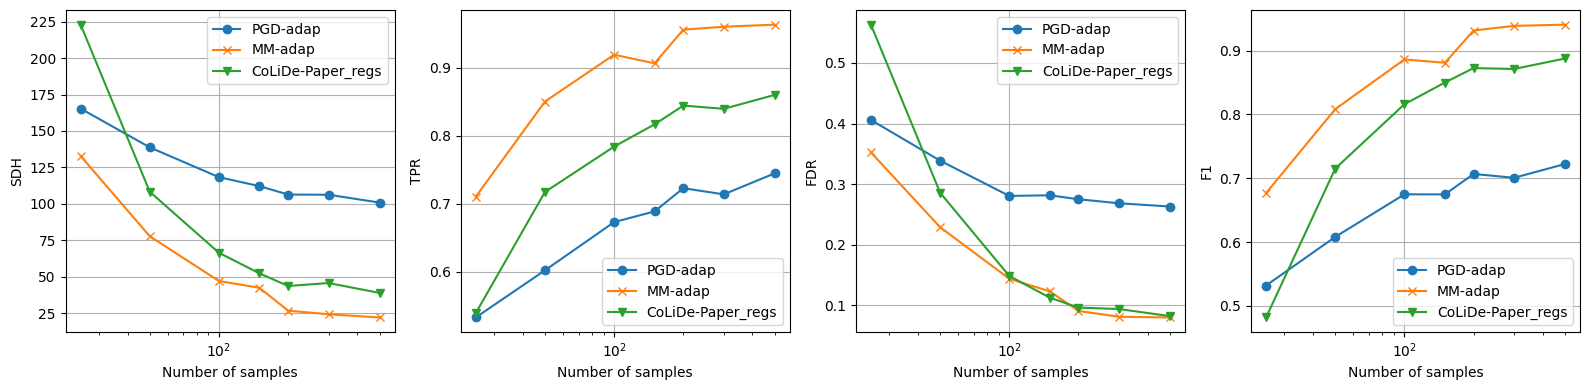

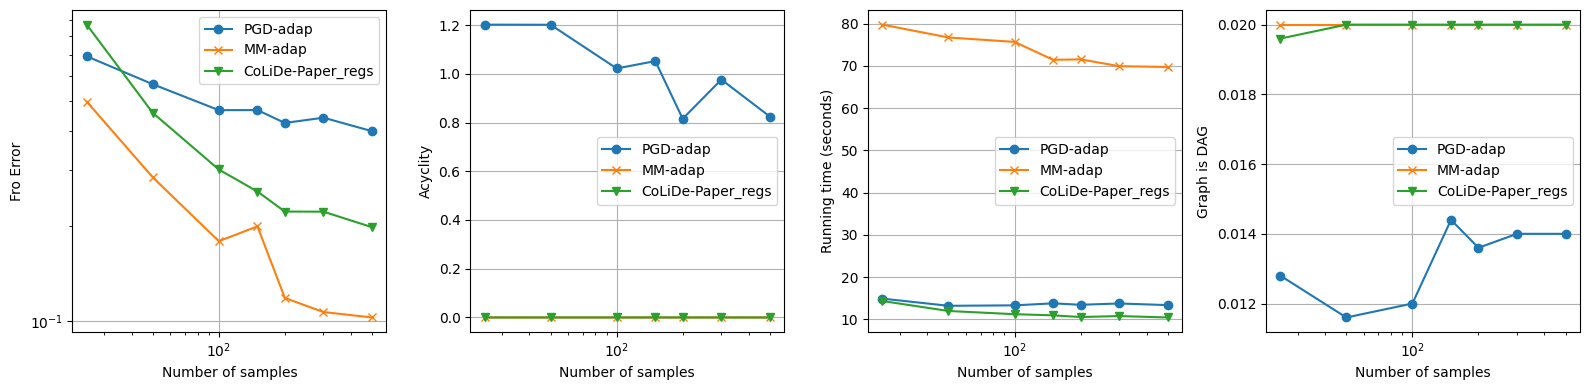

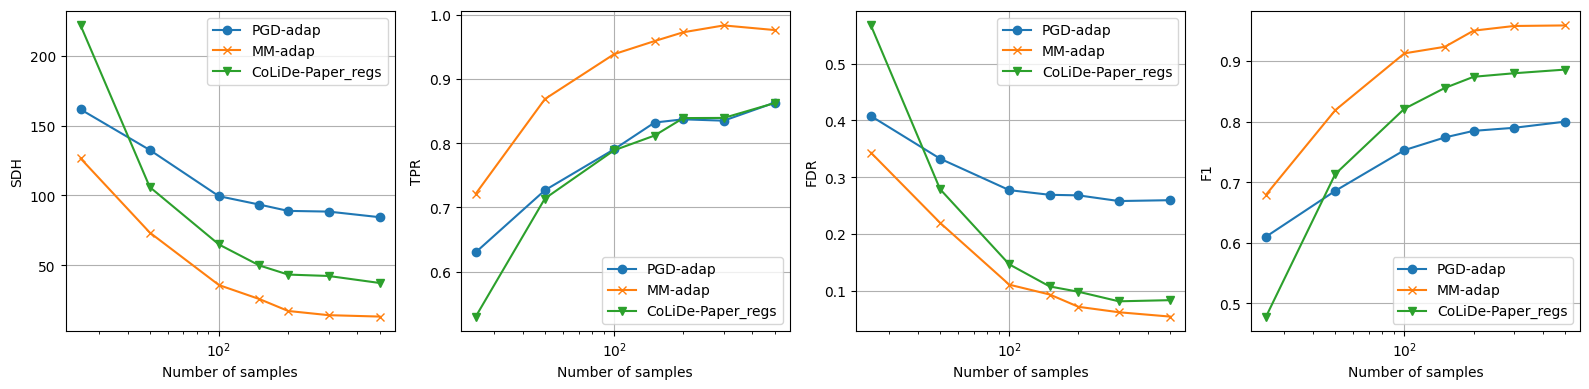

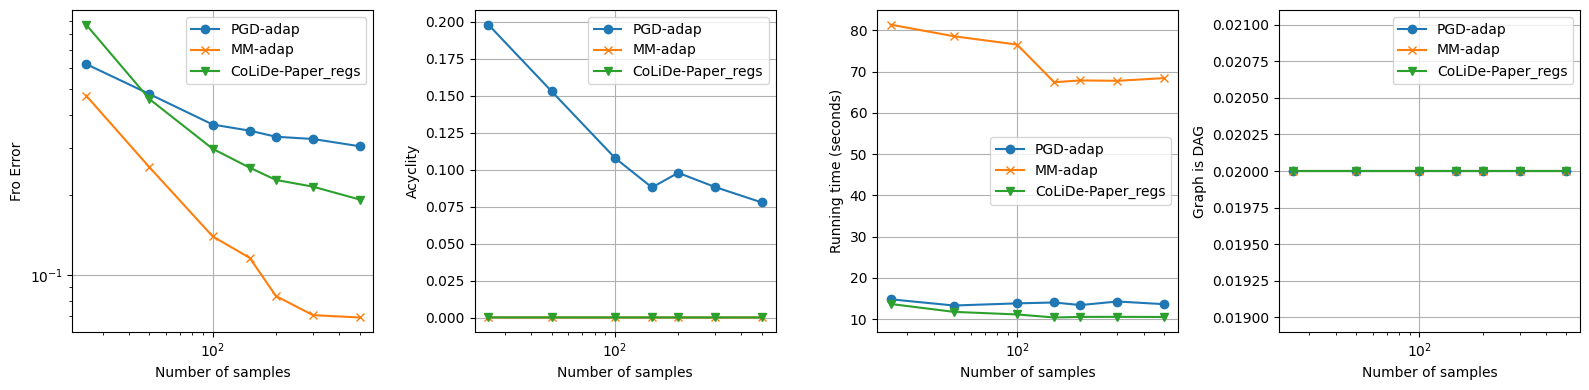

In [12]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


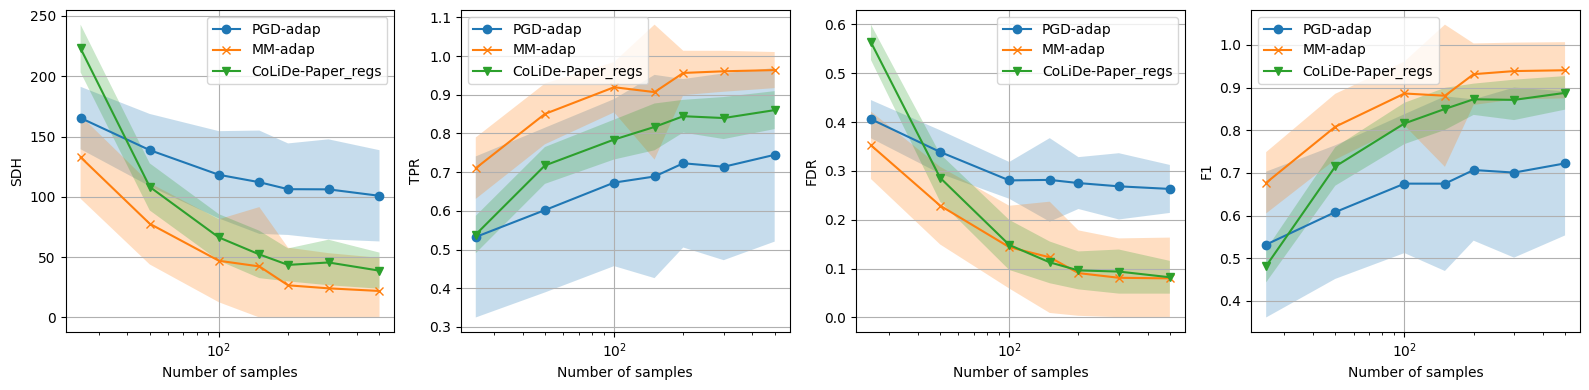

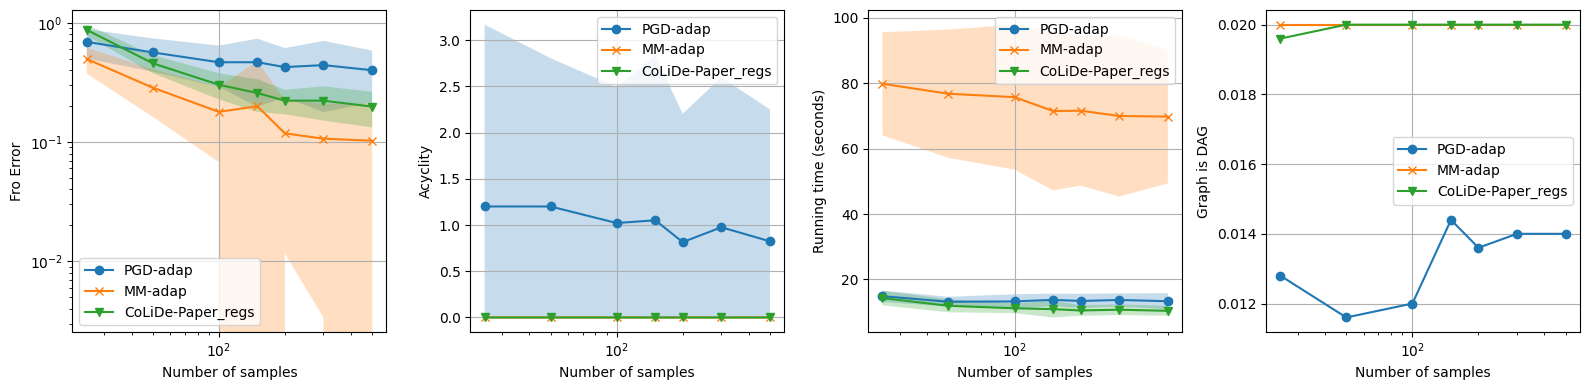

In [13]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

# plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
#                  skip_idx=skip, agg='median', dev=True)


### 100 nodes

In [14]:
N_samples = [50, 100, 150, 200, 300, 500, 750, 1000] 
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {t_end-t_init:.3} seconds -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)
dag_count = np.array(dag_count)/n_dags

CPUs employed: 32
Graph: 1, samples: 50


Graph: 2, samples: 50
Graph: 3, samples: 50
Graph: 4, samples: 50
Graph: 5, samples: 50
Graph: 6, samples: 50
Graph: 7, samples: 50
Graph: 8, samples: 50
Graph: 9, samples: 50
Graph: 10, samples: 50
Graph: 11, samples: 50
Graph: 12, samples: 50
Graph: 13, samples: 50
Graph: 14, samples: 50
Graph: 15, samples: 50
Graph: 16, samples: 50
Graph: 17, samples: 50
Graph: 18, samples: 50
Graph: 25, samples: 50
Graph: 26, samples: 50
Graph: 23, samples: 50
Graph: 24, samples: 50
Graph: 22, samples: 50
Graph: 32, samples: 50
Graph: 19, samples: 50
Graph: 27, samples: 50
Graph: 20, samples: 50
Graph: 21, samples: 50
Graph: 28, samples: 50
Graph: 29, samples: 50
Graph: 30, samples: 50
Graph: 31, samples: 50
		-PGD-adap: shd 131.0  -  err: 0.676  -  time: 44.082
		-PGD-adap: shd 125.0  -  err: 0.610  -  time: 52.305
		-PGD-adap: shd 123.0  -  err: 0.571  -  time: 57.231
		-PGD-adap: shd 145.0  -  err: 0.671  -  time: 58.855
		-PGD-adap: shd 109.0  -  err: 0.596  -  time: 62.844
		-PGD-adap: shd 106

  4%|▍         | 5072/130000.0 [00:13<05:58, 348.16it/s]

		-MM-adap: shd 73.0  -  err: 0.222  -  time: 273.063


  0%|          | 0/130000.0 [00:00<?, ?it/s] 404.60it/s]

		-MM-adap: shd 77.0  -  err: 0.306  -  time: 283.709


  0%|          | 30/130000.0 [00:00<07:19, 295.86it/s]s]/s]

		-MM-adap: shd 54.0  -  err: 0.198  -  time: 281.707


  4%|▎         | 4731/130000.0 [00:12<05:36, 372.08it/s]

		-MM-adap: shd 65.0  -  err: 0.238  -  time: 303.074


  0%|          | 0/130000.0 [00:00<?, ?it/s]14.35it/s]]]

		-MM-adap: shd 66.0  -  err: 0.210  -  time: 288.081
		-MM-adap: shd 56.0  -  err: 0.250  -  time: 290.621


  0%|          | 173/130000.0 [00:00<09:04, 238.37it/s]]

		-MM-adap: shd 76.0  -  err: 0.323  -  time: 282.701


  1%|▏         | 1857/130000.0 [00:07<06:55, 308.29it/s]s] 

		-MM-adap: shd 81.0  -  err: 0.289  -  time: 284.500


  0%|          | 30/130000.0 [00:00<07:15, 298.52it/s]s]s]

		-MM-adap: shd 82.0  -  err: 0.299  -  time: 293.953


  6%|▌         | 7548/130000.0 [00:22<06:38, 307.55it/s]s]

		-MM-adap: shd 68.0  -  err: 0.290  -  time: 300.239


  4%|▍         | 5580/130000.0 [00:18<08:03, 257.10it/s]]

		-MM-adap: shd 71.0  -  err: 0.318  -  time: 306.421


  5%|▍         | 6119/130000.0 [00:24<07:58, 259.01it/s]]s]

		-MM-adap: shd 63.0  -  err: 0.270  -  time: 300.591


  1%|          | 1517/130000.0 [00:04<06:21, 337.19it/s]]

		-MM-adap: shd 107.0  -  err: 0.456  -  time: 308.069


  1%|▏         | 1752/130000.0 [00:05<10:47, 198.18it/s]]

		-MM-adap: shd 62.0  -  err: 0.219  -  time: 323.907


  7%|▋         | 9538/130000.0 [00:30<04:11, 478.54it/s]/s]

		-MM-adap: shd 86.0  -  err: 0.262  -  time: 305.249


  2%|▏         | 2212/130000.0 [00:08<09:55, 214.43it/s]]] 

		-MM-adap: shd 75.0  -  err: 0.295  -  time: 342.445


  7%|▋         | 9389/130000.0 [00:35<06:46, 296.38it/s]]s]

		-MM-adap: shd 81.0  -  err: 0.253  -  time: 316.375


  7%|▋         | 8572/130000.0 [00:22<01:42, 1182.60it/s]

		-MM-adap: shd 77.0  -  err: 0.308  -  time: 315.556


  0%|          | 558/130000.0 [00:02<11:37, 185.68it/s]]] ]

		-MM-adap: shd 69.0  -  err: 0.259  -  time: 325.503


  1%|          | 1561/130000.0 [00:03<05:23, 397.19it/s]]] 

		-MM-adap: shd 57.0  -  err: 0.233  -  time: 321.773


 13%|█▎        | 16601/130000.0 [00:41<11:20, 166.65it/s]

		-MM-adap: shd 57.0  -  err: 0.272  -  time: 326.649


  4%|▍         | 5398/130000.0 [00:09<04:47, 433.84it/s]]  

		-MM-adap: shd 79.0  -  err: 0.266  -  time: 333.206


  3%|▎         | 3792/130000.0 [00:14<13:19, 157.78it/s]]s]

		-MM-adap: shd 63.0  -  err: 0.261  -  time: 332.791


  6%|▌         | 7614/130000.0 [00:18<02:38, 771.59it/s]]]]

		-MM-adap: shd 79.0  -  err: 0.326  -  time: 332.670
		-MM-adap: shd 66.0  -  err: 0.263  -  time: 345.743


  7%|▋         | 9389/130000.0 [00:33<06:32, 307.38it/s]]s]

		-MM-adap: shd 97.0  -  err: 0.352  -  time: 353.179


  6%|▌         | 7275/130000.0 [00:22<10:55, 187.35it/s]]]

		-MM-adap: shd 70.0  -  err: 0.254  -  time: 343.061


  3%|▎         | 3716/130000.0 [00:13<12:51, 163.63it/s]]  

		-MM-adap: shd 69.0  -  err: 0.246  -  time: 348.444


 20%|█▉        | 25966/130000.0 [00:44<03:14, 534.88it/s]s]

		-MM-adap: shd 69.0  -  err: 0.285  -  time: 347.240


100%|██████████| 130000/130000.0 [01:41<00:00, 1278.90it/s]
  3%|▎         | 3585/130000.0 [00:05<03:57, 531.49it/s]]

		-CoLiDe-Paper_regs: shd 109.0  -  err: 0.419  -  time: 101.655
Graph: 19, samples: 100


 12%|█▏        | 15707/130000.0 [00:35<03:56, 482.27it/s]]]

		-MM-adap: shd 65.0  -  err: 0.277  -  time: 369.684


100%|██████████| 130000/130000.0 [01:28<00:00, 1466.16it/s]
 34%|███▍      | 44278/130000.0 [01:06<03:35, 397.27it/s]  

		-CoLiDe-Paper_regs: shd 102.0  -  err: 0.393  -  time: 88.676
Graph: 25, samples: 100


100%|██████████| 130000/130000.0 [01:13<00:00, 1758.09it/s]
 20%|█▉        | 25437/130000.0 [00:51<14:57, 116.56it/s]

		-CoLiDe-Paper_regs: shd 111.0  -  err: 0.387  -  time: 73.947
Graph: 14, samples: 100


100%|██████████| 130000/130000.0 [02:07<00:00, 1020.04it/s]
 36%|███▌      | 46172/130000.0 [02:01<07:23, 188.80it/s]

		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.405  -  time: 127.448
Graph: 3, samples: 100


 22%|██▏       | 28310/130000.0 [01:21<12:46, 132.69it/s]s]

		-MM-adap: shd 78.0  -  err: 0.257  -  time: 396.964


100%|██████████| 130000/130000.0 [02:14<00:00, 966.81it/s] 
 36%|███▌      | 46542/130000.0 [02:03<05:16, 264.00it/s]

		-CoLiDe-Paper_regs: shd 128.0  -  err: 0.423  -  time: 134.469
Graph: 32, samples: 100


100%|██████████| 130000/130000.0 [01:36<00:00, 1344.23it/s]
 23%|██▎       | 30331/130000.0 [01:18<05:22, 308.62it/s]] 

		-CoLiDe-Paper_regs: shd 97.0  -  err: 0.327  -  time: 96.711
Graph: 5, samples: 100


100%|██████████| 130000/130000.0 [01:38<00:00, 1321.18it/s]
 37%|███▋      | 47685/130000.0 [01:55<05:23, 254.15it/s]

		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.293  -  time: 98.407
Graph: 22, samples: 100


100%|██████████| 130000/130000.0 [01:26<00:00, 1511.52it/s]
 53%|█████▎    | 69469/130000.0 [02:20<04:02, 249.26it/s]

		-CoLiDe-Paper_regs: shd 96.0  -  err: 0.363  -  time: 86.019
Graph: 30, samples: 100


100%|██████████| 130000/130000.0 [01:58<00:00, 1096.15it/s]
 37%|███▋      | 47913/130000.0 [01:13<05:22, 254.92it/s]

		-CoLiDe-Paper_regs: shd 124.0  -  err: 0.482  -  time: 118.598
Graph: 6, samples: 100


100%|██████████| 130000/130000.0 [02:23<00:00, 905.96it/s]   
 38%|███▊      | 49611/130000.0 [02:03<15:00, 89.29it/s]]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.377  -  time: 143.498
Graph: 11, samples: 100


 51%|█████     | 66058/130000.0 [02:25<03:49, 278.10it/s]]]

		-PGD-adap: shd 97.0  -  err: 0.456  -  time: 46.069


100%|██████████| 130000/130000.0 [02:02<00:00, 1061.10it/s]
  7%|▋         | 8544/130000.0 [00:31<04:59, 405.60it/s]]

		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.392  -  time: 122.528
Graph: 9, samples: 100


100%|██████████| 130000/130000.0 [02:30<00:00, 861.06it/s]
 36%|███▌      | 47079/130000.0 [01:23<05:57, 231.66it/s]

		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.342  -  time: 150.983
Graph: 12, samples: 100


100%|██████████| 130000/130000.0 [02:36<00:00, 830.67it/s] 
 52%|█████▏    | 66993/130000.0 [01:41<05:03, 207.64it/s]  

		-CoLiDe-Paper_regs: shd 86.0  -  err: 0.316  -  time: 156.516
Graph: 24, samples: 100


100%|██████████| 130000/130000.0 [02:38<00:00, 822.50it/s] 
 33%|███▎      | 42990/130000.0 [01:07<03:26, 420.87it/s]

		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.412  -  time: 158.067
Graph: 26, samples: 100


100%|██████████| 130000/130000.0 [02:33<00:00, 847.87it/s]
 57%|█████▋    | 74573/130000.0 [02:25<02:59, 309.14it/s]

		-CoLiDe-Paper_regs: shd 106.0  -  err: 0.394  -  time: 153.326
Graph: 4, samples: 100


100%|██████████| 130000/130000.0 [02:06<00:00, 1024.22it/s]
 34%|███▍      | 44783/130000.0 [01:58<05:00, 283.71it/s]

		-CoLiDe-Paper_regs: shd 118.0  -  err: 0.407  -  time: 126.928
Graph: 7, samples: 100


100%|██████████| 130000/130000.0 [01:47<00:00, 1207.88it/s]
 51%|█████     | 66499/130000.0 [02:47<02:15, 469.91it/s]

		-CoLiDe-Paper_regs: shd 120.0  -  err: 0.399  -  time: 107.640
Graph: 31, samples: 100


100%|██████████| 130000/130000.0 [02:17<00:00, 946.97it/s]  
 52%|█████▏    | 66981/130000.0 [02:49<06:17, 166.93it/s]

		-CoLiDe-Paper_regs: shd 88.0  -  err: 0.367  -  time: 137.282
Graph: 13, samples: 100


100%|██████████| 130000/130000.0 [02:49<00:00, 765.67it/s]
 53%|█████▎    | 69524/130000.0 [01:52<05:25, 186.06it/s]

		-CoLiDe-Paper_regs: shd 98.0  -  err: 0.354  -  time: 169.798
Graph: 29, samples: 100


 36%|███▌      | 46249/130000.0 [01:19<07:18, 190.89it/s] ]

		-PGD-adap: shd 96.0  -  err: 0.471  -  time: 96.084


 61%|██████    | 79148/130000.0 [02:41<02:33, 330.77it/s] 

		-PGD-adap: shd 107.0  -  err: 0.556  -  time: 53.676


 48%|████▊     | 62678/130000.0 [02:13<04:00, 279.67it/s]s]
 53%|█████▎    | 68708/130000.0 [02:33<04:33, 224.10it/s]

		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.349  -  time: 120.354
Graph: 18, samples: 100


100%|██████████| 130000/130000.0 [01:47<00:00, 1213.38it/s] 
 37%|███▋      | 47621/130000.0 [01:25<07:35, 180.69it/s]

		-CoLiDe-Paper_regs: shd 108.0  -  err: 0.391  -  time: 107.141
Graph: 2, samples: 100


100%|██████████| 130000/130000.0 [02:01<00:00, 1069.39it/s]


		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.433  -  time: 121.566
Graph: 8, samples: 100


100%|██████████| 130000/130000.0 [02:39<00:00, 816.03it/s] 
 62%|██████▏   | 80864/130000.0 [02:47<02:23, 342.50it/s]

		-CoLiDe-Paper_regs: shd 91.0  -  err: 0.373  -  time: 159.315
Graph: 27, samples: 100


100%|██████████| 130000/130000.0 [02:52<00:00, 751.49it/s]]
 23%|██▎       | 29598/130000.0 [01:06<04:05, 408.67it/s]

		-CoLiDe-Paper_regs: shd 95.0  -  err: 0.391  -  time: 172.999
Graph: 21, samples: 100


100%|██████████| 130000/130000.0 [02:24<00:00, 896.98it/s]
 51%|█████     | 65782/130000.0 [02:48<03:29, 305.96it/s]

		-CoLiDe-Paper_regs: shd 126.0  -  err: 0.532  -  time: 144.935
Graph: 16, samples: 100


100%|██████████| 130000/130000.0 [02:04<00:00, 1044.77it/s]
 54%|█████▍    | 70042/130000.0 [02:33<02:06, 472.21it/s]

		-CoLiDe-Paper_regs: shd 151.0  -  err: 0.482  -  time: 124.431
Graph: 1, samples: 100


100%|██████████| 130000/130000.0 [02:54<00:00, 744.47it/s] 
 54%|█████▍    | 70486/130000.0 [02:34<02:20, 424.15it/s]

		-CoLiDe-Paper_regs: shd 122.0  -  err: 0.476  -  time: 174.623
Graph: 15, samples: 100


100%|██████████| 130000/130000.0 [02:32<00:00, 851.64it/s] 


		-CoLiDe-Paper_regs: shd 109.0  -  err: 0.349  -  time: 152.648
Graph: 10, samples: 100
		-CoLiDe-Paper_regs: shd 103.0  -  err: 0.429  -  time: 156.081
Graph: 23, samples: 100


100%|██████████| 130000/130000.0 [02:36<00:00, 832.97it/s]
 55%|█████▌    | 71839/130000.0 [02:22<02:19, 416.04it/s]

		-PGD-adap: shd 81.0  -  err: 0.445  -  time: 78.988


100%|██████████| 130000/130000.0 [02:23<00:00, 907.25it/s]


		-CoLiDe-Paper_regs: shd 95.0  -  err: 0.340  -  time: 143.292
Graph: 17, samples: 100
		-PGD-adap: shd 93.0  -  err: 0.403  -  time: 91.530


 52%|█████▏    | 67946/130000.0 [01:55<01:44, 592.13it/s]  

		-PGD-adap: shd 93.0  -  err: 0.416  -  time: 68.355


 35%|███▍      | 45379/130000.0 [01:28<02:12, 637.53it/s]

		-PGD-adap: shd 77.0  -  err: 0.451  -  time: 88.467


100%|██████████| 130000/130000.0 [01:59<00:00, 1090.95it/s] 


		-CoLiDe-Paper_regs: shd 89.0  -  err: 0.374  -  time: 119.173
Graph: 20, samples: 100


 46%|████▌     | 60016/130000.0 [01:37<00:02, 26721.16it/s]

		-PGD-adap: shd 93.0  -  err: 0.459  -  time: 84.497
		-PGD-adap: shd 80.0  -  err: 0.397  -  time: 71.367
		-PGD-adap: shd 78.0  -  err: 0.419  -  time: 83.692


 49%|████▊     | 63137/130000.0 [01:45<00:50, 1335.98it/s] 

		-PGD-adap: shd 82.0  -  err: 0.456  -  time: 71.579
		-PGD-adap: shd 80.0  -  err: 0.443  -  time: 87.272
		-PGD-adap: shd 105.0  -  err: 0.434  -  time: 68.586
		-PGD-adap: shd 91.0  -  err: 0.439  -  time: 72.478


 50%|█████     | 65334/130000.0 [01:51<01:18, 828.24it/s] 

		-PGD-adap: shd 86.0  -  err: 0.394  -  time: 84.047


 51%|█████▏    | 66883/130000.0 [01:56<01:35, 658.23it/s]

		-PGD-adap: shd 102.0  -  err: 0.531  -  time: 71.849
		-PGD-adap: shd 95.0  -  err: 0.500  -  time: 76.159


100%|██████████| 130000/130000.0 [02:00<00:00, 1075.97it/s]


		-PGD-adap: shd 74.0  -  err: 0.374  -  time: 73.659
		-CoLiDe-Paper_regs: shd 110.0  -  err: 0.447  -  time: 120.835
Graph: 28, samples: 100
		-PGD-adap: shd 98.0  -  err: 0.469  -  time: 82.365
		-PGD-adap: shd 97.0  -  err: 0.435  -  time: 69.263
		-PGD-adap: shd 113.0  -  err: 0.485  -  time: 70.745
		-PGD-adap: shd 86.0  -  err: 0.456  -  time: 58.328
		-PGD-adap: shd 87.0  -  err: 0.469  -  time: 74.794
		-PGD-adap: shd 81.0  -  err: 0.437  -  time: 78.155
		-PGD-adap: shd 92.0  -  err: 0.441  -  time: 66.056
		-PGD-adap: shd 104.0  -  err: 0.471  -  time: 69.968
		-PGD-adap: shd 91.0  -  err: 0.429  -  time: 79.529
		-PGD-adap: shd 76.0  -  err: 0.444  -  time: 79.666
		-PGD-adap: shd 101.0  -  err: 0.455  -  time: 77.573
		-PGD-adap: shd 76.0  -  err: 0.404  -  time: 83.258
		-PGD-adap: shd 105.0  -  err: 0.453  -  time: 76.118
		-PGD-adap: shd 86.0  -  err: 0.487  -  time: 66.338
		-MM-adap: shd 32.0  -  err: 0.142  -  time: 281.991


  0%|          | 23/130000.0 [00:00<09:37, 224.94it/s]]

		-MM-adap: shd 21.0  -  err: 0.102  -  time: 260.784


  7%|▋         | 9593/130000.0 [00:28<08:36, 233.27it/s]/s]

		-MM-adap: shd 30.0  -  err: 0.168  -  time: 281.802


  0%|          | 64/130000.0 [00:00<03:24, 634.35it/s]s]/s]

		-MM-adap: shd 22.0  -  err: 0.117  -  time: 271.841


  0%|          | 31/130000.0 [00:00<07:25, 291.60it/s]s] 

		-MM-adap: shd 13.0  -  err: 0.082  -  time: 263.780
		-MM-adap: shd 19.0  -  err: 0.106  -  time: 273.012


  4%|▎         | 4822/130000.0 [00:07<06:24, 325.26it/s]s] 

		-MM-adap: shd 43.0  -  err: 0.205  -  time: 237.955


  2%|▏         | 3156/130000.0 [00:10<07:18, 289.53it/s]] 

		-MM-adap: shd 13.0  -  err: 0.086  -  time: 264.303


  0%|          | 29/130000.0 [00:00<07:29, 289.00it/s]/s]

		-MM-adap: shd 20.0  -  err: 0.105  -  time: 258.981


  1%|▏         | 1728/130000.0 [00:06<07:38, 279.93it/s]/s]

		-MM-adap: shd 22.0  -  err: 0.134  -  time: 284.513


  5%|▍         | 6184/130000.0 [00:19<05:21, 385.01it/s]

		-MM-adap: shd 16.0  -  err: 0.096  -  time: 230.860


  6%|▌         | 7425/130000.0 [00:25<06:08, 332.63it/s]

		-MM-adap: shd 15.0  -  err: 0.080  -  time: 271.340


  1%|▏         | 1640/130000.0 [00:04<06:57, 307.31it/s]]  

		-MM-adap: shd 14.0  -  err: 0.083  -  time: 249.716


  2%|▏         | 2179/130000.0 [00:06<06:30, 326.98it/s]]  

		-MM-adap: shd 17.0  -  err: 0.108  -  time: 267.301


  7%|▋         | 9713/130000.0 [00:35<08:53, 225.37it/s]] 

		-MM-adap: shd 21.0  -  err: 0.102  -  time: 265.850


100%|██████████| 130000/130000.0 [01:16<00:00, 1697.58it/s]
  4%|▍         | 5426/130000.0 [00:20<05:55, 350.64it/s]]s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.109  -  time: 76.581
Graph: 19, samples: 150


  4%|▍         | 5359/130000.0 [00:18<06:15, 332.09it/s]]s]

		-MM-adap: shd 22.0  -  err: 0.094  -  time: 270.214


  2%|▏         | 2411/130000.0 [00:04<02:42, 783.49it/s]]  

		-MM-adap: shd 26.0  -  err: 0.102  -  time: 290.184


  6%|▋         | 8429/130000.0 [00:25<05:05, 398.25it/s]]s]

		-MM-adap: shd 25.0  -  err: 0.127  -  time: 303.721


  0%|          | 0/130000.0 [00:00<?, ?it/s], 283.56it/s]  

		-MM-adap: shd 15.0  -  err: 0.093  -  time: 288.090


 10%|▉         | 12981/130000.0 [00:33<06:50, 285.41it/s] 

		-MM-adap: shd 22.0  -  err: 0.116  -  time: 278.977


 10%|█         | 13349/130000.0 [00:46<11:53, 163.53it/s]s]

		-MM-adap: shd 17.0  -  err: 0.094  -  time: 304.005


  0%|          | 0/130000.0 [00:00<?, ?it/s] 187.26it/s]]] 

		-MM-adap: shd 15.0  -  err: 0.085  -  time: 293.843


  1%|          | 1067/130000.0 [00:03<07:30, 286.34it/s]]s]

		-MM-adap: shd 22.0  -  err: 0.093  -  time: 259.690


  3%|▎         | 3634/130000.0 [00:11<06:22, 330.64it/s]]] 

		-MM-adap: shd 25.0  -  err: 0.135  -  time: 273.554


  3%|▎         | 4465/130000.0 [00:16<07:17, 287.07it/s]]]]

		-MM-adap: shd 13.0  -  err: 0.108  -  time: 315.122


  6%|▌         | 7853/130000.0 [00:20<04:40, 435.12it/s]]]

		-MM-adap: shd 19.0  -  err: 0.129  -  time: 290.377


100%|██████████| 130000/130000.0 [01:39<00:00, 1311.98it/s] 
  6%|▌         | 7247/130000.0 [00:22<07:34, 270.03it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.162  -  time: 99.088
Graph: 5, samples: 150


  6%|▋         | 8240/130000.0 [00:26<08:39, 234.55it/s]]] 

		-MM-adap: shd 21.0  -  err: 0.142  -  time: 293.451


  4%|▍         | 5068/130000.0 [00:21<07:10, 290.15it/s]] ]

		-MM-adap: shd 18.0  -  err: 0.100  -  time: 306.709


100%|██████████| 130000/130000.0 [02:26<00:00, 886.86it/s]   
  5%|▍         | 6016/130000.0 [00:24<07:23, 279.73it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.087  -  time: 146.585
Graph: 25, samples: 150


 34%|███▎      | 43602/130000.0 [01:20<01:38, 878.71it/s]  

		-MM-adap: shd 24.0  -  err: 0.111  -  time: 291.264


 36%|███▋      | 47352/130000.0 [01:21<05:20, 258.08it/s]

		-MM-adap: shd 35.0  -  err: 0.168  -  time: 332.241


100%|██████████| 130000/130000.0 [01:51<00:00, 1163.87it/s]
 34%|███▍      | 44605/130000.0 [01:16<06:23, 222.69it/s]s]

		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.140  -  time: 111.697
Graph: 30, samples: 150


100%|██████████| 130000/130000.0 [01:56<00:00, 1120.58it/s]
  1%|▏         | 1687/130000.0 [00:06<11:31, 185.67it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.110  -  time: 116.013
Graph: 3, samples: 150


100%|██████████| 130000/130000.0 [01:20<00:00, 1614.08it/s]
 11%|█▏        | 14735/130000.0 [00:51<09:51, 194.87it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.130  -  time: 80.543
Graph: 2, samples: 150


100%|██████████| 130000/130000.0 [01:33<00:00, 1394.74it/s]
 41%|████      | 53325/130000.0 [01:59<02:37, 485.66it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.139  -  time: 93.208
Graph: 12, samples: 150


100%|██████████| 130000/130000.0 [01:39<00:00, 1309.57it/s]
100%|██████████| 130000/130000.0 [01:46<00:00, 1216.10it/s]
 36%|███▌      | 46813/130000.0 [01:10<03:15, 425.79it/s]

		-MM-adap: shd 25.0  -  err: 0.125  -  time: 334.463
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.092  -  time: 99.275
Graph: 8, samples: 150
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.123  -  time: 106.901
Graph: 32, samples: 150


 51%|█████     | 66377/130000.0 [01:51<03:02, 348.00it/s]  

		-PGD-adap: shd 72.0  -  err: 0.387  -  time: 99.928


100%|██████████| 130000/130000.0 [01:41<00:00, 1279.46it/s]
 24%|██▍       | 31229/130000.0 [02:00<09:21, 176.03it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.152  -  time: 101.609
Graph: 31, samples: 150


100%|██████████| 130000/130000.0 [01:53<00:00, 1149.65it/s] 
  2%|▏         | 2122/130000.0 [00:09<08:16, 257.65it/s]]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.088  -  time: 113.079
Graph: 6, samples: 150


100%|██████████| 130000/130000.0 [02:25<00:00, 891.22it/s]   
 55%|█████▍    | 71157/130000.0 [02:10<02:54, 336.29it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.111  -  time: 145.869
Graph: 14, samples: 150


100%|██████████| 130000/130000.0 [02:04<00:00, 1041.32it/s]
 27%|██▋       | 34579/130000.0 [02:13<07:50, 202.98it/s] 

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.093  -  time: 124.844
Graph: 23, samples: 150


100%|██████████| 130000/130000.0 [01:42<00:00, 1269.85it/s]
 51%|█████     | 66055/130000.0 [02:25<03:22, 315.95it/s]s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.138  -  time: 102.376
Graph: 7, samples: 150


100%|██████████| 130000/130000.0 [01:27<00:00, 1493.33it/s]
 18%|█▊        | 23325/130000.0 [00:48<02:43, 653.73it/s]

		-CoLiDe-Paper_regs: shd 23.0  -  err: 0.108  -  time: 87.055
Graph: 10, samples: 150


100%|██████████| 130000/130000.0 [02:28<00:00, 872.54it/s]
 21%|██        | 27242/130000.0 [01:21<02:52, 594.02it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.175  -  time: 148.991
Graph: 13, samples: 150


100%|██████████| 130000/130000.0 [02:20<00:00, 924.48it/s]   
 18%|█▊        | 23907/130000.0 [00:50<03:35, 493.34it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.093  -  time: 140.622
Graph: 9, samples: 150


100%|██████████| 130000/130000.0 [01:45<00:00, 1232.11it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.095  -  time: 105.512
Graph: 22, samples: 150


 22%|██▏       | 28223/130000.0 [01:23<04:04, 416.14it/s]]

		-MM-adap: shd 18.0  -  err: 0.101  -  time: 321.105


100%|██████████| 130000/130000.0 [01:43<00:00, 1251.23it/s]
  1%|▏         | 1882/130000.0 [00:05<05:35, 381.63it/s]]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.123  -  time: 103.901
Graph: 1, samples: 150


100%|██████████| 130000/130000.0 [01:30<00:00, 1429.19it/s]
 20%|██        | 26022/130000.0 [00:59<10:31, 164.54it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.128  -  time: 90.964
Graph: 26, samples: 150


 21%|██        | 27430/130000.0 [01:05<04:54, 348.38it/s]  

		-PGD-adap: shd 82.0  -  err: 0.424  -  time: 86.389


100%|██████████| 130000/130000.0 [01:52<00:00, 1160.68it/s]
 33%|███▎      | 43482/130000.0 [02:38<05:55, 243.69it/s]

		-CoLiDe-Paper_regs: shd 27.0  -  err: 0.154  -  time: 112.009
Graph: 11, samples: 150


100%|██████████| 130000/130000.0 [02:01<00:00, 1068.60it/s]
 51%|█████     | 66000/130000.0 [01:30<01:49, 586.99it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.096  -  time: 121.656
Graph: 4, samples: 150


 51%|█████     | 66244/130000.0 [01:31<02:04, 512.12it/s]s]

		-PGD-adap: shd 76.0  -  err: 0.414  -  time: 41.756


100%|██████████| 130000/130000.0 [01:34<00:00, 1378.43it/s]
 37%|███▋      | 47839/130000.0 [01:49<03:26, 397.99it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.109  -  time: 94.311
Graph: 16, samples: 150


100%|██████████| 130000/130000.0 [01:45<00:00, 1236.22it/s]
 38%|███▊      | 49915/130000.0 [01:23<03:04, 433.66it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.110  -  time: 105.161
Graph: 27, samples: 150


  8%|▊         | 10534/130000.0 [00:35<06:53, 289.25it/s]s]

		-PGD-adap: shd 76.0  -  err: 0.400  -  time: 88.895


100%|██████████| 130000/130000.0 [02:09<00:00, 1006.75it/s]
 38%|███▊      | 48842/130000.0 [02:56<04:48, 281.48it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.128  -  time: 129.133
Graph: 29, samples: 150


 10%|▉         | 12415/130000.0 [00:40<04:43, 414.53it/s]] 

		-PGD-adap: shd 62.0  -  err: 0.360  -  time: 85.514


 10%|▉         | 12792/130000.0 [00:41<05:01, 388.69it/s]s]

		-PGD-adap: shd 69.0  -  err: 0.391  -  time: 69.114


 10%|█         | 13038/130000.0 [00:41<05:24, 360.24it/s]

		-PGD-adap: shd 78.0  -  err: 0.382  -  time: 84.585


100%|██████████| 130000/130000.0 [02:09<00:00, 1007.32it/s]
 36%|███▌      | 46804/130000.0 [01:35<04:39, 297.53it/s]s]

		-CoLiDe-Paper_regs: shd 28.0  -  err: 0.161  -  time: 129.057
Graph: 15, samples: 150


 37%|███▋      | 47607/130000.0 [01:37<03:26, 398.51it/s]] 

		-PGD-adap: shd 63.0  -  err: 0.359  -  time: 79.943


100%|██████████| 130000/130000.0 [01:48<00:00, 1203.70it/s]


		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.125  -  time: 108.002
Graph: 17, samples: 150


 49%|████▉     | 63950/130000.0 [01:42<01:25, 771.52it/s]

		-PGD-adap: shd 71.0  -  err: 0.344  -  time: 79.413
		-PGD-adap: shd 73.0  -  err: 0.378  -  time: 55.922


 50%|████▉     | 64623/130000.0 [01:45<01:42, 634.88it/s] 

		-PGD-adap: shd 78.0  -  err: 0.423  -  time: 86.164


 50%|████▉     | 64833/130000.0 [01:45<01:48, 600.21it/s]

		-PGD-adap: shd 78.0  -  err: 0.421  -  time: 74.850


 51%|█████     | 65730/130000.0 [01:48<02:41, 398.04it/s]]

		-PGD-adap: shd 78.0  -  err: 0.438  -  time: 57.297


100%|██████████| 130000/130000.0 [03:24<00:00, 636.40it/s] 


		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.123  -  time: 204.289
Graph: 24, samples: 150


100%|██████████| 130000/130000.0 [01:32<00:00, 1411.87it/s]
 20%|█▉        | 25906/130000.0 [01:04<04:29, 386.26it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.147  -  time: 92.078
Graph: 21, samples: 150


100%|██████████| 130000/130000.0 [01:58<00:00, 1098.25it/s]


		-PGD-adap: shd 85.0  -  err: 0.435  -  time: 78.137
		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.158  -  time: 118.377
Graph: 20, samples: 150


 53%|█████▎    | 68514/130000.0 [02:05<01:57, 522.93it/s] 

		-PGD-adap: shd 89.0  -  err: 0.410  -  time: 40.639


100%|██████████| 130000/130000.0 [02:06<00:00, 1028.66it/s]


		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.091  -  time: 126.382
Graph: 18, samples: 150


 34%|███▍      | 44364/130000.0 [01:16<01:18, 1089.27it/s] 

		-PGD-adap: shd 71.0  -  err: 0.417  -  time: 84.511
		-PGD-adap: shd 80.0  -  err: 0.441  -  time: 80.896
		-PGD-adap: shd 110.0  -  err: 0.457  -  time: 86.277
		-PGD-adap: shd 78.0  -  err: 0.433  -  time: 81.494


 46%|████▌     | 60000/130000.0 [01:27<00:45, 1553.84it/s]

		-PGD-adap: shd 67.0  -  err: 0.362  -  time: 61.820
		-PGD-adap: shd 80.0  -  err: 0.412  -  time: 80.750
		-PGD-adap: shd 91.0  -  err: 0.408  -  time: 86.393


 47%|████▋     | 61701/130000.0 [01:32<01:00, 1132.24it/s]

		-PGD-adap: shd 76.0  -  err: 0.369  -  time: 69.146


 48%|████▊     | 62903/130000.0 [01:35<01:11, 943.07it/s] 

		-PGD-adap: shd 87.0  -  err: 0.442  -  time: 73.643
		-PGD-adap: shd 62.0  -  err: 0.373  -  time: 80.218


100%|██████████| 130000/130000.0 [01:45<00:00, 1229.73it/s]


		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.159  -  time: 105.717
Graph: 28, samples: 150
		-PGD-adap: shd 74.0  -  err: 0.407  -  time: 66.817
		-PGD-adap: shd 70.0  -  err: 0.358  -  time: 77.260
		-PGD-adap: shd 71.0  -  err: 0.428  -  time: 68.021
		-PGD-adap: shd 82.0  -  err: 0.424  -  time: 72.060
		-PGD-adap: shd 106.0  -  err: 0.498  -  time: 58.829
		-PGD-adap: shd 82.0  -  err: 0.392  -  time: 72.583
		-PGD-adap: shd 73.0  -  err: 0.377  -  time: 60.870
		-MM-adap: shd 15.0  -  err: 0.079  -  time: 221.913


 15%|█▌        | 20014/130000.0 [00:18<00:03, 30262.57it/s]

		-MM-adap: shd 22.0  -  err: 0.081  -  time: 197.315


 34%|███▍      | 44410/130000.0 [00:45<04:04, 350.15it/s]] 

		-MM-adap: shd 15.0  -  err: 0.090  -  time: 212.216


100%|██████████| 130000/130000.0 [01:17<00:00, 1676.90it/s]


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.103  -  time: 77.526
Graph: 19, samples: 200


  5%|▌         | 6785/130000.0 [00:15<05:37, 364.62it/s]]

		-MM-adap: shd 9.0  -  err: 0.061  -  time: 229.883


 40%|███▉      | 51432/130000.0 [01:01<02:54, 449.64it/s]

		-MM-adap: shd 9.0  -  err: 0.076  -  time: 240.474


  1%|          | 726/130000.0 [00:02<11:29, 187.47it/s]s]

		-MM-adap: shd 8.0  -  err: 0.073  -  time: 195.598


  1%|▏         | 1867/130000.0 [00:01<02:18, 926.82it/s]/s]

		-MM-adap: shd 16.0  -  err: 0.080  -  time: 250.571


  2%|▏         | 1968/130000.0 [00:06<07:27, 285.81it/s]]

		-MM-adap: shd 15.0  -  err: 0.104  -  time: 231.091
		-MM-adap: shd 12.0  -  err: 0.074  -  time: 240.046


  2%|▏         | 3244/130000.0 [00:10<06:06, 346.18it/s]]] 

		-MM-adap: shd 10.0  -  err: 0.084  -  time: 250.412


100%|██████████| 130000/130000.0 [01:14<00:00, 1751.54it/s]
  1%|          | 835/130000.0 [00:02<06:27, 333.62it/s]]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.075  -  time: 74.223
Graph: 6, samples: 200


  7%|▋         | 8991/130000.0 [00:26<12:34, 160.45it/s]]s]

		-MM-adap: shd 6.0  -  err: 0.055  -  time: 274.443


 15%|█▌        | 20025/130000.0 [00:26<00:03, 31232.17it/s]

		-MM-adap: shd 13.0  -  err: 0.094  -  time: 263.884


 32%|███▏      | 41474/130000.0 [00:34<00:40, 2163.56it/s]

		-MM-adap: shd 17.0  -  err: 0.087  -  time: 206.544


  4%|▍         | 4959/130000.0 [00:15<07:27, 279.41it/s]]] 

		-MM-adap: shd 13.0  -  err: 0.070  -  time: 238.963


  4%|▍         | 5522/130000.0 [00:17<05:48, 356.88it/s]] 

		-MM-adap: shd 15.0  -  err: 0.076  -  time: 236.452


 13%|█▎        | 16673/130000.0 [00:50<04:20, 434.21it/s]]]

		-MM-adap: shd 10.0  -  err: 0.068  -  time: 261.904


100%|██████████| 130000/130000.0 [00:54<00:00, 2385.18it/s]
  0%|          | 142/130000.0 [00:00<05:24, 399.94it/s]s]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.079  -  time: 54.504
Graph: 27, samples: 200


  5%|▍         | 6202/130000.0 [00:11<04:11, 491.35it/s]s]

		-MM-adap: shd 16.0  -  err: 0.083  -  time: 289.068


  0%|          | 0/130000.0 [00:00<?, ?it/s] 490.92it/s]s]

		-MM-adap: shd 14.0  -  err: 0.082  -  time: 265.871


  5%|▌         | 7052/130000.0 [00:12<04:07, 497.06it/s]]

		-MM-adap: shd 25.0  -  err: 0.100  -  time: 254.430


  6%|▋         | 8250/130000.0 [00:25<04:40, 434.59it/s]s]

		-MM-adap: shd 8.0  -  err: 0.046  -  time: 216.334


  0%|          | 0/130000.0 [00:00<?, ?it/s] 235.11it/s]]]

		-MM-adap: shd 27.0  -  err: 0.114  -  time: 278.119


  2%|▏         | 2248/130000.0 [00:07<05:34, 381.77it/s]]s]

		-MM-adap: shd 6.0  -  err: 0.062  -  time: 254.880


  1%|          | 733/130000.0 [00:03<09:22, 229.83it/s]s]] 

		-MM-adap: shd 17.0  -  err: 0.099  -  time: 339.988


  3%|▎         | 3347/130000.0 [00:11<06:56, 304.11it/s]]]

		-MM-adap: shd 11.0  -  err: 0.082  -  time: 275.939


  3%|▎         | 3936/130000.0 [00:09<06:09, 341.28it/s]]] 

		-MM-adap: shd 7.0  -  err: 0.072  -  time: 257.559


100%|██████████| 130000/130000.0 [01:35<00:00, 1354.86it/s]
  4%|▍         | 5432/130000.0 [00:20<06:09, 337.31it/s]]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.062  -  time: 95.960
Graph: 2, samples: 200


 52%|█████▏    | 67246/130000.0 [01:21<02:54, 360.49it/s]] 

		-MM-adap: shd 27.0  -  err: 0.108  -  time: 283.359


100%|██████████| 130000/130000.0 [01:24<00:00, 1545.23it/s]
  3%|▎         | 3273/130000.0 [00:11<08:24, 251.24it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.047  -  time: 84.131
Graph: 32, samples: 200


  3%|▎         | 3348/130000.0 [00:11<06:57, 303.16it/s]

		-PGD-adap: shd 57.0  -  err: 0.357  -  time: 87.444
		-MM-adap: shd 19.0  -  err: 0.104  -  time: 285.544


100%|██████████| 130000/130000.0 [01:15<00:00, 1731.96it/s]
  3%|▎         | 3481/130000.0 [00:13<08:48, 239.28it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.109  -  time: 75.061
Graph: 3, samples: 200


100%|██████████| 130000/130000.0 [01:33<00:00, 1395.97it/s]
  7%|▋         | 9314/130000.0 [00:36<08:18, 242.29it/s]]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.081  -  time: 93.128
Graph: 25, samples: 200


 10%|▉         | 12687/130000.0 [00:43<09:58, 196.00it/s]] 

		-PGD-adap: shd 93.0  -  err: 0.363  -  time: 86.799


100%|██████████| 130000/130000.0 [01:07<00:00, 1921.77it/s]
  5%|▌         | 6666/130000.0 [00:23<08:03, 255.32it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.055  -  time: 67.649
Graph: 31, samples: 200


100%|██████████| 130000/130000.0 [01:46<00:00, 1224.20it/s]
 12%|█▏        | 15887/130000.0 [00:56<04:32, 419.46it/s] ]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.100  -  time: 106.193
Graph: 22, samples: 200


100%|██████████| 130000/130000.0 [01:47<00:00, 1206.70it/s]
 31%|███       | 40000/130000.0 [00:50<00:49, 1828.23it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.101  -  time: 107.736
Graph: 12, samples: 200


100%|██████████| 130000/130000.0 [01:59<00:00, 1091.07it/s]
 34%|███▍      | 44467/130000.0 [01:07<03:44, 381.63it/s]] 

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.081  -  time: 119.151
Graph: 8, samples: 200


100%|██████████| 130000/130000.0 [01:26<00:00, 1496.99it/s]
 34%|███▍      | 44785/130000.0 [01:09<05:08, 275.79it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.044  -  time: 86.854
Graph: 30, samples: 200


  0%|          | 31/130000.0 [00:00<07:06, 304.67it/s]/s]]

		-MM-adap: shd 10.0  -  err: 0.086  -  time: 267.499


  0%|          | 374/130000.0 [00:01<06:44, 320.80it/s]s]  

		-PGD-adap: shd 85.0  -  err: 0.367  -  time: 65.932


100%|██████████| 130000/130000.0 [01:20<00:00, 1612.02it/s]
 26%|██▋       | 34347/130000.0 [01:07<05:17, 301.39it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.077  -  time: 80.648
Graph: 1, samples: 200


 37%|███▋      | 48213/130000.0 [01:20<09:40, 140.86it/s]s]

		-MM-adap: shd 16.0  -  err: 0.108  -  time: 278.239


 20%|██        | 26405/130000.0 [01:22<05:54, 292.48it/s]] 

		-PGD-adap: shd 73.0  -  err: 0.338  -  time: 57.927


  0%|          | 32/130000.0 [00:00<06:55, 312.50it/s]/s]] 

		-MM-adap: shd 29.0  -  err: 0.106  -  time: 286.734


100%|██████████| 130000/130000.0 [01:18<00:00, 1654.68it/s]
 24%|██▍       | 31028/130000.0 [01:14<05:22, 306.42it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.069  -  time: 78.567
Graph: 16, samples: 200


  2%|▏         | 2453/130000.0 [00:09<06:40, 318.74it/s]]] 

		-MM-adap: shd 12.0  -  err: 0.074  -  time: 265.047


100%|██████████| 130000/130000.0 [01:53<00:00, 1143.25it/s] 
 35%|███▌      | 46074/130000.0 [01:19<05:14, 266.68it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.064  -  time: 113.712
Graph: 15, samples: 200


100%|██████████| 130000/130000.0 [01:31<00:00, 1423.42it/s]
 36%|███▌      | 46422/130000.0 [01:11<06:29, 214.70it/s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.083  -  time: 91.331
Graph: 26, samples: 200


  2%|▏         | 2669/130000.0 [00:10<07:17, 291.06it/s]]] 

		-PGD-adap: shd 67.0  -  err: 0.315  -  time: 55.856


100%|██████████| 130000/130000.0 [01:16<00:00, 1692.45it/s]
 36%|███▋      | 47375/130000.0 [01:38<06:07, 225.08it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.101  -  time: 76.816
Graph: 9, samples: 200


100%|██████████| 130000/130000.0 [01:51<00:00, 1164.10it/s]
100%|██████████| 130000/130000.0 [01:42<00:00, 1270.16it/s]
 35%|███▍      | 45094/130000.0 [01:29<03:37, 390.26it/s]

		-CoLiDe-Paper_regs: shd 32.0  -  err: 0.201  -  time: 111.675
Graph: 4, samples: 200
		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.061  -  time: 102.351
Graph: 10, samples: 200


100%|██████████| 130000/130000.0 [01:39<00:00, 1305.40it/s]
 37%|███▋      | 47850/130000.0 [01:40<04:42, 290.78it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.047  -  time: 99.587
Graph: 14, samples: 200


100%|██████████| 130000/130000.0 [01:45<00:00, 1230.47it/s]
  7%|▋         | 8568/130000.0 [00:26<05:20, 379.28it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.057  -  time: 105.652
Graph: 23, samples: 200


  7%|▋         | 9029/130000.0 [00:36<09:08, 220.58it/s]]

		-PGD-adap: shd 76.0  -  err: 0.363  -  time: 82.805


  7%|▋         | 9269/130000.0 [00:29<07:19, 274.51it/s]]] 

		-MM-adap: shd 9.0  -  err: 0.082  -  time: 315.034


100%|██████████| 130000/130000.0 [01:42<00:00, 1268.29it/s]
 23%|██▎       | 29359/130000.0 [00:53<04:05, 409.64it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.078  -  time: 102.502
Graph: 5, samples: 200


 36%|███▌      | 46514/130000.0 [01:44<04:25, 314.15it/s]s]

		-PGD-adap: shd 79.0  -  err: 0.354  -  time: 93.309


100%|██████████| 130000/130000.0 [01:56<00:00, 1120.27it/s]
  9%|▊         | 11343/130000.0 [00:38<15:58, 123.81it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.053  -  time: 116.048
Graph: 17, samples: 200


100%|██████████| 130000/130000.0 [01:37<00:00, 1328.21it/s]
  9%|▉         | 11907/130000.0 [00:47<19:19, 101.84it/s]

		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.139  -  time: 97.878
Graph: 7, samples: 200
		-PGD-adap: shd 71.0  -  err: 0.404  -  time: 60.726


  3%|▎         | 3809/130000.0 [00:12<05:47, 362.66it/s]]s]

		-PGD-adap: shd 67.0  -  err: 0.378  -  time: 85.005


100%|██████████| 130000/130000.0 [02:06<00:00, 1026.55it/s]
 37%|███▋      | 48425/130000.0 [01:50<03:13, 420.84it/s]

		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.064  -  time: 126.639
Graph: 29, samples: 200


100%|██████████| 130000/130000.0 [01:56<00:00, 1116.60it/s]


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.088  -  time: 116.426
Graph: 11, samples: 200


 13%|█▎        | 16355/130000.0 [00:52<04:59, 379.79it/s]] 

		-PGD-adap: shd 63.0  -  err: 0.336  -  time: 80.683


 14%|█▎        | 17765/130000.0 [00:58<12:06, 154.49it/s]]]

		-PGD-adap: shd 74.0  -  err: 0.321  -  time: 69.038


 14%|█▍        | 18681/130000.0 [00:59<03:01, 611.97it/s]

		-PGD-adap: shd 92.0  -  err: 0.397  -  time: 47.113
		-PGD-adap: shd 76.0  -  err: 0.349  -  time: 80.646


 16%|█▌        | 20564/130000.0 [01:05<03:49, 477.33it/s]] 

		-PGD-adap: shd 106.0  -  err: 0.479  -  time: 91.289


100%|██████████| 130000/130000.0 [02:13<00:00, 974.69it/s] 
 16%|█▌        | 20782/130000.0 [01:05<03:27, 527.16it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.061  -  time: 133.377
Graph: 13, samples: 200


 48%|████▊     | 63011/130000.0 [01:33<02:12, 503.81it/s]s]

		-PGD-adap: shd 90.0  -  err: 0.412  -  time: 63.849


 49%|████▊     | 63225/130000.0 [01:34<02:28, 451.01it/s]

		-PGD-adap: shd 78.0  -  err: 0.398  -  time: 52.540


 49%|████▉     | 63723/130000.0 [01:35<02:40, 413.75it/s]

		-PGD-adap: shd 62.0  -  err: 0.371  -  time: 69.443


100%|██████████| 130000/130000.0 [01:36<00:00, 1352.93it/s]  


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.073  -  time: 96.089
Graph: 24, samples: 200


 55%|█████▌    | 71520/130000.0 [01:22<01:56, 502.76it/s]] 

		-PGD-adap: shd 80.0  -  err: 0.393  -  time: 71.334


100%|██████████| 130000/130000.0 [01:27<00:00, 1490.89it/s]


		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.081  -  time: 87.200
Graph: 28, samples: 200


 35%|███▍      | 44911/130000.0 [01:07<05:05, 278.88it/s]

		-PGD-adap: shd 72.0  -  err: 0.384  -  time: 75.161


 46%|████▌     | 60045/130000.0 [01:10<00:01, 37714.22it/s]

		-PGD-adap: shd 66.0  -  err: 0.401  -  time: 79.112


100%|██████████| 130000/130000.0 [01:44<00:00, 1240.60it/s] 
 50%|█████     | 65485/130000.0 [01:53<01:33, 688.59it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.121  -  time: 104.792
Graph: 18, samples: 200


 51%|█████     | 65842/130000.0 [01:54<01:39, 646.54it/s]

		-PGD-adap: shd 68.0  -  err: 0.374  -  time: 79.763


 52%|█████▏    | 67345/130000.0 [01:59<03:28, 300.12it/s]

		-PGD-adap: shd 66.0  -  err: 0.354  -  time: 61.201


100%|██████████| 130000/130000.0 [02:04<00:00, 1044.22it/s]  


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.077  -  time: 124.503
Graph: 20, samples: 200
		-PGD-adap: shd 60.0  -  err: 0.359  -  time: 78.390
		-PGD-adap: shd 72.0  -  err: 0.353  -  time: 83.822
		-PGD-adap: shd 75.0  -  err: 0.417  -  time: 80.927


100%|██████████| 130000/130000.0 [01:40<00:00, 1292.69it/s]


		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.065  -  time: 100.567
Graph: 21, samples: 200
		-PGD-adap: shd 63.0  -  err: 0.365  -  time: 87.886
		-PGD-adap: shd 81.0  -  err: 0.380  -  time: 59.278
		-PGD-adap: shd 63.0  -  err: 0.368  -  time: 81.455
		-PGD-adap: shd 69.0  -  err: 0.360  -  time: 77.557
		-PGD-adap: shd 76.0  -  err: 0.394  -  time: 74.229
		-PGD-adap: shd 72.0  -  err: 0.334  -  time: 72.140
		-PGD-adap: shd 79.0  -  err: 0.407  -  time: 72.444
		-MM-adap: shd 6.0  -  err: 0.045  -  time: 266.083


 15%|█▌        | 20000/130000.0 [00:12<00:03, 30421.60it/s]

		-MM-adap: shd 4.0  -  err: 0.034  -  time: 244.269


  0%|          | 80/130000.0 [00:00<02:44, 791.01it/s]s]]  

		-MM-adap: shd 3.0  -  err: 0.045  -  time: 214.336


 34%|███▍      | 44623/130000.0 [00:50<02:14, 633.82it/s]s]

		-MM-adap: shd 4.0  -  err: 0.046  -  time: 300.716


  0%|          | 47/130000.0 [00:00<04:37, 468.70it/s]s]]  

		-MM-adap: shd 3.0  -  err: 0.040  -  time: 277.396


  0%|          | 0/130000.0 [00:00<?, ?it/s] 278.53it/s]

		-MM-adap: shd 10.0  -  err: 0.075  -  time: 235.335


  1%|          | 1016/130000.0 [00:01<03:46, 570.32it/s]]

		-MM-adap: shd 7.0  -  err: 0.042  -  time: 225.988


 32%|███▏      | 42094/130000.0 [00:53<01:09, 1264.41it/s]

		-MM-adap: shd 11.0  -  err: 0.070  -  time: 219.760


100%|██████████| 130000/130000.0 [01:18<00:00, 1659.38it/s]
 20%|██        | 26096/130000.0 [00:46<04:51, 356.47it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.034  -  time: 78.344
Graph: 19, samples: 300


  6%|▌         | 8056/130000.0 [00:19<04:02, 502.82it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.049  -  time: 274.848


  0%|          | 0/130000.0 [00:00<?, ?it/s] 399.99it/s]]  

		-MM-adap: shd 2.0  -  err: 0.036  -  time: 199.467


  1%|          | 1194/130000.0 [00:03<08:27, 253.81it/s]/s]

		-MM-adap: shd 11.0  -  err: 0.077  -  time: 270.174


  0%|          | 0/130000.0 [00:00<?, ?it/s] 377.94it/s]s] 

		-MM-adap: shd 9.0  -  err: 0.051  -  time: 273.613


  3%|▎         | 4540/130000.0 [00:12<03:51, 542.44it/s]s] 

		-MM-adap: shd 22.0  -  err: 0.115  -  time: 253.254


 20%|█▉        | 25643/130000.0 [00:45<07:11, 241.77it/s]] 

		-MM-adap: shd 1.0  -  err: 0.032  -  time: 266.833


  6%|▌         | 7759/130000.0 [00:19<06:47, 300.19it/s]] 

		-MM-adap: shd 12.0  -  err: 0.062  -  time: 265.601


100%|██████████| 130000/130000.0 [01:47<00:00, 1209.04it/s]


		-MM-adap: shd 9.0  -  err: 0.056  -  time: 259.207
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.043  -  time: 107.526
Graph: 27, samples: 300


 23%|██▎       | 30032/130000.0 [01:01<04:13, 394.59it/s]] 

		-MM-adap: shd 14.0  -  err: 0.091  -  time: 266.938


  6%|▌         | 7882/130000.0 [00:27<06:41, 304.10it/s]]  

		-MM-adap: shd 9.0  -  err: 0.064  -  time: 248.607


100%|██████████| 130000/130000.0 [01:46<00:00, 1217.03it/s]
  5%|▌         | 6522/130000.0 [00:23<11:14, 183.14it/s] 

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.066  -  time: 106.819
Graph: 3, samples: 300


  6%|▌         | 7210/130000.0 [00:26<06:50, 298.80it/s]]s]

		-MM-adap: shd 11.0  -  err: 0.068  -  time: 259.524


100%|██████████| 130000/130000.0 [01:32<00:00, 1400.54it/s]
100%|██████████| 130000/130000.0 [01:17<00:00, 1667.95it/s]
  0%|          | 402/130000.0 [00:01<08:13, 262.49it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.057  -  time: 92.827
Graph: 6, samples: 300
		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.063  -  time: 77.941
Graph: 2, samples: 300


100%|██████████| 130000/130000.0 [01:29<00:00, 1444.56it/s] 
  6%|▌         | 7413/130000.0 [00:26<06:50, 298.86it/s]]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.072  -  time: 89.995
Graph: 25, samples: 300


 34%|███▍      | 44539/130000.0 [01:02<05:17, 268.99it/s]s]

		-PGD-adap: shd 67.0  -  err: 0.387  -  time: 82.846


 24%|██▎       | 30811/130000.0 [01:06<03:52, 425.86it/s] 

		-MM-adap: shd 2.0  -  err: 0.051  -  time: 296.076


100%|██████████| 130000/130000.0 [01:09<00:00, 1877.75it/s]
  3%|▎         | 4279/130000.0 [00:07<03:47, 552.12it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.043  -  time: 69.233
Graph: 32, samples: 300


 26%|██▌       | 33753/130000.0 [01:15<04:57, 323.95it/s]] 

		-MM-adap: shd 6.0  -  err: 0.059  -  time: 264.338


100%|██████████| 130000/130000.0 [01:44<00:00, 1248.80it/s]
  5%|▌         | 7102/130000.0 [00:10<01:55, 1067.97it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.070  -  time: 104.101
Graph: 22, samples: 300


  0%|          | 0/130000.0 [00:00<?, ?it/s] 1128.71it/s]]

		-MM-adap: shd 16.0  -  err: 0.096  -  time: 236.900
		-MM-adap: shd 8.0  -  err: 0.056  -  time: 282.316


 34%|███▎      | 43623/130000.0 [00:55<01:39, 868.37it/s]  

		-MM-adap: shd 17.0  -  err: 0.088  -  time: 210.004


100%|██████████| 130000/130000.0 [00:44<00:00, 2945.49it/s]
  2%|▏         | 2773/130000.0 [00:09<07:28, 283.74it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.045  -  time: 44.137
Graph: 4, samples: 300
		-MM-adap: shd 9.0  -  err: 0.054  -  time: 259.623


100%|██████████| 130000/130000.0 [01:22<00:00, 1574.60it/s]
 35%|███▍      | 45025/130000.0 [00:57<02:47, 507.94it/s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.105  -  time: 82.563
Graph: 8, samples: 300


100%|██████████| 130000/130000.0 [01:52<00:00, 1156.17it/s]
  3%|▎         | 4084/130000.0 [00:08<06:03, 346.10it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.081  -  time: 112.443
Graph: 26, samples: 300


 36%|███▋      | 47326/130000.0 [01:35<03:21, 411.17it/s]]]

		-MM-adap: shd 6.0  -  err: 0.050  -  time: 265.318


  6%|▋         | 8145/130000.0 [00:21<05:04, 399.83it/s]] ]

		-MM-adap: shd 7.0  -  err: 0.054  -  time: 295.072


100%|██████████| 130000/130000.0 [01:23<00:00, 1564.89it/s] 
 49%|████▊     | 63272/130000.0 [01:29<02:40, 415.39it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.074  -  time: 83.078
Graph: 1, samples: 300


  2%|▏         | 2083/130000.0 [00:06<07:06, 299.58it/s]]s]

		-MM-adap: shd 11.0  -  err: 0.062  -  time: 292.318


 41%|████      | 52759/130000.0 [01:21<05:12, 247.55it/s]  

		-PGD-adap: shd 72.0  -  err: 0.389  -  time: 61.822


  7%|▋         | 9542/130000.0 [00:35<06:59, 287.16it/s]]]]

		-PGD-adap: shd 81.0  -  err: 0.362  -  time: 49.197


100%|██████████| 130000/130000.0 [01:38<00:00, 1320.60it/s]
  3%|▎         | 3405/130000.0 [00:11<06:08, 343.81it/s]]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.095  -  time: 98.442
Graph: 12, samples: 300


100%|██████████| 130000/130000.0 [01:51<00:00, 1164.39it/s] 
 41%|████▏     | 53743/130000.0 [01:23<03:28, 366.20it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.060  -  time: 111.647
Graph: 23, samples: 300


100%|██████████| 130000/130000.0 [02:05<00:00, 1039.25it/s]
  3%|▎         | 4213/130000.0 [00:14<05:41, 367.96it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.050  -  time: 125.095
Graph: 31, samples: 300


  5%|▍         | 5907/130000.0 [00:19<06:35, 313.94it/s]]] 

		-PGD-adap: shd 67.0  -  err: 0.353  -  time: 90.554


  0%|          | 0/130000.0 [00:00<?, ?it/s], 348.44it/s] ]

		-MM-adap: shd 2.0  -  err: 0.044  -  time: 308.369


100%|██████████| 130000/130000.0 [01:26<00:00, 1494.42it/s]
  6%|▌         | 8045/130000.0 [00:26<03:55, 517.94it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.054  -  time: 86.992
Graph: 15, samples: 300


  0%|          | 59/130000.0 [00:00<03:40, 588.12it/s]s]s]

		-MM-adap: shd 7.0  -  err: 0.046  -  time: 254.146


100%|██████████| 130000/130000.0 [01:20<00:00, 1616.21it/s]
  5%|▌         | 7032/130000.0 [00:20<05:16, 388.15it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.061  -  time: 80.437
Graph: 9, samples: 300


 13%|█▎        | 16655/130000.0 [00:53<03:45, 502.45it/s]]]

		-PGD-adap: shd 89.0  -  err: 0.405  -  time: 80.952


  3%|▎         | 3344/130000.0 [00:12<05:20, 394.72it/s]]] 

		-PGD-adap: shd 63.0  -  err: 0.350  -  time: 89.390


  3%|▎         | 4011/130000.0 [00:15<10:43, 195.84it/s]] 

		-MM-adap: shd 4.0  -  err: 0.056  -  time: 253.568


  4%|▎         | 4832/130000.0 [00:18<07:10, 290.65it/s]]]

		-MM-adap: shd 21.0  -  err: 0.103  -  time: 242.315


100%|██████████| 130000/130000.0 [02:00<00:00, 1076.19it/s]
 25%|██▍       | 31905/130000.0 [01:02<04:43, 346.24it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.044  -  time: 120.798
Graph: 30, samples: 300


100%|██████████| 130000/130000.0 [01:00<00:00, 2132.25it/s]
 49%|████▊     | 63145/130000.0 [01:56<04:45, 233.79it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.038  -  time: 60.970
Graph: 18, samples: 300


100%|██████████| 130000/130000.0 [01:59<00:00, 1087.71it/s]
 11%|█         | 13689/130000.0 [00:41<10:33, 183.73it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.073  -  time: 119.538
Graph: 10, samples: 300


 20%|██        | 26539/130000.0 [00:56<02:28, 698.63it/s]s]

		-PGD-adap: shd 77.0  -  err: 0.385  -  time: 74.931


100%|██████████| 130000/130000.0 [01:27<00:00, 1481.60it/s]  
  4%|▍         | 5090/130000.0 [00:18<08:48, 236.36it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.053  -  time: 87.746
Graph: 16, samples: 300


100%|██████████| 130000/130000.0 [00:57<00:00, 2248.75it/s] 


		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.089  -  time: 57.814
Graph: 11, samples: 300
		-PGD-adap: shd 55.0  -  err: 0.323  -  time: 83.436


 46%|████▌     | 60000/130000.0 [01:23<00:31, 2248.61it/s] 

		-PGD-adap: shd 76.0  -  err: 0.361  -  time: 83.382


  9%|▉         | 12176/130000.0 [00:31<04:18, 456.43it/s]] 

		-PGD-adap: shd 79.0  -  err: 0.410  -  time: 84.894


 35%|███▌      | 45547/130000.0 [01:35<04:09, 339.16it/s]]

		-PGD-adap: shd 64.0  -  err: 0.332  -  time: 86.704


 36%|███▌      | 46722/130000.0 [01:38<03:00, 462.40it/s]] 

		-PGD-adap: shd 81.0  -  err: 0.373  -  time: 73.896


100%|██████████| 130000/130000.0 [01:21<00:00, 1589.94it/s]
 36%|███▋      | 47192/130000.0 [01:39<03:45, 366.85it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.048  -  time: 81.766
Graph: 24, samples: 300


100%|██████████| 130000/130000.0 [01:39<00:00, 1308.41it/s]
 36%|███▋      | 47231/130000.0 [01:39<04:29, 307.34it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.043  -  time: 99.359
Graph: 14, samples: 300


 25%|██▍       | 31919/130000.0 [01:02<05:54, 276.67it/s] ]

		-PGD-adap: shd 51.0  -  err: 0.321  -  time: 73.138


100%|██████████| 130000/130000.0 [01:50<00:00, 1171.80it/s] 
 35%|███▍      | 45492/130000.0 [01:05<03:21, 418.88it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.061  -  time: 110.942
Graph: 17, samples: 300


 35%|███▌      | 45690/130000.0 [01:06<05:12, 270.12it/s]

		-PGD-adap: shd 60.0  -  err: 0.333  -  time: 60.466
		-PGD-adap: shd 68.0  -  err: 0.352  -  time: 76.117


 20%|██        | 26526/130000.0 [00:56<04:10, 412.76it/s]  

		-PGD-adap: shd 68.0  -  err: 0.356  -  time: 81.271


100%|██████████| 130000/130000.0 [01:30<00:00, 1443.05it/s]


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.056  -  time: 90.088
Graph: 7, samples: 300


 53%|█████▎    | 69145/130000.0 [01:54<05:27, 185.60it/s]] 

		-PGD-adap: shd 68.0  -  err: 0.372  -  time: 41.707


100%|██████████| 130000/130000.0 [01:57<00:00, 1107.42it/s]
 22%|██▏       | 28231/130000.0 [01:02<05:15, 323.06it/s]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.046  -  time: 117.394
Graph: 29, samples: 300


100%|██████████| 130000/130000.0 [02:07<00:00, 1022.80it/s]
 37%|███▋      | 48366/130000.0 [01:22<01:42, 799.58it/s]

		-CoLiDe-Paper_regs: shd 26.0  -  err: 0.146  -  time: 127.103
Graph: 13, samples: 300


100%|██████████| 130000/130000.0 [01:26<00:00, 1507.67it/s]


		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.078  -  time: 86.227
Graph: 5, samples: 300
		-PGD-adap: shd 56.0  -  err: 0.354  -  time: 68.884
		-PGD-adap: shd 67.0  -  err: 0.344  -  time: 88.112


100%|██████████| 130000/130000.0 [01:38<00:00, 1325.40it/s]


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.053  -  time: 98.085
Graph: 28, samples: 300
		-PGD-adap: shd 53.0  -  err: 0.361  -  time: 78.982


100%|██████████| 130000/130000.0 [01:31<00:00, 1419.64it/s]


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.037  -  time: 91.575
Graph: 20, samples: 300


 51%|█████     | 65815/130000.0 [01:33<01:15, 845.67it/s] 

		-PGD-adap: shd 70.0  -  err: 0.324  -  time: 84.522


100%|██████████| 130000/130000.0 [01:33<00:00, 1392.61it/s] 


		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.065  -  time: 93.352
Graph: 21, samples: 300
		-PGD-adap: shd 68.0  -  err: 0.358  -  time: 79.495
		-PGD-adap: shd 58.0  -  err: 0.346  -  time: 63.836
		-PGD-adap: shd 60.0  -  err: 0.344  -  time: 72.843
		-PGD-adap: shd 43.0  -  err: 0.316  -  time: 64.009
		-PGD-adap: shd 61.0  -  err: 0.328  -  time: 83.226
		-PGD-adap: shd 61.0  -  err: 0.342  -  time: 72.581
		-PGD-adap: shd 63.0  -  err: 0.324  -  time: 71.622
		-PGD-adap: shd 52.0  -  err: 0.313  -  time: 81.726
		-PGD-adap: shd 54.0  -  err: 0.341  -  time: 56.429
		-PGD-adap: shd 64.0  -  err: 0.337  -  time: 71.006
		-PGD-adap: shd 73.0  -  err: 0.368  -  time: 66.892
		-MM-adap: shd 13.0  -  err: 0.055  -  time: 248.835


  0%|          | 16/130000.0 [00:00<13:43, 157.77it/s]s]

		-MM-adap: shd 4.0  -  err: 0.028  -  time: 216.901


  9%|▉         | 12061/130000.0 [00:31<05:24, 363.79it/s]

		-MM-adap: shd 11.0  -  err: 0.068  -  time: 236.011


 20%|█▉        | 25705/130000.0 [00:59<04:27, 389.48it/s]] 

		-MM-adap: shd 13.0  -  err: 0.065  -  time: 202.710


  1%|          | 1379/130000.0 [00:04<07:38, 280.77it/s]]]

		-MM-adap: shd 15.0  -  err: 0.078  -  time: 249.232


  3%|▎         | 4342/130000.0 [00:08<02:21, 886.57it/s]]s]

		-MM-adap: shd 12.0  -  err: 0.059  -  time: 267.712


  0%|          | 195/130000.0 [00:00<06:19, 342.35it/s]]]

		-MM-adap: shd 3.0  -  err: 0.028  -  time: 213.910


  0%|          | 55/130000.0 [00:00<04:01, 539.14it/s]s]/s]

		-MM-adap: shd 10.0  -  err: 0.057  -  time: 195.623


  0%|          | 0/130000.0 [00:00<?, ?it/s] 430.63it/s]s] 

		-MM-adap: shd 24.0  -  err: 0.068  -  time: 231.848


  5%|▍         | 6360/130000.0 [00:17<06:35, 312.73it/s]]] 

		-MM-adap: shd 3.0  -  err: 0.035  -  time: 246.862


  4%|▍         | 5729/130000.0 [00:16<03:34, 578.21it/s]]]

		-MM-adap: shd 9.0  -  err: 0.064  -  time: 274.620


  0%|          | 561/130000.0 [00:01<12:42, 169.85it/s]]] 

		-MM-adap: shd 10.0  -  err: 0.059  -  time: 257.066


 47%|████▋     | 61182/130000.0 [01:09<00:43, 1597.68it/s]]

		-MM-adap: shd 3.0  -  err: 0.025  -  time: 227.454


100%|██████████| 130000/130000.0 [01:28<00:00, 1463.36it/s]
  2%|▏         | 2667/130000.0 [00:07<04:44, 447.81it/s]s]

		-CoLiDe-Paper_regs: shd 15.0  -  err: 0.079  -  time: 88.839
Graph: 25, samples: 500


100%|██████████| 130000/130000.0 [00:50<00:00, 2561.54it/s]
  5%|▍         | 6412/130000.0 [00:19<08:22, 246.14it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.043  -  time: 50.753
Graph: 2, samples: 500


100%|██████████| 130000/130000.0 [02:00<00:00, 1079.18it/s]
 19%|█▊        | 24189/130000.0 [00:48<02:26, 724.71it/s] 

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.030  -  time: 120.463
Graph: 19, samples: 500


  7%|▋         | 8637/130000.0 [00:26<05:40, 356.70it/s]]] 

		-MM-adap: shd 2.0  -  err: 0.030  -  time: 248.731


100%|██████████| 130000/130000.0 [01:38<00:00, 1320.05it/s]


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.032  -  time: 98.483
Graph: 6, samples: 500


  2%|▏         | 2808/130000.0 [00:09<08:55, 237.62it/s]]]

		-MM-adap: shd 16.0  -  err: 0.079  -  time: 245.752


 19%|█▉        | 25260/130000.0 [00:55<05:32, 315.18it/s]  

		-MM-adap: shd 11.0  -  err: 0.056  -  time: 287.921


  0%|          | 0/130000.0 [00:00<?, ?it/s], 364.09it/s]s]

		-MM-adap: shd 1.0  -  err: 0.030  -  time: 288.884
		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.027  -  time: 86.809
Graph: 26, samples: 500


100%|██████████| 130000/130000.0 [01:26<00:00, 1497.56it/s]
100%|██████████| 130000/130000.0 [01:44<00:00, 1239.46it/s]
 37%|███▋      | 47619/130000.0 [01:11<02:45, 499.15it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.031  -  time: 104.886
Graph: 8, samples: 500


  6%|▋         | 8216/130000.0 [00:16<03:52, 523.86it/s]]]

		-MM-adap: shd 13.0  -  err: 0.062  -  time: 246.523


 33%|███▎      | 42624/130000.0 [00:47<01:08, 1283.23it/s]]

		-MM-adap: shd 1.0  -  err: 0.029  -  time: 273.066


100%|██████████| 130000/130000.0 [01:26<00:00, 1504.12it/s]
  1%|          | 656/130000.0 [00:02<07:15, 297.18it/s]s] 

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.049  -  time: 86.433
Graph: 4, samples: 500


 35%|███▍      | 45485/130000.0 [01:13<03:39, 385.28it/s] 

		-MM-adap: shd 7.0  -  err: 0.048  -  time: 199.034


 34%|███▍      | 44194/130000.0 [00:52<02:35, 550.23it/s]

		-MM-adap: shd 5.0  -  err: 0.046  -  time: 247.231


100%|██████████| 130000/130000.0 [01:39<00:00, 1310.09it/s]
  3%|▎         | 4080/130000.0 [00:09<08:51, 237.10it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.054  -  time: 99.231
Graph: 31, samples: 500


100%|██████████| 130000/130000.0 [01:44<00:00, 1248.00it/s]
  1%|          | 926/130000.0 [00:02<06:36, 325.66it/s]]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.043  -  time: 104.168
Graph: 27, samples: 500


  4%|▎         | 4701/130000.0 [00:11<04:17, 486.31it/s]]

		-MM-adap: shd 15.0  -  err: 0.082  -  time: 268.728


  0%|          | 0/130000.0 [00:00<?, ?it/s] 298.49it/s]]]

		-MM-adap: shd 3.0  -  err: 0.039  -  time: 283.026


100%|██████████| 130000/130000.0 [01:32<00:00, 1402.61it/s]
  2%|▏         | 2162/130000.0 [00:07<09:21, 227.67it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.055  -  time: 92.686
Graph: 3, samples: 500


  3%|▎         | 3581/130000.0 [00:13<12:23, 170.11it/s]] 

		-MM-adap: shd 3.0  -  err: 0.031  -  time: 269.374


 49%|████▉     | 64125/130000.0 [01:34<01:25, 771.71it/s]]]

		-PGD-adap: shd 59.0  -  err: 0.345  -  time: 87.807


  5%|▍         | 5858/130000.0 [00:16<05:37, 368.11it/s]]]

		-PGD-adap: shd 83.0  -  err: 0.382  -  time: 76.680


100%|██████████| 130000/130000.0 [01:37<00:00, 1331.57it/s]
  4%|▎         | 4611/130000.0 [00:14<06:00, 348.19it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.039  -  time: 97.631
Graph: 22, samples: 500


  5%|▌         | 6566/130000.0 [00:25<09:35, 214.34it/s]]] 

		-PGD-adap: shd 43.0  -  err: 0.300  -  time: 78.138


100%|██████████| 130000/130000.0 [01:50<00:00, 1175.49it/s]  
  9%|▉         | 11712/130000.0 [00:34<11:41, 168.72it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.025  -  time: 110.594
Graph: 32, samples: 500


 35%|███▌      | 46048/130000.0 [00:45<03:22, 414.74it/s]s]

		-MM-adap: shd 1.0  -  err: 0.028  -  time: 249.872


100%|██████████| 130000/130000.0 [01:26<00:00, 1504.14it/s]
  5%|▌         | 6804/130000.0 [00:20<05:31, 371.19it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.037  -  time: 86.429
Graph: 9, samples: 500


 52%|█████▏    | 67340/130000.0 [01:52<03:13, 323.20it/s]s]

		-MM-adap: shd 5.0  -  err: 0.040  -  time: 276.912


100%|██████████| 130000/130000.0 [00:57<00:00, 2275.64it/s] 
  8%|▊         | 9783/130000.0 [00:29<04:59, 401.31it/s]]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.033  -  time: 57.129
Graph: 23, samples: 500


  1%|          | 1224/130000.0 [00:04<07:07, 301.35it/s]]  

		-PGD-adap: shd 60.0  -  err: 0.358  -  time: 41.689


 54%|█████▎    | 69848/130000.0 [02:00<03:34, 280.88it/s] ]

		-PGD-adap: shd 83.0  -  err: 0.408  -  time: 90.837


100%|██████████| 130000/130000.0 [02:03<00:00, 1049.08it/s]
  4%|▍         | 5030/130000.0 [00:19<08:53, 234.38it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.062  -  time: 123.922
Graph: 12, samples: 500


  4%|▍         | 5221/130000.0 [00:20<06:17, 330.30it/s]]] 

		-MM-adap: shd 5.0  -  err: 0.048  -  time: 260.857


100%|██████████| 130000/130000.0 [01:41<00:00, 1283.16it/s]


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.055  -  time: 101.322
Graph: 11, samples: 500


  0%|          | 0/130000.0 [00:00<?, ?it/s] 163.47it/s]]]

		-MM-adap: shd 8.0  -  err: 0.049  -  time: 279.361


  4%|▍         | 5107/130000.0 [00:21<06:12, 335.21it/s]]

		-PGD-adap: shd 89.0  -  err: 0.403  -  time: 75.271


 35%|███▍      | 45312/130000.0 [01:07<03:43, 378.98it/s]

		-MM-adap: shd 5.0  -  err: 0.041  -  time: 276.113


  5%|▍         | 6402/130000.0 [00:25<08:35, 239.80it/s]]s]

		-MM-adap: shd 3.0  -  err: 0.030  -  time: 261.446


  2%|▏         | 1979/130000.0 [00:04<06:34, 324.26it/s]]]]

		-PGD-adap: shd 84.0  -  err: 0.349  -  time: 78.785


100%|██████████| 130000/130000.0 [01:37<00:00, 1339.33it/s] 
  6%|▋         | 8381/130000.0 [00:33<09:47, 206.88it/s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.054  -  time: 97.065
Graph: 1, samples: 500


100%|██████████| 130000/130000.0 [01:25<00:00, 1529.35it/s]
  6%|▌         | 7730/130000.0 [00:26<09:48, 207.94it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.022  -  time: 85.008
Graph: 16, samples: 500


 39%|███▉      | 50939/130000.0 [01:23<03:52, 340.52it/s]

		-MM-adap: shd 4.0  -  err: 0.037  -  time: 288.573


100%|██████████| 130000/130000.0 [01:19<00:00, 1640.36it/s]
  4%|▍         | 4882/130000.0 [00:14<08:12, 254.06it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 79.254
Graph: 24, samples: 500


  6%|▌         | 7428/130000.0 [00:22<04:30, 453.95it/s]] ]

		-PGD-adap: shd 71.0  -  err: 0.377  -  time: 89.458


  6%|▋         | 8409/130000.0 [00:25<06:08, 330.31it/s]]] 

		-PGD-adap: shd 64.0  -  err: 0.328  -  time: 88.202


 35%|███▌      | 45705/130000.0 [01:36<04:15, 329.95it/s] ]

		-MM-adap: shd 5.0  -  err: 0.038  -  time: 294.665


100%|██████████| 130000/130000.0 [01:46<00:00, 1217.61it/s]
 36%|███▌      | 46159/130000.0 [01:38<04:47, 291.88it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.082  -  time: 106.768
Graph: 15, samples: 500


  1%|          | 1491/130000.0 [00:05<06:35, 325.26it/s]]s]

		-PGD-adap: shd 79.0  -  err: 0.345  -  time: 87.233


100%|██████████| 130000/130000.0 [01:32<00:00, 1398.01it/s]
  1%|▏         | 1641/130000.0 [00:05<06:12, 344.98it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.026  -  time: 92.994
Graph: 10, samples: 500


  2%|▏         | 2054/130000.0 [00:06<06:01, 354.03it/s]]]

		-PGD-adap: shd 45.0  -  err: 0.303  -  time: 95.554


 20%|██        | 26393/130000.0 [01:18<05:31, 312.45it/s]  

		-PGD-adap: shd 54.0  -  err: 0.366  -  time: 75.322


100%|██████████| 130000/130000.0 [01:11<00:00, 1822.91it/s] 
  2%|▏         | 3179/130000.0 [00:09<05:48, 363.59it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.041  -  time: 71.321
Graph: 14, samples: 500


  9%|▊         | 11117/130000.0 [00:35<06:49, 290.61it/s]]

		-PGD-adap: shd 48.0  -  err: 0.289  -  time: 87.521


  9%|▉         | 11381/130000.0 [00:36<07:28, 264.35it/s]

		-PGD-adap: shd 45.0  -  err: 0.295  -  time: 64.967


100%|██████████| 130000/130000.0 [01:58<00:00, 1093.81it/s] 
 37%|███▋      | 47625/130000.0 [01:12<06:25, 213.53it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.030  -  time: 118.854
Graph: 30, samples: 500


100%|██████████| 130000/130000.0 [02:04<00:00, 1047.11it/s]
  6%|▌         | 7687/130000.0 [00:23<04:43, 431.25it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.035  -  time: 124.152
Graph: 21, samples: 500


 34%|███▍      | 44516/130000.0 [01:03<03:54, 364.56it/s]s]

		-PGD-adap: shd 45.0  -  err: 0.289  -  time: 70.178


 35%|███▌      | 45598/130000.0 [01:12<03:47, 370.38it/s]  

		-PGD-adap: shd 65.0  -  err: 0.329  -  time: 91.587


100%|██████████| 130000/130000.0 [01:25<00:00, 1523.33it/s] 
 49%|████▉     | 64067/130000.0 [01:15<03:03, 358.89it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.047  -  time: 85.340
Graph: 7, samples: 500


100%|██████████| 130000/130000.0 [02:14<00:00, 963.33it/s] 
 50%|████▉     | 64595/130000.0 [01:18<05:18, 205.51it/s]s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.022  -  time: 134.951
Graph: 18, samples: 500


100%|██████████| 130000/130000.0 [01:19<00:00, 1627.37it/s]


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.035  -  time: 79.886
Graph: 17, samples: 500


100%|██████████| 130000/130000.0 [01:26<00:00, 1505.31it/s]
 39%|███▉      | 50726/130000.0 [02:00<03:32, 372.80it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.052  -  time: 86.362
Graph: 28, samples: 500


 46%|████▌     | 60000/130000.0 [02:01<00:53, 1317.79it/s]

		-PGD-adap: shd 52.0  -  err: 0.277  -  time: 76.178


100%|██████████| 130000/130000.0 [01:36<00:00, 1353.73it/s]
 48%|████▊     | 61970/130000.0 [02:07<01:58, 573.71it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.039  -  time: 96.034
Graph: 29, samples: 500


 49%|████▊     | 63135/130000.0 [02:11<03:20, 332.94it/s]]

		-PGD-adap: shd 60.0  -  err: 0.354  -  time: 89.056
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.036  -  time: 83.778
Graph: 5, samples: 500
		-PGD-adap: shd 63.0  -  err: 0.302  -  time: 82.854


100%|██████████| 130000/130000.0 [01:23<00:00, 1551.78it/s] 
100%|██████████| 130000/130000.0 [02:14<00:00, 967.67it/s]


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.025  -  time: 134.345
Graph: 13, samples: 500


100%|██████████| 130000/130000.0 [01:16<00:00, 1705.61it/s] 


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.046  -  time: 76.221
Graph: 20, samples: 500
		-PGD-adap: shd 70.0  -  err: 0.358  -  time: 82.756
		-PGD-adap: shd 53.0  -  err: 0.329  -  time: 66.429
		-PGD-adap: shd 77.0  -  err: 0.367  -  time: 89.541
		-PGD-adap: shd 84.0  -  err: 0.395  -  time: 81.582
		-PGD-adap: shd 55.0  -  err: 0.339  -  time: 59.443
		-PGD-adap: shd 54.0  -  err: 0.321  -  time: 60.339
		-PGD-adap: shd 65.0  -  err: 0.348  -  time: 75.831
		-PGD-adap: shd 54.0  -  err: 0.334  -  time: 65.377
		-PGD-adap: shd 53.0  -  err: 0.334  -  time: 63.542
		-PGD-adap: shd 53.0  -  err: 0.312  -  time: 64.626
		-MM-adap: shd 18.0  -  err: 0.070  -  time: 211.067


  4%|▎         | 4835/130000.0 [00:13<03:37, 576.62it/s]

		-PGD-adap: shd 57.0  -  err: 0.326  -  time: 83.365


  5%|▌         | 6742/130000.0 [00:18<04:12, 487.55it/s]

		-PGD-adap: shd 59.0  -  err: 0.336  -  time: 80.989


  6%|▌         | 7828/130000.0 [00:21<05:55, 343.33it/s]

		-PGD-adap: shd 37.0  -  err: 0.310  -  time: 72.444


  0%|          | 31/130000.0 [00:00<07:14, 298.95it/s]/s]

		-MM-adap: shd 6.0  -  err: 0.038  -  time: 232.704


  0%|          | 0/130000.0 [00:00<?, ?it/s], 324.82it/s]  

		-MM-adap: shd 9.0  -  err: 0.036  -  time: 286.110


  0%|          | 0/130000.0 [00:00<?, ?it/s], 325.46it/s]

		-MM-adap: shd 15.0  -  err: 0.057  -  time: 256.493


  0%|          | 0/130000.0 [00:00<?, ?it/s] 403.40it/s]]

		-MM-adap: shd 20.0  -  err: 0.082  -  time: 245.625


  4%|▎         | 4801/130000.0 [00:14<02:42, 768.81it/s]s] 

		-MM-adap: shd 10.0  -  err: 0.048  -  time: 228.952


  4%|▍         | 5769/130000.0 [00:16<06:43, 307.59it/s]] 

		-MM-adap: shd 14.0  -  err: 0.053  -  time: 249.355


  1%|          | 1558/130000.0 [00:03<03:48, 562.59it/s]]s]

		-MM-adap: shd 4.0  -  err: 0.022  -  time: 277.595


100%|██████████| 130000/130000.0 [01:06<00:00, 1958.67it/s] 
  5%|▌         | 7014/130000.0 [00:17<06:47, 301.69it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.059  -  time: 66.374
Graph: 19, samples: 750


  0%|          | 0/130000.0 [00:00<?, ?it/s] 188.69it/s]]  

		-MM-adap: shd 12.0  -  err: 0.049  -  time: 241.535


  1%|          | 1398/130000.0 [00:04<09:07, 234.89it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.013  -  time: 240.227


  9%|▉         | 11540/130000.0 [00:35<04:18, 458.82it/s]]

		-MM-adap: shd 0.0  -  err: 0.012  -  time: 249.255


  0%|          | 203/130000.0 [00:00<05:51, 368.90it/s]s] 

		-MM-adap: shd 6.0  -  err: 0.025  -  time: 251.236


100%|██████████| 130000/130000.0 [02:15<00:00, 959.35it/s]  
  2%|▏         | 2276/130000.0 [00:08<06:20, 335.48it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.071  -  time: 135.515
Graph: 2, samples: 750


  2%|▏         | 2506/130000.0 [00:08<07:06, 299.06it/s]]

		-MM-adap: shd 3.0  -  err: 0.021  -  time: 274.094


100%|██████████| 130000/130000.0 [01:02<00:00, 2086.54it/s]
  9%|▉         | 11430/130000.0 [00:30<12:54, 153.07it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.045  -  time: 62.312
Graph: 8, samples: 750


  5%|▍         | 6223/130000.0 [00:19<07:10, 287.33it/s]]

		-MM-adap: shd 2.0  -  err: 0.021  -  time: 254.967
		-MM-adap: shd 3.0  -  err: 0.020  -  time: 269.244


  7%|▋         | 9208/130000.0 [00:30<06:31, 308.78it/s]]s]

		-MM-adap: shd 0.0  -  err: 0.017  -  time: 253.665


  0%|          | 29/130000.0 [00:00<07:35, 285.24it/s]s]]

		-MM-adap: shd 1.0  -  err: 0.016  -  time: 235.850


100%|██████████| 130000/130000.0 [01:29<00:00, 1447.92it/s]
  3%|▎         | 3661/130000.0 [00:08<09:24, 223.87it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.038  -  time: 89.786
Graph: 25, samples: 750


100%|██████████| 130000/130000.0 [01:15<00:00, 1715.14it/s]
  8%|▊         | 10553/130000.0 [00:34<08:06, 245.53it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.037  -  time: 75.797
Graph: 4, samples: 750


100%|██████████| 130000/130000.0 [01:31<00:00, 1427.20it/s]
  3%|▎         | 4500/130000.0 [00:14<08:45, 238.62it/s]]]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.040  -  time: 91.097
Graph: 26, samples: 750


100%|██████████| 130000/130000.0 [01:42<00:00, 1271.29it/s]
  4%|▍         | 5799/130000.0 [00:17<05:54, 350.65it/s]]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.086  -  time: 102.260
Graph: 6, samples: 750


 34%|███▎      | 43679/130000.0 [00:55<04:48, 298.80it/s]s]

		-PGD-adap: shd 63.0  -  err: 0.325  -  time: 87.645


  6%|▌         | 7737/130000.0 [00:23<06:13, 327.15it/s]]

		-MM-adap: shd 9.0  -  err: 0.035  -  time: 249.417


  0%|          | 0/130000.0 [00:00<?, ?it/s], 210.51it/s] ]

		-MM-adap: shd 11.0  -  err: 0.055  -  time: 218.934


100%|██████████| 130000/130000.0 [01:44<00:00, 1239.74it/s]


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.019  -  time: 104.864
Graph: 27, samples: 750


  6%|▌         | 7895/130000.0 [00:19<07:44, 263.03it/s]]] 

		-MM-adap: shd 7.0  -  err: 0.034  -  time: 232.131


  7%|▋         | 9163/130000.0 [00:27<10:05, 199.60it/s]]s]

		-MM-adap: shd 3.0  -  err: 0.021  -  time: 248.084


100%|██████████| 130000/130000.0 [01:26<00:00, 1511.11it/s]
100%|██████████| 130000/130000.0 [01:24<00:00, 1532.79it/s] 
  7%|▋         | 8998/130000.0 [00:22<05:25, 371.66it/s]]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.020  -  time: 84.815
Graph: 3, samples: 750
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 86.032
Graph: 12, samples: 750


  1%|          | 838/130000.0 [00:02<06:29, 331.40it/s]]]]

		-PGD-adap: shd 74.0  -  err: 0.335  -  time: 61.389


  1%|▏         | 1903/130000.0 [00:06<08:20, 255.99it/s]]]]

		-PGD-adap: shd 61.0  -  err: 0.333  -  time: 80.230


  8%|▊         | 10500/130000.0 [00:28<06:29, 306.83it/s]]]

		-MM-adap: shd 6.0  -  err: 0.036  -  time: 257.317


100%|██████████| 130000/130000.0 [01:23<00:00, 1561.27it/s]
  2%|▏         | 2776/130000.0 [00:07<04:51, 436.28it/s]s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.022  -  time: 83.267
Graph: 31, samples: 750


  3%|▎         | 3971/130000.0 [00:10<05:14, 400.26it/s]] 

		-MM-adap: shd 1.0  -  err: 0.019  -  time: 260.867


  2%|▏         | 2831/130000.0 [00:10<09:58, 212.32it/s]]] 

		-PGD-adap: shd 58.0  -  err: 0.316  -  time: 59.570


  4%|▍         | 5768/130000.0 [00:20<06:44, 306.98it/s]]

		-MM-adap: shd 3.0  -  err: 0.030  -  time: 295.912


  5%|▌         | 6623/130000.0 [00:23<05:24, 380.00it/s]/s]

		-MM-adap: shd 12.0  -  err: 0.066  -  time: 265.862


  1%|          | 720/130000.0 [00:02<08:10, 263.76it/s]]]] 

		-PGD-adap: shd 58.0  -  err: 0.281  -  time: 72.193


  7%|▋         | 8815/130000.0 [00:31<06:08, 328.93it/s]] ]

		-PGD-adap: shd 82.0  -  err: 0.378  -  time: 64.198


100%|██████████| 130000/130000.0 [01:28<00:00, 1461.62it/s]
  2%|▏         | 3078/130000.0 [00:10<09:38, 219.31it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.027  -  time: 88.947
Graph: 11, samples: 750


 53%|█████▎    | 68760/130000.0 [01:31<04:31, 225.84it/s]s]

		-PGD-adap: shd 59.0  -  err: 0.322  -  time: 83.420


  8%|▊         | 10958/130000.0 [00:38<08:10, 242.45it/s]

		-MM-adap: shd 15.0  -  err: 0.068  -  time: 283.920


100%|██████████| 130000/130000.0 [01:32<00:00, 1400.91it/s]
  0%|          | 82/130000.0 [00:00<09:20, 231.61it/s]s]]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.024  -  time: 92.799
Graph: 32, samples: 750


  0%|          | 63/130000.0 [00:00<03:28, 622.20it/s]s]]s]

		-MM-adap: shd 5.0  -  err: 0.030  -  time: 279.979


100%|██████████| 130000/130000.0 [01:32<00:00, 1404.20it/s]
  1%|▏         | 1908/130000.0 [00:05<06:53, 309.90it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.022  -  time: 92.584
Graph: 16, samples: 750


100%|██████████| 130000/130000.0 [02:12<00:00, 982.52it/s]   
  2%|▏         | 2428/130000.0 [00:07<07:47, 272.72it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.038  -  time: 132.318
Graph: 9, samples: 750


  2%|▏         | 2611/130000.0 [00:07<08:14, 257.44it/s]]]

		-MM-adap: shd 5.0  -  err: 0.028  -  time: 242.137


100%|██████████| 130000/130000.0 [01:13<00:00, 1760.81it/s]
 18%|█▊        | 23539/130000.0 [00:35<01:40, 1061.61it/s] 

		-MM-adap: shd 3.0  -  err: 0.030  -  time: 270.671
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.032  -  time: 73.832
Graph: 24, samples: 750


100%|██████████| 130000/130000.0 [02:08<00:00, 1008.48it/s]
  0%|          | 221/130000.0 [00:00<05:50, 370.04it/s]]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.044  -  time: 128.908
Graph: 22, samples: 750


  3%|▎         | 4412/130000.0 [00:12<05:49, 359.41it/s]]] 

		-PGD-adap: shd 102.0  -  err: 0.394  -  time: 64.783


  2%|▏         | 2497/130000.0 [00:08<06:08, 346.07it/s]]] 

		-MM-adap: shd 10.0  -  err: 0.048  -  time: 264.754


  0%|          | 396/130000.0 [00:01<03:56, 548.34it/s]]]

		-MM-adap: shd 7.0  -  err: 0.041  -  time: 246.423


100%|██████████| 130000/130000.0 [01:20<00:00, 1616.44it/s]  
 56%|█████▋    | 73191/130000.0 [01:51<04:35, 205.95it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.038  -  time: 80.425
Graph: 21, samples: 750


100%|██████████| 130000/130000.0 [01:53<00:00, 1141.32it/s]  
  3%|▎         | 4356/130000.0 [00:10<05:13, 400.68it/s]]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.080  -  time: 113.905
Graph: 23, samples: 750


  4%|▍         | 5848/130000.0 [00:14<05:38, 367.28it/s]]s]

		-MM-adap: shd 2.0  -  err: 0.020  -  time: 257.200


  8%|▊         | 10396/130000.0 [00:35<06:30, 306.65it/s]]]

		-PGD-adap: shd 67.0  -  err: 0.327  -  time: 63.567


  5%|▍         | 5862/130000.0 [00:12<09:19, 221.90it/s]]]]

		-PGD-adap: shd 52.0  -  err: 0.340  -  time: 76.999


100%|██████████| 130000/130000.0 [01:12<00:00, 1796.30it/s] 
 29%|██▉       | 37466/130000.0 [01:09<05:30, 280.14it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.027  -  time: 72.373
Graph: 30, samples: 750


 10%|▉         | 12595/130000.0 [00:36<04:03, 482.72it/s]  

		-PGD-adap: shd 67.0  -  err: 0.333  -  time: 86.212


100%|██████████| 130000/130000.0 [01:14<00:00, 1745.31it/s]
 24%|██▍       | 31808/130000.0 [00:50<03:12, 510.19it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.030  -  time: 74.487
Graph: 7, samples: 750


100%|██████████| 130000/130000.0 [01:39<00:00, 1303.35it/s]
 25%|██▍       | 32374/130000.0 [00:52<04:30, 361.07it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.020  -  time: 99.745
Graph: 17, samples: 750


100%|██████████| 130000/130000.0 [01:48<00:00, 1199.50it/s]
 35%|███▍      | 44911/130000.0 [01:09<03:04, 462.24it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.030  -  time: 108.384
Graph: 15, samples: 750


100%|██████████| 130000/130000.0 [01:35<00:00, 1367.32it/s]
 19%|█▊        | 24065/130000.0 [01:01<05:15, 336.06it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.038  -  time: 95.078
Graph: 1, samples: 750


 35%|███▌      | 45900/130000.0 [01:22<03:42, 377.17it/s]] 

		-PGD-adap: shd 66.0  -  err: 0.348  -  time: 59.241


 36%|███▌      | 46906/130000.0 [01:15<02:32, 543.97it/s]]]

		-PGD-adap: shd 60.0  -  err: 0.355  -  time: 86.706


 48%|████▊     | 62120/130000.0 [01:14<01:35, 709.88it/s] ]

		-PGD-adap: shd 86.0  -  err: 0.356  -  time: 84.073


100%|██████████| 130000/130000.0 [01:17<00:00, 1671.46it/s]
 39%|███▉      | 50959/130000.0 [01:24<05:12, 253.06it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.023  -  time: 77.778
Graph: 28, samples: 750


100%|██████████| 130000/130000.0 [01:19<00:00, 1626.78it/s] 
 22%|██▏       | 28507/130000.0 [01:12<03:12, 526.03it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.017  -  time: 79.915
Graph: 29, samples: 750


 22%|██▏       | 28688/130000.0 [01:12<03:28, 485.45it/s]

		-PGD-adap: shd 59.0  -  err: 0.344  -  time: 82.739


 23%|██▎       | 29786/130000.0 [01:16<06:00, 278.22it/s]

		-PGD-adap: shd 61.0  -  err: 0.343  -  time: 84.975
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.079  -  time: 118.264
Graph: 10, samples: 750


100%|██████████| 130000/130000.0 [01:58<00:00, 1099.25it/s]
 31%|███       | 40004/130000.0 [01:17<00:03, 26605.45it/s]

		-PGD-adap: shd 51.0  -  err: 0.298  -  time: 67.842


 50%|████▉     | 64587/130000.0 [01:35<01:18, 833.16it/s]  

		-PGD-adap: shd 51.0  -  err: 0.282  -  time: 89.088
		-PGD-adap: shd 62.0  -  err: 0.299  -  time: 90.167


100%|██████████| 130000/130000.0 [01:43<00:00, 1258.80it/s]
 33%|███▎      | 43083/130000.0 [01:27<01:32, 941.70it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.060  -  time: 103.279
Graph: 14, samples: 750


100%|██████████| 130000/130000.0 [01:40<00:00, 1291.47it/s]


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.057  -  time: 100.662
Graph: 18, samples: 750


 38%|███▊      | 49703/130000.0 [01:39<02:57, 451.89it/s]]

		-PGD-adap: shd 55.0  -  err: 0.328  -  time: 73.014


100%|██████████| 130000/130000.0 [02:01<00:00, 1070.50it/s]
 44%|████▎     | 56748/130000.0 [01:46<04:14, 287.78it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.055  -  time: 121.445
Graph: 5, samples: 750


100%|██████████| 130000/130000.0 [02:05<00:00, 1032.17it/s]


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.025  -  time: 125.952
Graph: 13, samples: 750
		-PGD-adap: shd 63.0  -  err: 0.318  -  time: 81.422


 47%|████▋     | 60638/130000.0 [01:52<01:33, 739.02it/s] 

		-PGD-adap: shd 51.0  -  err: 0.327  -  time: 84.694


 49%|████▉     | 63451/130000.0 [02:01<03:23, 327.75it/s]

		-PGD-adap: shd 71.0  -  err: 0.379  -  time: 74.793


100%|██████████| 130000/130000.0 [02:03<00:00, 1055.15it/s]


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.020  -  time: 123.208
Graph: 20, samples: 750
		-PGD-adap: shd 65.0  -  err: 0.330  -  time: 82.309
		-PGD-adap: shd 61.0  -  err: 0.295  -  time: 70.437
		-PGD-adap: shd 61.0  -  err: 0.360  -  time: 67.920
		-PGD-adap: shd 78.0  -  err: 0.358  -  time: 80.530
		-PGD-adap: shd 60.0  -  err: 0.308  -  time: 67.556
		-PGD-adap: shd 51.0  -  err: 0.329  -  time: 72.042
		-PGD-adap: shd 67.0  -  err: 0.354  -  time: 69.000
		-PGD-adap: shd 61.0  -  err: 0.328  -  time: 69.886
		-PGD-adap: shd 64.0  -  err: 0.329  -  time: 63.421
		-MM-adap: shd 3.0  -  err: 0.016  -  time: 233.271


  0%|          | 40/130000.0 [00:00<05:31, 391.79it/s]s]

		-MM-adap: shd 5.0  -  err: 0.029  -  time: 260.547


  1%|          | 1057/130000.0 [00:02<06:24, 335.64it/s]

		-MM-adap: shd 3.0  -  err: 0.018  -  time: 296.069


  3%|▎         | 3708/130000.0 [00:10<11:16, 186.77it/s]

		-MM-adap: shd 12.0  -  err: 0.051  -  time: 265.467


  8%|▊         | 10886/130000.0 [00:34<08:55, 222.58it/s]]]

		-MM-adap: shd 20.0  -  err: 0.062  -  time: 240.315


  8%|▊         | 9970/130000.0 [00:28<06:50, 292.53it/s]]

		-MM-adap: shd 3.0  -  err: 0.020  -  time: 275.650


  1%|          | 979/130000.0 [00:02<06:04, 353.58it/s]]]]

		-MM-adap: shd 6.0  -  err: 0.024  -  time: 258.975


  1%|▏         | 1676/130000.0 [00:04<06:18, 339.33it/s]]] 

		-MM-adap: shd 16.0  -  err: 0.057  -  time: 218.029


  6%|▌         | 7175/130000.0 [00:16<07:50, 261.04it/s]s]]

		-MM-adap: shd 8.0  -  err: 0.040  -  time: 280.521


100%|██████████| 130000/130000.0 [00:57<00:00, 2272.59it/s]
  5%|▍         | 6370/130000.0 [00:14<03:02, 676.13it/s]]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 57.224
Graph: 19, samples: 1000


100%|██████████| 130000/130000.0 [00:57<00:00, 2253.99it/s]
  5%|▌         | 6685/130000.0 [00:15<04:13, 486.01it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 57.678
Graph: 8, samples: 1000


 19%|█▊        | 24337/130000.0 [00:39<00:56, 1884.16it/s] 

		-MM-adap: shd 4.0  -  err: 0.028  -  time: 244.578


  0%|          | 0/130000.0 [00:00<?, ?it/s] 418.84it/s]]]]

		-MM-adap: shd 7.0  -  err: 0.045  -  time: 213.824


100%|██████████| 130000/130000.0 [01:18<00:00, 1663.52it/s] 
  2%|▏         | 2914/130000.0 [00:10<04:58, 425.86it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.027  -  time: 78.149
Graph: 2, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s] 948.43it/s]   

		-MM-adap: shd 0.0  -  err: 0.011  -  time: 227.318


  0%|          | 0/130000.0 [00:00<?, ?it/s]350.74it/s]]]]

		-MM-adap: shd 6.0  -  err: 0.027  -  time: 277.596


  0%|          | 16/130000.0 [00:00<13:40, 158.34it/s]s]]  

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 218.768


100%|██████████| 130000/130000.0 [01:00<00:00, 2152.40it/s]
  2%|▏         | 2839/130000.0 [00:08<06:04, 349.08it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 60.402
Graph: 3, samples: 1000
		-MM-adap: shd 11.0  -  err: 0.046  -  time: 232.674


100%|██████████| 130000/130000.0 [01:09<00:00, 1866.90it/s]
  7%|▋         | 9517/130000.0 [00:31<08:07, 247.15it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.030  -  time: 69.637
Graph: 4, samples: 1000


  7%|▋         | 9571/130000.0 [00:32<10:52, 184.53it/s]]]

		-MM-adap: shd 19.0  -  err: 0.065  -  time: 244.167


  5%|▌         | 6880/130000.0 [00:20<05:41, 360.08it/s]]]

		-MM-adap: shd 1.0  -  err: 0.017  -  time: 250.561


100%|██████████| 130000/130000.0 [01:18<00:00, 1657.42it/s]
 50%|████▉     | 64829/130000.0 [01:52<03:03, 354.71it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.057  -  time: 78.444
Graph: 27, samples: 1000


100%|██████████| 130000/130000.0 [01:56<00:00, 1113.68it/s]
 33%|███▎      | 42650/130000.0 [01:04<03:36, 403.01it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.036  -  time: 116.737
Graph: 25, samples: 1000


  4%|▍         | 4969/130000.0 [00:17<04:16, 486.89it/s]]] 

		-MM-adap: shd 0.0  -  err: 0.009  -  time: 246.137


100%|██████████| 130000/130000.0 [01:45<00:00, 1233.16it/s]
 49%|████▊     | 63091/130000.0 [01:06<00:22, 3006.95it/s] 

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.076  -  time: 105.426
Graph: 26, samples: 1000


  4%|▎         | 4602/130000.0 [00:16<07:59, 261.76it/s]]

		-MM-adap: shd 6.0  -  err: 0.023  -  time: 269.131


100%|██████████| 130000/130000.0 [01:07<00:00, 1932.91it/s] 
  4%|▎         | 4764/130000.0 [00:17<11:17, 184.87it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 67.259
Graph: 12, samples: 1000


  0%|          | 250/130000.0 [00:01<11:06, 194.55it/s]]]

		-PGD-adap: shd 63.0  -  err: 0.343  -  time: 75.454


100%|██████████| 130000/130000.0 [01:33<00:00, 1386.75it/s]
  1%|          | 1127/130000.0 [00:04<07:36, 282.56it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.022  -  time: 93.747
Graph: 6, samples: 1000


 11%|█▏        | 14925/130000.0 [00:47<06:33, 292.62it/s]

		-MM-adap: shd 12.0  -  err: 0.049  -  time: 223.388


  1%|          | 1623/130000.0 [00:06<06:44, 317.71it/s]]

		-PGD-adap: shd 54.0  -  err: 0.334  -  time: 79.778


100%|██████████| 130000/130000.0 [01:06<00:00, 1959.11it/s]


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.024  -  time: 66.358
Graph: 9, samples: 1000


 36%|███▋      | 47261/130000.0 [01:06<03:39, 377.57it/s]  

		-MM-adap: shd 11.0  -  err: 0.048  -  time: 216.887


  4%|▍         | 5661/130000.0 [00:09<06:38, 311.98it/s]]

		-PGD-adap: shd 48.0  -  err: 0.318  -  time: 70.820


  4%|▍         | 5405/130000.0 [00:19<06:03, 342.51it/s]]] 

		-PGD-adap: shd 61.0  -  err: 0.342  -  time: 53.807


 25%|██▌       | 32598/130000.0 [01:05<04:58, 326.35it/s]

		-MM-adap: shd 5.0  -  err: 0.021  -  time: 166.608


 15%|█▌        | 19591/130000.0 [01:03<06:29, 283.25it/s]

		-MM-adap: shd 5.0  -  err: 0.024  -  time: 229.944


  5%|▍         | 6364/130000.0 [00:10<06:05, 338.16it/s]]  

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 244.031


  0%|          | 553/130000.0 [00:02<05:49, 370.24it/s]s]

		-MM-adap: shd 9.0  -  err: 0.041  -  time: 272.732


100%|██████████| 130000/130000.0 [01:14<00:00, 1736.63it/s]
 36%|███▋      | 47435/130000.0 [01:30<03:50, 357.95it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.036  -  time: 74.862
Graph: 32, samples: 1000
		-PGD-adap: shd 75.0  -  err: 0.347  -  time: 82.486


100%|██████████| 130000/130000.0 [01:31<00:00, 1419.78it/s] 
 10%|▉         | 12563/130000.0 [00:32<07:30, 260.54it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.016  -  time: 91.570
Graph: 22, samples: 1000


100%|██████████| 130000/130000.0 [01:40<00:00, 1297.87it/s]
 10%|█         | 13058/130000.0 [00:47<07:11, 271.31it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 100.166
Graph: 11, samples: 1000


100%|██████████| 130000/130000.0 [01:42<00:00, 1263.40it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.025  -  time: 102.905
Graph: 31, samples: 1000


 37%|███▋      | 48033/130000.0 [01:18<03:31, 388.45it/s]s]

		-PGD-adap: shd 57.0  -  err: 0.323  -  time: 90.563


  9%|▊         | 11324/130000.0 [00:40<07:31, 263.11it/s]s]

		-PGD-adap: shd 52.0  -  err: 0.330  -  time: 89.913


  9%|▉         | 11444/130000.0 [00:41<06:49, 289.83it/s]

		-MM-adap: shd 2.0  -  err: 0.020  -  time: 260.477


 21%|██▏       | 27701/130000.0 [01:01<05:31, 308.61it/s]  

		-MM-adap: shd 2.0  -  err: 0.015  -  time: 271.298


  2%|▏         | 2317/130000.0 [00:07<05:46, 368.05it/s]] ]

		-MM-adap: shd 1.0  -  err: 0.013  -  time: 264.051


  3%|▎         | 3698/130000.0 [00:11<07:18, 287.88it/s]]  

		-MM-adap: shd 6.0  -  err: 0.028  -  time: 287.963


100%|██████████| 130000/130000.0 [01:39<00:00, 1309.12it/s]
  4%|▍         | 5103/130000.0 [00:17<06:51, 303.86it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.039  -  time: 99.306
Graph: 24, samples: 1000


  1%|          | 1547/130000.0 [00:06<08:36, 248.90it/s]]

		-MM-adap: shd 10.0  -  err: 0.033  -  time: 239.785


 19%|█▉        | 25340/130000.0 [01:23<08:04, 216.13it/s]

		-PGD-adap: shd 37.0  -  err: 0.291  -  time: 84.084


  0%|          | 370/130000.0 [00:01<06:29, 332.40it/s]]]

		-PGD-adap: shd 63.0  -  err: 0.433  -  time: 83.467


  4%|▍         | 5729/130000.0 [00:19<07:27, 277.96it/s]]

		-MM-adap: shd 3.0  -  err: 0.025  -  time: 272.074


  2%|▏         | 2305/130000.0 [00:05<05:07, 415.31it/s]] ]

		-PGD-adap: shd 40.0  -  err: 0.270  -  time: 84.890


100%|██████████| 130000/130000.0 [01:11<00:00, 1819.80it/s]
 21%|██        | 27611/130000.0 [01:32<05:52, 290.69it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.019  -  time: 71.440
Graph: 20, samples: 1000


 23%|██▎       | 29953/130000.0 [01:40<04:16, 390.25it/s]] 

		-PGD-adap: shd 71.0  -  err: 0.370  -  time: 90.916


100%|██████████| 130000/130000.0 [02:22<00:00, 909.26it/s]   
  8%|▊         | 10266/130000.0 [00:35<11:35, 172.08it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.022  -  time: 143.000
Graph: 16, samples: 1000


100%|██████████| 130000/130000.0 [01:36<00:00, 1353.08it/s] 
  9%|▊         | 11258/130000.0 [00:40<07:50, 252.62it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.047  -  time: 96.082
Graph: 15, samples: 1000


100%|██████████| 130000/130000.0 [02:29<00:00, 871.55it/s] 
100%|██████████| 130000/130000.0 [01:45<00:00, 1236.34it/s]
 11%|█         | 14312/130000.0 [00:52<05:26, 354.29it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.018  -  time: 149.165
Graph: 21, samples: 1000
		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.015  -  time: 105.151
Graph: 10, samples: 1000


100%|██████████| 130000/130000.0 [01:38<00:00, 1324.09it/s] 
 53%|█████▎    | 68592/130000.0 [01:57<03:31, 290.85it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.020  -  time: 98.183
Graph: 17, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s], 632.02it/s]] 

		-MM-adap: shd 2.0  -  err: 0.019  -  time: 277.392
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.022  -  time: 121.794
Graph: 7, samples: 1000


100%|██████████| 130000/130000.0 [02:01<00:00, 1067.40it/s]  
100%|██████████| 130000/130000.0 [02:09<00:00, 1004.59it/s] 
 35%|███▍      | 44995/130000.0 [00:57<09:03, 156.29it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.030  -  time: 129.416
Graph: 23, samples: 1000


100%|██████████| 130000/130000.0 [01:45<00:00, 1228.55it/s]
 35%|███▌      | 45628/130000.0 [00:59<05:19, 264.40it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.023  -  time: 105.818
Graph: 30, samples: 1000


  1%|▏         | 1866/130000.0 [00:05<04:39, 459.03it/s]]

		-PGD-adap: shd 57.0  -  err: 0.346  -  time: 79.568


 36%|███▌      | 46916/130000.0 [01:05<06:17, 219.82it/s] 

		-PGD-adap: shd 54.0  -  err: 0.322  -  time: 90.143


 20%|██        | 26646/130000.0 [01:12<03:04, 560.87it/s]] 

		-PGD-adap: shd 67.0  -  err: 0.367  -  time: 92.539


 37%|███▋      | 47839/130000.0 [01:08<04:36, 297.56it/s]s]

		-PGD-adap: shd 58.0  -  err: 0.336  -  time: 100.384


  4%|▍         | 5060/130000.0 [00:15<05:46, 360.25it/s]s]]

		-PGD-adap: shd 73.0  -  err: 0.384  -  time: 50.340


100%|██████████| 130000/130000.0 [01:25<00:00, 1516.06it/s]


		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.049  -  time: 85.753
Graph: 28, samples: 1000


100%|██████████| 130000/130000.0 [01:20<00:00, 1624.46it/s]


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.037  -  time: 80.028
Graph: 18, samples: 1000


100%|██████████| 130000/130000.0 [01:32<00:00, 1409.28it/s]
 36%|███▌      | 46889/130000.0 [01:21<14:03, 98.58it/s] 

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.033  -  time: 92.249
Graph: 29, samples: 1000


 47%|████▋     | 61085/130000.0 [01:20<00:48, 1406.73it/s]]

		-PGD-adap: shd 59.0  -  err: 0.319  -  time: 84.531


100%|██████████| 130000/130000.0 [01:35<00:00, 1358.75it/s] 
 49%|████▉     | 63861/130000.0 [01:28<01:52, 587.85it/s]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.015  -  time: 95.690
Graph: 1, samples: 1000


 50%|████▉     | 64712/130000.0 [01:30<03:52, 281.01it/s]]

		-PGD-adap: shd 80.0  -  err: 0.424  -  time: 74.224


 50%|████▉     | 64365/130000.0 [01:42<02:58, 367.42it/s]]

		-PGD-adap: shd 50.0  -  err: 0.304  -  time: 63.286


100%|██████████| 130000/130000.0 [01:42<00:00, 1268.03it/s]
 50%|████▉     | 64907/130000.0 [01:44<02:42, 399.74it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.076  -  time: 102.530
Graph: 14, samples: 1000


 50%|█████     | 65303/130000.0 [01:45<03:10, 340.47it/s]

		-PGD-adap: shd 73.0  -  err: 0.326  -  time: 70.511


100%|██████████| 130000/130000.0 [01:49<00:00, 1191.87it/s]


		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.044  -  time: 109.075
Graph: 5, samples: 1000


 50%|████▉     | 64600/130000.0 [01:10<01:13, 895.47it/s] 

		-PGD-adap: shd 59.0  -  err: 0.355  -  time: 80.625


100%|██████████| 130000/130000.0 [01:16<00:00, 1700.18it/s] 


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.017  -  time: 76.467
Graph: 13, samples: 1000
		-PGD-adap: shd 51.0  -  err: 0.321  -  time: 74.957
		-PGD-adap: shd 57.0  -  err: 0.367  -  time: 81.323
		-PGD-adap: shd 68.0  -  err: 0.404  -  time: 89.262
		-PGD-adap: shd 74.0  -  err: 0.372  -  time: 78.847
		-PGD-adap: shd 37.0  -  err: 0.281  -  time: 76.346
		-PGD-adap: shd 57.0  -  err: 0.329  -  time: 69.706
		-PGD-adap: shd 69.0  -  err: 0.299  -  time: 77.670
		-PGD-adap: shd 61.0  -  err: 0.348  -  time: 50.800
		-PGD-adap: shd 59.0  -  err: 0.354  -  time: 73.611
		-PGD-adap: shd 66.0  -  err: 0.325  -  time: 62.703
		-MM-adap: shd 8.0  -  err: 0.028  -  time: 237.264


  0%|          | 43/130000.0 [00:00<05:02, 429.62it/s]s]

		-MM-adap: shd 2.0  -  err: 0.016  -  time: 245.199


  2%|▏         | 2689/130000.0 [00:08<10:56, 194.06it/s]

		-PGD-adap: shd 76.0  -  err: 0.378  -  time: 64.861


  4%|▍         | 5045/130000.0 [00:15<05:11, 401.61it/s]

		-MM-adap: shd 18.0  -  err: 0.059  -  time: 273.620


  0%|          | 0/130000.0 [00:00<?, ?it/s]178.93it/s]]

		-MM-adap: shd 11.0  -  err: 0.036  -  time: 270.237


  5%|▍         | 6233/130000.0 [00:20<07:09, 288.19it/s]/s]

		-MM-adap: shd 7.0  -  err: 0.029  -  time: 254.964


  0%|          | 0/130000.0 [00:00<?, ?it/s] 485.08it/s]s] 

		-MM-adap: shd 1.0  -  err: 0.013  -  time: 240.133


  0%|          | 39/130000.0 [00:00<05:34, 388.36it/s]s]s]]

		-MM-adap: shd 13.0  -  err: 0.043  -  time: 255.462


 34%|███▍      | 44723/130000.0 [00:56<03:20, 426.04it/s]] 

		-MM-adap: shd 1.0  -  err: 0.013  -  time: 243.354


 36%|███▌      | 46272/130000.0 [01:17<05:18, 262.56it/s]]]

		-MM-adap: shd 10.0  -  err: 0.038  -  time: 237.076


100%|██████████| 130000/130000.0 [01:09<00:00, 1867.51it/s] 
  2%|▏         | 3163/130000.0 [00:11<08:11, 257.85it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.015  -  time: 69.616
Graph: 33, samples: 50


100%|██████████| 130000/130000.0 [01:33<00:00, 1389.62it/s]
 31%|███       | 40000/130000.0 [00:47<01:01, 1469.36it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.022  -  time: 93.558
Graph: 34, samples: 50


  0%|          | 0/130000.0 [00:00<?, ?it/s] 405.79it/s]]

		-MM-adap: shd 17.0  -  err: 0.054  -  time: 266.875


100%|██████████| 130000/130000.0 [01:18<00:00, 1664.92it/s]
  2%|▏         | 2031/130000.0 [00:03<04:04, 522.49it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.030  -  time: 78.086
Graph: 35, samples: 50


  5%|▍         | 6374/130000.0 [00:22<07:30, 274.32it/s]s]

		-MM-adap: shd 10.0  -  err: 0.042  -  time: 216.382


  5%|▌         | 6607/130000.0 [00:23<06:27, 318.02it/s]

		-MM-adap: shd 6.0  -  err: 0.025  -  time: 272.571
		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.034  -  time: 96.585
Graph: 36, samples: 50


100%|██████████| 130000/130000.0 [01:36<00:00, 1346.00it/s]
  2%|▏         | 2542/130000.0 [00:07<06:06, 347.94it/s]]s]

		-MM-adap: shd 5.0  -  err: 0.024  -  time: 221.817


 10%|▉         | 12975/130000.0 [00:45<08:31, 228.93it/s] ]

		-MM-adap: shd 7.0  -  err: 0.028  -  time: 240.227


 23%|██▎       | 29734/130000.0 [00:55<03:39, 456.48it/s]s]

		-MM-adap: shd 8.0  -  err: 0.042  -  time: 260.745


100%|██████████| 130000/130000.0 [01:32<00:00, 1408.95it/s]
 31%|███       | 40000/130000.0 [00:56<00:45, 1982.48it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.019  -  time: 92.272


  0%|          | 404/130000.0 [00:01<06:19, 341.25it/s]]]

Graph: 37, samples: 50


  5%|▍         | 6195/130000.0 [00:18<05:13, 394.45it/s]]]

		-MM-adap: shd 19.0  -  err: 0.071  -  time: 253.384


100%|██████████| 130000/130000.0 [01:42<00:00, 1264.39it/s]
  5%|▌         | 6972/130000.0 [00:20<07:35, 269.99it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.024  -  time: 102.819
Graph: 38, samples: 50


100%|██████████| 130000/130000.0 [01:24<00:00, 1544.70it/s]


		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.045  -  time: 84.161


  2%|▏         | 2719/130000.0 [00:08<08:50, 239.71it/s]]

Graph: 39, samples: 50


  3%|▎         | 4373/130000.0 [00:15<09:37, 217.38it/s]] ]

		-MM-adap: shd 10.0  -  err: 0.041  -  time: 225.740


 37%|███▋      | 47989/130000.0 [01:03<04:29, 303.83it/s]  

		-MM-adap: shd 13.0  -  err: 0.037  -  time: 210.409


 38%|███▊      | 49632/130000.0 [01:04<05:50, 229.38it/s]] 

		-MM-adap: shd 3.0  -  err: 0.016  -  time: 244.871


  7%|▋         | 8606/130000.0 [00:27<06:49, 296.78it/s]]] 

		-MM-adap: shd 7.0  -  err: 0.035  -  time: 253.776


  1%|          | 1147/130000.0 [00:04<05:50, 367.85it/s]] ]

		-PGD-adap: shd 156.0  -  err: 0.709  -  time: 80.153


100%|██████████| 130000/130000.0 [01:14<00:00, 1744.83it/s]
 40%|████      | 52316/130000.0 [01:15<05:17, 244.72it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.014  -  time: 74.509


 40%|████      | 52371/130000.0 [01:15<05:31, 234.24it/s]

Graph: 40, samples: 50


  3%|▎         | 4225/130000.0 [00:14<06:08, 341.25it/s]]  

		-PGD-adap: shd 143.0  -  err: 0.674  -  time: 85.096


100%|██████████| 130000/130000.0 [01:25<00:00, 1524.90it/s]
 32%|███▏      | 42133/130000.0 [00:58<01:51, 786.10it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.045  -  time: 85.256
Graph: 41, samples: 50


  4%|▍         | 5119/130000.0 [00:17<09:35, 217.18it/s]]] 

		-PGD-adap: shd 149.0  -  err: 0.626  -  time: 83.182


  4%|▍         | 5190/130000.0 [00:17<07:32, 276.01it/s]]

		-PGD-adap: shd 115.0  -  err: 0.609  -  time: 81.903


100%|██████████| 130000/130000.0 [01:19<00:00, 1631.26it/s]
 50%|████▉     | 64888/130000.0 [01:49<02:54, 373.77it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 79.699


 50%|█████     | 65061/130000.0 [01:50<02:55, 370.65it/s]

Graph: 42, samples: 50


100%|██████████| 130000/130000.0 [01:52<00:00, 1150.94it/s]


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.035  -  time: 112.954
Graph: 43, samples: 50


100%|██████████| 130000/130000.0 [01:50<00:00, 1181.28it/s]
  7%|▋         | 9615/130000.0 [00:27<04:52, 411.56it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.042  -  time: 110.057
Graph: 44, samples: 50


100%|██████████| 130000/130000.0 [01:32<00:00, 1405.75it/s] 
 35%|███▌      | 45504/130000.0 [01:10<03:42, 379.83it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.020  -  time: 92.480


  6%|▋         | 8288/130000.0 [00:27<08:34, 236.66it/s]]

Graph: 45, samples: 50


  0%|          | 30/130000.0 [00:00<07:38, 283.33it/s]/s]]

		-MM-adap: shd 11.0  -  err: 0.052  -  time: 260.973


 11%|█         | 14078/130000.0 [00:36<05:25, 355.94it/s]]]

		-MM-adap: shd 20.0  -  err: 0.071  -  time: 240.744


100%|██████████| 130000/130000.0 [01:14<00:00, 1742.38it/s] 
  1%|          | 1203/130000.0 [00:03<06:47, 316.02it/s]]]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.018  -  time: 74.653
Graph: 46, samples: 50


 11%|█         | 14547/130000.0 [00:38<07:13, 266.17it/s]]

		-MM-adap: shd 10.0  -  err: 0.034  -  time: 253.468


  9%|▉         | 12046/130000.0 [00:35<08:12, 239.28it/s] ]

		-MM-adap: shd 0.0  -  err: 0.007  -  time: 228.105


100%|██████████| 130000/130000.0 [00:47<00:00, 2762.50it/s] 
 36%|███▋      | 47237/130000.0 [01:05<02:56, 469.79it/s]s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.027  -  time: 47.061
Graph: 47, samples: 50


  5%|▌         | 6915/130000.0 [00:22<08:11, 250.36it/s]]]]

		-PGD-adap: shd 128.0  -  err: 0.608  -  time: 80.229


100%|██████████| 130000/130000.0 [01:31<00:00, 1417.55it/s]
  7%|▋         | 9616/130000.0 [00:33<04:49, 416.44it/s]]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.066  -  time: 91.710


  7%|▋         | 9710/130000.0 [00:33<04:33, 440.28it/s]]

Graph: 48, samples: 50


  8%|▊         | 10044/130000.0 [00:34<07:16, 274.61it/s]] 

		-MM-adap: shd 16.0  -  err: 0.053  -  time: 277.972


  9%|▉         | 11608/130000.0 [00:39<05:46, 341.34it/s]

		-PGD-adap: shd 146.0  -  err: 0.583  -  time: 57.855


 36%|███▌      | 46865/130000.0 [01:09<01:55, 722.19it/s]

		-MM-adap: shd 8.0  -  err: 0.025  -  time: 259.416


  1%|▏         | 1918/130000.0 [00:04<05:51, 364.21it/s]]

		-PGD-adap: shd 138.0  -  err: 0.639  -  time: 96.037


 10%|▉         | 12418/130000.0 [00:42<06:42, 292.28it/s]]

		-PGD-adap: shd 135.0  -  err: 0.616  -  time: 86.658


  1%|          | 924/130000.0 [00:03<07:09, 300.26it/s]s]s]

		-PGD-adap: shd 122.0  -  err: 0.655  -  time: 45.506


 10%|█         | 13077/130000.0 [00:44<05:59, 325.10it/s]]]

		-MM-adap: shd 18.0  -  err: 0.051  -  time: 287.999


  0%|          | 0/130000.0 [00:00<?, ?it/s] 296.47it/s]]

		-MM-adap: shd 0.0  -  err: 0.008  -  time: 268.937


100%|██████████| 130000/130000.0 [01:18<00:00, 1655.72it/s] 
 11%|█         | 13724/130000.0 [00:47<12:31, 154.66it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.040  -  time: 78.523
Graph: 49, samples: 50


100%|██████████| 130000/130000.0 [01:43<00:00, 1250.72it/s]
  3%|▎         | 3640/130000.0 [00:10<04:15, 494.81it/s]]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.040  -  time: 103.943


  1%|          | 712/130000.0 [00:02<07:47, 276.52it/s]/s]

Graph: 50, samples: 50


 50%|█████     | 65158/130000.0 [01:01<02:54, 371.75it/s]] 

		-PGD-adap: shd 131.0  -  err: 0.621  -  time: 78.402


 48%|████▊     | 62638/130000.0 [01:35<01:05, 1021.18it/s] 

		-MM-adap: shd 5.0  -  err: 0.031  -  time: 270.151


100%|██████████| 130000/130000.0 [01:41<00:00, 1274.91it/s] 
  0%|          | 118/130000.0 [00:00<05:52, 368.79it/s]]]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 101.974


 51%|█████     | 66462/130000.0 [01:06<05:36, 188.77it/s] 

		-PGD-adap: shd 129.0  -  err: 0.711  -  time: 76.618


  6%|▌         | 7374/130000.0 [00:25<06:05, 335.04it/s]]

		-MM-adap: shd 9.0  -  err: 0.040  -  time: 272.669


 51%|█████     | 65932/130000.0 [01:08<04:28, 238.29it/s]

		-PGD-adap: shd 130.0  -  err: 0.610  -  time: 77.976


 50%|█████     | 65146/130000.0 [01:45<04:57, 217.93it/s]s]

		-PGD-adap: shd 124.0  -  err: 0.658  -  time: 78.191


  8%|▊         | 10111/130000.0 [00:31<04:55, 406.23it/s]

		-MM-adap: shd 15.0  -  err: 0.041  -  time: 284.421


100%|██████████| 130000/130000.0 [01:12<00:00, 1783.11it/s]  
  8%|▊         | 10566/130000.0 [00:32<06:21, 313.44it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.018  -  time: 72.914
		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.046  -  time: 75.370


100%|██████████| 130000/130000.0 [01:15<00:00, 1724.91it/s]  
  8%|▊         | 10636/130000.0 [00:32<06:06, 325.68it/s]

		-PGD-adap: shd 128.0  -  err: 0.578  -  time: 76.220


 52%|█████▏    | 67074/130000.0 [01:52<03:17, 319.42it/s]] 

		-PGD-adap: shd 104.0  -  err: 0.617  -  time: 74.761


100%|██████████| 130000/130000.0 [01:58<00:00, 1098.82it/s]
  4%|▎         | 4560/130000.0 [00:16<08:22, 249.51it/s]]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.019  -  time: 118.312


  4%|▍         | 5427/130000.0 [00:20<14:01, 147.98it/s]]] 

		-PGD-adap: shd 120.0  -  err: 0.620  -  time: 58.049


100%|██████████| 130000/130000.0 [01:35<00:00, 1365.75it/s]
  5%|▍         | 5887/130000.0 [00:21<05:39, 365.15it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.027  -  time: 95.188


  5%|▌         | 6872/130000.0 [00:24<05:16, 388.73it/s]] 

		-MM-adap: shd 9.0  -  err: 0.039  -  time: 278.891


 25%|██▌       | 33009/130000.0 [01:00<05:05, 317.26it/s]] 

		-PGD-adap: shd 129.0  -  err: 0.602  -  time: 77.925


100%|██████████| 130000/130000.0 [02:05<00:00, 1034.81it/s] 
 25%|██▌       | 33149/130000.0 [01:00<04:55, 328.22it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.021  -  time: 125.638


 27%|██▋       | 35376/130000.0 [01:30<03:49, 412.75it/s] 

		-PGD-adap: shd 162.0  -  err: 0.605  -  time: 79.270


100%|██████████| 130000/130000.0 [01:38<00:00, 1315.84it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.035  -  time: 98.798


100%|██████████| 130000/130000.0 [01:31<00:00, 1425.20it/s]
 12%|█▏        | 15272/130000.0 [00:41<02:40, 716.72it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.031  -  time: 91.218


100%|██████████| 130000/130000.0 [01:39<00:00, 1307.66it/s]  
 34%|███▍      | 44739/130000.0 [01:19<03:16, 433.80it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.016  -  time: 99.417


100%|██████████| 130000/130000.0 [01:10<00:00, 1839.97it/s]
 39%|███▉      | 51116/130000.0 [01:15<01:42, 768.29it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.028  -  time: 70.659


100%|██████████| 130000/130000.0 [01:52<00:00, 1152.86it/s] 
 16%|█▌        | 20953/130000.0 [00:55<05:28, 332.03it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.024  -  time: 112.767


100%|██████████| 130000/130000.0 [01:23<00:00, 1559.86it/s] 
 17%|█▋        | 22550/130000.0 [00:58<03:52, 461.54it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.037  -  time: 83.345


100%|██████████| 130000/130000.0 [01:37<00:00, 1327.95it/s]
 21%|██        | 27104/130000.0 [01:07<03:07, 548.49it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.035  -  time: 97.906


100%|██████████| 130000/130000.0 [01:32<00:00, 1404.69it/s] 


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.034  -  time: 92.550
		-MM-adap: shd 68.0  -  err: 0.242  -  time: 205.319


  3%|▎         | 4251/130000.0 [00:07<03:17, 637.88it/s]

		-MM-adap: shd 78.0  -  err: 0.267  -  time: 253.553


  2%|▏         | 2186/130000.0 [00:03<05:36, 379.48it/s]

		-MM-adap: shd 74.0  -  err: 0.275  -  time: 205.881


 10%|▉         | 12899/130000.0 [00:25<03:12, 609.37it/s]  

		-MM-adap: shd 86.0  -  err: 0.342  -  time: 292.071


 17%|█▋        | 21677/130000.0 [00:26<00:33, 3205.86it/s] 

		-MM-adap: shd 62.0  -  err: 0.261  -  time: 282.442


 35%|███▌      | 45903/130000.0 [00:53<01:24, 990.34it/s] ]

		-MM-adap: shd 83.0  -  err: 0.319  -  time: 313.990


 23%|██▎       | 29543/130000.0 [00:40<02:47, 601.32it/s]] 

		-MM-adap: shd 66.0  -  err: 0.261  -  time: 267.152


  0%|          | 0/130000.0 [00:00<?, ?it/s] 665.32it/s]]]

		-MM-adap: shd 62.0  -  err: 0.280  -  time: 266.566
		-MM-adap: shd 75.0  -  err: 0.271  -  time: 233.243


 24%|██▎       | 30774/130000.0 [00:43<03:06, 531.37it/s]]

		-MM-adap: shd 69.0  -  err: 0.265  -  time: 245.043


 31%|███       | 40002/130000.0 [00:43<00:03, 27053.94it/s]

		-MM-adap: shd 45.0  -  err: 0.178  -  time: 231.441


100%|██████████| 130000/130000.0 [01:12<00:00, 1803.58it/s]
  7%|▋         | 8456/130000.0 [00:17<04:52, 416.16it/s]]

		-CoLiDe-Paper_regs: shd 114.0  -  err: 0.395  -  time: 72.080
Graph: 40, samples: 100


100%|██████████| 130000/130000.0 [01:24<00:00, 1540.01it/s]
  3%|▎         | 3799/130000.0 [00:08<04:17, 490.35it/s]]

		-MM-adap: shd 80.0  -  err: 0.302  -  time: 225.230
		-CoLiDe-Paper_regs: shd 92.0  -  err: 0.357  -  time: 84.416
Graph: 38, samples: 100


  5%|▌         | 7056/130000.0 [00:15<03:03, 669.83it/s]]] 

		-MM-adap: shd 72.0  -  err: 0.284  -  time: 256.242
		-MM-adap: shd 68.0  -  err: 0.259  -  time: 284.418


100%|██████████| 130000/130000.0 [01:39<00:00, 1301.03it/s]
 20%|█▉        | 25548/130000.0 [00:33<04:59, 348.38it/s]

		-CoLiDe-Paper_regs: shd 123.0  -  err: 0.410  -  time: 99.922
Graph: 35, samples: 100


100%|██████████| 130000/130000.0 [01:12<00:00, 1805.08it/s]
 52%|█████▏    | 68228/130000.0 [01:15<02:25, 425.35it/s]

		-CoLiDe-Paper_regs: shd 96.0  -  err: 0.364  -  time: 72.020
Graph: 36, samples: 100


  9%|▉         | 12295/130000.0 [00:26<03:27, 568.62it/s] ]

		-MM-adap: shd 77.0  -  err: 0.280  -  time: 261.466


  2%|▏         | 2732/130000.0 [00:05<04:35, 462.07it/s]]]]

		-MM-adap: shd 80.0  -  err: 0.270  -  time: 276.167


100%|██████████| 130000/130000.0 [01:28<00:00, 1460.78it/s]
  4%|▍         | 5658/130000.0 [00:11<04:16, 485.39it/s]]

		-CoLiDe-Paper_regs: shd 125.0  -  err: 0.464  -  time: 88.995
Graph: 33, samples: 100


  0%|          | 46/130000.0 [00:00<04:42, 459.64it/s]s]s] 

		-MM-adap: shd 68.0  -  err: 0.258  -  time: 229.631


  0%|          | 0/130000.0 [00:00<?, ?it/s] 448.24it/s]]]]

		-MM-adap: shd 78.0  -  err: 0.233  -  time: 242.413


 36%|███▌      | 46805/130000.0 [01:02<02:36, 530.70it/s]]

		-PGD-adap: shd 89.0  -  err: 0.456  -  time: 54.309


100%|██████████| 130000/130000.0 [01:14<00:00, 1744.25it/s]
 36%|███▋      | 47228/130000.0 [01:03<02:49, 487.04it/s]]

		-CoLiDe-Paper_regs: shd 114.0  -  err: 0.413  -  time: 74.532
Graph: 34, samples: 100


100%|██████████| 130000/130000.0 [01:05<00:00, 1977.28it/s] 
  1%|▏         | 1925/130000.0 [00:03<04:12, 507.36it/s]]

		-CoLiDe-Paper_regs: shd 113.0  -  err: 0.402  -  time: 65.748
Graph: 41, samples: 100


 34%|███▍      | 44477/130000.0 [01:08<03:06, 459.29it/s]]

		-PGD-adap: shd 85.0  -  err: 0.432  -  time: 59.366


100%|██████████| 130000/130000.0 [01:22<00:00, 1575.26it/s]
  8%|▊         | 10501/130000.0 [00:20<03:40, 542.82it/s]

		-CoLiDe-Paper_regs: shd 96.0  -  err: 0.368  -  time: 82.527
Graph: 44, samples: 100


  9%|▊         | 11180/130000.0 [00:21<02:24, 821.60it/s]]

		-PGD-adap: shd 82.0  -  err: 0.449  -  time: 51.762


  9%|▉         | 11556/130000.0 [00:21<02:33, 771.94it/s]]

		-PGD-adap: shd 82.0  -  err: 0.440  -  time: 50.811


100%|██████████| 130000/130000.0 [01:28<00:00, 1474.19it/s]
 33%|███▎      | 43489/130000.0 [00:48<01:33, 924.00it/s]

		-CoLiDe-Paper_regs: shd 104.0  -  err: 0.364  -  time: 88.185
Graph: 46, samples: 100


100%|██████████| 130000/130000.0 [01:17<00:00, 1675.82it/s]
 56%|█████▌    | 72528/130000.0 [01:33<02:45, 347.40it/s]

		-CoLiDe-Paper_regs: shd 107.0  -  err: 0.388  -  time: 77.575
Graph: 39, samples: 100


100%|██████████| 130000/130000.0 [01:20<00:00, 1610.77it/s] 
 36%|███▋      | 47317/130000.0 [00:56<04:10, 330.50it/s]

		-CoLiDe-Paper_regs: shd 113.0  -  err: 0.416  -  time: 80.709
Graph: 42, samples: 100


100%|██████████| 130000/130000.0 [01:41<00:00, 1278.76it/s] 


		-CoLiDe-Paper_regs: shd 94.0  -  err: 0.308  -  time: 101.662
Graph: 37, samples: 100


100%|██████████| 130000/130000.0 [01:31<00:00, 1420.71it/s]
 38%|███▊      | 48912/130000.0 [00:59<02:56, 459.83it/s]

		-CoLiDe-Paper_regs: shd 112.0  -  err: 0.421  -  time: 91.505
Graph: 48, samples: 100


100%|██████████| 130000/130000.0 [01:40<00:00, 1289.96it/s]
 21%|██        | 26720/130000.0 [00:38<02:51, 603.51it/s]

		-CoLiDe-Paper_regs: shd 99.0  -  err: 0.362  -  time: 100.780
Graph: 45, samples: 100


 46%|████▌     | 60016/130000.0 [01:09<00:10, 6457.89it/s]]

		-PGD-adap: shd 91.0  -  err: 0.423  -  time: 58.793


100%|██████████| 130000/130000.0 [01:06<00:00, 1954.55it/s] 


		-CoLiDe-Paper_regs: shd 127.0  -  err: 0.487  -  time: 66.513
Graph: 49, samples: 100


100%|██████████| 130000/130000.0 [01:20<00:00, 1613.46it/s]


		-CoLiDe-Paper_regs: shd 105.0  -  err: 0.351  -  time: 80.573
Graph: 47, samples: 100


 46%|████▌     | 60000/130000.0 [00:54<00:17, 3922.54it/s]

		-PGD-adap: shd 107.0  -  err: 0.485  -  time: 53.247


100%|██████████| 130000/130000.0 [01:22<00:00, 1577.15it/s] 


		-CoLiDe-Paper_regs: shd 145.0  -  err: 0.449  -  time: 82.429
Graph: 43, samples: 100


 49%|████▉     | 64040/130000.0 [01:02<00:56, 1175.34it/s]

		-PGD-adap: shd 99.0  -  err: 0.451  -  time: 59.940


 53%|█████▎    | 68499/130000.0 [01:13<02:26, 418.75it/s] 

		-PGD-adap: shd 105.0  -  err: 0.467  -  time: 52.953


 55%|█████▍    | 71034/130000.0 [01:17<01:53, 517.70it/s]

		-PGD-adap: shd 85.0  -  err: 0.433  -  time: 39.448


100%|██████████| 130000/130000.0 [01:21<00:00, 1595.90it/s]


		-CoLiDe-Paper_regs: shd 115.0  -  err: 0.334  -  time: 81.460
Graph: 50, samples: 100
		-PGD-adap: shd 85.0  -  err: 0.478  -  time: 53.520
		-PGD-adap: shd 86.0  -  err: 0.439  -  time: 60.405
		-PGD-adap: shd 85.0  -  err: 0.491  -  time: 54.730
		-PGD-adap: shd 111.0  -  err: 0.459  -  time: 53.272
		-PGD-adap: shd 84.0  -  err: 0.416  -  time: 62.490
		-PGD-adap: shd 95.0  -  err: 0.508  -  time: 54.302
		-PGD-adap: shd 79.0  -  err: 0.473  -  time: 55.899
		-PGD-adap: shd 109.0  -  err: 0.461  -  time: 52.516
		-PGD-adap: shd 101.0  -  err: 0.439  -  time: 44.981
		-MM-adap: shd 26.0  -  err: 0.138  -  time: 174.318


  0%|          | 72/130000.0 [00:00<03:02, 712.77it/s]]

		-MM-adap: shd 15.0  -  err: 0.107  -  time: 171.152


  0%|          | 0/130000.0 [00:00<?, ?it/s], 706.29it/s]  

		-MM-adap: shd 16.0  -  err: 0.090  -  time: 197.795


  0%|          | 576/130000.0 [00:01<04:26, 486.27it/s]s]]

		-MM-adap: shd 17.0  -  err: 0.103  -  time: 199.534


100%|██████████| 130000/130000.0 [00:57<00:00, 2260.77it/s] 
  5%|▌         | 6919/130000.0 [00:13<03:43, 551.76it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.110  -  time: 57.506
Graph: 38, samples: 150


  6%|▌         | 7453/130000.0 [00:13<04:01, 508.43it/s]

		-MM-adap: shd 21.0  -  err: 0.108  -  time: 191.193


  0%|          | 69/130000.0 [00:00<03:10, 682.42it/s]s]

		-MM-adap: shd 9.0  -  err: 0.080  -  time: 180.103


100%|██████████| 130000/130000.0 [01:18<00:00, 1664.57it/s]
  8%|▊         | 10844/130000.0 [00:18<03:27, 575.49it/s]

		-CoLiDe-Paper_regs: shd 21.0  -  err: 0.130  -  time: 78.101
Graph: 40, samples: 150


 36%|███▌      | 46601/130000.0 [00:38<02:28, 562.42it/s]s]

		-MM-adap: shd 17.0  -  err: 0.103  -  time: 194.577


 10%|█         | 13276/130000.0 [00:24<03:33, 547.86it/s]

		-MM-adap: shd 20.0  -  err: 0.082  -  time: 168.523


  0%|          | 0/130000.0 [00:00<?, ?it/s] 487.56it/s]s]]

		-MM-adap: shd 23.0  -  err: 0.116  -  time: 180.715


100%|██████████| 130000/130000.0 [00:51<00:00, 2532.20it/s] 
  4%|▍         | 5394/130000.0 [00:11<04:56, 420.72it/s]]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.114  -  time: 51.341
Graph: 36, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s] 439.43it/s]]]

		-MM-adap: shd 18.0  -  err: 0.080  -  time: 195.339


  5%|▍         | 6132/130000.0 [00:08<04:20, 475.36it/s]]]

		-MM-adap: shd 25.0  -  err: 0.116  -  time: 187.155


100%|██████████| 130000/130000.0 [00:56<00:00, 2282.06it/s]
 33%|███▎      | 43369/130000.0 [00:43<02:18, 623.32it/s]]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.107  -  time: 56.967
Graph: 35, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s], 348.62it/s]s]

		-MM-adap: shd 18.0  -  err: 0.103  -  time: 207.344


 35%|███▌      | 45912/130000.0 [00:49<02:54, 481.50it/s]s]

		-PGD-adap: shd 74.0  -  err: 0.414  -  time: 50.735


 37%|███▋      | 47625/130000.0 [00:52<03:11, 429.28it/s]] 

		-MM-adap: shd 32.0  -  err: 0.162  -  time: 197.391


  0%|          | 392/130000.0 [00:00<05:14, 411.98it/s]]]] 

		-MM-adap: shd 24.0  -  err: 0.134  -  time: 178.304


  6%|▌         | 8022/130000.0 [00:16<03:53, 522.04it/s]]]

		-PGD-adap: shd 68.0  -  err: 0.373  -  time: 36.429


  0%|          | 0/130000.0 [00:00<?, ?it/s], 503.80it/s]] 

		-MM-adap: shd 37.0  -  err: 0.167  -  time: 207.767


 37%|███▋      | 47608/130000.0 [00:54<02:42, 506.10it/s]]

		-MM-adap: shd 23.0  -  err: 0.101  -  time: 200.962


100%|██████████| 130000/130000.0 [01:20<00:00, 1615.16it/s]
 18%|█▊        | 22903/130000.0 [00:34<01:32, 1161.22it/s]

		-CoLiDe-Paper_regs: shd 17.0  -  err: 0.106  -  time: 80.490
Graph: 33, samples: 150


  0%|          | 0/130000.0 [00:00<?, ?it/s] 383.83it/s]]] 

		-MM-adap: shd 14.0  -  err: 0.105  -  time: 216.069


100%|██████████| 130000/130000.0 [01:22<00:00, 1571.53it/s]


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.087  -  time: 82.723
Graph: 34, samples: 150


100%|██████████| 130000/130000.0 [01:01<00:00, 2122.30it/s] 
  3%|▎         | 4171/130000.0 [00:03<02:11, 957.49it/s]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.118  -  time: 61.255
Graph: 41, samples: 150


100%|██████████| 130000/130000.0 [01:03<00:00, 2036.51it/s]
  6%|▌         | 7212/130000.0 [00:16<07:49, 261.76it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.113  -  time: 63.835
Graph: 39, samples: 150


  5%|▌         | 6823/130000.0 [00:16<08:06, 253.42it/s]s] 

		-MM-adap: shd 28.0  -  err: 0.139  -  time: 203.632


  6%|▌         | 7538/130000.0 [00:17<04:04, 500.92it/s]]] 

		-PGD-adap: shd 86.0  -  err: 0.433  -  time: 61.218


100%|██████████| 130000/130000.0 [01:12<00:00, 1781.30it/s]
  6%|▌         | 8024/130000.0 [00:19<04:36, 441.36it/s]]

		-CoLiDe-Paper_regs: shd 18.0  -  err: 0.104  -  time: 72.982
Graph: 37, samples: 150


100%|██████████| 130000/130000.0 [01:01<00:00, 2116.53it/s]
 34%|███▍      | 44738/130000.0 [00:47<02:09, 658.66it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.117  -  time: 61.422
Graph: 45, samples: 150


 35%|███▍      | 45221/130000.0 [00:48<02:30, 562.05it/s]s]

		-PGD-adap: shd 82.0  -  err: 0.407  -  time: 57.977


100%|██████████| 130000/130000.0 [01:03<00:00, 2057.85it/s] 
 50%|████▉     | 64991/130000.0 [01:09<01:18, 833.15it/s] 

		-CoLiDe-Paper_regs: shd 24.0  -  err: 0.184  -  time: 63.175
Graph: 42, samples: 150


100%|██████████| 130000/130000.0 [01:07<00:00, 1939.38it/s]
100%|██████████| 130000/130000.0 [01:14<00:00, 1749.70it/s]


		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.110  -  time: 67.036
Graph: 47, samples: 150
		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.118  -  time: 74.301
Graph: 44, samples: 150


100%|██████████| 130000/130000.0 [01:31<00:00, 1427.32it/s] 


		-CoLiDe-Paper_regs: shd 25.0  -  err: 0.147  -  time: 91.081
Graph: 46, samples: 150


100%|██████████| 130000/130000.0 [00:53<00:00, 2417.29it/s]


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.088  -  time: 53.781
Graph: 48, samples: 150


 36%|███▌      | 46289/130000.0 [00:58<02:19, 600.20it/s]

		-PGD-adap: shd 67.0  -  err: 0.419  -  time: 51.803


 36%|███▌      | 46436/130000.0 [00:58<02:28, 563.03it/s]

		-PGD-adap: shd 70.0  -  err: 0.378  -  time: 39.533


 46%|████▌     | 60042/130000.0 [00:59<00:03, 23109.39it/s]

		-PGD-adap: shd 70.0  -  err: 0.378  -  time: 58.602


 32%|███▏      | 41622/130000.0 [00:43<01:07, 1302.00it/s]

		-PGD-adap: shd 68.0  -  err: 0.379  -  time: 56.774


100%|██████████| 130000/130000.0 [01:04<00:00, 2028.17it/s]


		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.120  -  time: 64.099
Graph: 43, samples: 150


 34%|███▍      | 44660/130000.0 [00:50<01:27, 971.64it/s]

		-PGD-adap: shd 82.0  -  err: 0.404  -  time: 50.821


 36%|███▋      | 47445/130000.0 [00:55<01:36, 857.88it/s]] 

		-PGD-adap: shd 82.0  -  err: 0.442  -  time: 50.639


100%|██████████| 130000/130000.0 [01:22<00:00, 1573.42it/s] 


		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.196  -  time: 82.624
Graph: 49, samples: 150


 51%|█████     | 66342/130000.0 [01:07<00:57, 1112.15it/s]

		-PGD-adap: shd 69.0  -  err: 0.379  -  time: 35.607


100%|██████████| 130000/130000.0 [01:10<00:00, 1831.99it/s]


		-CoLiDe-Paper_regs: shd 30.0  -  err: 0.143  -  time: 70.963
Graph: 50, samples: 150
		-PGD-adap: shd 69.0  -  err: 0.397  -  time: 56.784
		-PGD-adap: shd 70.0  -  err: 0.416  -  time: 53.816
		-PGD-adap: shd 78.0  -  err: 0.405  -  time: 55.693
		-PGD-adap: shd 75.0  -  err: 0.419  -  time: 49.495
		-PGD-adap: shd 96.0  -  err: 0.508  -  time: 49.440
		-PGD-adap: shd 88.0  -  err: 0.397  -  time: 41.426
		-MM-adap: shd 9.0  -  err: 0.063  -  time: 163.123


  1%|▏         | 1787/130000.0 [00:03<04:24, 483.99it/s]

		-PGD-adap: shd 90.0  -  err: 0.360  -  time: 54.975


  2%|▏         | 2208/130000.0 [00:04<06:27, 330.11it/s]

		-MM-adap: shd 8.0  -  err: 0.070  -  time: 173.829


100%|██████████| 130000/130000.0 [00:49<00:00, 2615.84it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.045  -  time: 49.701
Graph: 40, samples: 200


100%|██████████| 130000/130000.0 [00:49<00:00, 2626.61it/s]


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.052  -  time: 49.495
Graph: 38, samples: 200
		-MM-adap: shd 14.0  -  err: 0.080  -  time: 181.068


 20%|██        | 26082/130000.0 [00:38<01:46, 971.60it/s]  

		-PGD-adap: shd 78.0  -  err: 0.398  -  time: 44.382


  0%|          | 0/130000.0 [00:00<?, ?it/s], 7072.00it/s]

		-MM-adap: shd 7.0  -  err: 0.069  -  time: 179.119


  0%|          | 0/130000.0 [00:00<?, ?it/s] 446.66it/s]

		-MM-adap: shd 11.0  -  err: 0.068  -  time: 219.879


  0%|          | 0/130000.0 [00:00<?, ?it/s]582.34it/s]]

		-MM-adap: shd 10.0  -  err: 0.066  -  time: 181.557


  0%|          | 319/130000.0 [00:00<03:03, 707.15it/s]]s]

		-MM-adap: shd 16.0  -  err: 0.085  -  time: 175.809


  1%|          | 709/130000.0 [00:01<04:45, 452.35it/s]]]

		-MM-adap: shd 21.0  -  err: 0.127  -  time: 186.429


  1%|          | 814/130000.0 [00:01<04:33, 472.63it/s]] 

		-MM-adap: shd 16.0  -  err: 0.099  -  time: 147.552
		-PGD-adap: shd 112.0  -  err: 0.446  -  time: 55.219


  2%|▏         | 3059/130000.0 [00:06<05:14, 403.54it/s]] 

		-MM-adap: shd 17.0  -  err: 0.093  -  time: 192.699


100%|██████████| 130000/130000.0 [01:07<00:00, 1929.75it/s]
  6%|▌         | 7794/130000.0 [00:15<04:06, 496.71it/s]]

		-MM-adap: shd 11.0  -  err: 0.083  -  time: 173.549
		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.052  -  time: 67.368
Graph: 36, samples: 200


  7%|▋         | 8634/130000.0 [00:17<06:43, 301.07it/s]]] 

		-MM-adap: shd 12.0  -  err: 0.066  -  time: 196.767


  7%|▋         | 8955/130000.0 [00:18<03:41, 546.97it/s]]]

		-MM-adap: shd 6.0  -  err: 0.062  -  time: 182.146


  6%|▌         | 7372/130000.0 [00:15<04:02, 505.22it/s]]s]

		-MM-adap: shd 14.0  -  err: 0.102  -  time: 169.914


 51%|█████     | 66045/130000.0 [00:50<03:33, 299.78it/s]  

		-MM-adap: shd 15.0  -  err: 0.092  -  time: 196.825


100%|██████████| 130000/130000.0 [00:51<00:00, 2501.20it/s]  
 19%|█▉        | 24649/130000.0 [00:27<03:05, 568.87it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.046  -  time: 51.976
Graph: 35, samples: 200


  5%|▍         | 5919/130000.0 [00:11<06:32, 315.77it/s]]s]

		-MM-adap: shd 11.0  -  err: 0.075  -  time: 172.336


 20%|██        | 26017/130000.0 [00:31<06:56, 249.70it/s]] 

		-MM-adap: shd 12.0  -  err: 0.077  -  time: 191.673


100%|██████████| 130000/130000.0 [00:59<00:00, 2201.64it/s]
  4%|▎         | 4780/130000.0 [00:09<04:44, 440.77it/s]]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.060  -  time: 59.050
Graph: 34, samples: 200


100%|██████████| 130000/130000.0 [00:57<00:00, 2249.01it/s]
  3%|▎         | 4411/130000.0 [00:06<01:46, 1174.11it/s]]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.082  -  time: 57.804
Graph: 47, samples: 200


100%|██████████| 130000/130000.0 [01:05<00:00, 1969.86it/s]
  7%|▋         | 8452/130000.0 [00:08<01:08, 1763.74it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.060  -  time: 65.996
Graph: 33, samples: 200


100%|██████████| 130000/130000.0 [01:05<00:00, 1983.22it/s]
  7%|▋         | 8492/130000.0 [00:17<06:08, 329.64it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.046  -  time: 65.551
Graph: 41, samples: 200


  8%|▊         | 10224/130000.0 [00:20<04:18, 463.26it/s]]]

		-PGD-adap: shd 63.0  -  err: 0.343  -  time: 51.686


100%|██████████| 130000/130000.0 [01:12<00:00, 1801.51it/s] 
 11%|█         | 13986/130000.0 [00:31<06:24, 301.83it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.075  -  time: 72.163
Graph: 37, samples: 200


 48%|████▊     | 62612/130000.0 [01:00<00:53, 1264.92it/s] 

		-PGD-adap: shd 66.0  -  err: 0.340  -  time: 22.324


 23%|██▎       | 29389/130000.0 [00:43<02:39, 632.37it/s]

		-MM-adap: shd 11.0  -  err: 0.067  -  time: 184.782


100%|██████████| 130000/130000.0 [00:58<00:00, 2223.05it/s]
 23%|██▎       | 29581/130000.0 [00:44<03:30, 477.13it/s]

		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.089  -  time: 58.480
Graph: 46, samples: 200


100%|██████████| 130000/130000.0 [01:31<00:00, 1419.27it/s]
 20%|██        | 26006/130000.0 [00:42<02:09, 800.48it/s]

		-CoLiDe-Paper_regs: shd 16.0  -  err: 0.091  -  time: 91.598
Graph: 39, samples: 200


100%|██████████| 130000/130000.0 [00:39<00:00, 3330.44it/s]
 51%|█████     | 65955/130000.0 [01:08<02:37, 405.42it/s]

		-CoLiDe-Paper_regs: shd 20.0  -  err: 0.128  -  time: 39.035
Graph: 49, samples: 200
		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.103  -  time: 68.418
Graph: 42, samples: 200


100%|██████████| 130000/130000.0 [01:08<00:00, 1900.12it/s]  
100%|██████████| 130000/130000.0 [01:13<00:00, 1764.29it/s] 


		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.051  -  time: 73.686
Graph: 45, samples: 200


 38%|███▊      | 49679/130000.0 [01:06<02:14, 598.72it/s]] 

		-PGD-adap: shd 69.0  -  err: 0.345  -  time: 56.846


 19%|█▉        | 25342/130000.0 [00:26<00:57, 1816.02it/s]]

		-PGD-adap: shd 71.0  -  err: 0.349  -  time: 53.564


 48%|████▊     | 61948/130000.0 [00:59<00:24, 2792.33it/s]

		-PGD-adap: shd 74.0  -  err: 0.374  -  time: 55.483


100%|██████████| 130000/130000.0 [01:11<00:00, 1827.45it/s]
 23%|██▎       | 30125/130000.0 [00:35<02:24, 692.71it/s]]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.060  -  time: 71.138
Graph: 44, samples: 200


100%|██████████| 130000/130000.0 [01:19<00:00, 1633.77it/s] 


		-CoLiDe-Paper_regs: shd 13.0  -  err: 0.119  -  time: 79.572
Graph: 43, samples: 200


100%|██████████| 130000/130000.0 [01:06<00:00, 1941.81it/s] 


		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.062  -  time: 66.949
Graph: 48, samples: 200


 31%|███       | 40015/130000.0 [00:39<00:03, 23541.85it/s]

		-PGD-adap: shd 94.0  -  err: 0.388  -  time: 57.524


 34%|███▍      | 44162/130000.0 [00:47<01:15, 1136.52it/s] 

		-PGD-adap: shd 54.0  -  err: 0.341  -  time: 42.049


 36%|███▌      | 46249/130000.0 [00:51<01:46, 787.26it/s] 

		-PGD-adap: shd 59.0  -  err: 0.327  -  time: 44.422
		-PGD-adap: shd 82.0  -  err: 0.396  -  time: 57.156


 46%|████▌     | 60000/130000.0 [00:54<00:11, 6000.36it/s]

		-PGD-adap: shd 68.0  -  err: 0.385  -  time: 57.842
		-MM-adap: shd 8.0  -  err: 0.057  -  time: 149.407


  0%|          | 427/130000.0 [00:00<03:43, 579.44it/s]/s]

		-PGD-adap: shd 84.0  -  err: 0.390  -  time: 53.267


  1%|          | 1411/130000.0 [00:02<05:35, 383.75it/s]s]

		-PGD-adap: shd 61.0  -  err: 0.347  -  time: 47.260


100%|██████████| 130000/130000.0 [01:06<00:00, 1966.83it/s] 
  2%|▏         | 3197/130000.0 [00:06<03:55, 539.29it/s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.100  -  time: 66.097
Graph: 50, samples: 200


  9%|▉         | 12258/130000.0 [00:23<03:16, 597.84it/s]

		-PGD-adap: shd 66.0  -  err: 0.346  -  time: 45.783


 11%|█         | 13760/130000.0 [00:26<03:20, 578.82it/s]

		-PGD-adap: shd 52.0  -  err: 0.346  -  time: 50.203


 17%|█▋        | 21841/130000.0 [00:30<01:02, 1723.15it/s] 

		-PGD-adap: shd 94.0  -  err: 0.389  -  time: 55.588


 31%|███       | 40000/130000.0 [00:41<00:02, 35942.14it/s]

		-MM-adap: shd 27.0  -  err: 0.131  -  time: 191.060


100%|██████████| 130000/130000.0 [00:58<00:00, 2232.56it/s]
  4%|▍         | 5000/130000.0 [00:09<04:30, 461.93it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.047  -  time: 58.231
Graph: 38, samples: 300


  6%|▋         | 8237/130000.0 [00:15<03:42, 547.42it/s]

		-PGD-adap: shd 82.0  -  err: 0.385  -  time: 57.436


100%|██████████| 130000/130000.0 [01:00<00:00, 2134.54it/s]


		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.066  -  time: 60.905
Graph: 40, samples: 300
		-PGD-adap: shd 57.0  -  err: 0.371  -  time: 54.004
		-MM-adap: shd 3.0  -  err: 0.041  -  time: 184.613


  1%|          | 873/130000.0 [00:01<03:43, 577.44it/s]

		-MM-adap: shd 9.0  -  err: 0.056  -  time: 177.688


 18%|█▊        | 22787/130000.0 [00:26<01:11, 1505.71it/s] 

		-MM-adap: shd 3.0  -  err: 0.035  -  time: 176.186


  5%|▍         | 6461/130000.0 [00:10<02:09, 953.78it/s] ]

		-MM-adap: shd 10.0  -  err: 0.049  -  time: 174.624


  0%|          | 518/130000.0 [00:00<01:14, 1732.44it/s]]]

		-MM-adap: shd 7.0  -  err: 0.053  -  time: 191.326


  0%|          | 553/130000.0 [00:00<02:52, 751.41it/s]]s]

		-MM-adap: shd 8.0  -  err: 0.050  -  time: 153.049


  0%|          | 0/130000.0 [00:00<?, ?it/s] 379.68it/s]] 

		-MM-adap: shd 2.0  -  err: 0.042  -  time: 166.804


  2%|▏         | 2867/130000.0 [00:05<02:54, 728.12it/s] ]]

		-PGD-adap: shd 59.0  -  err: 0.374  -  time: 50.512


100%|██████████| 130000/130000.0 [00:44<00:00, 2897.63it/s] 
  2%|▏         | 3102/130000.0 [00:06<03:58, 531.25it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.036  -  time: 44.868
Graph: 36, samples: 300


  0%|          | 49/130000.0 [00:00<04:29, 482.19it/s]s]

		-MM-adap: shd 13.0  -  err: 0.069  -  time: 162.489


100%|██████████| 130000/130000.0 [00:43<00:00, 2969.55it/s]
  8%|▊         | 9982/130000.0 [00:17<04:12, 475.63it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.049  -  time: 43.779
Graph: 33, samples: 300


  3%|▎         | 3939/130000.0 [00:06<03:20, 629.86it/s]/s]

		-MM-adap: shd 1.0  -  err: 0.038  -  time: 192.409


  0%|          | 0/130000.0 [00:00<?, ?it/s] 418.61it/s]

		-MM-adap: shd 10.0  -  err: 0.066  -  time: 171.055


  0%|          | 0/130000.0 [00:00<?, ?it/s] 313.04it/s]s]]

		-MM-adap: shd 2.0  -  err: 0.033  -  time: 172.754


 11%|█▏        | 14912/130000.0 [00:28<02:50, 676.09it/s]  

		-MM-adap: shd 7.0  -  err: 0.060  -  time: 196.934


100%|██████████| 130000/130000.0 [00:49<00:00, 2604.35it/s]
  1%|          | 1556/130000.0 [00:04<05:02, 424.59it/s]]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.055  -  time: 49.918
Graph: 34, samples: 300


 16%|█▋        | 21438/130000.0 [00:40<03:53, 465.52it/s]] 

		-MM-adap: shd 8.0  -  err: 0.061  -  time: 177.660


 36%|███▌      | 46483/130000.0 [00:42<02:38, 525.69it/s]s]

		-MM-adap: shd 12.0  -  err: 0.081  -  time: 178.609


  5%|▍         | 6214/130000.0 [00:13<04:17, 480.98it/s]]] 

		-PGD-adap: shd 65.0  -  err: 0.374  -  time: 53.631


  5%|▍         | 6306/130000.0 [00:13<05:00, 411.27it/s]]

		-PGD-adap: shd 61.0  -  err: 0.329  -  time: 53.316


100%|██████████| 130000/130000.0 [00:59<00:00, 2173.55it/s]
  5%|▌         | 6686/130000.0 [00:14<03:54, 526.09it/s]]]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.060  -  time: 59.812
Graph: 45, samples: 300


100%|██████████| 130000/130000.0 [00:53<00:00, 2446.09it/s] 
100%|██████████| 130000/130000.0 [00:59<00:00, 2192.34it/s] 
 22%|██▏       | 28478/130000.0 [00:55<05:20, 317.04it/s]

		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.057  -  time: 53.147		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.060  -  time: 59.299
Graph: 49, samples: 300

Graph: 47, samples: 300


 22%|██▏       | 28910/130000.0 [00:56<03:20, 503.43it/s]] 

		-MM-adap: shd 11.0  -  err: 0.064  -  time: 185.671


100%|██████████| 130000/130000.0 [01:18<00:00, 1655.81it/s] 
 48%|████▊     | 62104/130000.0 [01:18<01:08, 993.05it/s] 

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.053  -  time: 78.514
Graph: 41, samples: 300


100%|██████████| 130000/130000.0 [01:13<00:00, 1773.93it/s] 
 36%|███▋      | 47160/130000.0 [00:46<02:49, 488.80it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.042  -  time: 73.285
Graph: 42, samples: 300


100%|██████████| 130000/130000.0 [01:04<00:00, 2029.74it/s]


		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.043  -  time: 64.050
Graph: 39, samples: 300


100%|██████████| 130000/130000.0 [01:28<00:00, 1471.23it/s]
 49%|████▉     | 64067/130000.0 [01:22<02:00, 546.74it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.048  -  time: 88.363
Graph: 35, samples: 300


100%|██████████| 130000/130000.0 [00:55<00:00, 2350.27it/s] 
 50%|█████     | 65064/130000.0 [01:24<02:33, 422.27it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.059  -  time: 55.315
Graph: 37, samples: 300


 52%|█████▏    | 66955/130000.0 [01:29<01:56, 542.50it/s]s]

		-PGD-adap: shd 65.0  -  err: 0.339  -  time: 56.497


100%|██████████| 130000/130000.0 [01:31<00:00, 1418.58it/s]
 36%|███▌      | 46901/130000.0 [00:51<02:14, 616.45it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.039  -  time: 91.645
Graph: 46, samples: 300


 37%|███▋      | 47622/130000.0 [00:52<02:21, 580.53it/s]

		-MM-adap: shd 18.0  -  err: 0.073  -  time: 190.118


100%|██████████| 130000/130000.0 [00:51<00:00, 2547.29it/s] 
 37%|███▋      | 48338/130000.0 [00:55<04:15, 319.72it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.057  -  time: 51.038
Graph: 43, samples: 300


  4%|▎         | 4643/130000.0 [00:11<04:25, 471.38it/s]s]]

		-PGD-adap: shd 49.0  -  err: 0.314  -  time: 49.360


  4%|▍         | 4975/130000.0 [00:12<03:52, 537.54it/s]s] 

		-PGD-adap: shd 73.0  -  err: 0.375  -  time: 49.909


100%|██████████| 130000/130000.0 [01:05<00:00, 1973.53it/s] 
  4%|▍         | 5538/130000.0 [00:13<04:33, 454.83it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.041  -  time: 65.874
Graph: 48, samples: 300


  6%|▌         | 7772/130000.0 [00:18<04:41, 434.38it/s]s]

		-PGD-adap: shd 68.0  -  err: 0.411  -  time: 57.259


100%|██████████| 130000/130000.0 [01:04<00:00, 2013.28it/s]
  9%|▉         | 11789/130000.0 [00:27<04:05, 480.70it/s]

		-CoLiDe-Paper_regs: shd 14.0  -  err: 0.075  -  time: 64.572
Graph: 44, samples: 300


 15%|█▌        | 20016/130000.0 [00:32<00:07, 15559.60it/s]

		-PGD-adap: shd 67.0  -  err: 0.332  -  time: 56.818
		-PGD-adap: shd 49.0  -  err: 0.329  -  time: 53.450


 17%|█▋        | 21832/130000.0 [00:36<01:12, 1488.78it/s] 

		-PGD-adap: shd 60.0  -  err: 0.331  -  time: 53.726


 18%|█▊        | 23118/130000.0 [00:40<01:57, 912.49it/s] 

		-MM-adap: shd 12.0  -  err: 0.060  -  time: 182.923


  0%|          | 177/130000.0 [00:00<03:38, 592.87it/s]

		-PGD-adap: shd 61.0  -  err: 0.372  -  time: 42.480


  3%|▎         | 3261/130000.0 [00:06<03:50, 550.54it/s]/s]

		-PGD-adap: shd 78.0  -  err: 0.380  -  time: 58.450


  3%|▎         | 4133/130000.0 [00:08<05:05, 411.33it/s]

		-PGD-adap: shd 54.0  -  err: 0.344  -  time: 58.353


  6%|▋         | 8154/130000.0 [00:15<04:40, 433.73it/s]s] 

		-PGD-adap: shd 57.0  -  err: 0.342  -  time: 54.449


 10%|▉         | 12470/130000.0 [00:24<03:14, 605.06it/s]]

		-PGD-adap: shd 82.0  -  err: 0.377  -  time: 52.633


100%|██████████| 130000/130000.0 [01:12<00:00, 1784.14it/s] 


		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.073  -  time: 72.866
Graph: 50, samples: 300


 18%|█▊        | 23620/130000.0 [00:33<01:46, 996.51it/s] 

		-MM-adap: shd 16.0  -  err: 0.058  -  time: 170.732


  3%|▎         | 3531/130000.0 [00:05<02:50, 741.76it/s]s]

		-PGD-adap: shd 104.0  -  err: 0.451  -  time: 54.155


100%|██████████| 130000/130000.0 [00:57<00:00, 2258.73it/s]
  9%|▉         | 11888/130000.0 [00:22<04:40, 421.00it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.029  -  time: 57.556
Graph: 38, samples: 500


 36%|███▌      | 46229/130000.0 [00:52<01:05, 1279.06it/s] 

		-PGD-adap: shd 65.0  -  err: 0.369  -  time: 57.503


 38%|███▊      | 48833/130000.0 [00:58<01:59, 681.29it/s] 

		-MM-adap: shd 5.0  -  err: 0.040  -  time: 174.807


  0%|          | 46/130000.0 [00:00<04:45, 454.88it/s]]s]

		-MM-adap: shd 15.0  -  err: 0.071  -  time: 175.732


100%|██████████| 130000/130000.0 [01:06<00:00, 1964.03it/s] 
  3%|▎         | 3533/130000.0 [00:07<05:05, 414.62it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.024  -  time: 66.192
Graph: 40, samples: 500


  7%|▋         | 8516/130000.0 [00:17<04:21, 465.42it/s]/s]

		-PGD-adap: shd 65.0  -  err: 0.326  -  time: 55.733


 31%|███       | 40000/130000.0 [00:29<00:32, 2783.78it/s]]

		-MM-adap: shd 4.0  -  err: 0.035  -  time: 169.257


 24%|██▍       | 31696/130000.0 [00:47<03:01, 541.64it/s]] 

		-MM-adap: shd 12.0  -  err: 0.056  -  time: 147.258


  1%|          | 690/130000.0 [00:01<04:18, 500.47it/s]]]

		-MM-adap: shd 8.0  -  err: 0.043  -  time: 173.143


100%|██████████| 130000/130000.0 [00:55<00:00, 2342.80it/s] 
  2%|▏         | 2932/130000.0 [00:06<03:50, 551.50it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.068  -  time: 55.491
Graph: 33, samples: 500


  3%|▎         | 3579/130000.0 [00:07<04:14, 497.68it/s]

		-PGD-adap: shd 67.0  -  err: 0.380  -  time: 49.637
		-MM-adap: shd 9.0  -  err: 0.050  -  time: 180.486


  4%|▍         | 5675/130000.0 [00:12<03:51, 536.02it/s]]  

		-MM-adap: shd 4.0  -  err: 0.029  -  time: 159.719


  6%|▌         | 7914/130000.0 [00:15<03:26, 590.64it/s]s]

		-MM-adap: shd 23.0  -  err: 0.096  -  time: 180.532


  6%|▌         | 8004/130000.0 [00:14<04:45, 426.75it/s]]s]

		-MM-adap: shd 13.0  -  err: 0.065  -  time: 165.636


100%|██████████| 130000/130000.0 [01:16<00:00, 1704.40it/s] 
  5%|▌         | 6983/130000.0 [00:13<03:50, 532.65it/s]]] 

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.038  -  time: 76.275
Graph: 36, samples: 500


 19%|█▉        | 24475/130000.0 [00:37<03:56, 445.62it/s]] 

		-MM-adap: shd 14.0  -  err: 0.063  -  time: 155.175


  2%|▏         | 2519/130000.0 [00:04<05:12, 407.79it/s]s]]

		-MM-adap: shd 15.0  -  err: 0.054  -  time: 178.040


  3%|▎         | 3453/130000.0 [00:07<05:39, 372.41it/s]/s]

		-MM-adap: shd 7.0  -  err: 0.048  -  time: 192.048


  5%|▌         | 6636/130000.0 [00:10<03:37, 567.70it/s]s]]

		-PGD-adap: shd 69.0  -  err: 0.343  -  time: 47.621
		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.063  -  time: 54.188
Graph: 47, samples: 500


100%|██████████| 130000/130000.0 [00:54<00:00, 2399.10it/s]
  7%|▋         | 9096/130000.0 [00:19<03:15, 618.14it/s]]] 

		-MM-adap: shd 9.0  -  err: 0.031  -  time: 196.093


100%|██████████| 130000/130000.0 [00:46<00:00, 2771.67it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.027  -  time: 46.905
Graph: 45, samples: 500


100%|██████████| 130000/130000.0 [00:54<00:00, 2382.04it/s] 
  8%|▊         | 9849/130000.0 [00:21<03:19, 603.52it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.027  -  time: 54.576
Graph: 49, samples: 500


 25%|██▌       | 32565/130000.0 [00:45<01:07, 1446.16it/s]]

		-MM-adap: shd 12.0  -  err: 0.057  -  time: 195.674


100%|██████████| 130000/130000.0 [01:31<00:00, 1418.05it/s]
 49%|████▊     | 63109/130000.0 [01:14<02:15, 494.20it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.054  -  time: 91.677
Graph: 34, samples: 500


100%|██████████| 130000/130000.0 [01:20<00:00, 1614.26it/s]
 27%|██▋       | 35169/130000.0 [00:35<01:30, 1044.46it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.057  -  time: 80.534
Graph: 41, samples: 500


  6%|▌         | 7668/130000.0 [00:14<06:24, 318.28it/s]]]]

		-PGD-adap: shd 51.0  -  err: 0.327  -  time: 54.541


  0%|          | 0/130000.0 [00:00<?, ?it/s], 685.74it/s]] 

		-MM-adap: shd 16.0  -  err: 0.092  -  time: 189.692


100%|██████████| 130000/130000.0 [01:26<00:00, 1502.03it/s]


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.030  -  time: 86.551
Graph: 39, samples: 500


100%|██████████| 130000/130000.0 [01:02<00:00, 2069.05it/s]
 36%|███▌      | 46798/130000.0 [00:55<03:43, 372.68it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.057  -  time: 62.832
Graph: 48, samples: 500


100%|██████████| 130000/130000.0 [01:21<00:00, 1593.41it/s] 
100%|██████████| 130000/130000.0 [01:02<00:00, 2074.95it/s] 
  7%|▋         | 9173/130000.0 [00:17<04:20, 463.10it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.021  -  time: 81.587
Graph: 46, samples: 500
		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.055  -  time: 62.654
Graph: 35, samples: 500


 49%|████▉     | 63644/130000.0 [01:07<00:50, 1311.97it/s] 

		-PGD-adap: shd 58.0  -  err: 0.332  -  time: 58.559


 51%|█████     | 65778/130000.0 [00:53<00:54, 1189.22it/s] 

		-PGD-adap: shd 77.0  -  err: 0.343  -  time: 52.245


100%|██████████| 130000/130000.0 [00:47<00:00, 2752.31it/s]


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.032  -  time: 47.234
Graph: 43, samples: 500


100%|██████████| 130000/130000.0 [00:56<00:00, 2309.24it/s]


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.026  -  time: 56.296
Graph: 37, samples: 500


 52%|█████▏    | 67998/130000.0 [01:16<01:18, 790.59it/s] 

		-PGD-adap: shd 54.0  -  err: 0.332  -  time: 41.270
		-PGD-adap: shd 63.0  -  err: 0.328  -  time: 59.797


100%|██████████| 130000/130000.0 [01:21<00:00, 1602.55it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.035  -  time: 81.121
Graph: 42, samples: 500


 24%|██▍       | 30945/130000.0 [00:42<03:54, 422.14it/s]

		-PGD-adap: shd 73.0  -  err: 0.372  -  time: 56.868


 35%|███▍      | 44923/130000.0 [00:54<01:28, 960.42it/s]  

		-PGD-adap: shd 70.0  -  err: 0.332  -  time: 37.920
		-MM-adap: shd 8.0  -  err: 0.047  -  time: 196.180


  2%|▏         | 2268/130000.0 [00:04<02:22, 898.24it/s]]

		-PGD-adap: shd 49.0  -  err: 0.309  -  time: 47.423


  3%|▎         | 4383/130000.0 [00:06<03:18, 631.66it/s]/s]

		-PGD-adap: shd 54.0  -  err: 0.325  -  time: 49.601


  6%|▌         | 7551/130000.0 [00:14<03:53, 525.43it/s]s] 

		-PGD-adap: shd 50.0  -  err: 0.304  -  time: 38.426


100%|██████████| 130000/130000.0 [01:14<00:00, 1742.65it/s]


		-CoLiDe-Paper_regs: shd 11.0  -  err: 0.082  -  time: 74.600
Graph: 44, samples: 500
		-PGD-adap: shd 51.0  -  err: 0.366  -  time: 57.628
		-MM-adap: shd 0.0  -  err: 0.013  -  time: 195.589


  2%|▏         | 3090/130000.0 [00:05<04:54, 430.49it/s]s] 

		-PGD-adap: shd 76.0  -  err: 0.398  -  time: 56.004


  6%|▌         | 7575/130000.0 [00:14<04:54, 416.18it/s]s]

		-PGD-adap: shd 40.0  -  err: 0.316  -  time: 54.849


 36%|███▋      | 47197/130000.0 [00:46<03:17, 419.61it/s]s]

		-MM-adap: shd 13.0  -  err: 0.053  -  time: 180.873


 38%|███▊      | 48996/130000.0 [00:48<02:09, 625.93it/s]] 

		-PGD-adap: shd 70.0  -  err: 0.333  -  time: 52.231


100%|██████████| 130000/130000.0 [01:15<00:00, 1721.26it/s]
 46%|████▌     | 60001/130000.0 [00:52<00:02, 24753.06it/s]

		-CoLiDe-Paper_regs: shd 10.0  -  err: 0.061  -  time: 75.527
Graph: 50, samples: 500


 33%|███▎      | 42637/130000.0 [00:29<00:29, 2951.30it/s]

		-MM-adap: shd 2.0  -  err: 0.023  -  time: 166.576


100%|██████████| 130000/130000.0 [00:59<00:00, 2181.40it/s] 
  2%|▏         | 2770/130000.0 [00:04<04:20, 488.88it/s]

		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.071  -  time: 59.596
Graph: 38, samples: 750


100%|██████████| 130000/130000.0 [00:49<00:00, 2639.73it/s] 
  7%|▋         | 9284/130000.0 [00:17<03:36, 557.20it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.055  -  time: 49.257
Graph: 40, samples: 750


 15%|█▌        | 20043/130000.0 [00:23<00:04, 23140.19it/s]

		-MM-adap: shd 8.0  -  err: 0.034  -  time: 164.933


 10%|▉         | 12402/130000.0 [00:24<03:58, 493.97it/s]] 

		-PGD-adap: shd 67.0  -  err: 0.375  -  time: 47.142


 11%|█         | 13818/130000.0 [00:27<03:46, 513.50it/s]]

		-PGD-adap: shd 69.0  -  err: 0.370  -  time: 56.909


 49%|████▊     | 63217/130000.0 [00:56<00:52, 1267.73it/s]]

		-MM-adap: shd 6.0  -  err: 0.032  -  time: 156.885


100%|██████████| 130000/130000.0 [01:05<00:00, 1972.44it/s]
  4%|▎         | 4711/130000.0 [00:09<05:56, 351.63it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.036  -  time: 65.911
Graph: 33, samples: 750


  4%|▍         | 5748/130000.0 [00:11<02:51, 726.08it/s]

		-MM-adap: shd 7.0  -  err: 0.028  -  time: 158.850


  1%|▏         | 1655/130000.0 [00:03<04:46, 447.88it/s]

		-PGD-adap: shd 83.0  -  err: 0.378  -  time: 54.108


  6%|▌         | 7877/130000.0 [00:15<05:14, 388.77it/s]s]

		-MM-adap: shd 2.0  -  err: 0.019  -  time: 171.807


  0%|          | 28/130000.0 [00:00<07:53, 274.56it/s]s]/s]

		-MM-adap: shd 9.0  -  err: 0.059  -  time: 181.822


  0%|          | 0/130000.0 [00:00<?, ?it/s] 613.38it/s]s] 

		-MM-adap: shd 1.0  -  err: 0.020  -  time: 157.222


  0%|          | 44/130000.0 [00:00<04:59, 433.27it/s]s]

		-MM-adap: shd 10.0  -  err: 0.042  -  time: 185.263


100%|██████████| 130000/130000.0 [00:57<00:00, 2249.67it/s]
  6%|▌         | 7868/130000.0 [00:16<04:44, 429.94it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.015  -  time: 57.788
Graph: 36, samples: 750


  5%|▍         | 6240/130000.0 [00:14<06:12, 332.67it/s]s]]

		-MM-adap: shd 3.0  -  err: 0.026  -  time: 167.881


  6%|▋         | 8373/130000.0 [00:18<04:05, 495.10it/s]]  

		-MM-adap: shd 9.0  -  err: 0.043  -  time: 161.087


  1%|          | 1209/130000.0 [00:01<02:07, 1008.71it/s]s]

		-MM-adap: shd 5.0  -  err: 0.034  -  time: 156.669


  2%|▏         | 2037/130000.0 [00:02<03:18, 645.27it/s]s] 

		-MM-adap: shd 8.0  -  err: 0.041  -  time: 171.790


100%|██████████| 130000/130000.0 [00:57<00:00, 2279.90it/s]
 26%|██▌       | 33490/130000.0 [00:41<03:04, 524.07it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.064  -  time: 57.022
Graph: 41, samples: 750


 37%|███▋      | 47931/130000.0 [00:49<03:11, 428.46it/s]] 

		-PGD-adap: shd 56.0  -  err: 0.318  -  time: 57.495


100%|██████████| 130000/130000.0 [00:48<00:00, 2685.81it/s]
 35%|███▍      | 45213/130000.0 [00:47<02:52, 492.61it/s]

		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.026  -  time: 48.404
Graph: 46, samples: 750


100%|██████████| 130000/130000.0 [00:53<00:00, 2424.93it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.022  -  time: 53.614
Graph: 47, samples: 750


  0%|          | 175/130000.0 [00:00<01:14, 1741.55it/s]]]

		-MM-adap: shd 4.0  -  err: 0.024  -  time: 172.677
		-MM-adap: shd 6.0  -  err: 0.030  -  time: 181.460


  2%|▏         | 2999/130000.0 [00:06<08:18, 254.52it/s]] 

		-PGD-adap: shd 55.0  -  err: 0.317  -  time: 53.239


100%|██████████| 130000/130000.0 [01:15<00:00, 1726.12it/s]
 26%|██▌       | 33492/130000.0 [00:43<01:11, 1350.17it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.054  -  time: 75.314
Graph: 34, samples: 750


100%|██████████| 130000/130000.0 [00:51<00:00, 2534.35it/s] 
 32%|███▏      | 42006/130000.0 [00:44<00:19, 4578.25it/s] 

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.017  -  time: 51.297
Graph: 39, samples: 750


100%|██████████| 130000/130000.0 [01:16<00:00, 1690.25it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.020  -  time: 76.914
Graph: 45, samples: 750


100%|██████████| 130000/130000.0 [00:55<00:00, 2331.77it/s] 


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.018  -  time: 55.753
Graph: 35, samples: 750


100%|██████████| 130000/130000.0 [01:00<00:00, 2144.38it/s] 
 53%|█████▎    | 68520/130000.0 [01:17<02:10, 472.04it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.024  -  time: 60.625
Graph: 37, samples: 750


100%|██████████| 130000/130000.0 [01:03<00:00, 2054.56it/s]


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 63.276
Graph: 48, samples: 750


 55%|█████▌    | 71718/130000.0 [01:24<02:07, 455.45it/s]]

		-PGD-adap: shd 63.0  -  err: 0.344  -  time: 50.030


100%|██████████| 130000/130000.0 [01:25<00:00, 1526.86it/s]


		-CoLiDe-Paper_regs: shd 29.0  -  err: 0.149  -  time: 85.144
Graph: 49, samples: 750


  0%|          | 0/130000.0 [00:00<?, ?it/s], 1152.03it/s]

		-MM-adap: shd 4.0  -  err: 0.026  -  time: 173.360


100%|██████████| 130000/130000.0 [00:44<00:00, 2898.51it/s] 
  4%|▍         | 5089/130000.0 [00:10<04:54, 424.12it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.034  -  time: 44.852
Graph: 43, samples: 750


  5%|▌         | 6525/130000.0 [00:13<04:01, 511.75it/s]

		-PGD-adap: shd 56.0  -  err: 0.292  -  time: 52.031


100%|██████████| 130000/130000.0 [00:48<00:00, 2690.70it/s] 
  5%|▌         | 6750/130000.0 [00:13<03:50, 533.80it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.018  -  time: 48.316
Graph: 42, samples: 750


  7%|▋         | 8957/130000.0 [00:18<03:01, 665.84it/s]

		-PGD-adap: shd 69.0  -  err: 0.362  -  time: 57.926


  8%|▊         | 9885/130000.0 [00:20<03:14, 617.49it/s]

		-PGD-adap: shd 41.0  -  err: 0.312  -  time: 41.626


 15%|█▌        | 20041/130000.0 [00:22<00:04, 25041.23it/s]

		-PGD-adap: shd 55.0  -  err: 0.323  -  time: 44.982


 31%|███       | 40000/130000.0 [00:34<00:35, 2539.70it/s] 

		-PGD-adap: shd 78.0  -  err: 0.374  -  time: 59.612


 33%|███▎      | 42531/130000.0 [00:40<01:04, 1350.20it/s]

		-PGD-adap: shd 69.0  -  err: 0.369  -  time: 53.567


 35%|███▌      | 45892/130000.0 [00:47<03:03, 459.09it/s] 

		-PGD-adap: shd 57.0  -  err: 0.319  -  time: 50.991


 37%|███▋      | 48218/130000.0 [00:51<01:14, 1101.38it/s]

		-PGD-adap: shd 62.0  -  err: 0.365  -  time: 53.302


 46%|████▌     | 60069/130000.0 [00:52<00:02, 32837.22it/s]

		-PGD-adap: shd 55.0  -  err: 0.348  -  time: 62.005
		-MM-adap: shd 14.0  -  err: 0.056  -  time: 170.322


  4%|▍         | 5427/130000.0 [00:09<03:15, 637.64it/s]s] 

		-PGD-adap: shd 75.0  -  err: 0.341  -  time: 54.481


  0%|          | 0/130000.0 [00:00<?, ?it/s] 460.71it/s]

		-MM-adap: shd 12.0  -  err: 0.047  -  time: 177.694


  2%|▏         | 2366/130000.0 [00:02<02:23, 890.17it/s]  

		-PGD-adap: shd 73.0  -  err: 0.371  -  time: 53.880


100%|██████████| 130000/130000.0 [01:08<00:00, 1906.54it/s]
  5%|▌         | 7102/130000.0 [00:13<04:40, 438.26it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.033  -  time: 68.188
Graph: 44, samples: 750


  0%|          | 0/130000.0 [00:00<?, ?it/s], 491.53it/s]  

		-MM-adap: shd 9.0  -  err: 0.028  -  time: 181.822


100%|██████████| 130000/130000.0 [01:02<00:00, 2080.57it/s] 
 12%|█▏        | 16111/130000.0 [00:31<02:49, 673.85it/s]

		-CoLiDe-Paper_regs: shd 12.0  -  err: 0.081  -  time: 62.485
Graph: 38, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s], 360.94it/s]

		-MM-adap: shd 7.0  -  err: 0.029  -  time: 148.448


  0%|          | 379/130000.0 [00:00<02:27, 881.20it/s]s]

		-PGD-adap: shd 46.0  -  err: 0.270  -  time: 52.053


  0%|          | 59/130000.0 [00:00<03:42, 585.14it/s]s]] 

		-MM-adap: shd 7.0  -  err: 0.037  -  time: 175.353


100%|██████████| 130000/130000.0 [01:23<00:00, 1560.78it/s]
 25%|██▍       | 31982/130000.0 [01:01<02:33, 637.70it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.020  -  time: 83.310
Graph: 50, samples: 750


 33%|███▎      | 43495/130000.0 [00:36<01:13, 1178.33it/s] 

		-PGD-adap: shd 75.0  -  err: 0.352  -  time: 51.573


 35%|███▌      | 45522/130000.0 [00:40<02:12, 639.18it/s]] 

		-MM-adap: shd 3.0  -  err: 0.020  -  time: 155.045


100%|██████████| 130000/130000.0 [01:30<00:00, 1437.91it/s]
  3%|▎         | 4262/130000.0 [00:03<04:02, 518.20it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.059  -  time: 90.412
Graph: 40, samples: 1000


  5%|▌         | 6766/130000.0 [00:08<08:15, 248.64it/s]s]]

		-MM-adap: shd 7.0  -  err: 0.030  -  time: 168.556


100%|██████████| 130000/130000.0 [01:03<00:00, 2051.12it/s] 


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.026  -  time: 63.382
Graph: 36, samples: 1000


  0%|          | 0/130000.0 [00:00<?, ?it/s] 773.67it/s]

		-MM-adap: shd 10.0  -  err: 0.039  -  time: 163.806


100%|██████████| 130000/130000.0 [00:53<00:00, 2451.31it/s] 
  1%|▏         | 1740/130000.0 [00:01<02:46, 771.35it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.026  -  time: 53.034
Graph: 33, samples: 1000


  6%|▌         | 7876/130000.0 [00:15<04:31, 449.35it/s]/s]

		-PGD-adap: shd 53.0  -  err: 0.317  -  time: 48.701


  0%|          | 0/130000.0 [00:00<?, ?it/s] 743.40it/s]s] 

		-MM-adap: shd 6.0  -  err: 0.025  -  time: 202.397


  0%|          | 0/130000.0 [00:00<?, ?it/s] 557.35it/s]]s]

		-MM-adap: shd 13.0  -  err: 0.059  -  time: 154.724


 14%|█▍        | 18668/130000.0 [00:35<02:57, 628.15it/s]] 

		-MM-adap: shd 9.0  -  err: 0.030  -  time: 188.930


  1%|          | 1402/130000.0 [00:03<07:33, 283.61it/s]]s]

		-MM-adap: shd 14.0  -  err: 0.051  -  time: 183.501


  2%|▏         | 2662/130000.0 [00:04<02:52, 738.24it/s]]]

		-MM-adap: shd 9.0  -  err: 0.030  -  time: 183.735


  3%|▎         | 4305/130000.0 [00:07<04:29, 466.16it/s]]s]

		-MM-adap: shd 7.0  -  err: 0.032  -  time: 179.873


  0%|          | 88/130000.0 [00:00<02:28, 872.36it/s]s]]]

		-MM-adap: shd 11.0  -  err: 0.050  -  time: 177.453


  7%|▋         | 8896/130000.0 [00:17<04:40, 432.49it/s]]  

		-PGD-adap: shd 59.0  -  err: 0.323  -  time: 50.637


 20%|█▉        | 25925/130000.0 [00:52<03:51, 449.49it/s]

		-PGD-adap: shd 57.0  -  err: 0.352  -  time: 57.001


  6%|▌         | 8082/130000.0 [00:16<04:56, 411.61it/s]]] 

		-PGD-adap: shd 53.0  -  err: 0.342  -  time: 55.315


100%|██████████| 130000/130000.0 [00:58<00:00, 2235.48it/s]
 54%|█████▎    | 69868/130000.0 [01:08<01:26, 691.62it/s]

		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.014  -  time: 58.155
Graph: 39, samples: 1000


100%|██████████| 130000/130000.0 [01:08<00:00, 1888.22it/s]  


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.059  -  time: 68.849
Graph: 46, samples: 1000


  0%|          | 54/130000.0 [00:00<04:03, 532.58it/s]/s] ]

		-MM-adap: shd 8.0  -  err: 0.036  -  time: 183.433


  1%|          | 924/130000.0 [00:01<04:33, 471.22it/s]s] 

		-MM-adap: shd 17.0  -  err: 0.062  -  time: 182.450


100%|██████████| 130000/130000.0 [01:25<00:00, 1512.63it/s]
  8%|▊         | 10144/130000.0 [00:17<04:32, 439.58it/s]]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.030  -  time: 85.946
Graph: 47, samples: 1000


100%|██████████| 130000/130000.0 [01:00<00:00, 2131.75it/s] 
 35%|███▌      | 46084/130000.0 [00:39<01:54, 735.23it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.039  -  time: 60.985
Graph: 37, samples: 1000


100%|██████████| 130000/130000.0 [01:08<00:00, 1886.80it/s]
 23%|██▎       | 29271/130000.0 [00:41<02:36, 641.83it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.039  -  time: 68.901
Graph: 41, samples: 1000


100%|██████████| 130000/130000.0 [00:46<00:00, 2772.20it/s] 
 35%|███▌      | 45649/130000.0 [00:51<01:25, 987.52it/s]

		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.027  -  time: 46.898
Graph: 49, samples: 1000


100%|██████████| 130000/130000.0 [00:57<00:00, 2261.48it/s] 


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.024  -  time: 57.486
Graph: 35, samples: 1000


100%|██████████| 130000/130000.0 [01:09<00:00, 1875.77it/s]


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.032  -  time: 69.309
Graph: 34, samples: 1000


100%|██████████| 130000/130000.0 [01:07<00:00, 1937.18it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.025  -  time: 67.109
Graph: 48, samples: 1000


 24%|██▍       | 31607/130000.0 [00:47<03:17, 497.90it/s]

		-PGD-adap: shd 63.0  -  err: 0.350  -  time: 54.918
		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.029  -  time: 49.046
Graph: 43, samples: 1000


100%|██████████| 130000/130000.0 [00:49<00:00, 2650.64it/s]
 25%|██▍       | 31980/130000.0 [00:47<04:02, 403.46it/s]

		-PGD-adap: shd 55.0  -  err: 0.353  -  time: 55.900


 31%|███       | 40005/130000.0 [00:49<00:04, 20630.34it/s]

		-MM-adap: shd 2.0  -  err: 0.015  -  time: 179.852


100%|██████████| 130000/130000.0 [01:27<00:00, 1480.34it/s] 


		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.037  -  time: 87.819
Graph: 45, samples: 1000


  4%|▍         | 5180/130000.0 [00:10<05:50, 356.57it/s]s]

		-PGD-adap: shd 58.0  -  err: 0.318  -  time: 43.328


100%|██████████| 130000/130000.0 [01:08<00:00, 1899.49it/s]


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.027  -  time: 68.442
Graph: 42, samples: 1000
		-PGD-adap: shd 46.0  -  err: 0.331  -  time: 55.011


 31%|███       | 40000/130000.0 [00:29<00:39, 2296.75it/s] 

		-PGD-adap: shd 66.0  -  err: 0.407  -  time: 61.239
		-PGD-adap: shd 67.0  -  err: 0.324  -  time: 48.656
		-PGD-adap: shd 69.0  -  err: 0.351  -  time: 55.711


 36%|███▌      | 46616/130000.0 [00:42<01:50, 751.27it/s] 

		-PGD-adap: shd 62.0  -  err: 0.352  -  time: 53.214


 37%|███▋      | 47797/130000.0 [00:44<03:02, 451.01it/s]

		-MM-adap: shd 19.0  -  err: 0.062  -  time: 175.614


 37%|███▋      | 48637/130000.0 [00:46<03:13, 420.10it/s]

		-PGD-adap: shd 84.0  -  err: 0.396  -  time: 49.408


 38%|███▊      | 49633/130000.0 [00:48<02:48, 477.22it/s]

		-PGD-adap: shd 79.0  -  err: 0.397  -  time: 54.419


  4%|▍         | 5611/130000.0 [00:11<04:34, 452.47it/s]/s]

		-PGD-adap: shd 81.0  -  err: 0.330  -  time: 51.947


  5%|▌         | 6846/130000.0 [00:14<03:49, 535.94it/s]

		-PGD-adap: shd 54.0  -  err: 0.306  -  time: 40.719


100%|██████████| 130000/130000.0 [01:05<00:00, 1985.20it/s] 


		-CoLiDe-Paper_regs: shd 0.0  -  err: 0.012  -  time: 65.487
Graph: 44, samples: 1000


 20%|█▉        | 25756/130000.0 [00:26<01:10, 1485.54it/s] 

		-MM-adap: shd 6.0  -  err: 0.025  -  time: 176.058


100%|██████████| 130000/130000.0 [00:57<00:00, 2248.83it/s] 
 11%|█         | 13836/130000.0 [00:29<03:42, 522.05it/s]

		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.036  -  time: 57.814


 14%|█▎        | 17756/130000.0 [00:36<03:27, 541.97it/s]

		-PGD-adap: shd 83.0  -  err: 0.333  -  time: 44.432


  0%|          | 0/130000.0 [00:00<?, ?it/s], 547.55it/s]

		-MM-adap: shd 17.0  -  err: 0.056  -  time: 170.680


  0%|          | 0/130000.0 [00:00<?, ?it/s] 407.37it/s]]

		-MM-adap: shd 2.0  -  err: 0.014  -  time: 180.506


 17%|█▋        | 21471/130000.0 [00:44<03:23, 532.49it/s]

		-MM-adap: shd 10.0  -  err: 0.048  -  time: 183.853


 49%|████▉     | 63393/130000.0 [01:13<00:33, 1982.38it/s] 

		-MM-adap: shd 12.0  -  err: 0.038  -  time: 150.637


100%|██████████| 130000/130000.0 [01:23<00:00, 1561.20it/s]
 34%|███▍      | 44263/130000.0 [00:38<01:30, 943.14it/s] 

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.016  -  time: 83.271
Graph: 50, samples: 1000


100%|██████████| 130000/130000.0 [00:42<00:00, 3030.14it/s] 
  6%|▋         | 8410/130000.0 [00:13<03:32, 572.24it/s]s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.022  -  time: 42.904


  0%|          | 0/130000.0 [00:00<?, ?it/s] 492.11it/s]]]

		-MM-adap: shd 9.0  -  err: 0.054  -  time: 164.058


100%|██████████| 130000/130000.0 [00:51<00:00, 2536.46it/s]
  0%|          | 427/130000.0 [00:00<04:11, 515.64it/s]]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.015  -  time: 51.255


100%|██████████| 130000/130000.0 [00:57<00:00, 2266.75it/s]
  3%|▎         | 4392/130000.0 [00:09<05:19, 393.20it/s]

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.024  -  time: 57.353


 33%|███▎      | 42634/130000.0 [00:38<00:50, 1730.32it/s]]

		-MM-adap: shd 3.0  -  err: 0.019  -  time: 177.182


  0%|          | 0/130000.0 [00:00<?, ?it/s] 523.06it/s]]] 

		-MM-adap: shd 10.0  -  err: 0.034  -  time: 138.617


 37%|███▋      | 48745/130000.0 [00:50<01:49, 742.61it/s] 

		-MM-adap: shd 12.0  -  err: 0.046  -  time: 168.023


  2%|▏         | 2188/130000.0 [00:04<03:48, 559.86it/s]]s]

		-MM-adap: shd 25.0  -  err: 0.066  -  time: 152.711


  5%|▍         | 6255/130000.0 [00:12<05:06, 404.00it/s]s]

		-MM-adap: shd 2.0  -  err: 0.013  -  time: 170.312
		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 52.951


100%|██████████| 130000/130000.0 [00:52<00:00, 2455.19it/s] 
  2%|▏         | 2840/130000.0 [00:04<02:19, 908.66it/s]/s]

		-PGD-adap: shd 57.0  -  err: 0.314  -  time: 49.222


  5%|▍         | 6344/130000.0 [00:08<02:08, 963.64it/s] ]

		-MM-adap: shd 13.0  -  err: 0.042  -  time: 177.619


  0%|          | 0/130000.0 [00:00<?, ?it/s] 453.66it/s]s] 

		-MM-adap: shd 10.0  -  err: 0.044  -  time: 169.750


100%|██████████| 130000/130000.0 [00:51<00:00, 2531.54it/s] 


		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.050  -  time: 51.354


  7%|▋         | 9713/130000.0 [00:18<04:07, 486.38it/s]]s]

		-MM-adap: shd 6.0  -  err: 0.021  -  time: 157.513


  8%|▊         | 10530/130000.0 [00:21<06:00, 331.34it/s]]

		-MM-adap: shd 12.0  -  err: 0.031  -  time: 169.863


  0%|          | 0/130000.0 [00:00<?, ?it/s], 480.13it/s]

		-MM-adap: shd 8.0  -  err: 0.037  -  time: 196.081


100%|██████████| 130000/130000.0 [00:45<00:00, 2840.87it/s]
  9%|▉         | 11648/130000.0 [00:21<03:01, 651.52it/s] 

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.021  -  time: 45.763


100%|██████████| 130000/130000.0 [00:45<00:00, 2887.51it/s] 


		-CoLiDe-Paper_regs: shd 5.0  -  err: 0.044  -  time: 45.024


100%|██████████| 130000/130000.0 [00:57<00:00, 2255.21it/s]
 49%|████▉     | 63580/130000.0 [00:59<00:59, 1113.10it/s]

		-CoLiDe-Paper_regs: shd 8.0  -  err: 0.071  -  time: 57.647


100%|██████████| 130000/130000.0 [01:03<00:00, 2060.49it/s]


		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.028  -  time: 63.094


100%|██████████| 130000/130000.0 [00:52<00:00, 2457.83it/s]


		-CoLiDe-Paper_regs: shd 6.0  -  err: 0.057  -  time: 52.895


100%|██████████| 130000/130000.0 [01:07<00:00, 1930.04it/s]
 28%|██▊       | 36530/130000.0 [00:46<02:40, 583.78it/s]

		-CoLiDe-Paper_regs: shd 7.0  -  err: 0.060  -  time: 67.360


100%|██████████| 130000/130000.0 [00:44<00:00, 2916.61it/s] 


		-CoLiDe-Paper_regs: shd 4.0  -  err: 0.036  -  time: 44.575


100%|██████████| 130000/130000.0 [00:56<00:00, 2297.51it/s] 
 32%|███▏      | 41953/130000.0 [00:52<02:05, 699.94it/s]

		-CoLiDe-Paper_regs: shd 2.0  -  err: 0.021  -  time: 56.584


100%|██████████| 130000/130000.0 [00:56<00:00, 2297.91it/s] 


		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.019  -  time: 56.577
		-MM-adap: shd 4.0  -  err: 0.020  -  time: 167.962


100%|██████████| 130000/130000.0 [01:06<00:00, 1941.54it/s] 


		-CoLiDe-Paper_regs: shd 3.0  -  err: 0.031  -  time: 66.959


100%|██████████| 130000/130000.0 [01:06<00:00, 1941.82it/s] 


		-CoLiDe-Paper_regs: shd 9.0  -  err: 0.043  -  time: 66.953
		-MM-adap: shd 3.0  -  err: 0.019  -  time: 169.412


 50%|████▉     | 64702/130000.0 [00:51<00:45, 1424.68it/s] 

		-CoLiDe-Paper_regs: shd 1.0  -  err: 0.014  -  time: 53.823
----- Solved in 6.12e+03 seconds -----


100%|██████████| 130000/130000.0 [00:53<00:00, 2415.38it/s]


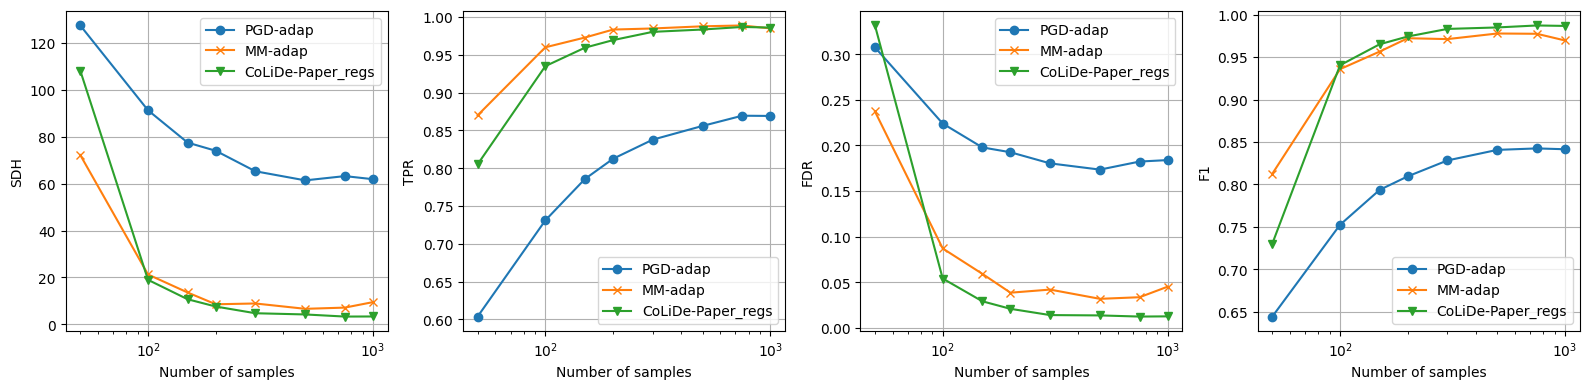

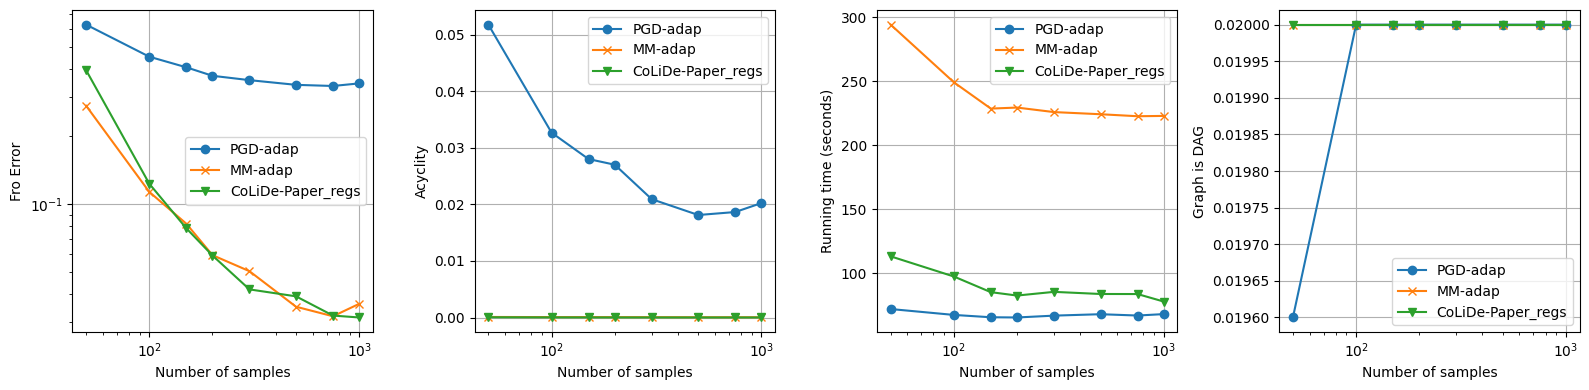

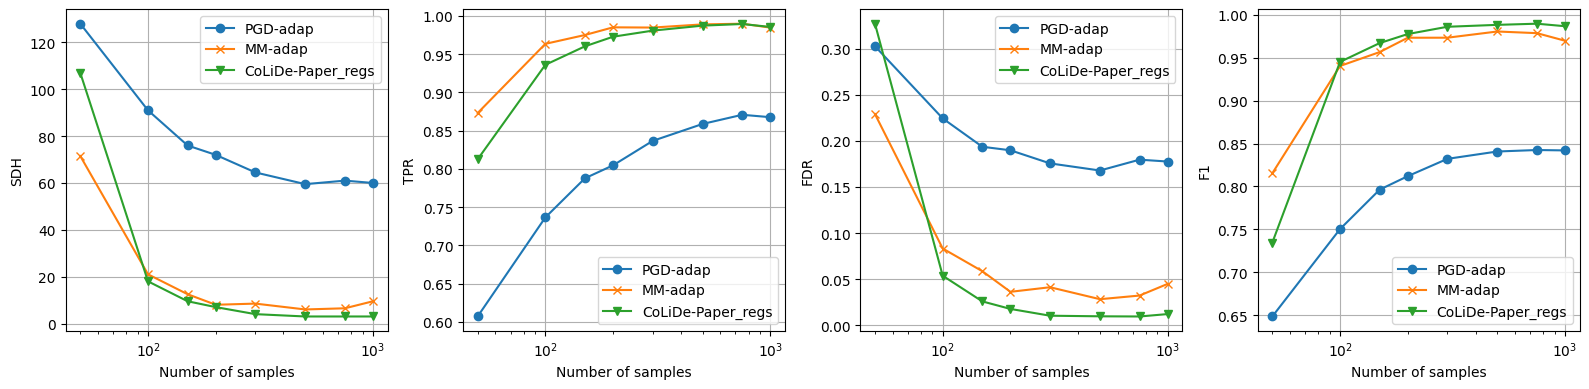

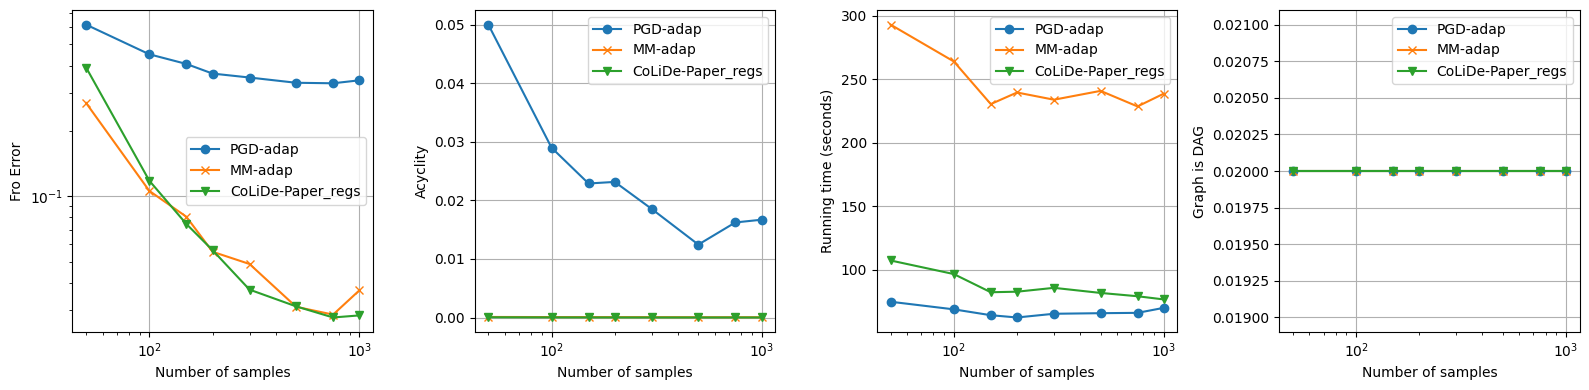

In [15]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


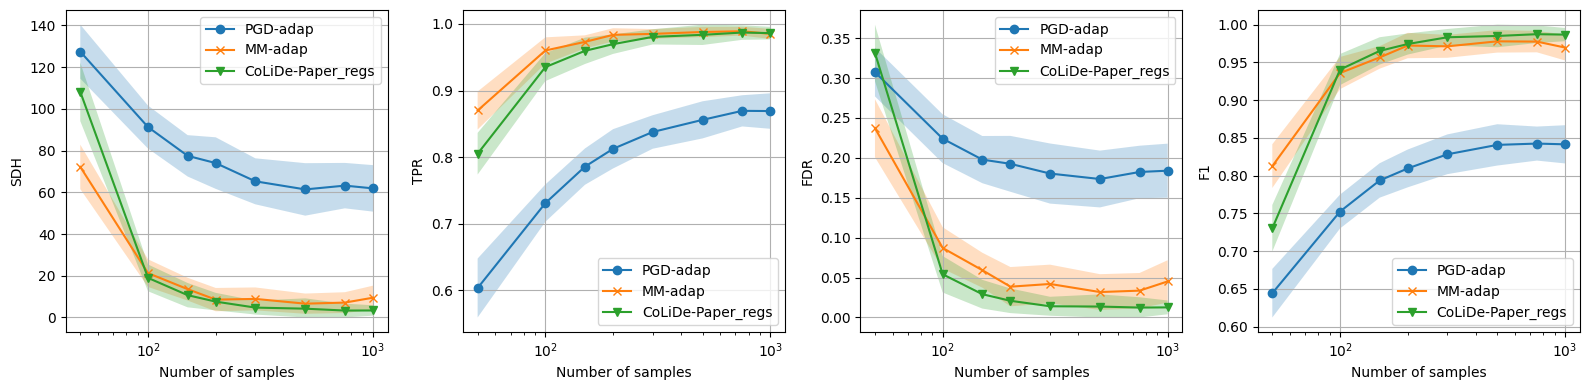

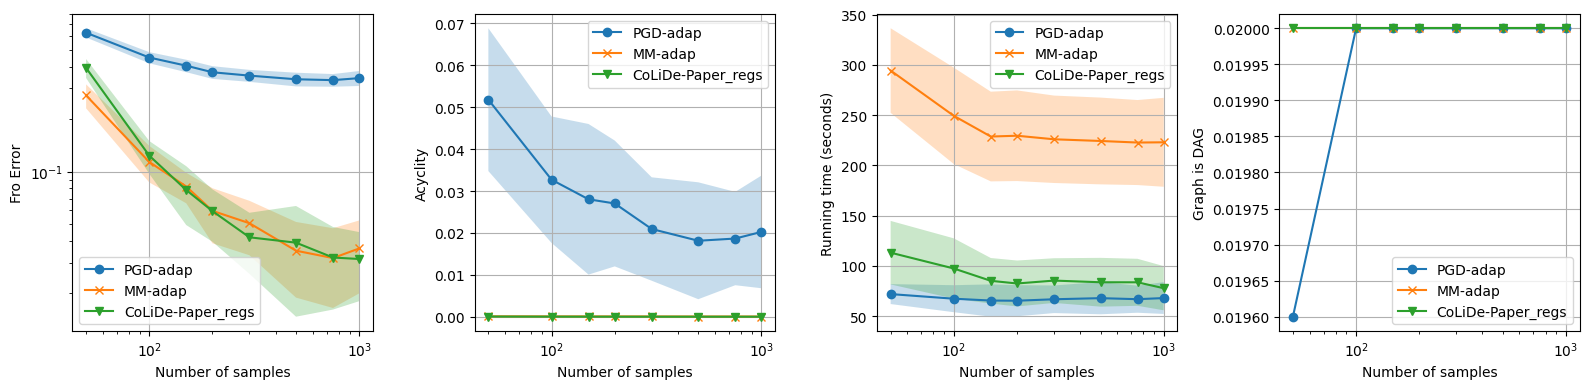

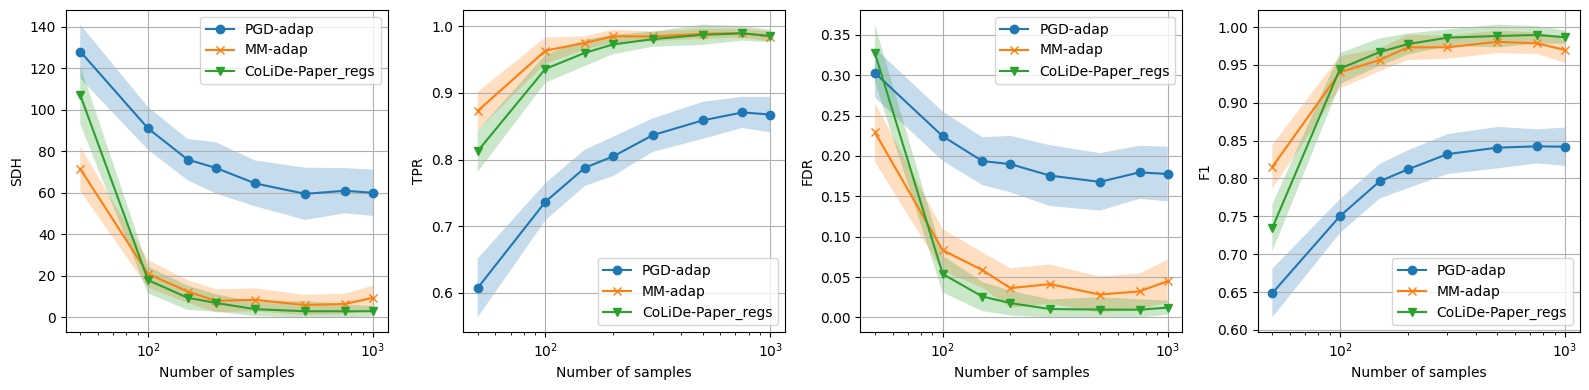

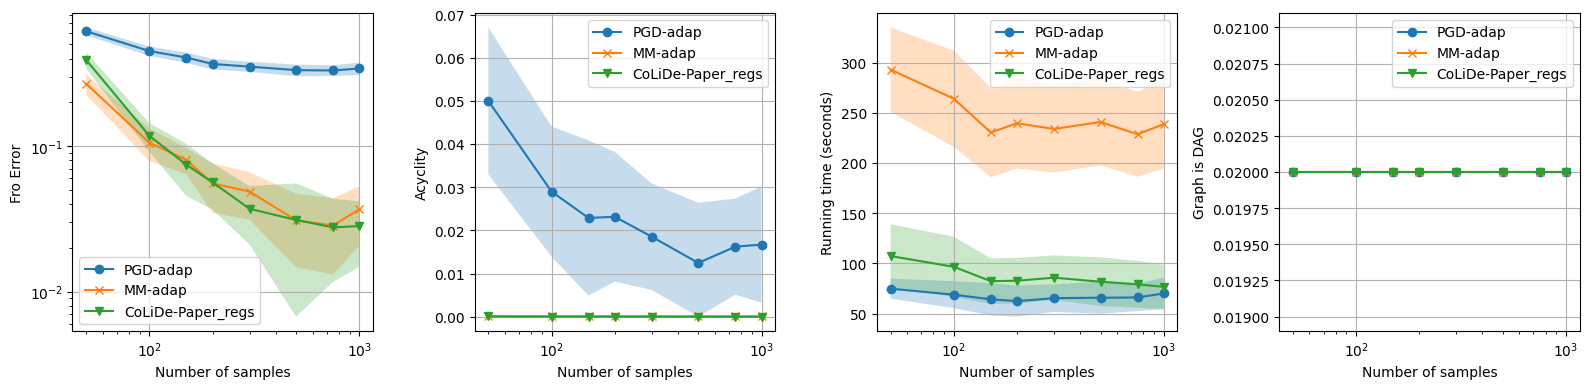

In [16]:
skip = [] # [2]
plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean', dev=True)

plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median', dev=True)
